# Analyze Network for a Model

In [1]:
from StarKiller.initialization import starkiller_initialize
from StarKiller.interfaces import EosType
from StarKiller.interfaces import BurnType
from StarKiller.eos import Eos
from StarKiller.network import Network
from StarKiller.models import AmrexAstroModel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Initialize Starkiller Microphysics

In [2]:
probin_file = "probin_aprox21"

In [3]:
starkiller_initialize(probin_file)

In [4]:
helmholtz = Eos()
net = Network()

In [5]:
def evaluate_rhs(burn_state):
    net.rhs(burn_state)
    return burn_state

def evaluate_eos(burn_state):
    eos_state = burn_state.to_eos_type()
    helmholtz.evaluate(eos_state.eos_input_rt, eos_state)
    return eos_state

## Read AMReX initial model

In [8]:
maestro_data = AmrexAstroModel('15m_500_sec.hse.6400')

In [9]:
maestro_data.model_data['logRho'] = np.log10(maestro_data.data('density'))

## Evaluate energy generation rate for MaestroEx initial model

In [10]:
sk_maestro_burn_results = []
sk_maestro_eos_results = []

for zi in range(maestro_data.size):
    mass_fractions = []
    
    for s in net.short_species_names:
        mass_fractions.append(maestro_data.data(s)[zi])

    mass_fractions = np.array(mass_fractions)
    mass_fractions = mass_fractions/np.sum(mass_fractions)
    
    burn_state = BurnType()
    burn_state.state.rho = maestro_data.data('density')[zi]
    burn_state.state.t = maestro_data.data('temperature')[zi]
    burn_state.state.xn = mass_fractions
    
    # Evaluate the RHS and EOS in Starkiller
    sk_maestro_burn_results.append(evaluate_rhs(burn_state))
    sk_maestro_eos_results.append(evaluate_eos(burn_state))

In [11]:
sk_maestro_eps = []

for burn_state in sk_maestro_burn_results:
    sk_maestro_eps.append(burn_state.state.ydot[net.net_ienuc])
    
sk_maestro_eps = np.array(sk_maestro_eps)

## Plot MESA, Starkiller-MESA, and Starkiller-Maestro energy generation rates

In [13]:
font_config = {'size': 20}
text_config = {'usetex': True}
figure_config = {'dpi': 300}

matplotlib.rc('font', **font_config)
matplotlib.rc('text', **text_config)
matplotlib.rc('figure', **figure_config)

sk_maestro_enuc_pos = np.maximum(sk_maestro_eps, 0.0)
sk_maestro_enuc_neg = np.maximum(-sk_maestro_eps, 0.0)

# The order of zones in MESA and Maestro are reverse from each other
# so define a separate radius array for the Maestro data
maestro_radius_km = maestro_data.data('radius') * 1.0e-5

def plot_enuc(xlim=None, ylim=None):
    fig, ax = plt.subplots(facecolor='w')
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)

    ax.plot(maestro_radius_km, sk_maestro_enuc_pos, color='m', linestyle='-', 
            label=r'$\mathrm{StarKiller-Maestro}$ $\dot{\varepsilon} > 0$')
    
    ax.plot(maestro_radius_km, sk_maestro_enuc_neg, color='m', linestyle=':', 
            label=r'$\mathrm{StarKiller-Maestro}$ $\dot{\varepsilon} < 0$')
    
    ax.set_yscale('log')
    
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)

    ax.set_xlabel(r'$\mathrm{r\ (km)}$')
    ax.set_ylabel(r'$\dot{\varepsilon} = \dot{\varepsilon}_{m c^2} - |\dot{\varepsilon}_{\nu}|$')
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.show()

In [14]:
def plot_field(xlim=None, ylim=None, field="temperature", logy=False):
    fig, ax = plt.subplots(facecolor='w')
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)

    ax.plot(maestro_radius_km, maestro_data.data(field), color='m', 
            label=r'$\mathrm{Maestro}$')

    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)
        
    if logy:
        ax.set_yscale('log')

    ax.set_xlabel(r'$\mathrm{r\ (km)}$')
    ax.set_ylabel(r'$\mathrm{' + '{}'.format(field) + r'}$')
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.show()

### Entire Profile

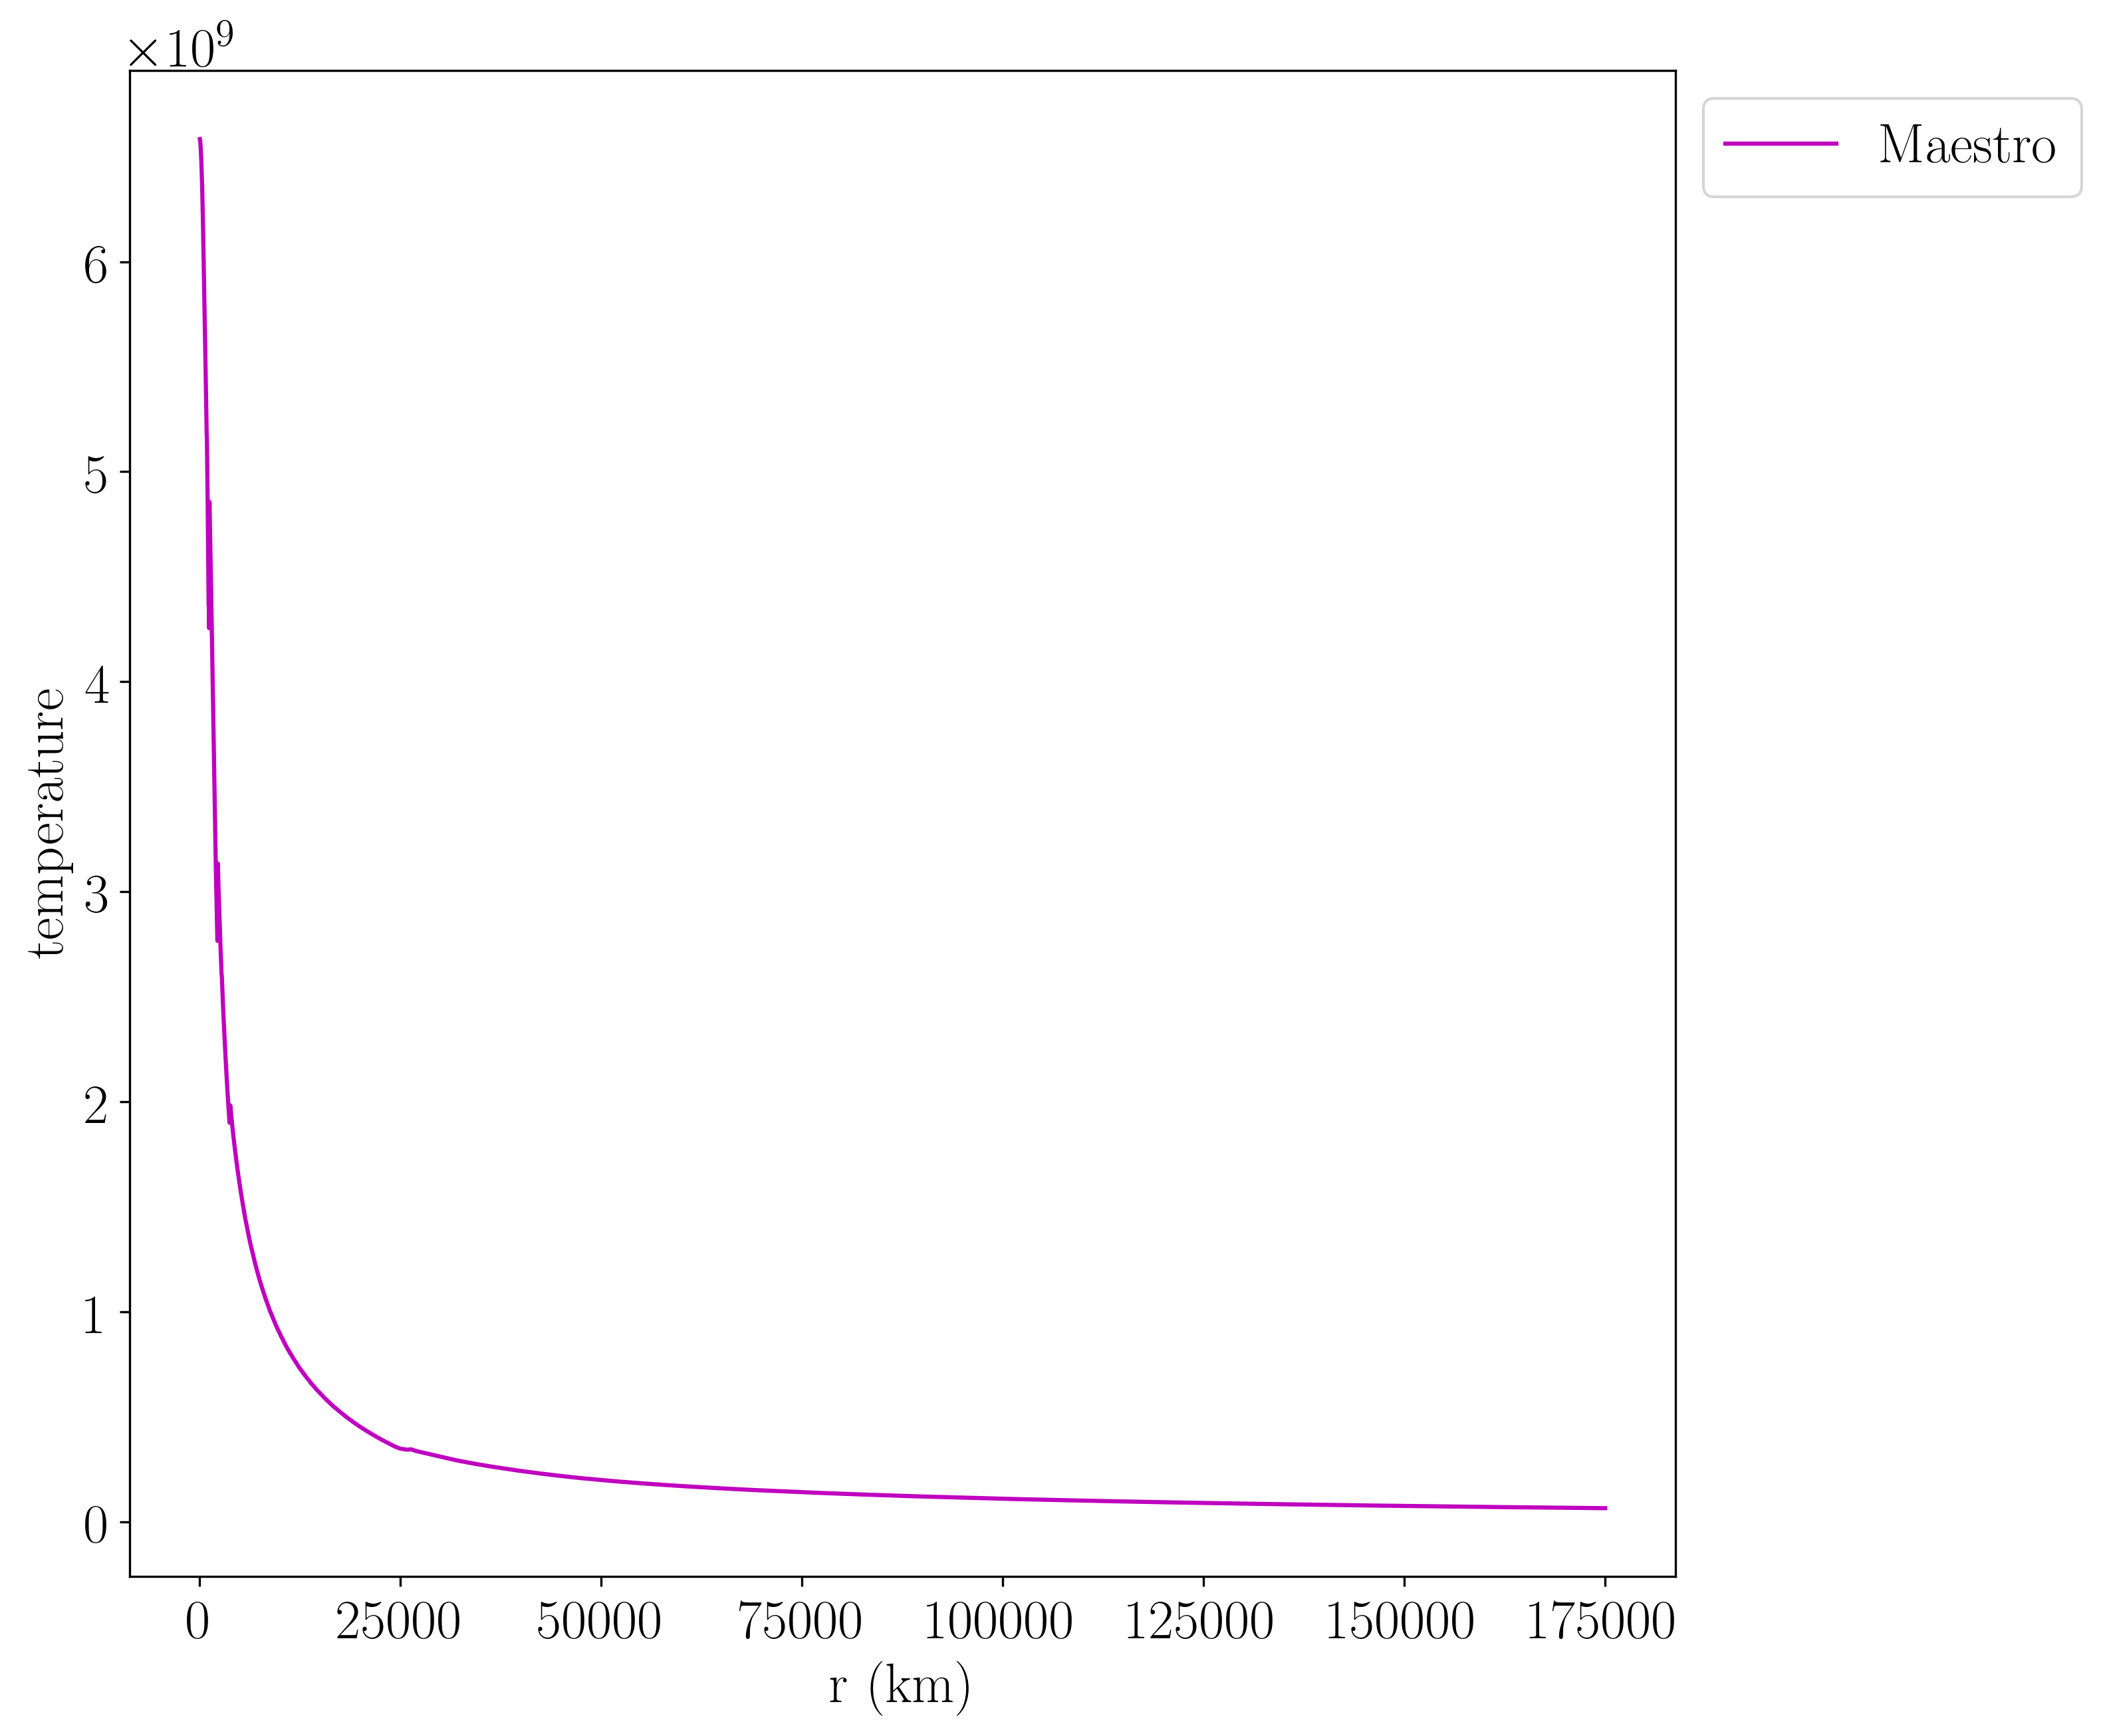

In [15]:
plot_field(field='temperature')

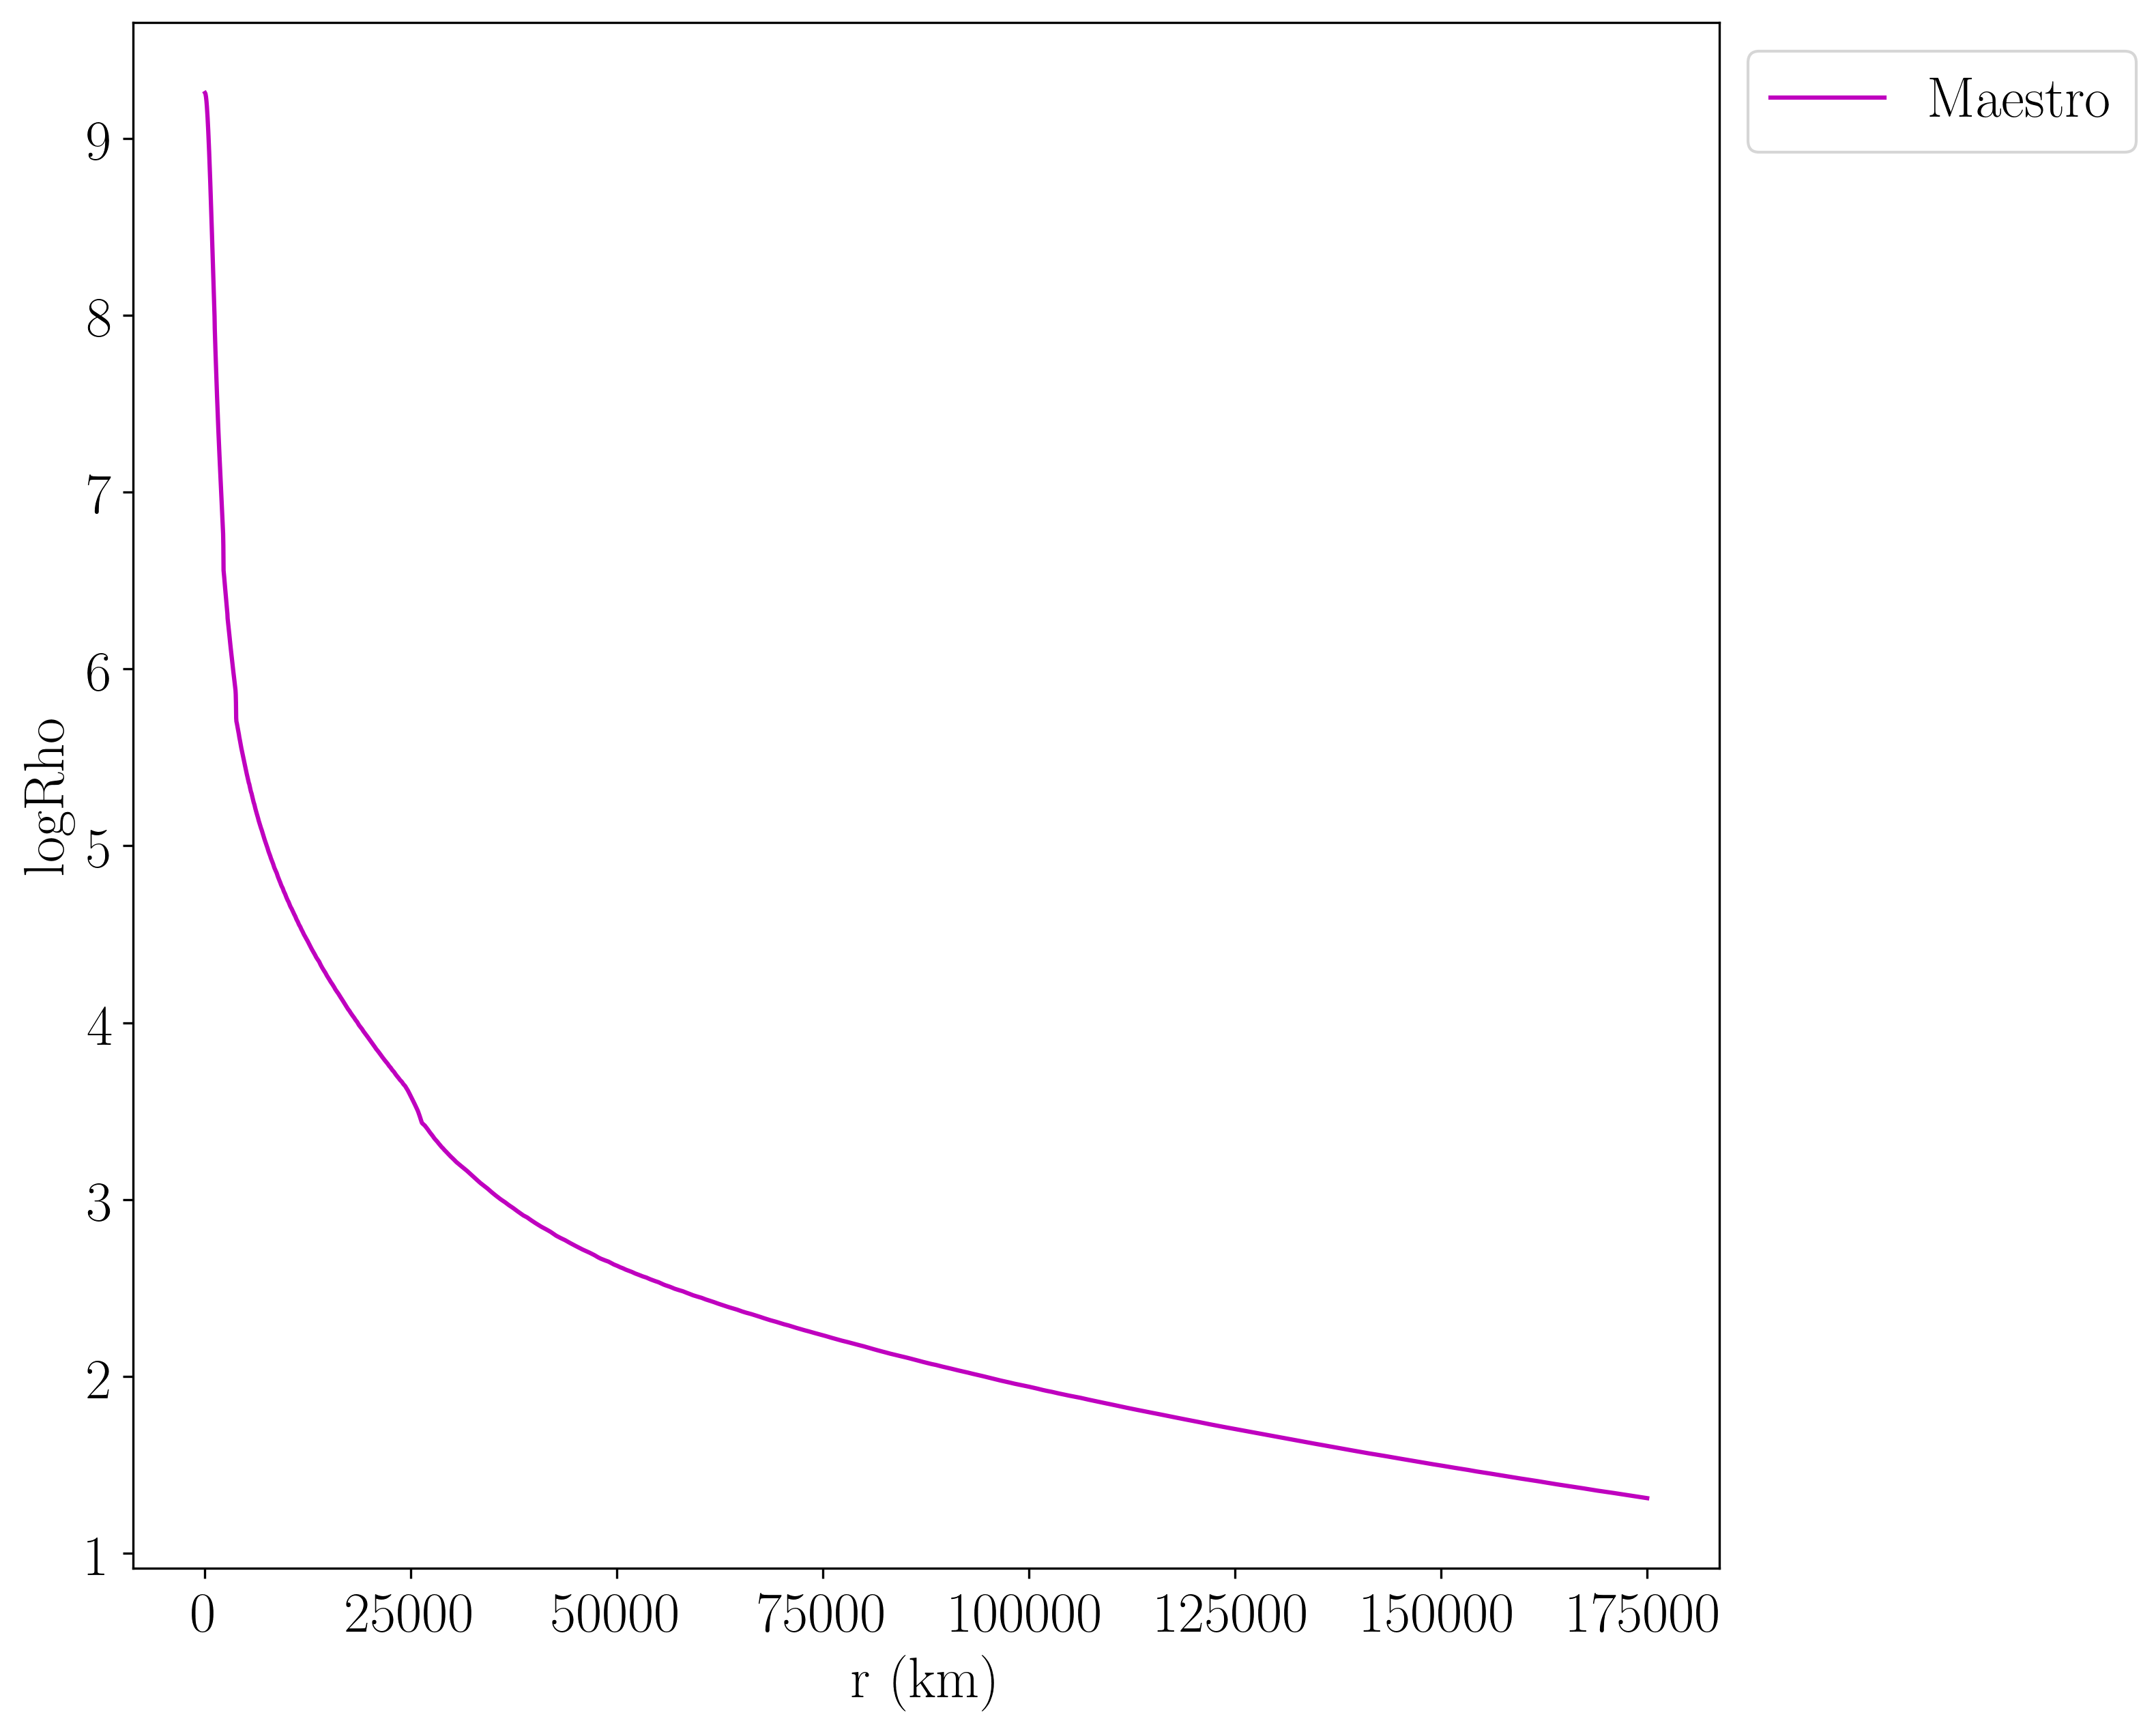

In [16]:
plot_field(field='logRho')

### Plot mass fractions for species

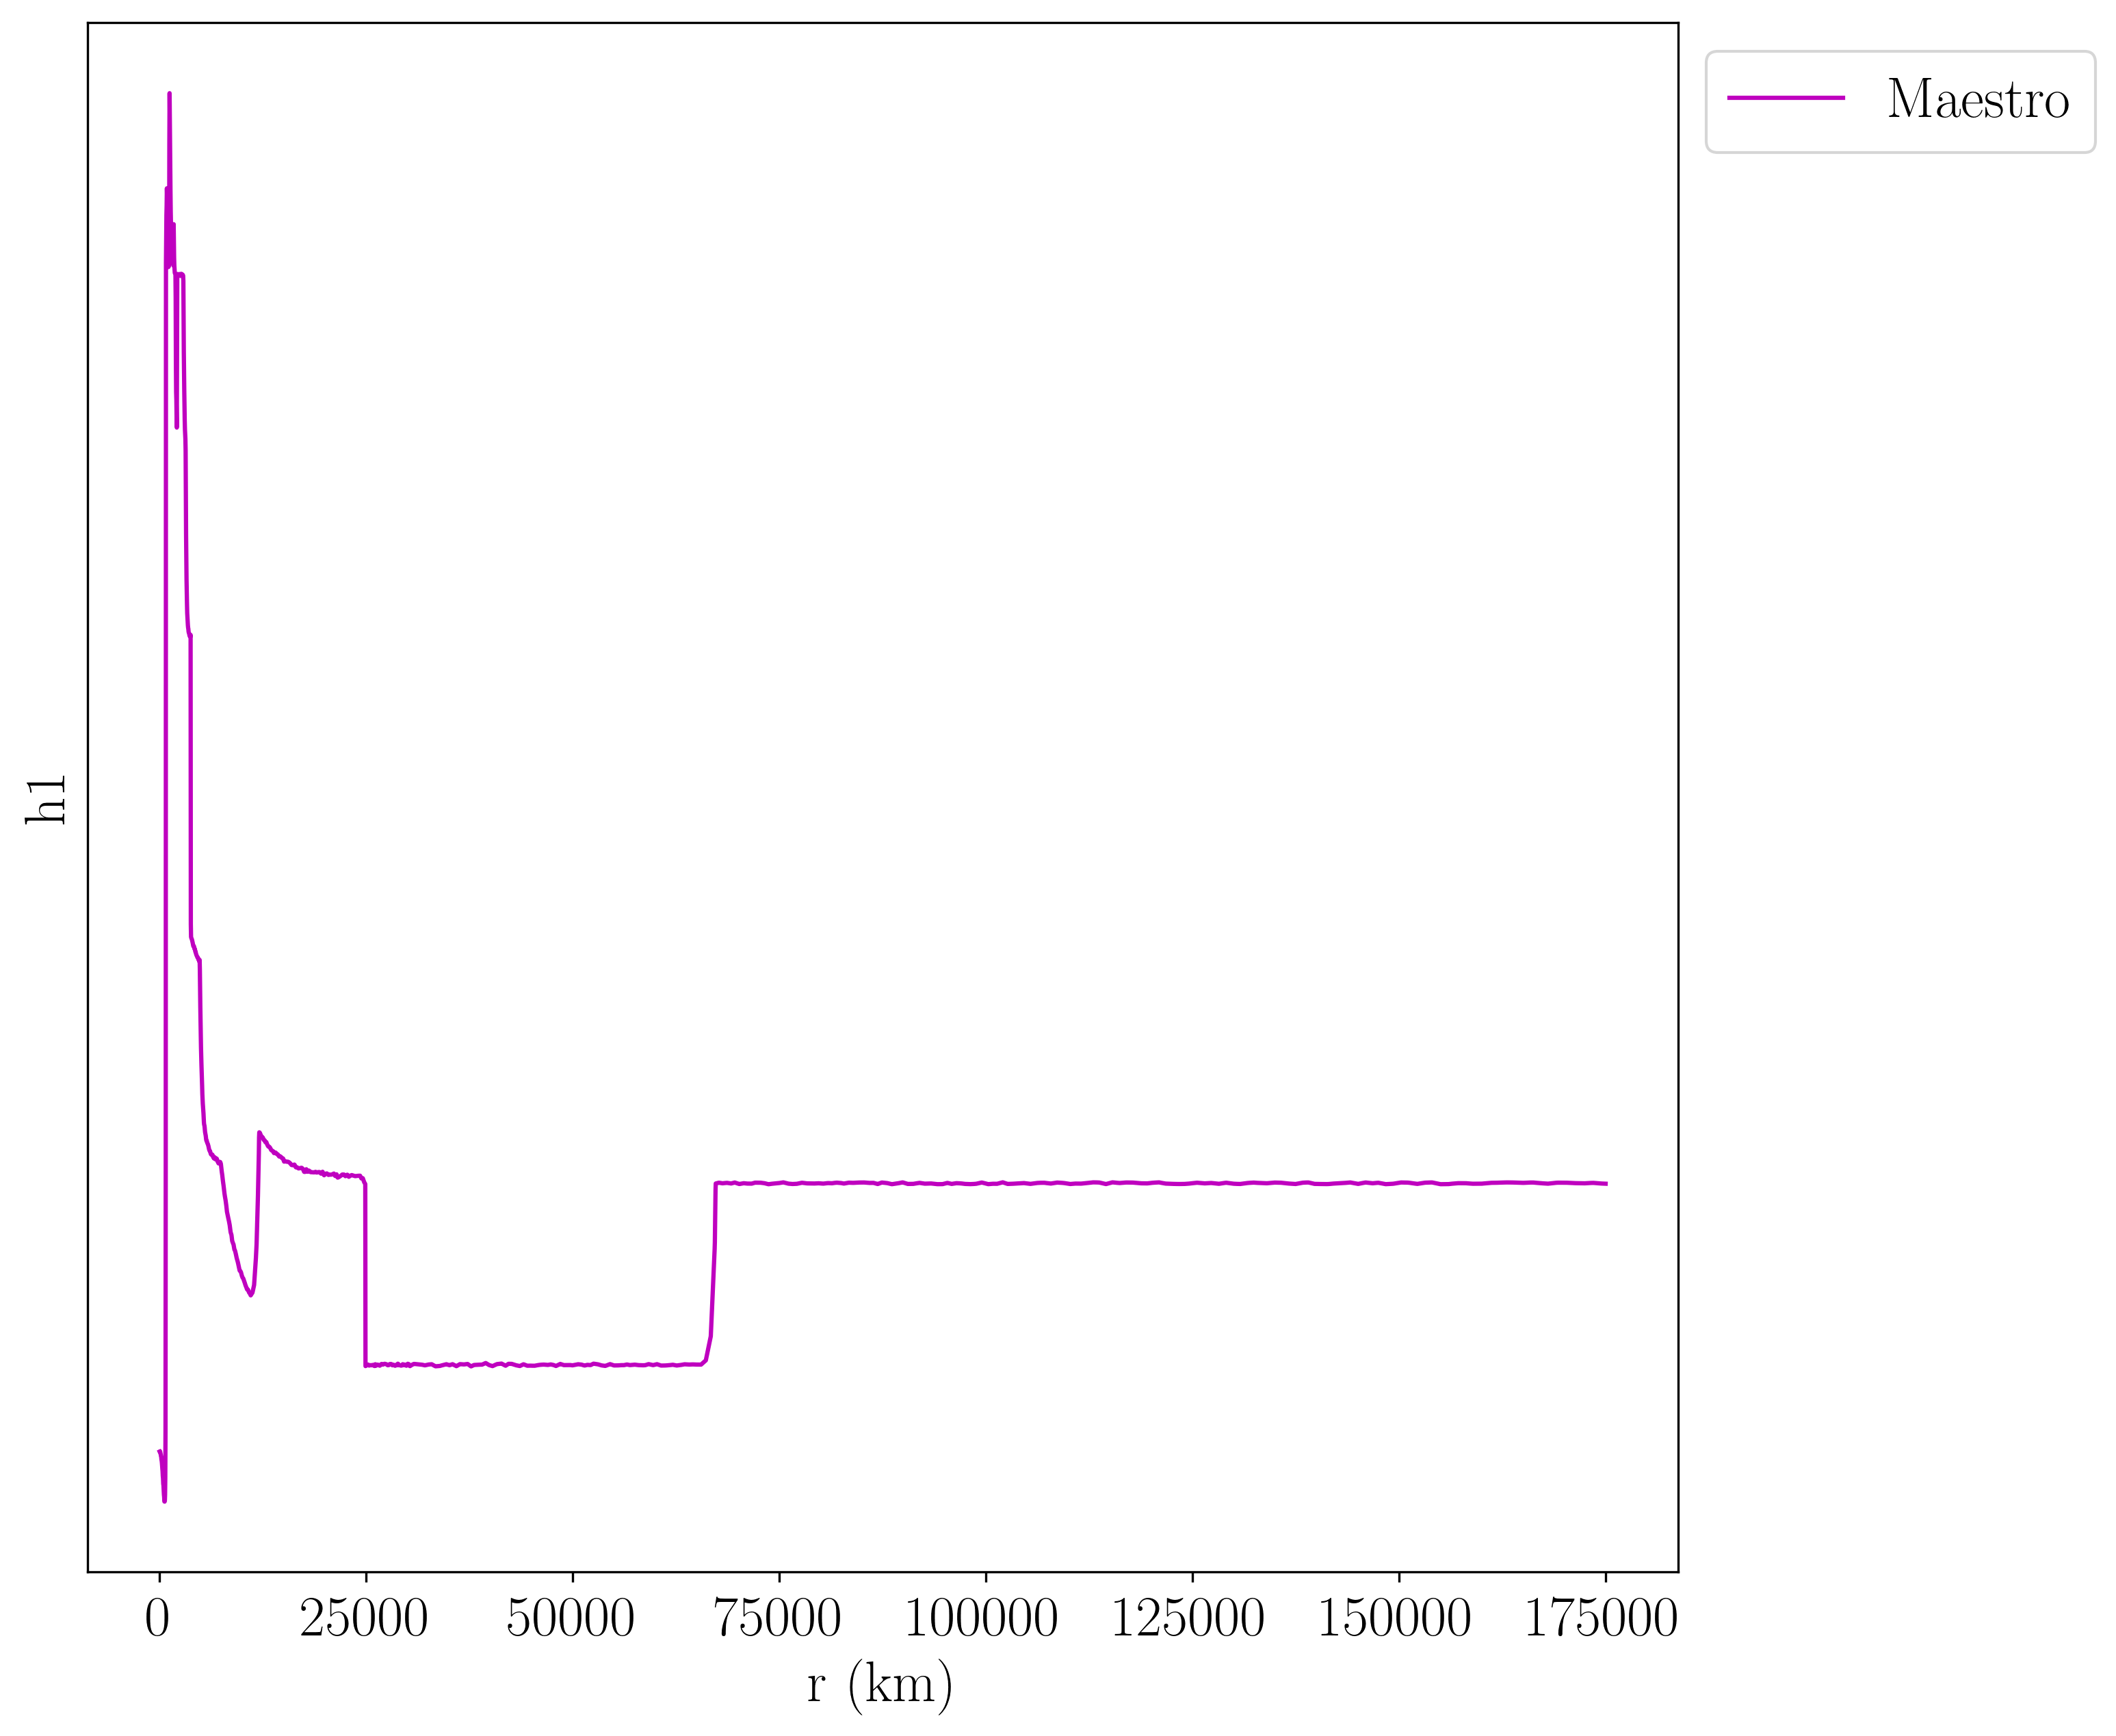

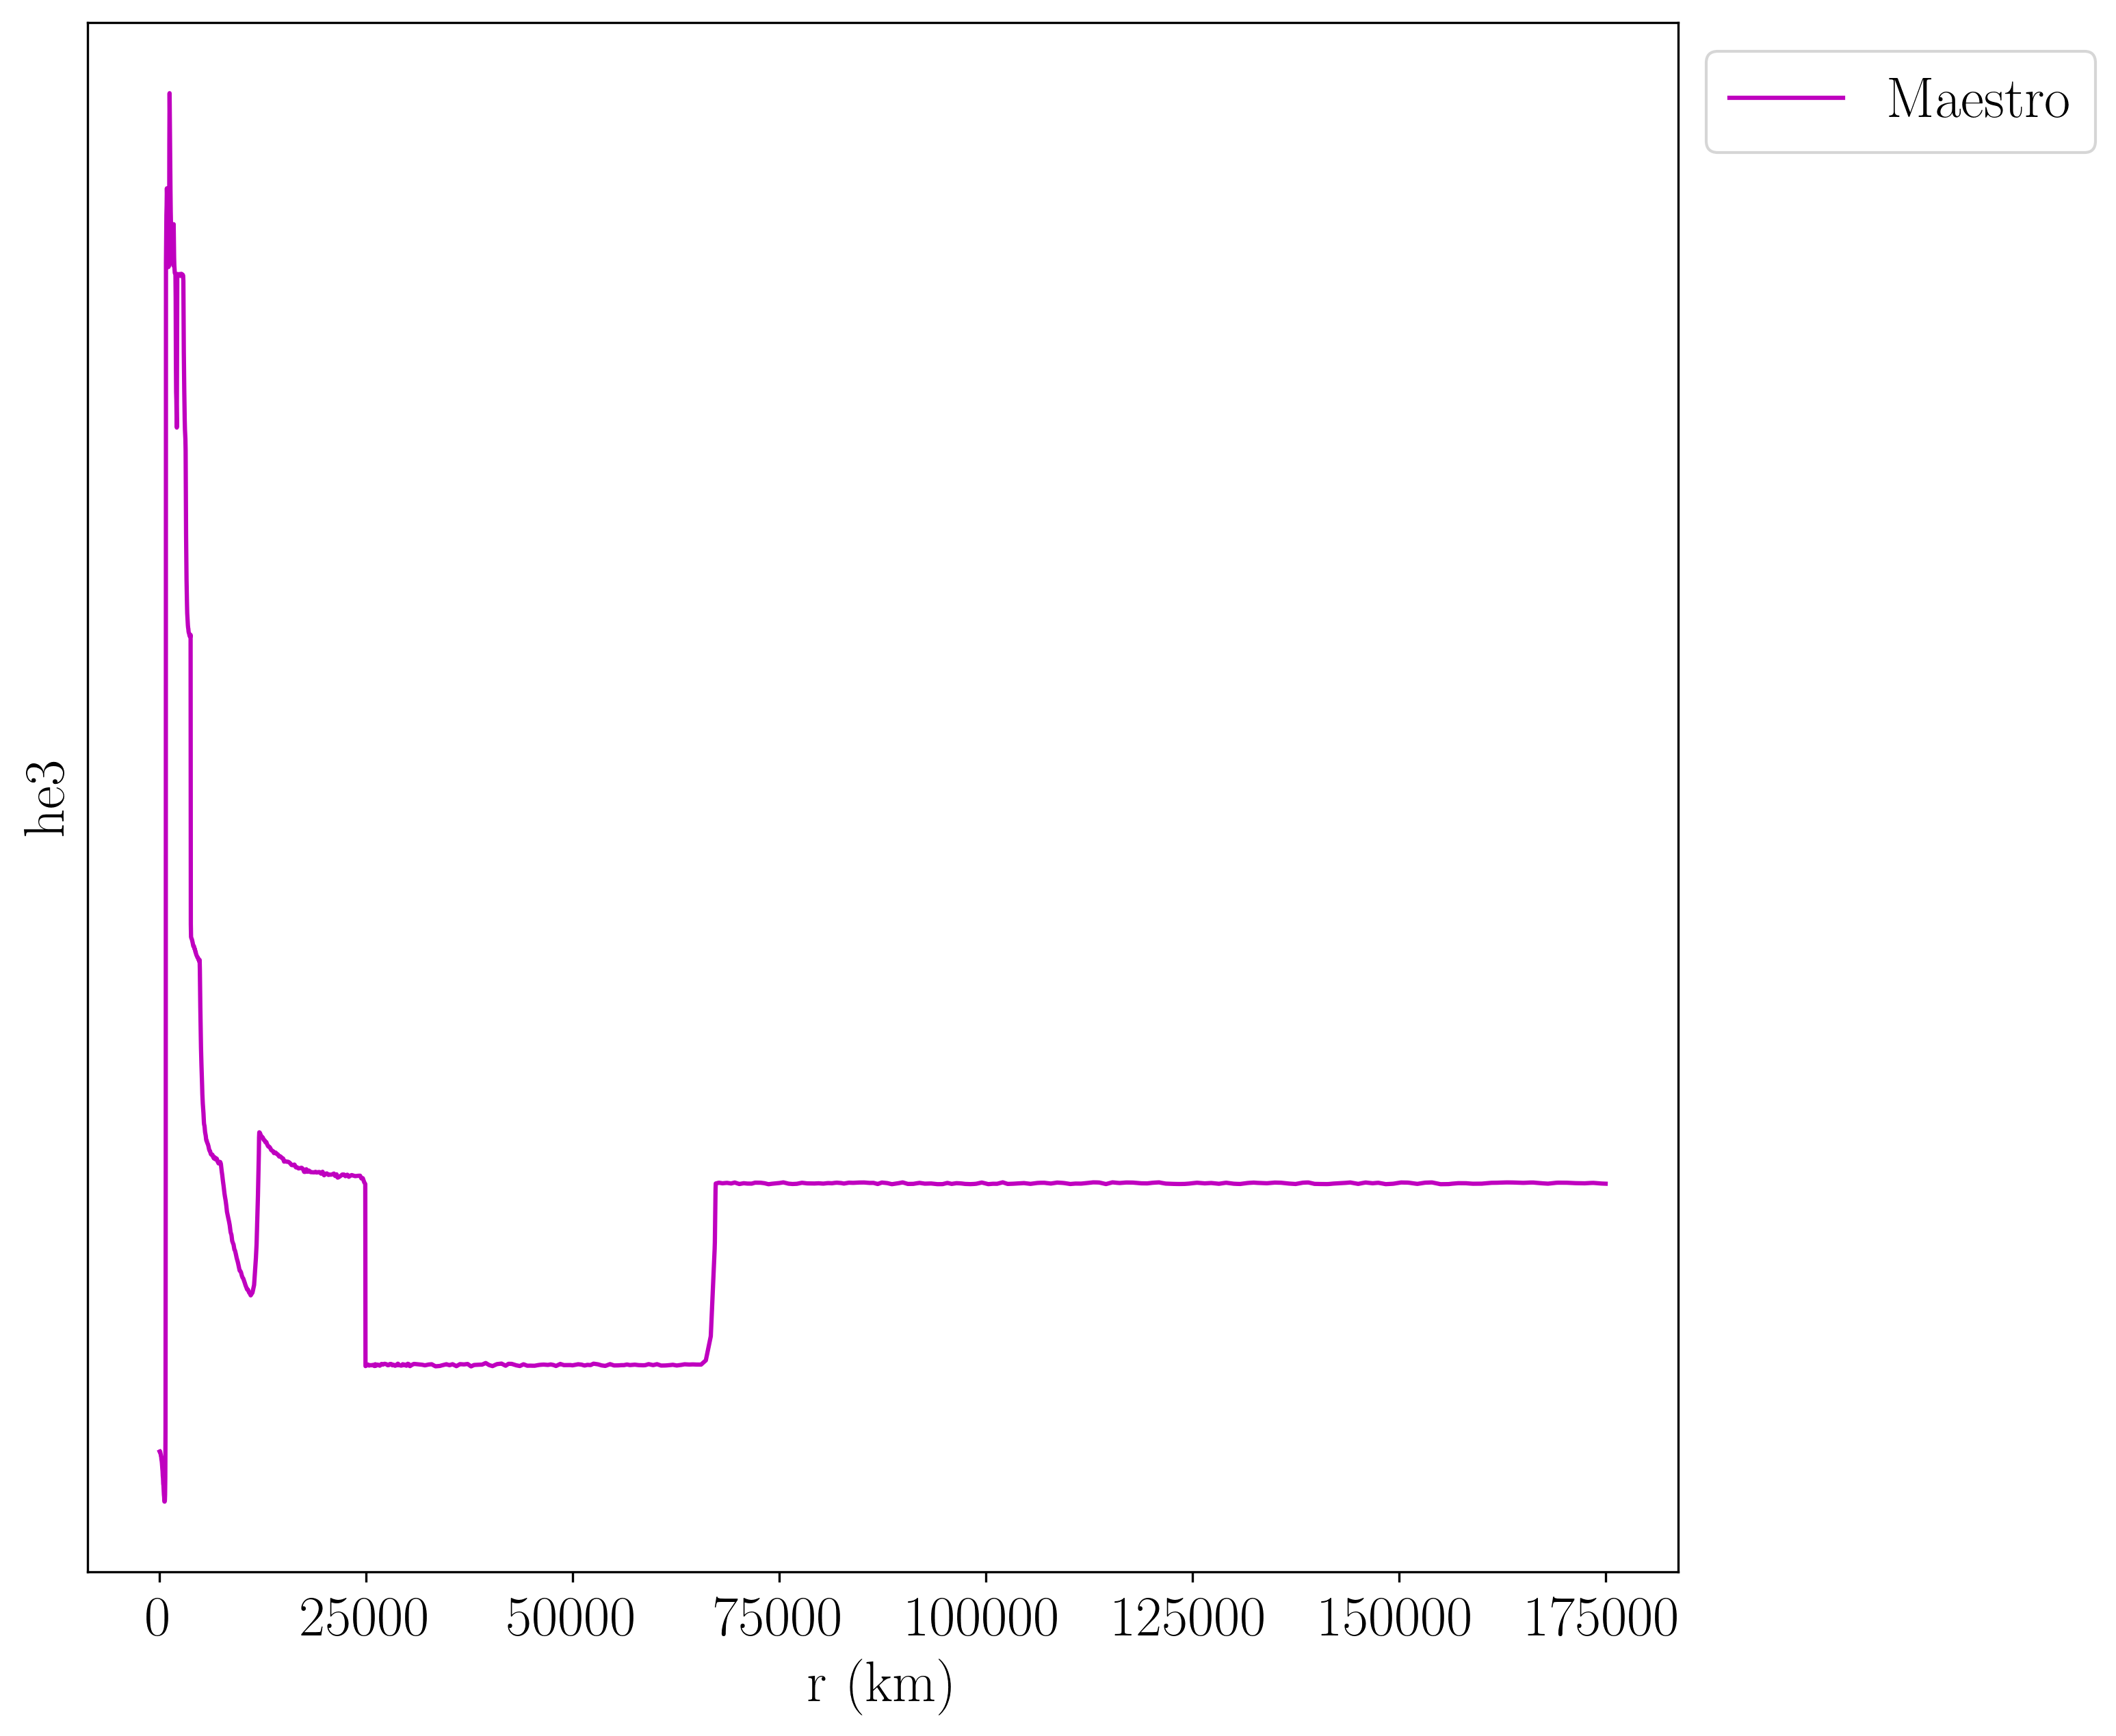

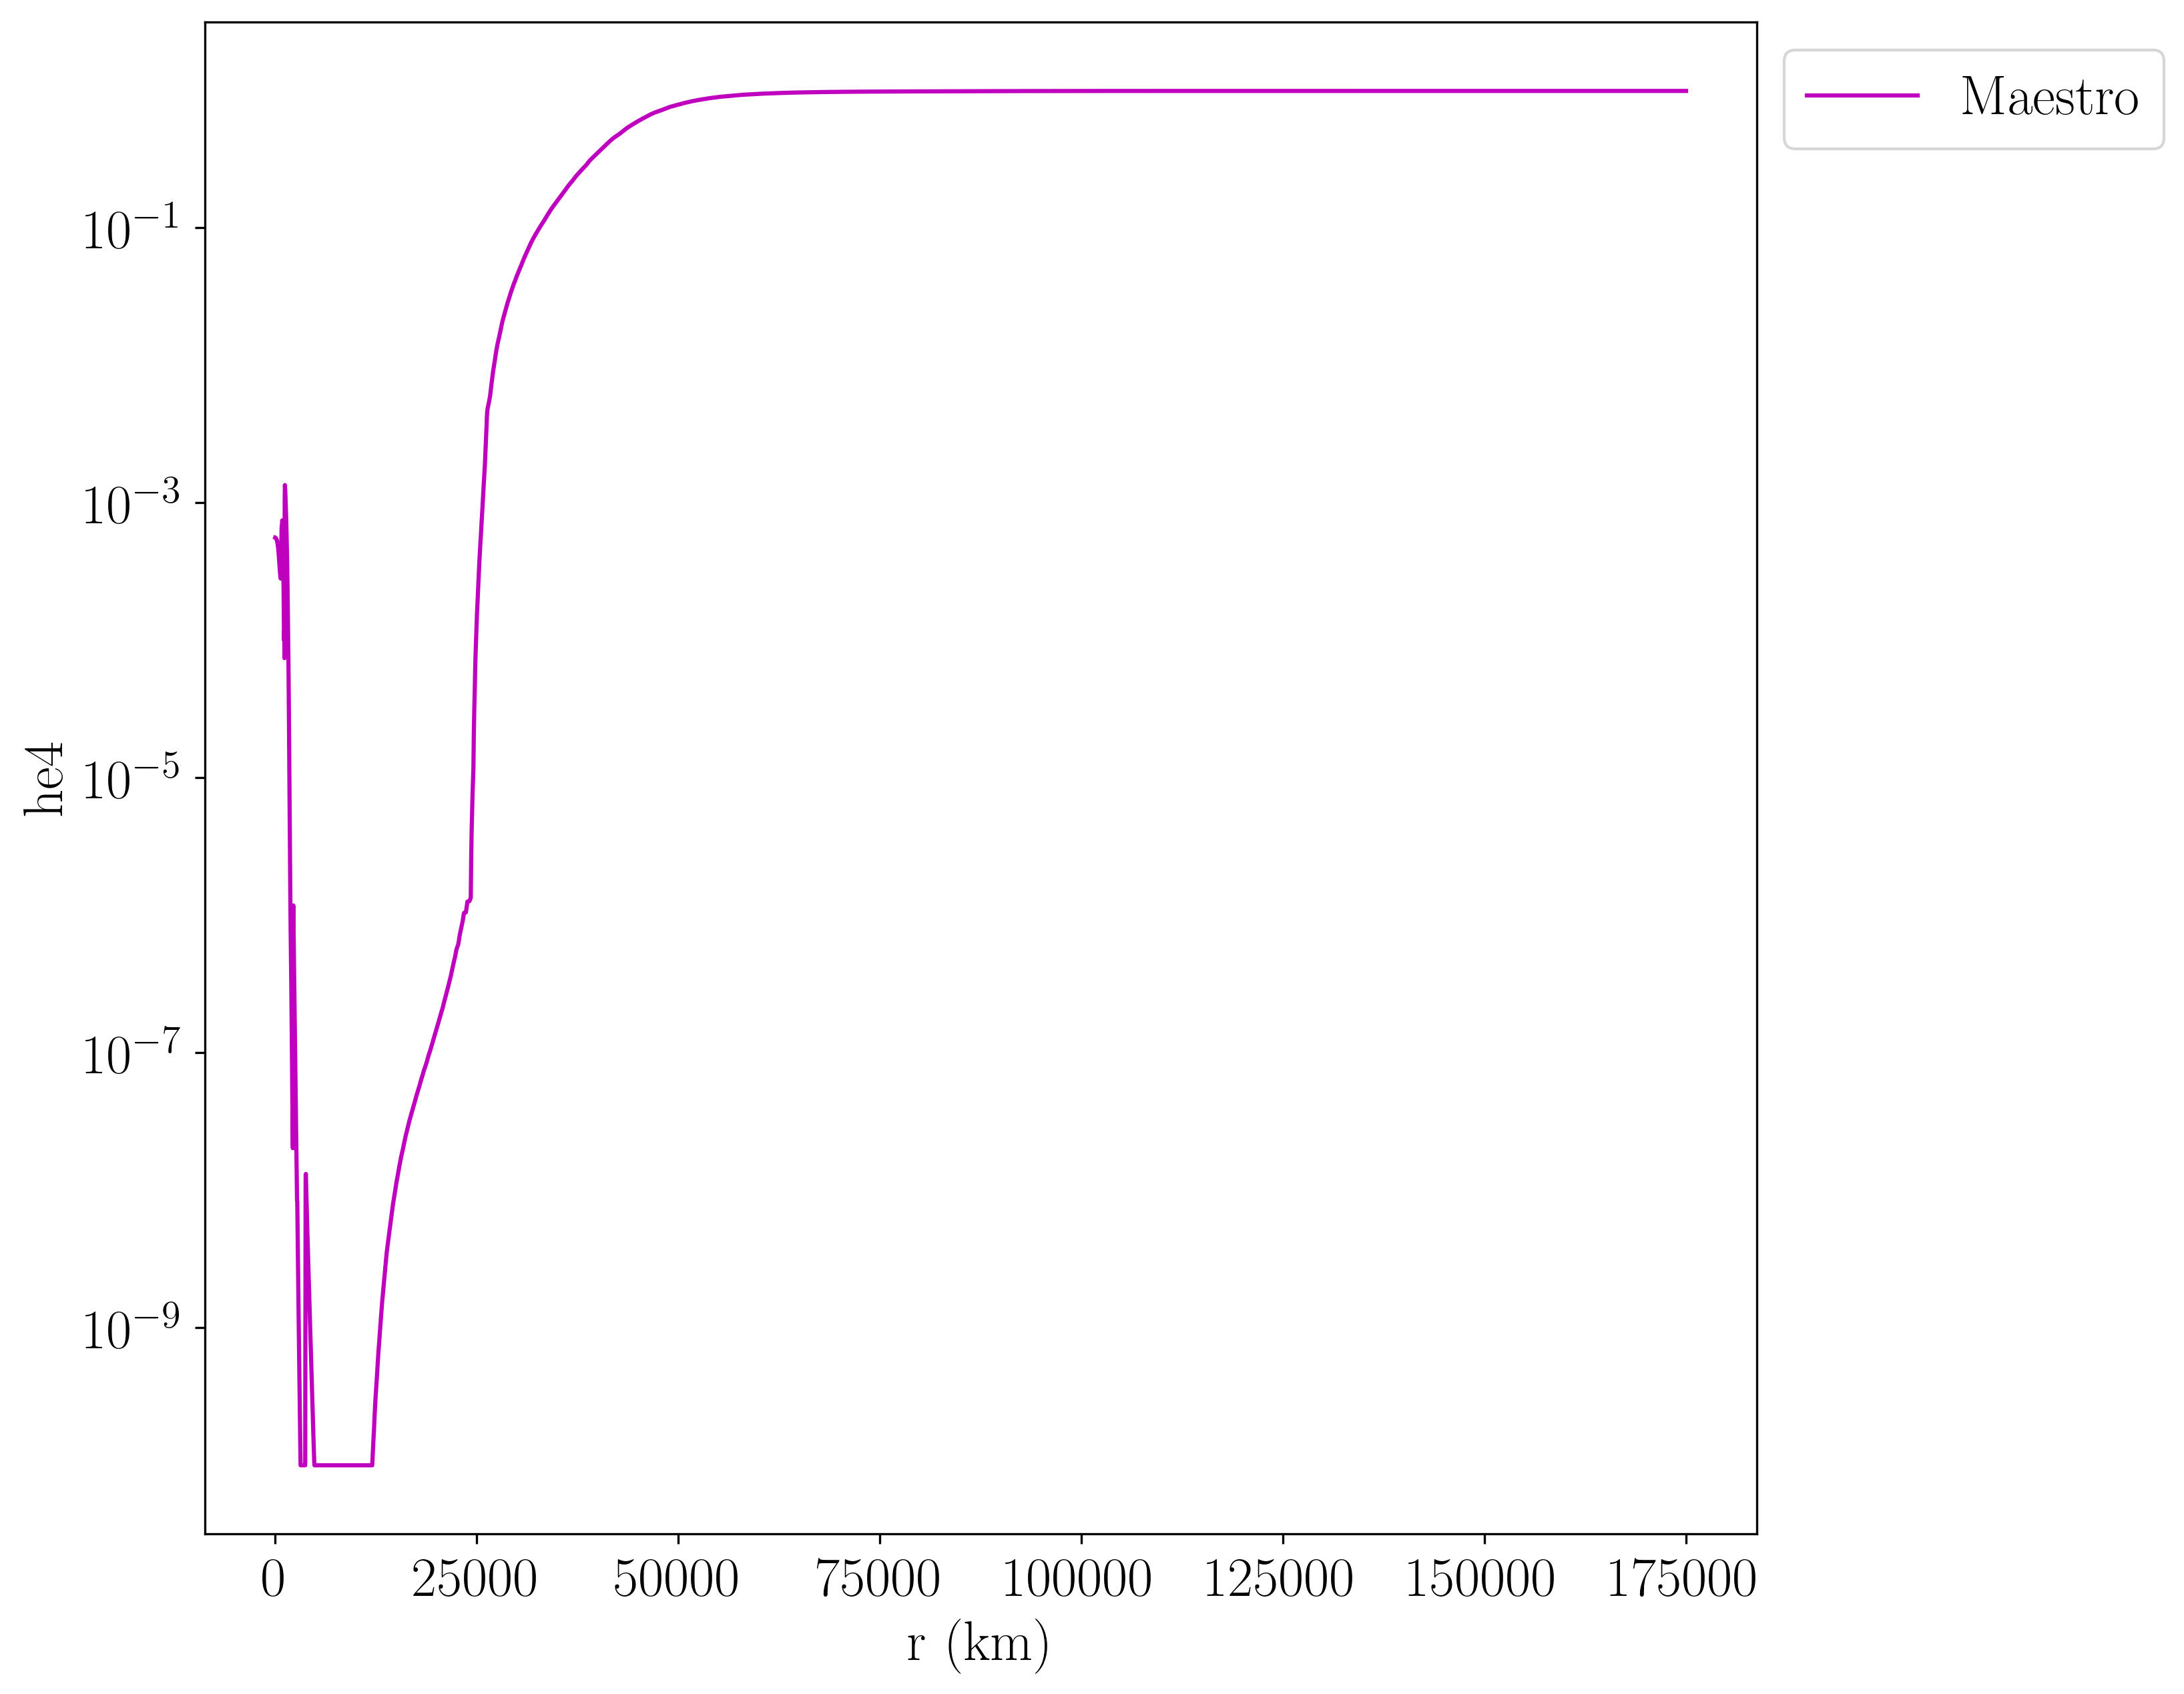

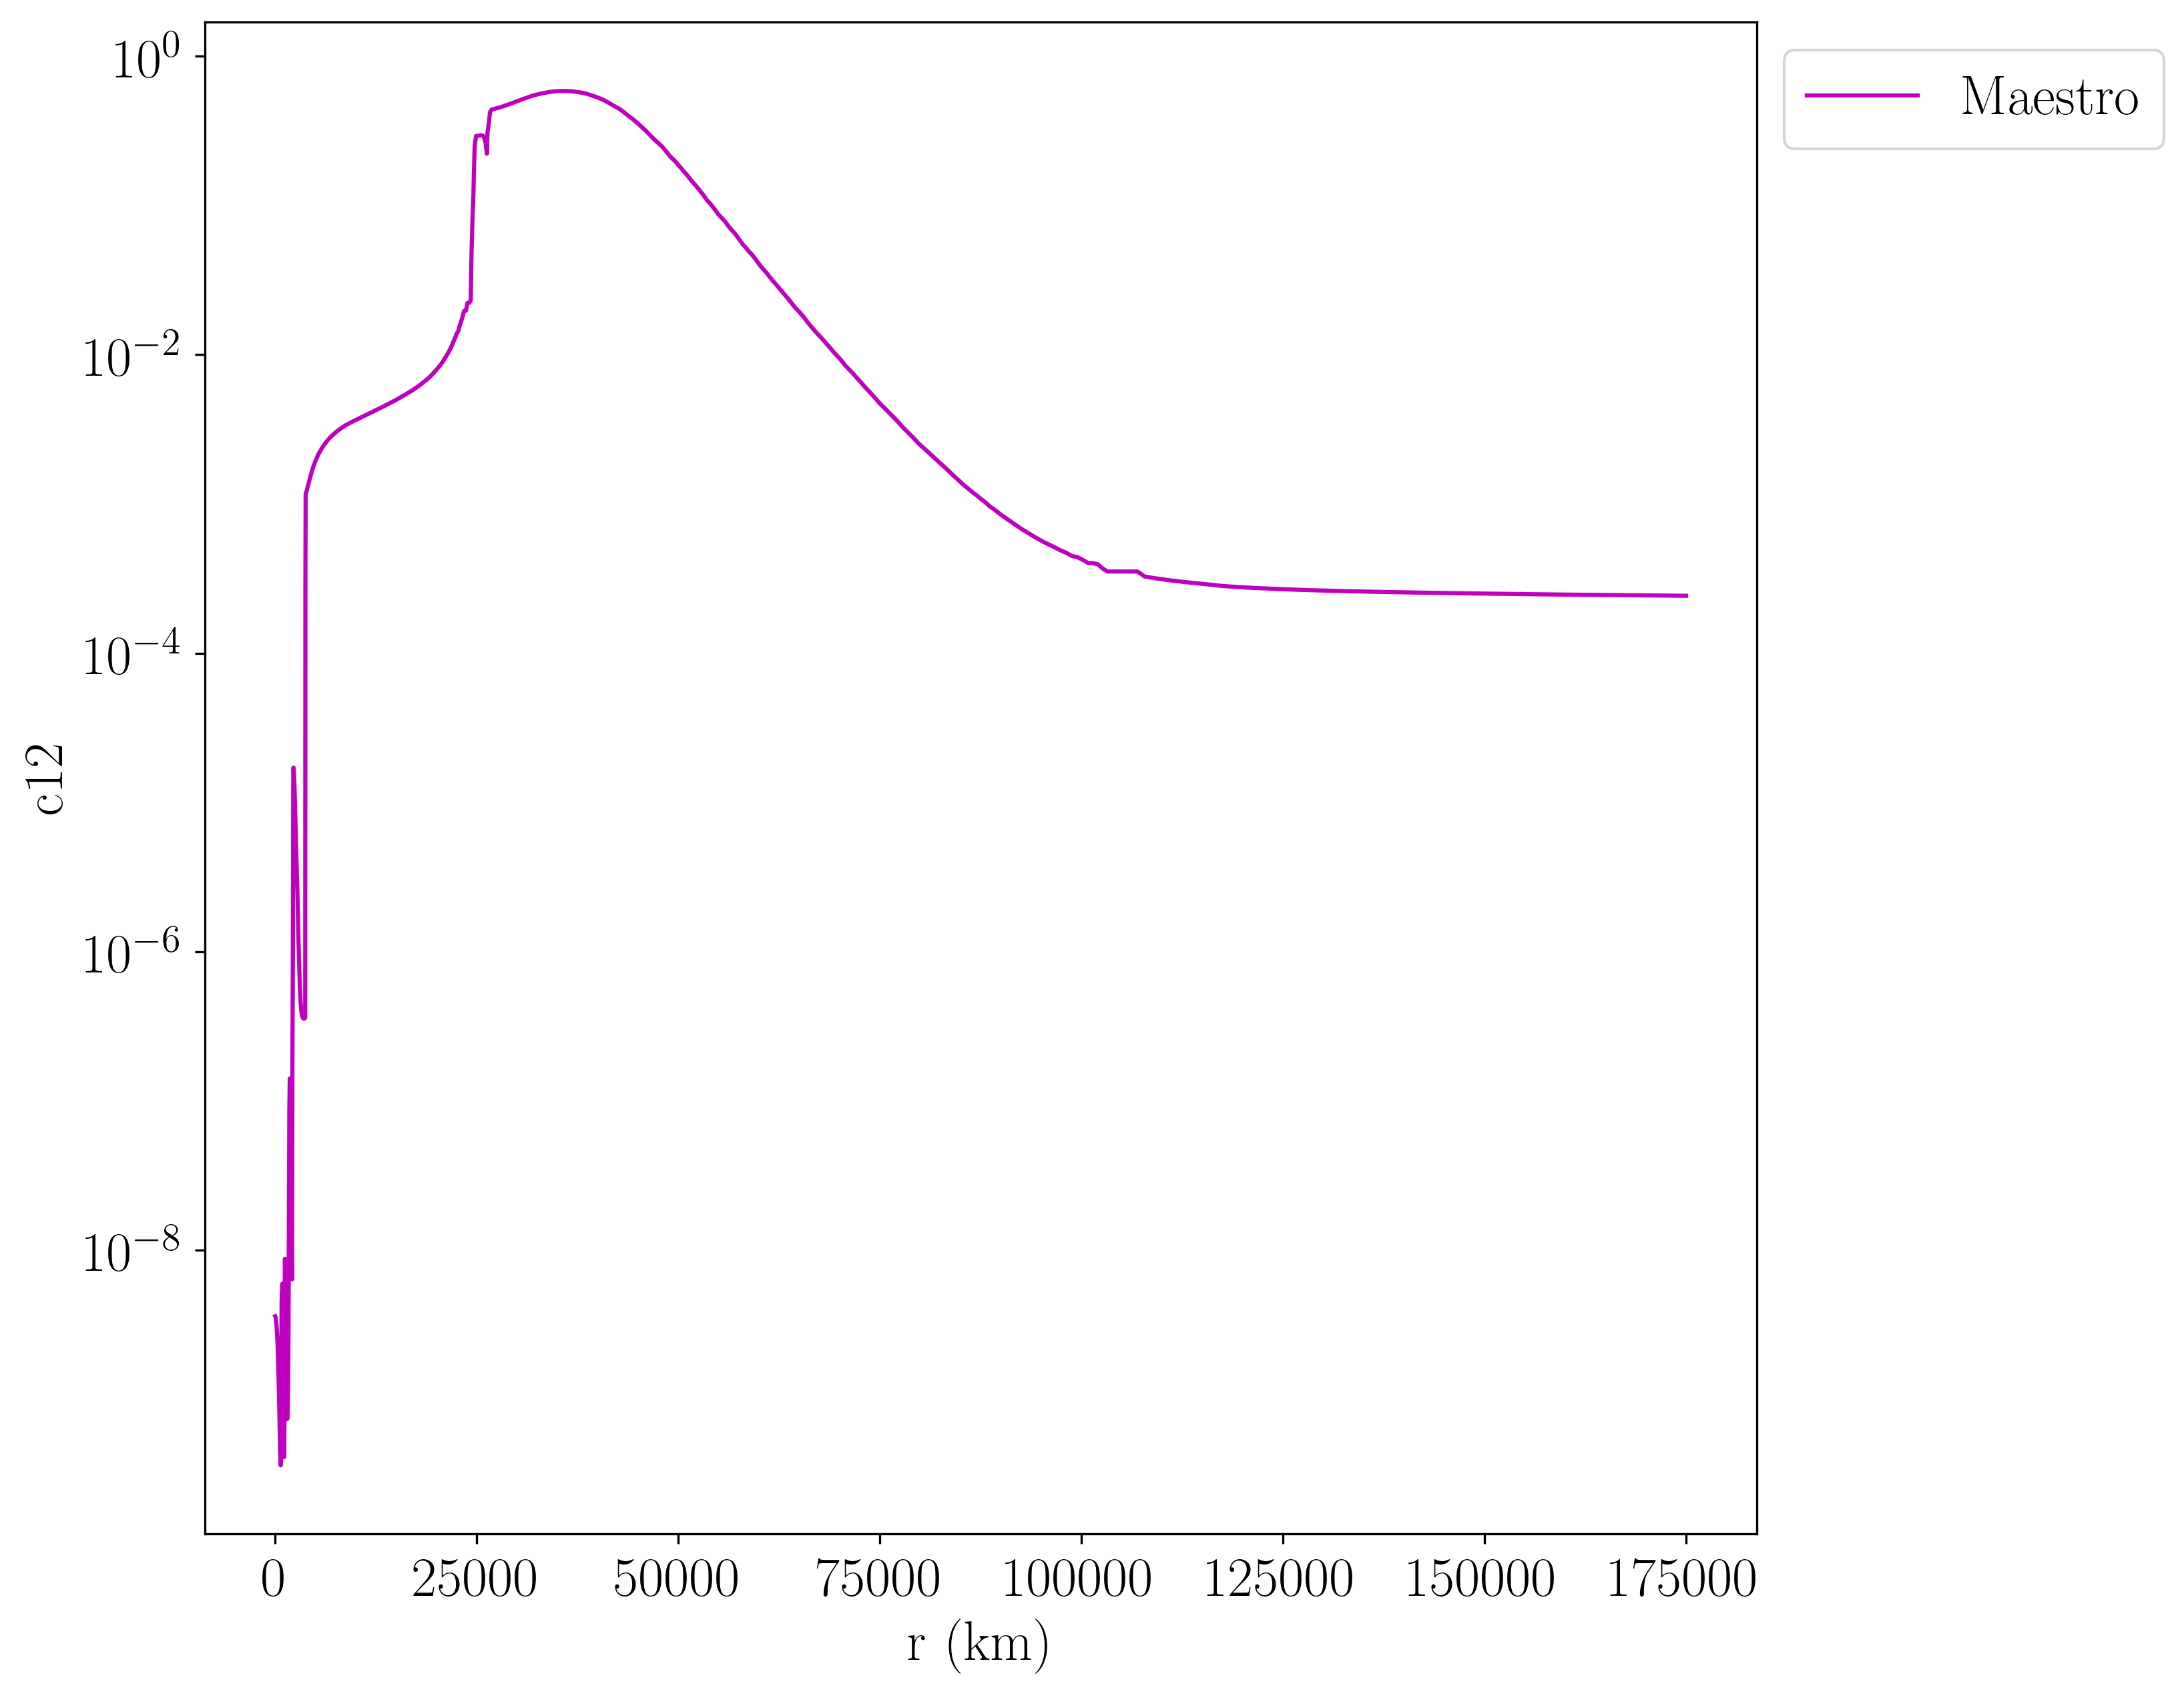

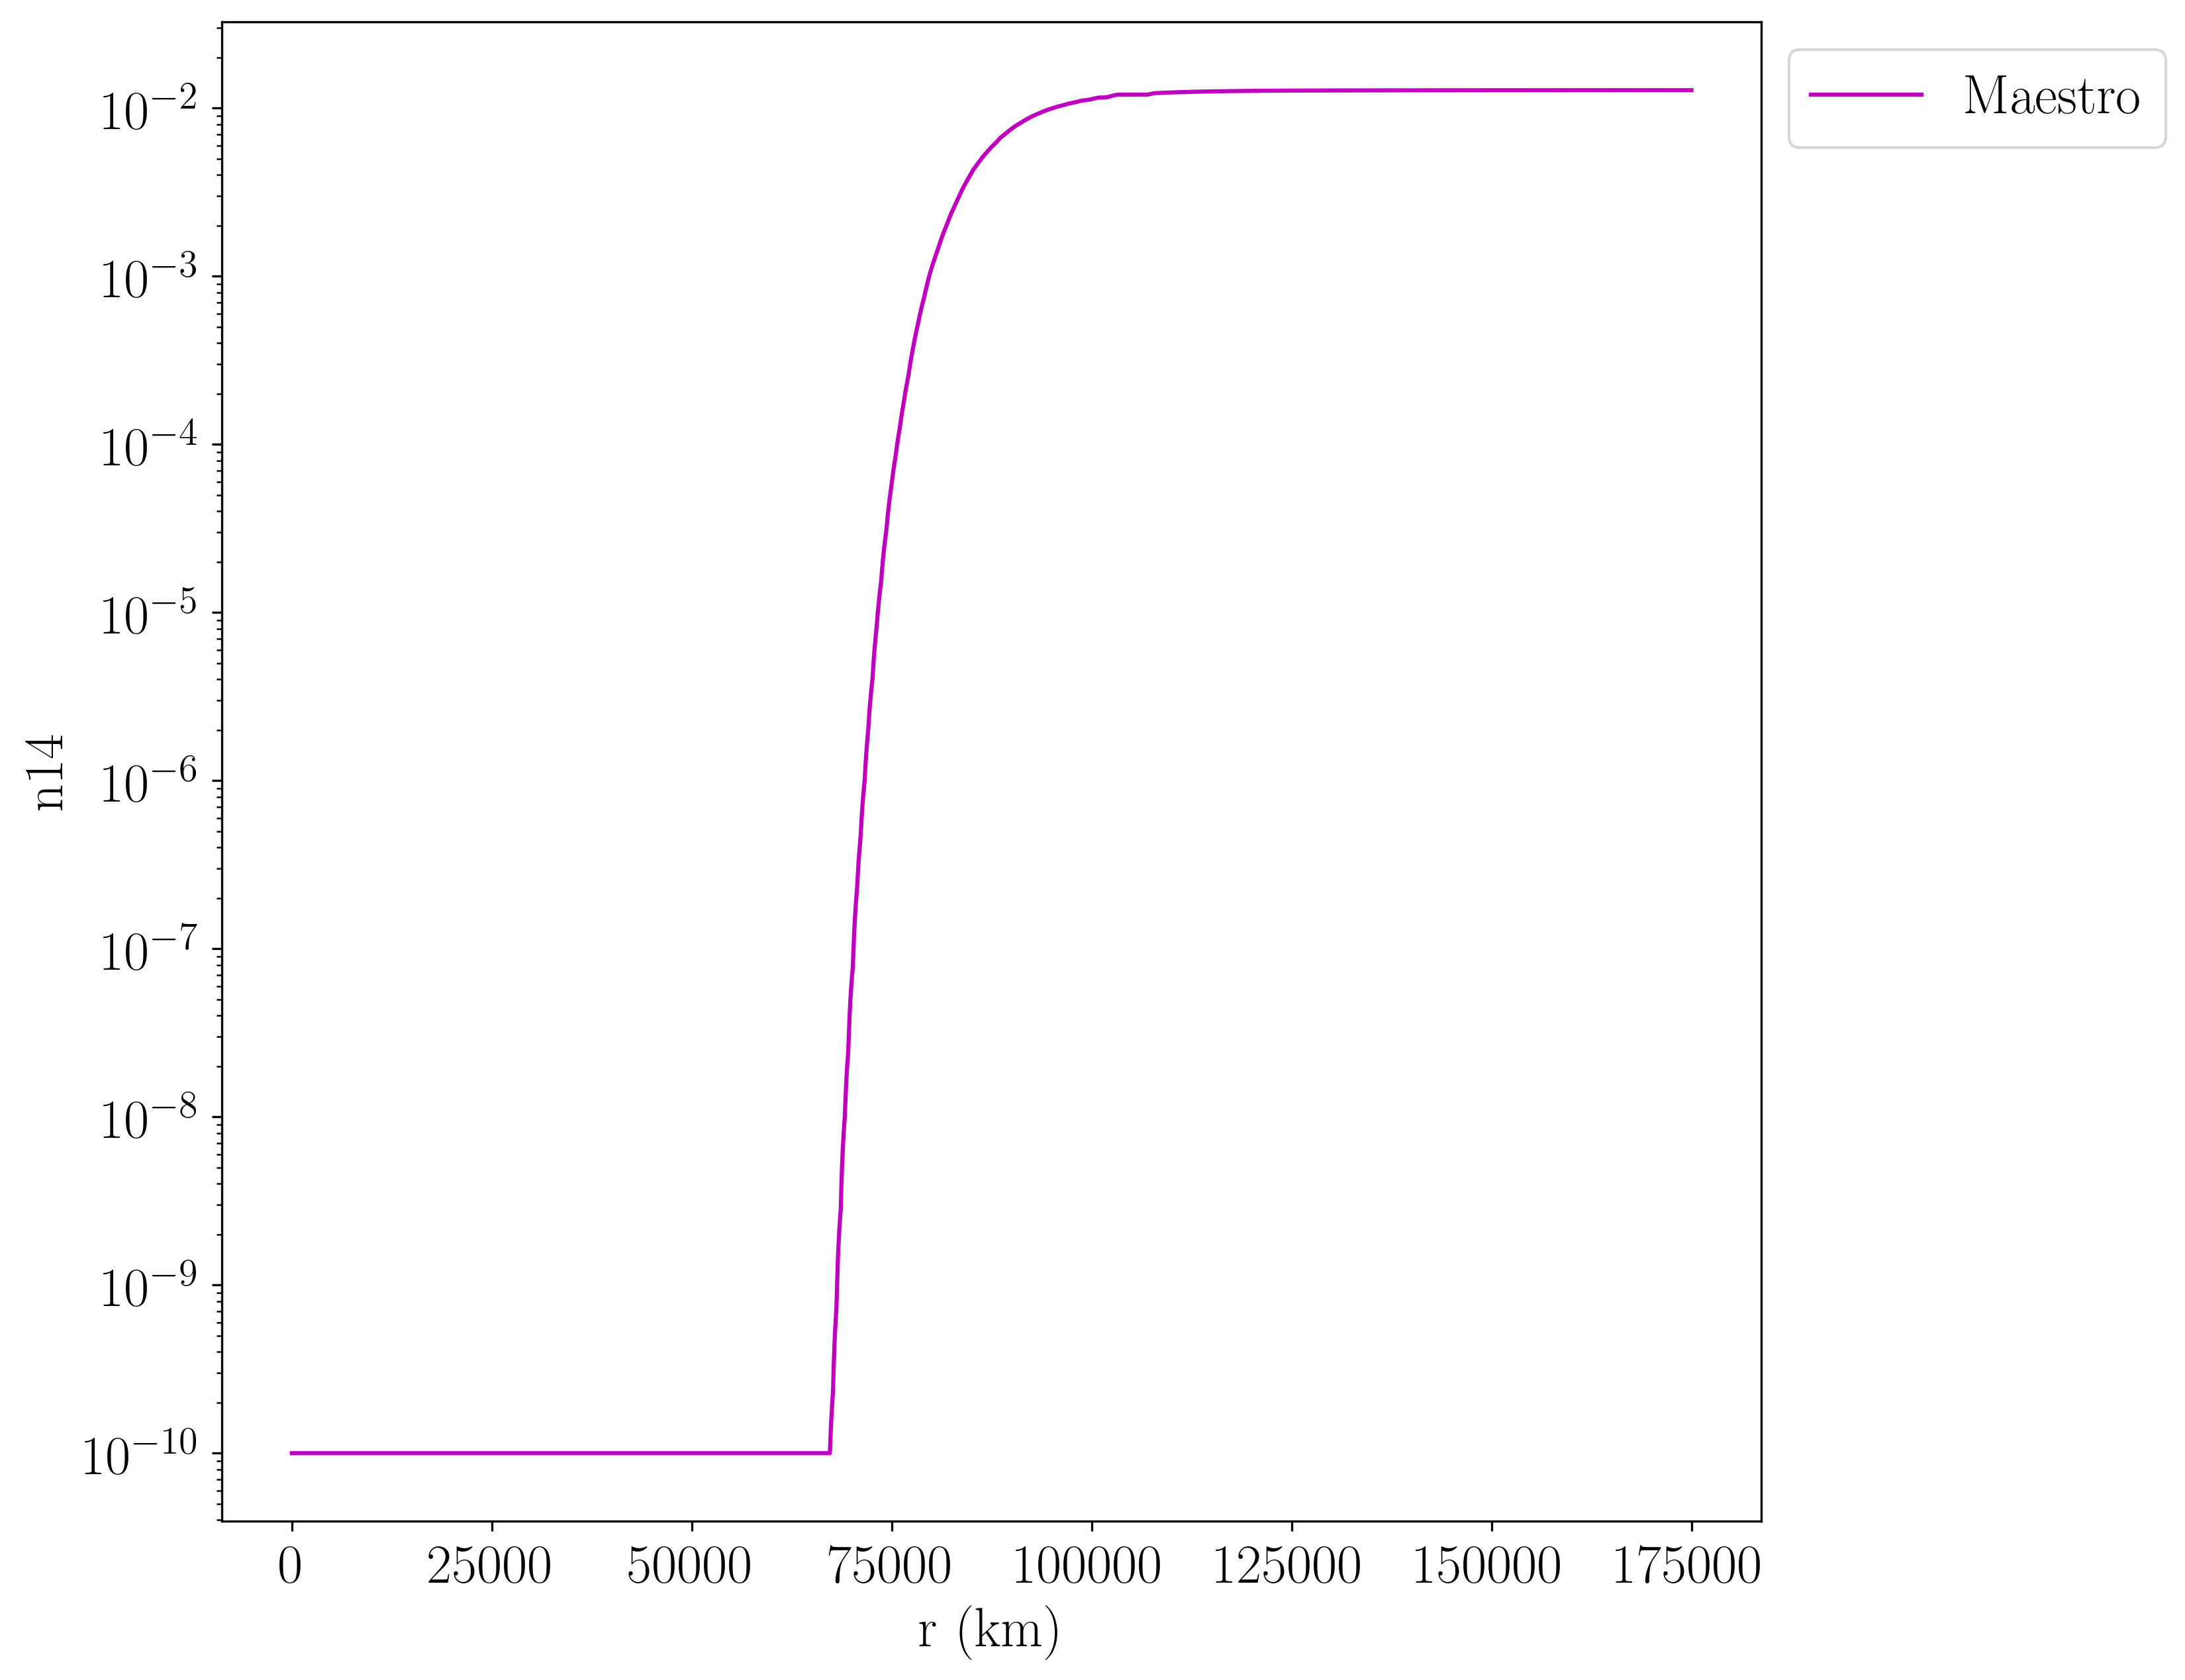

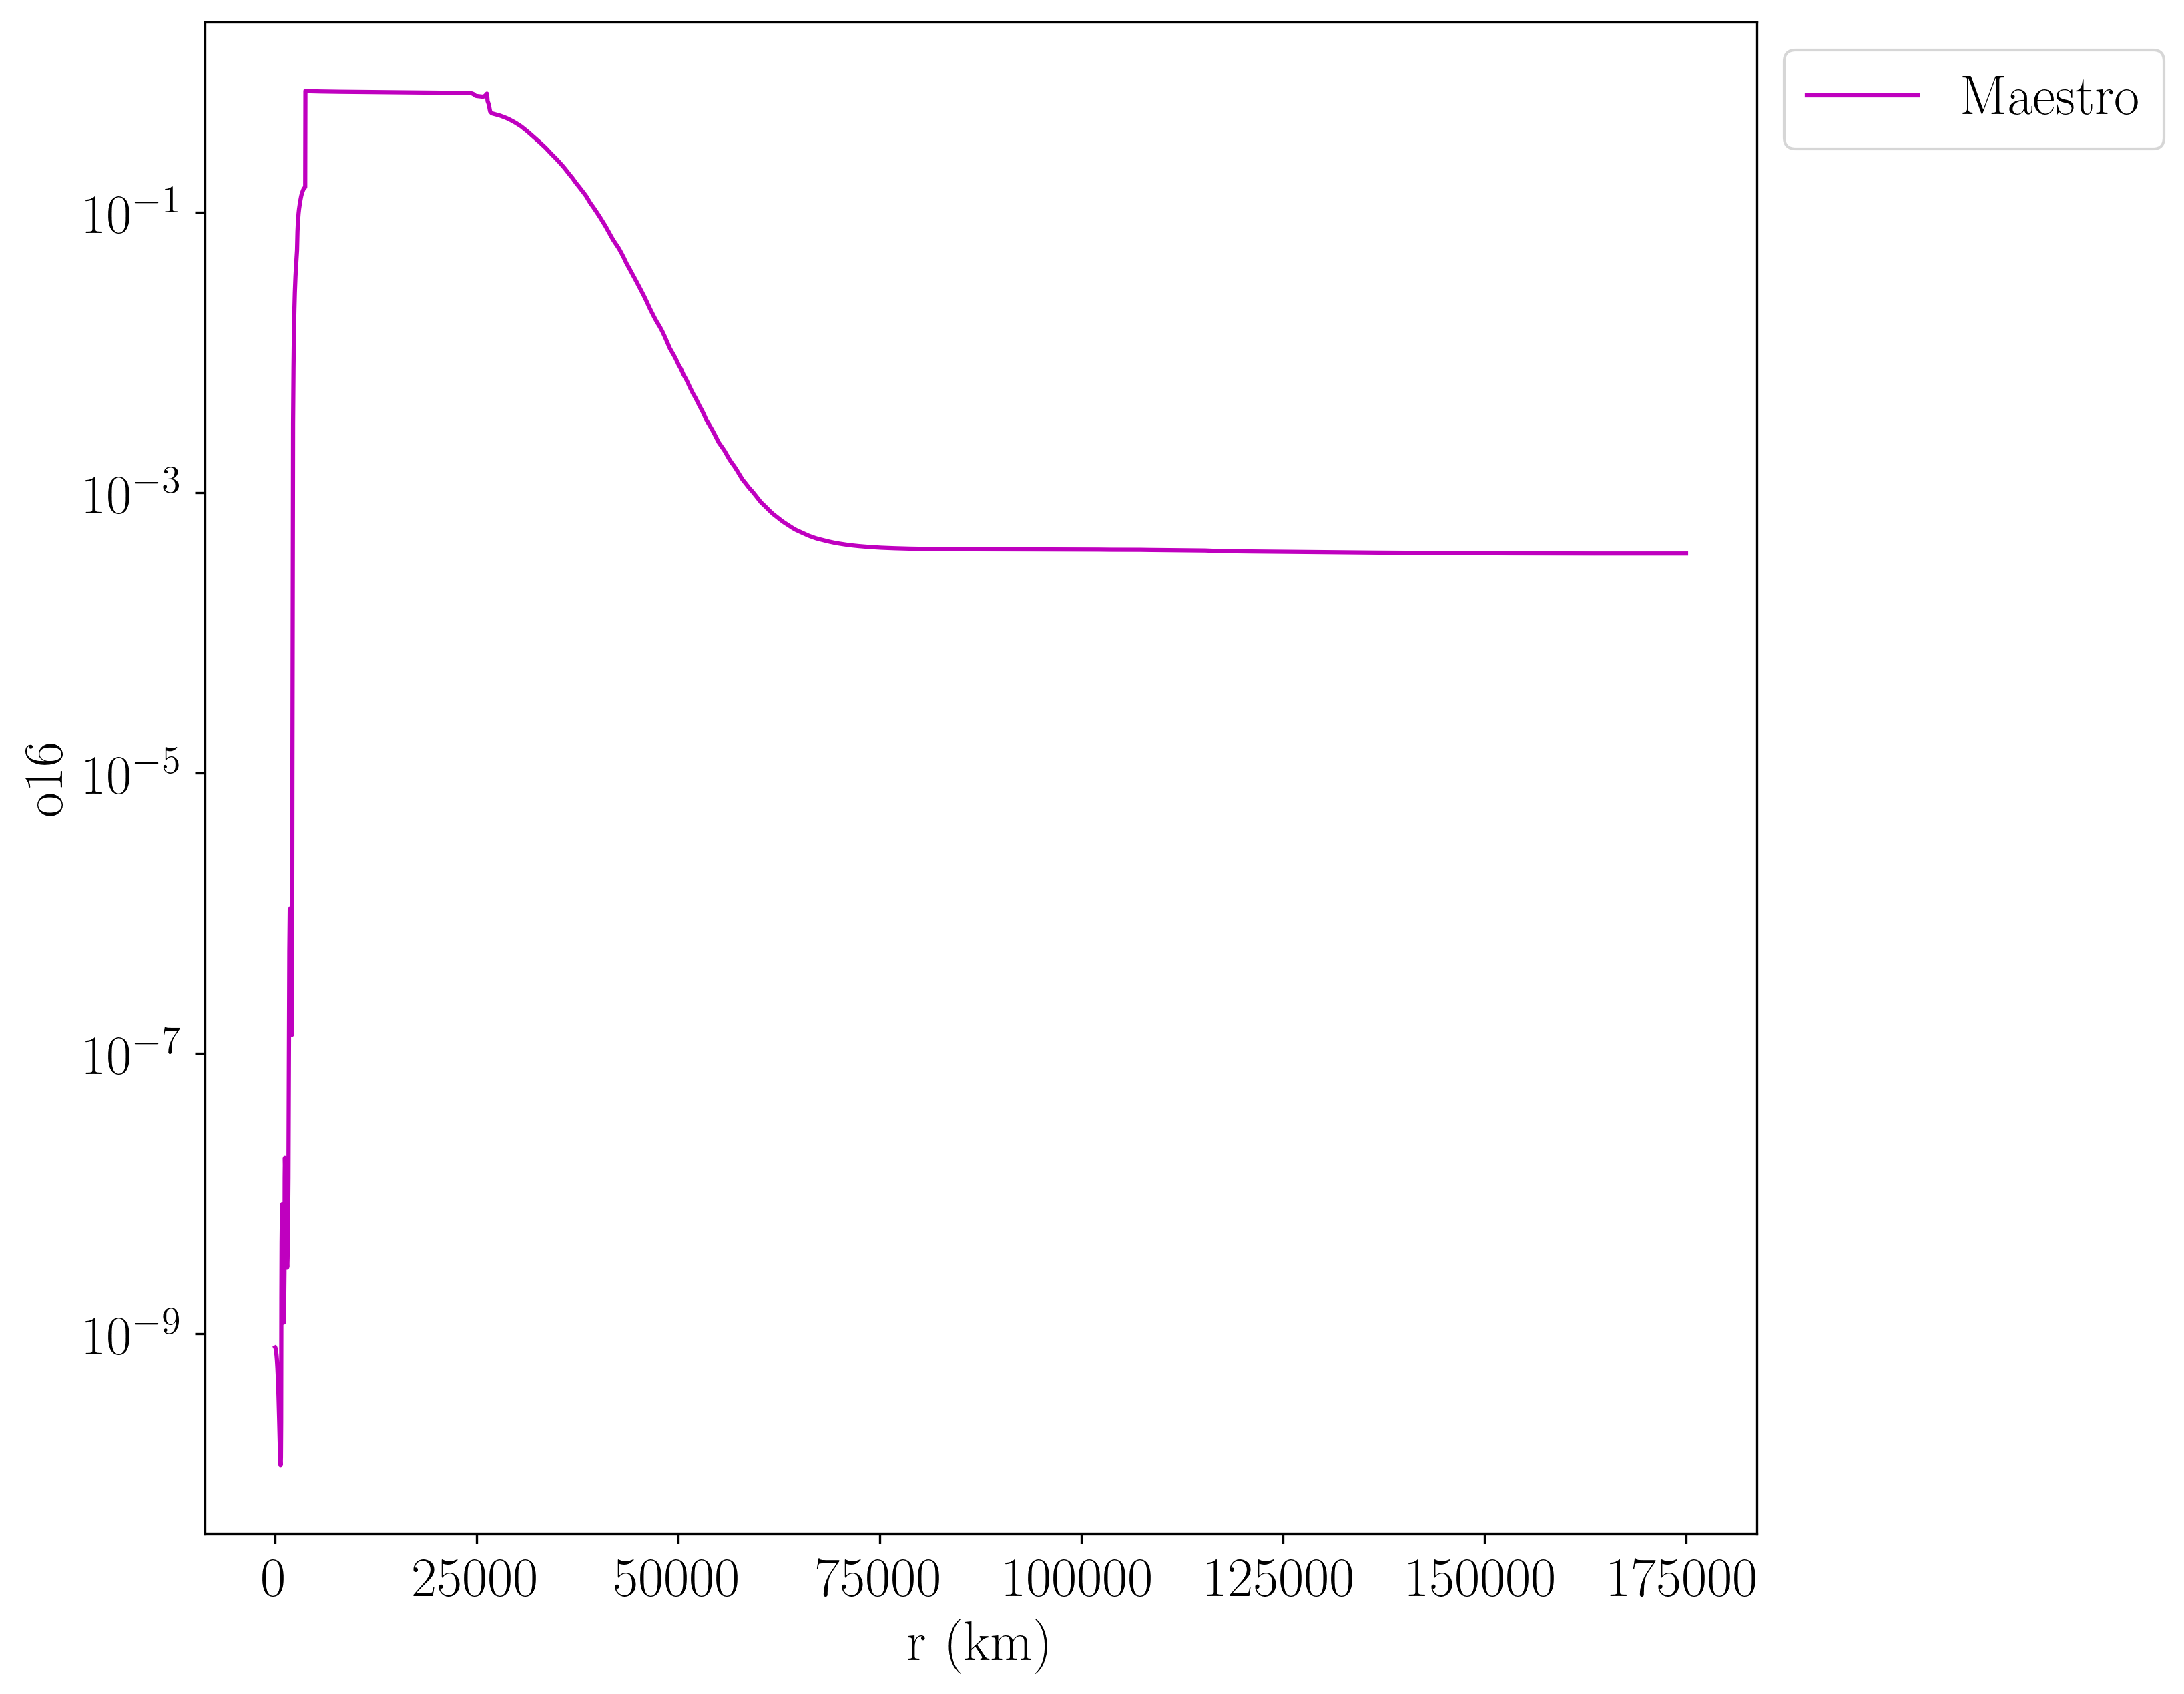

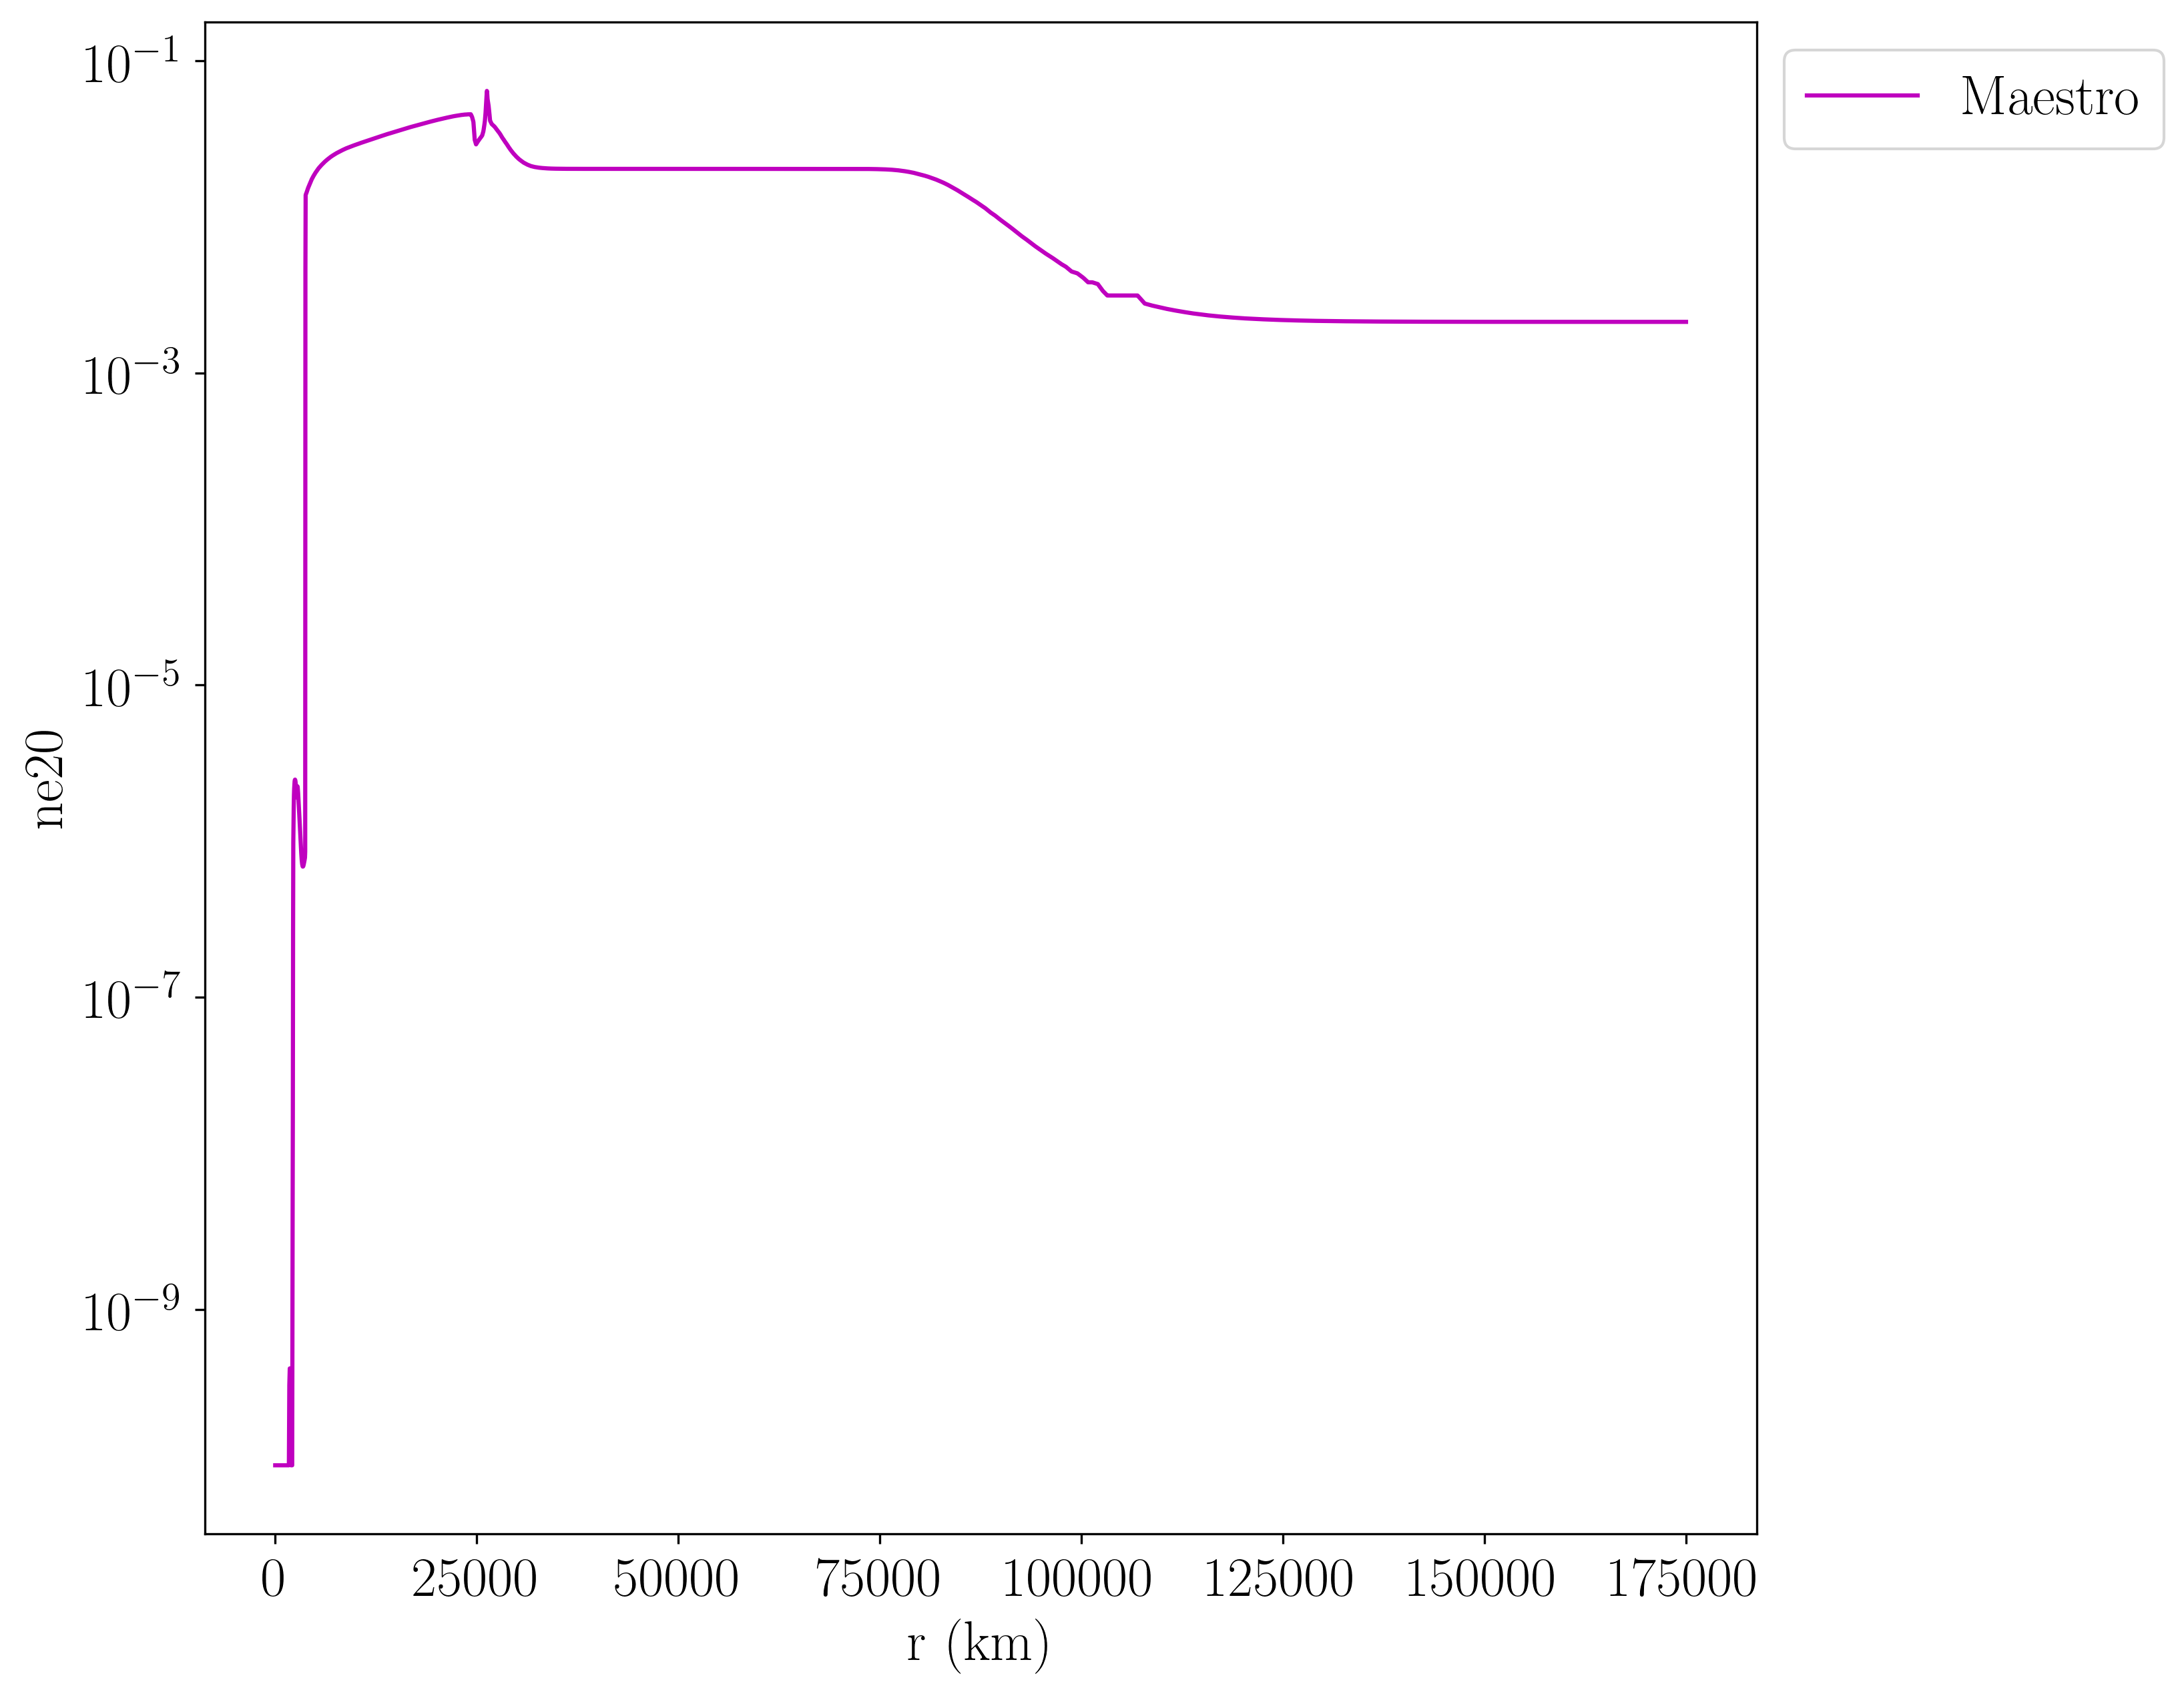

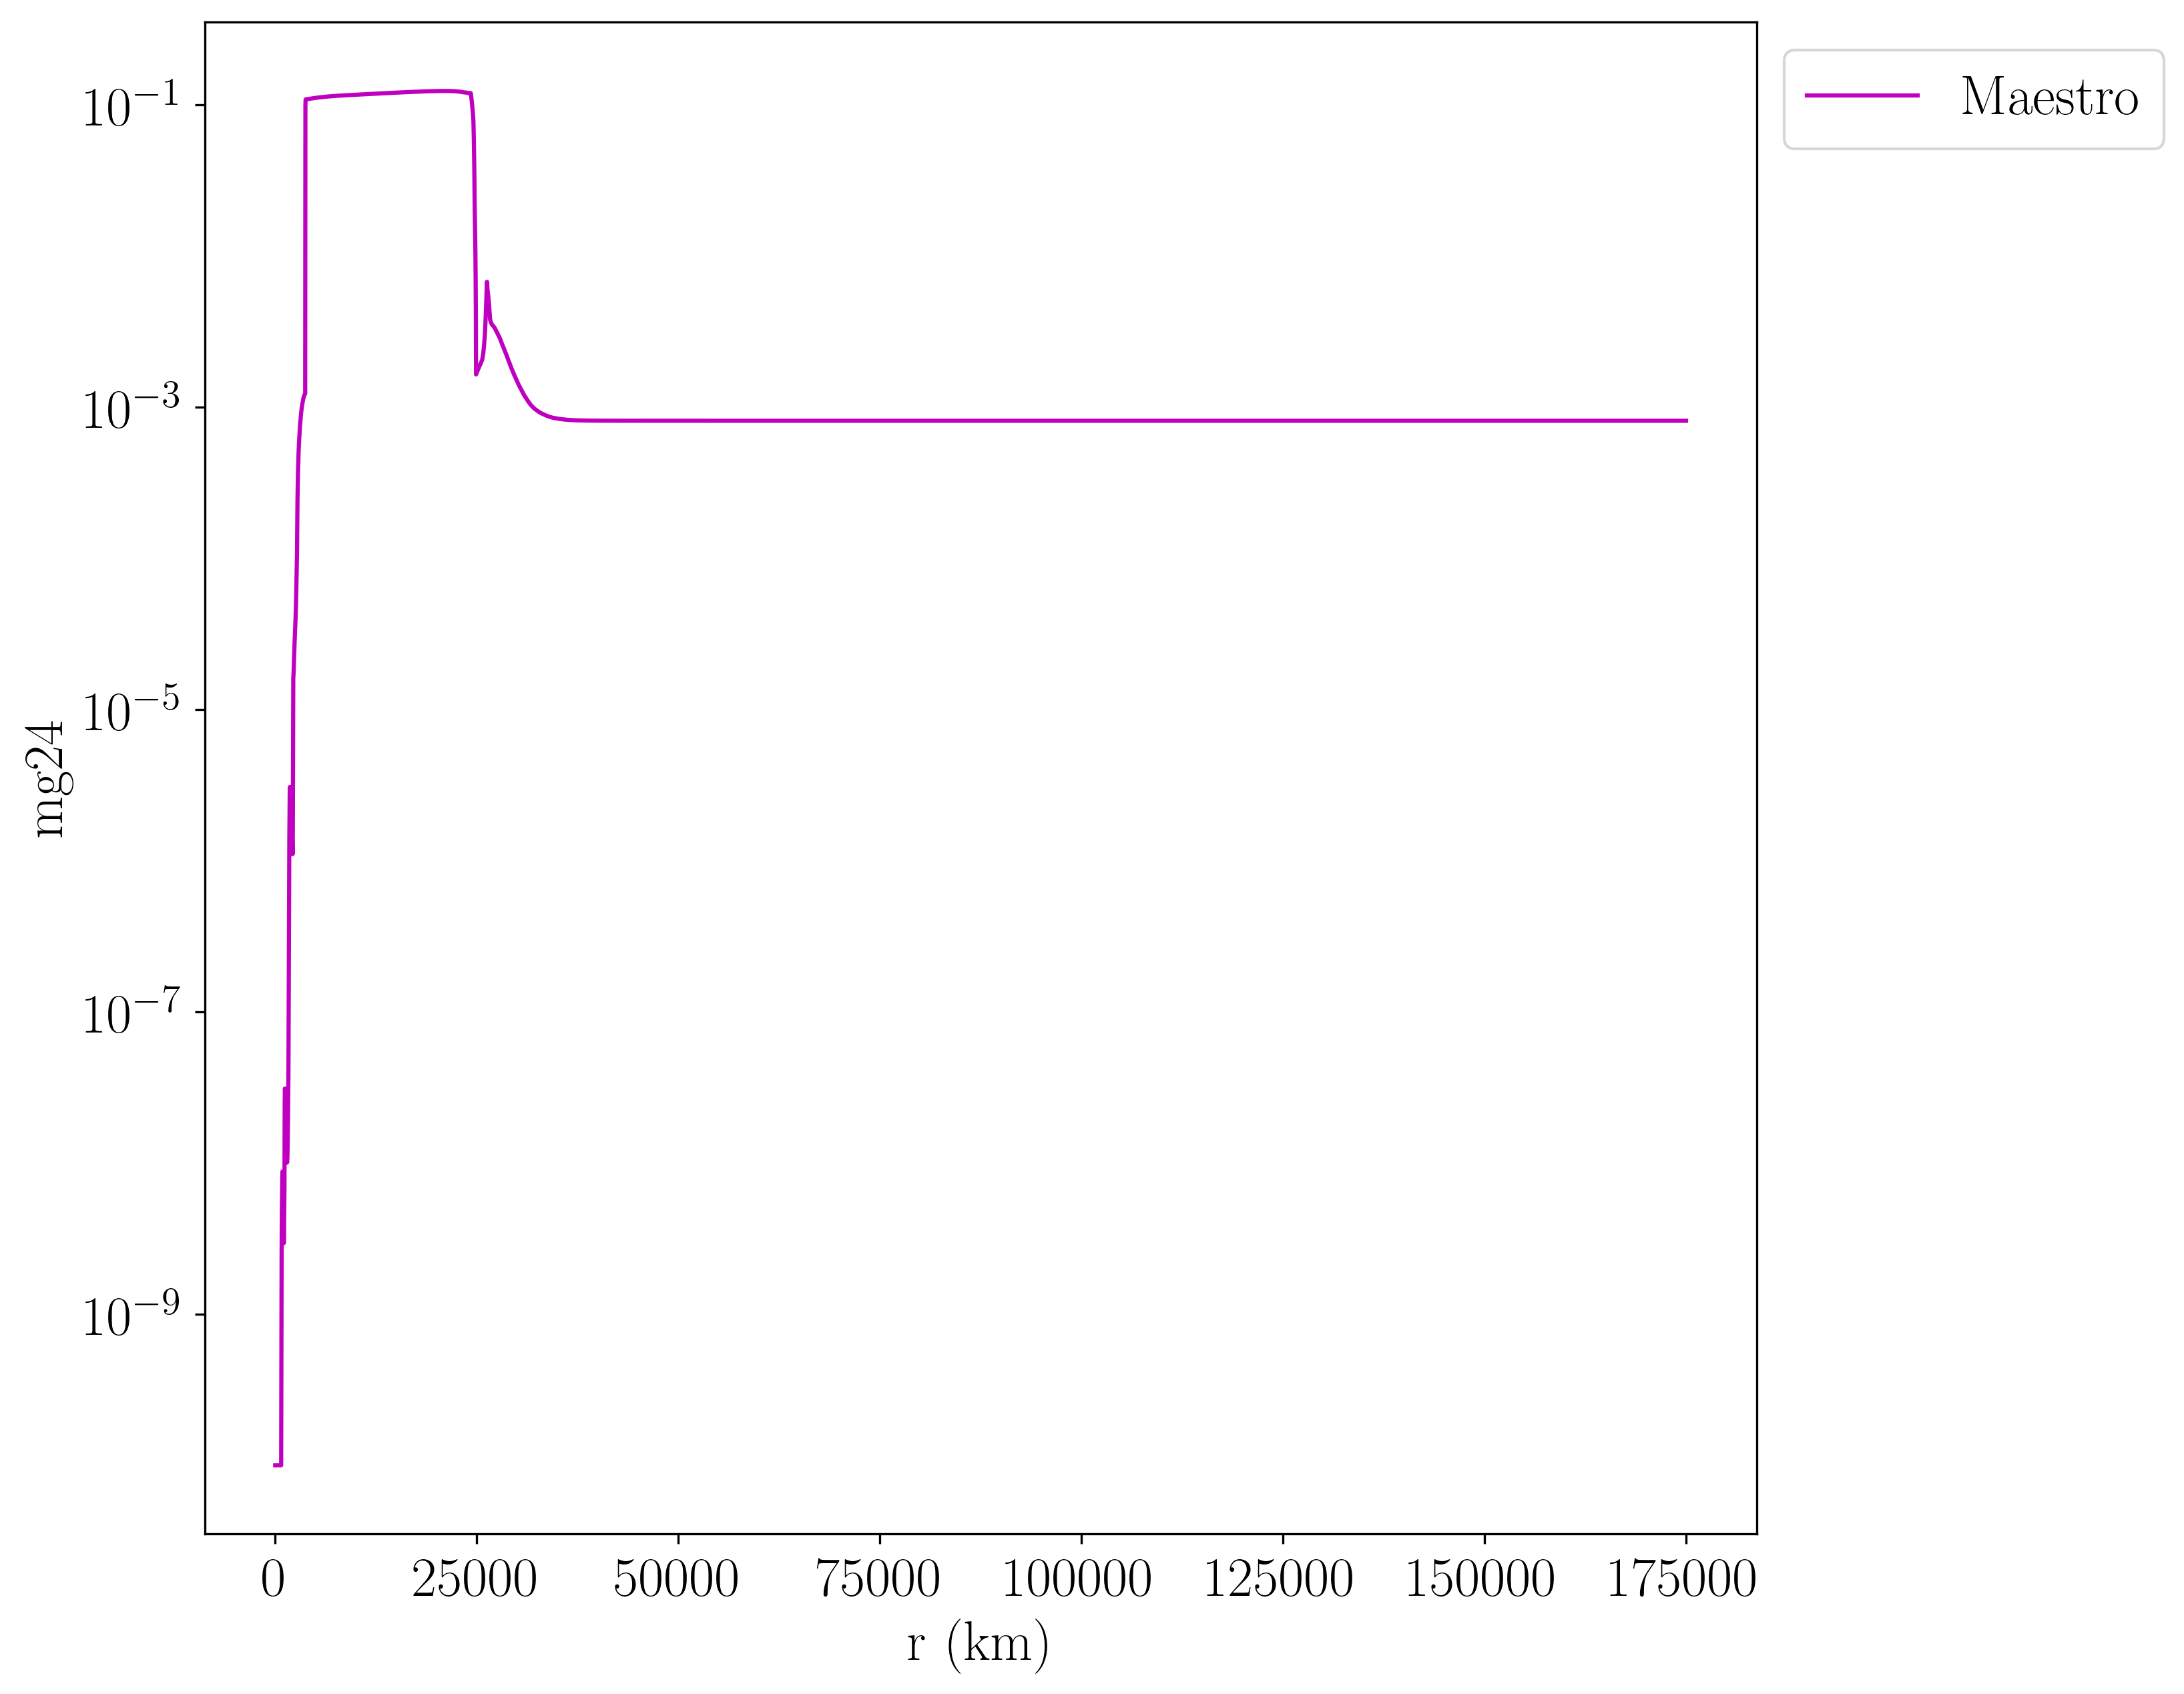

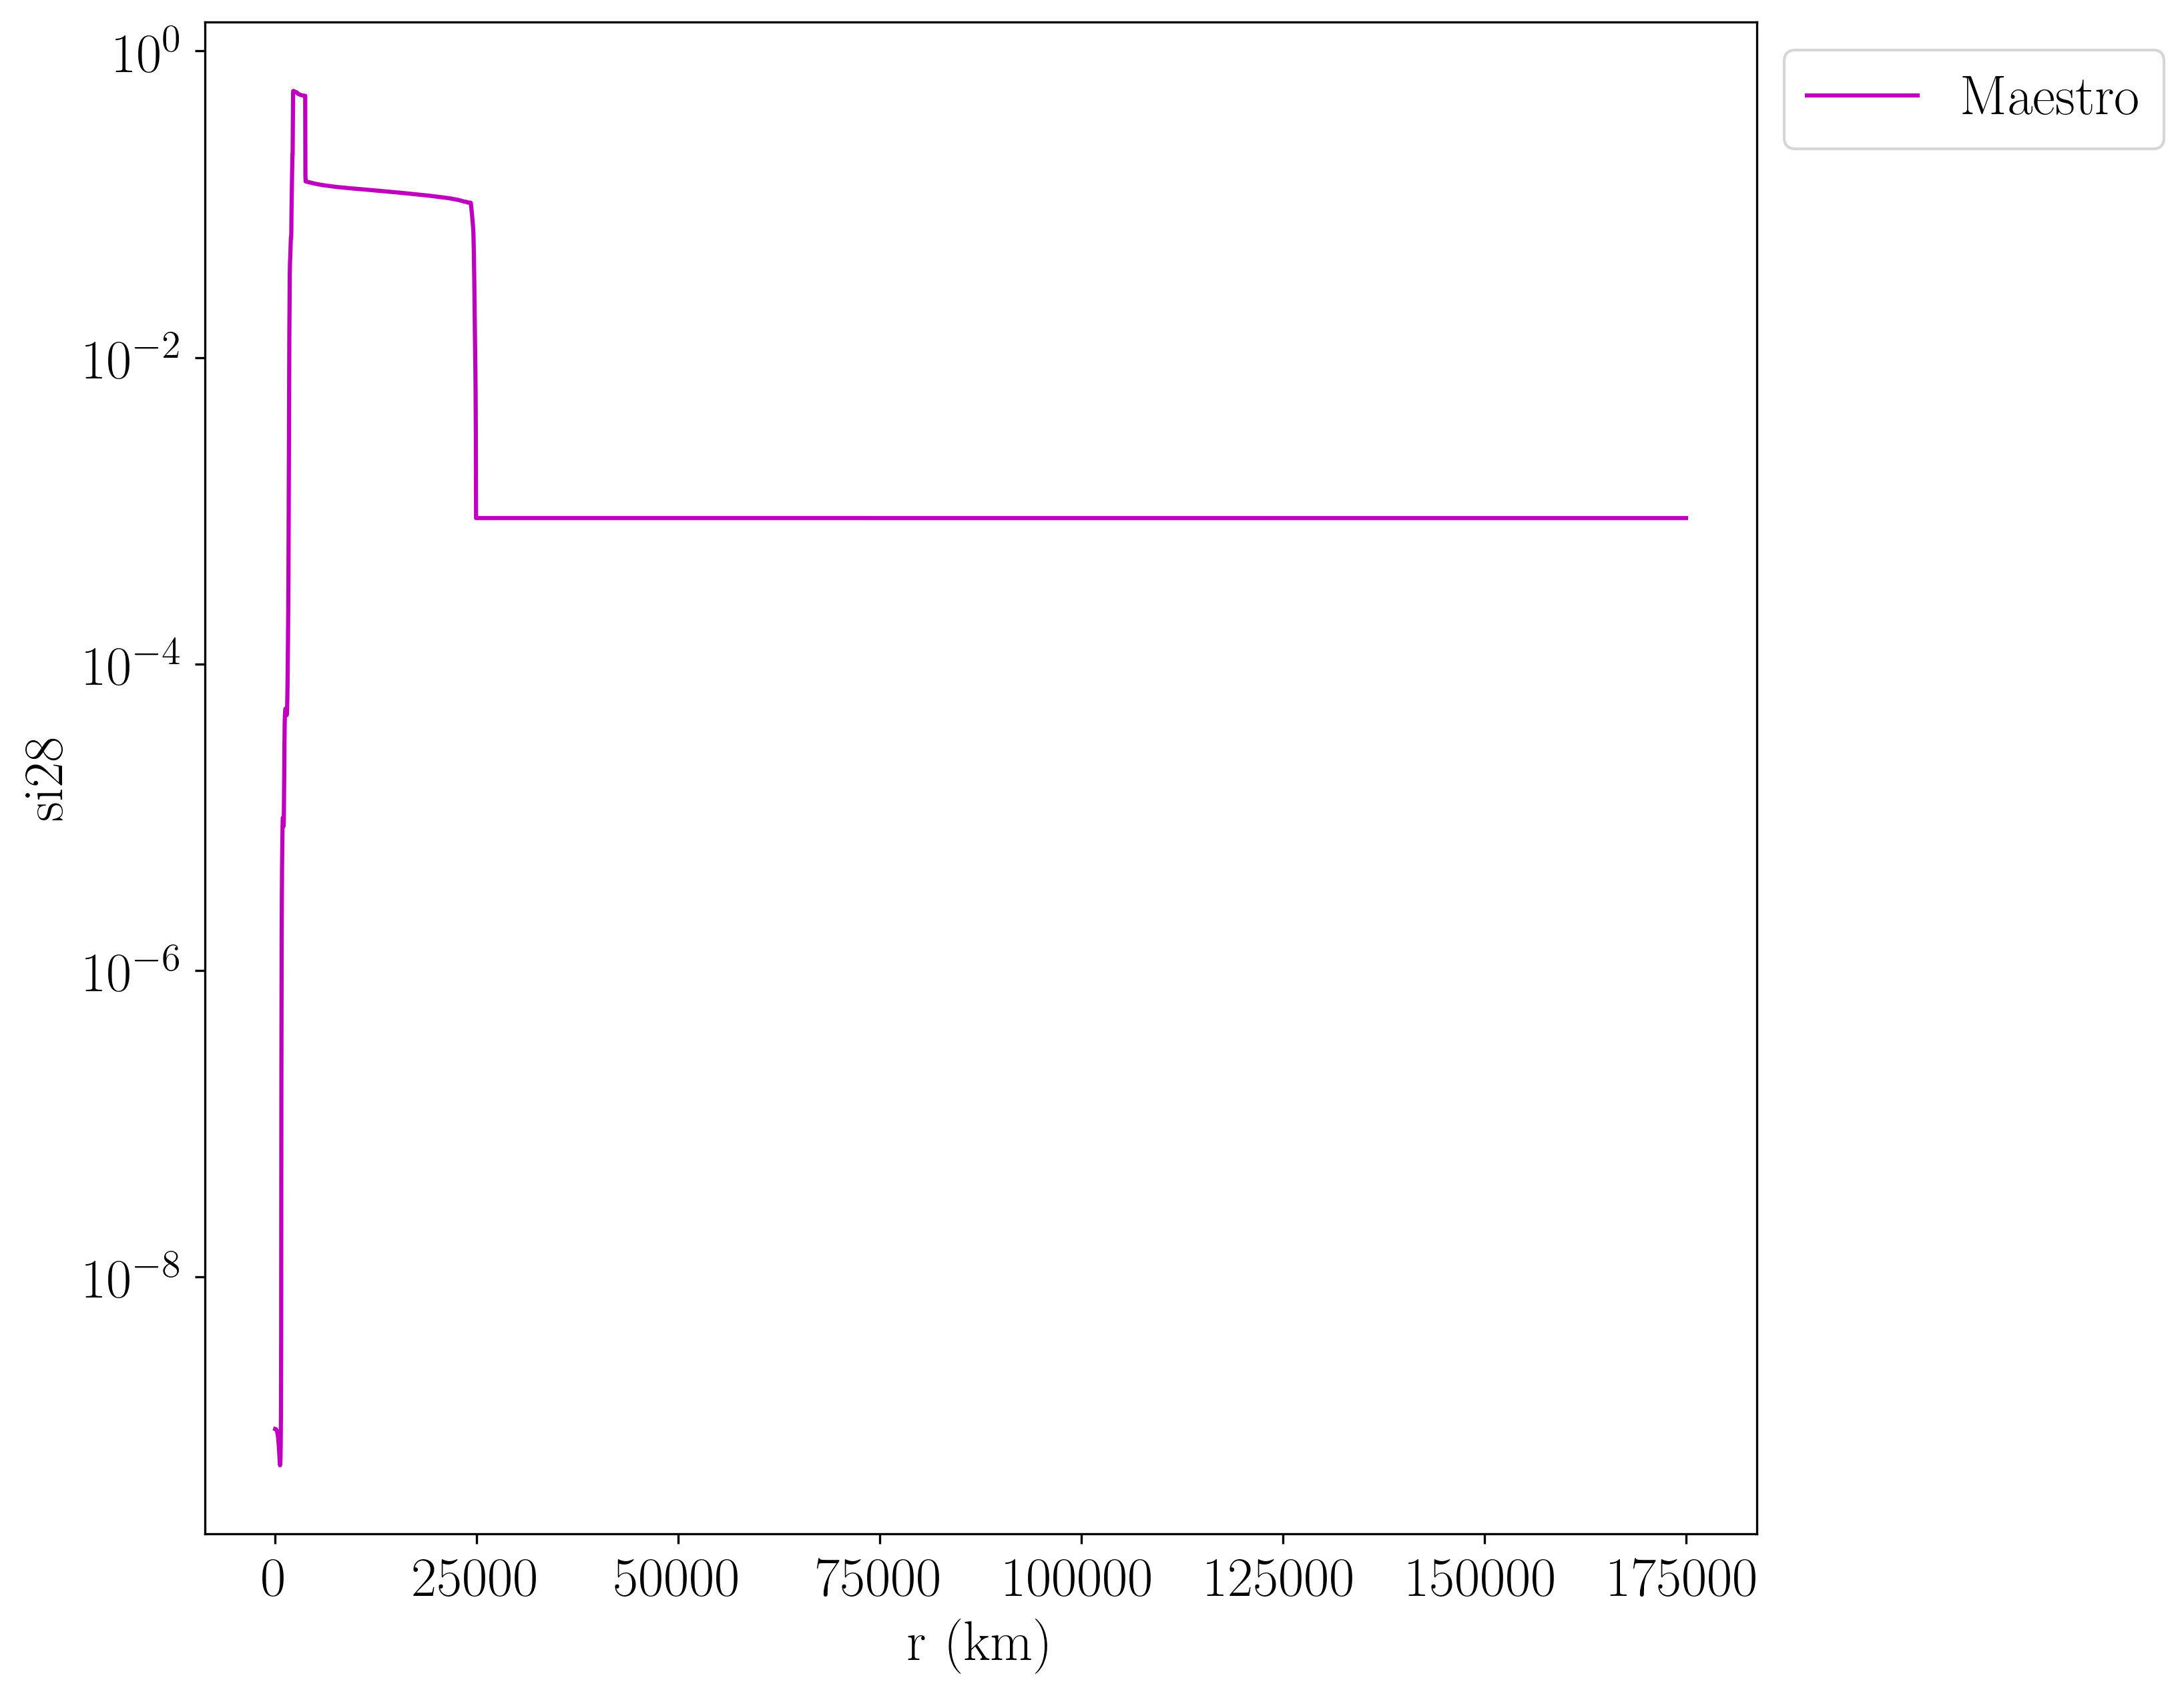

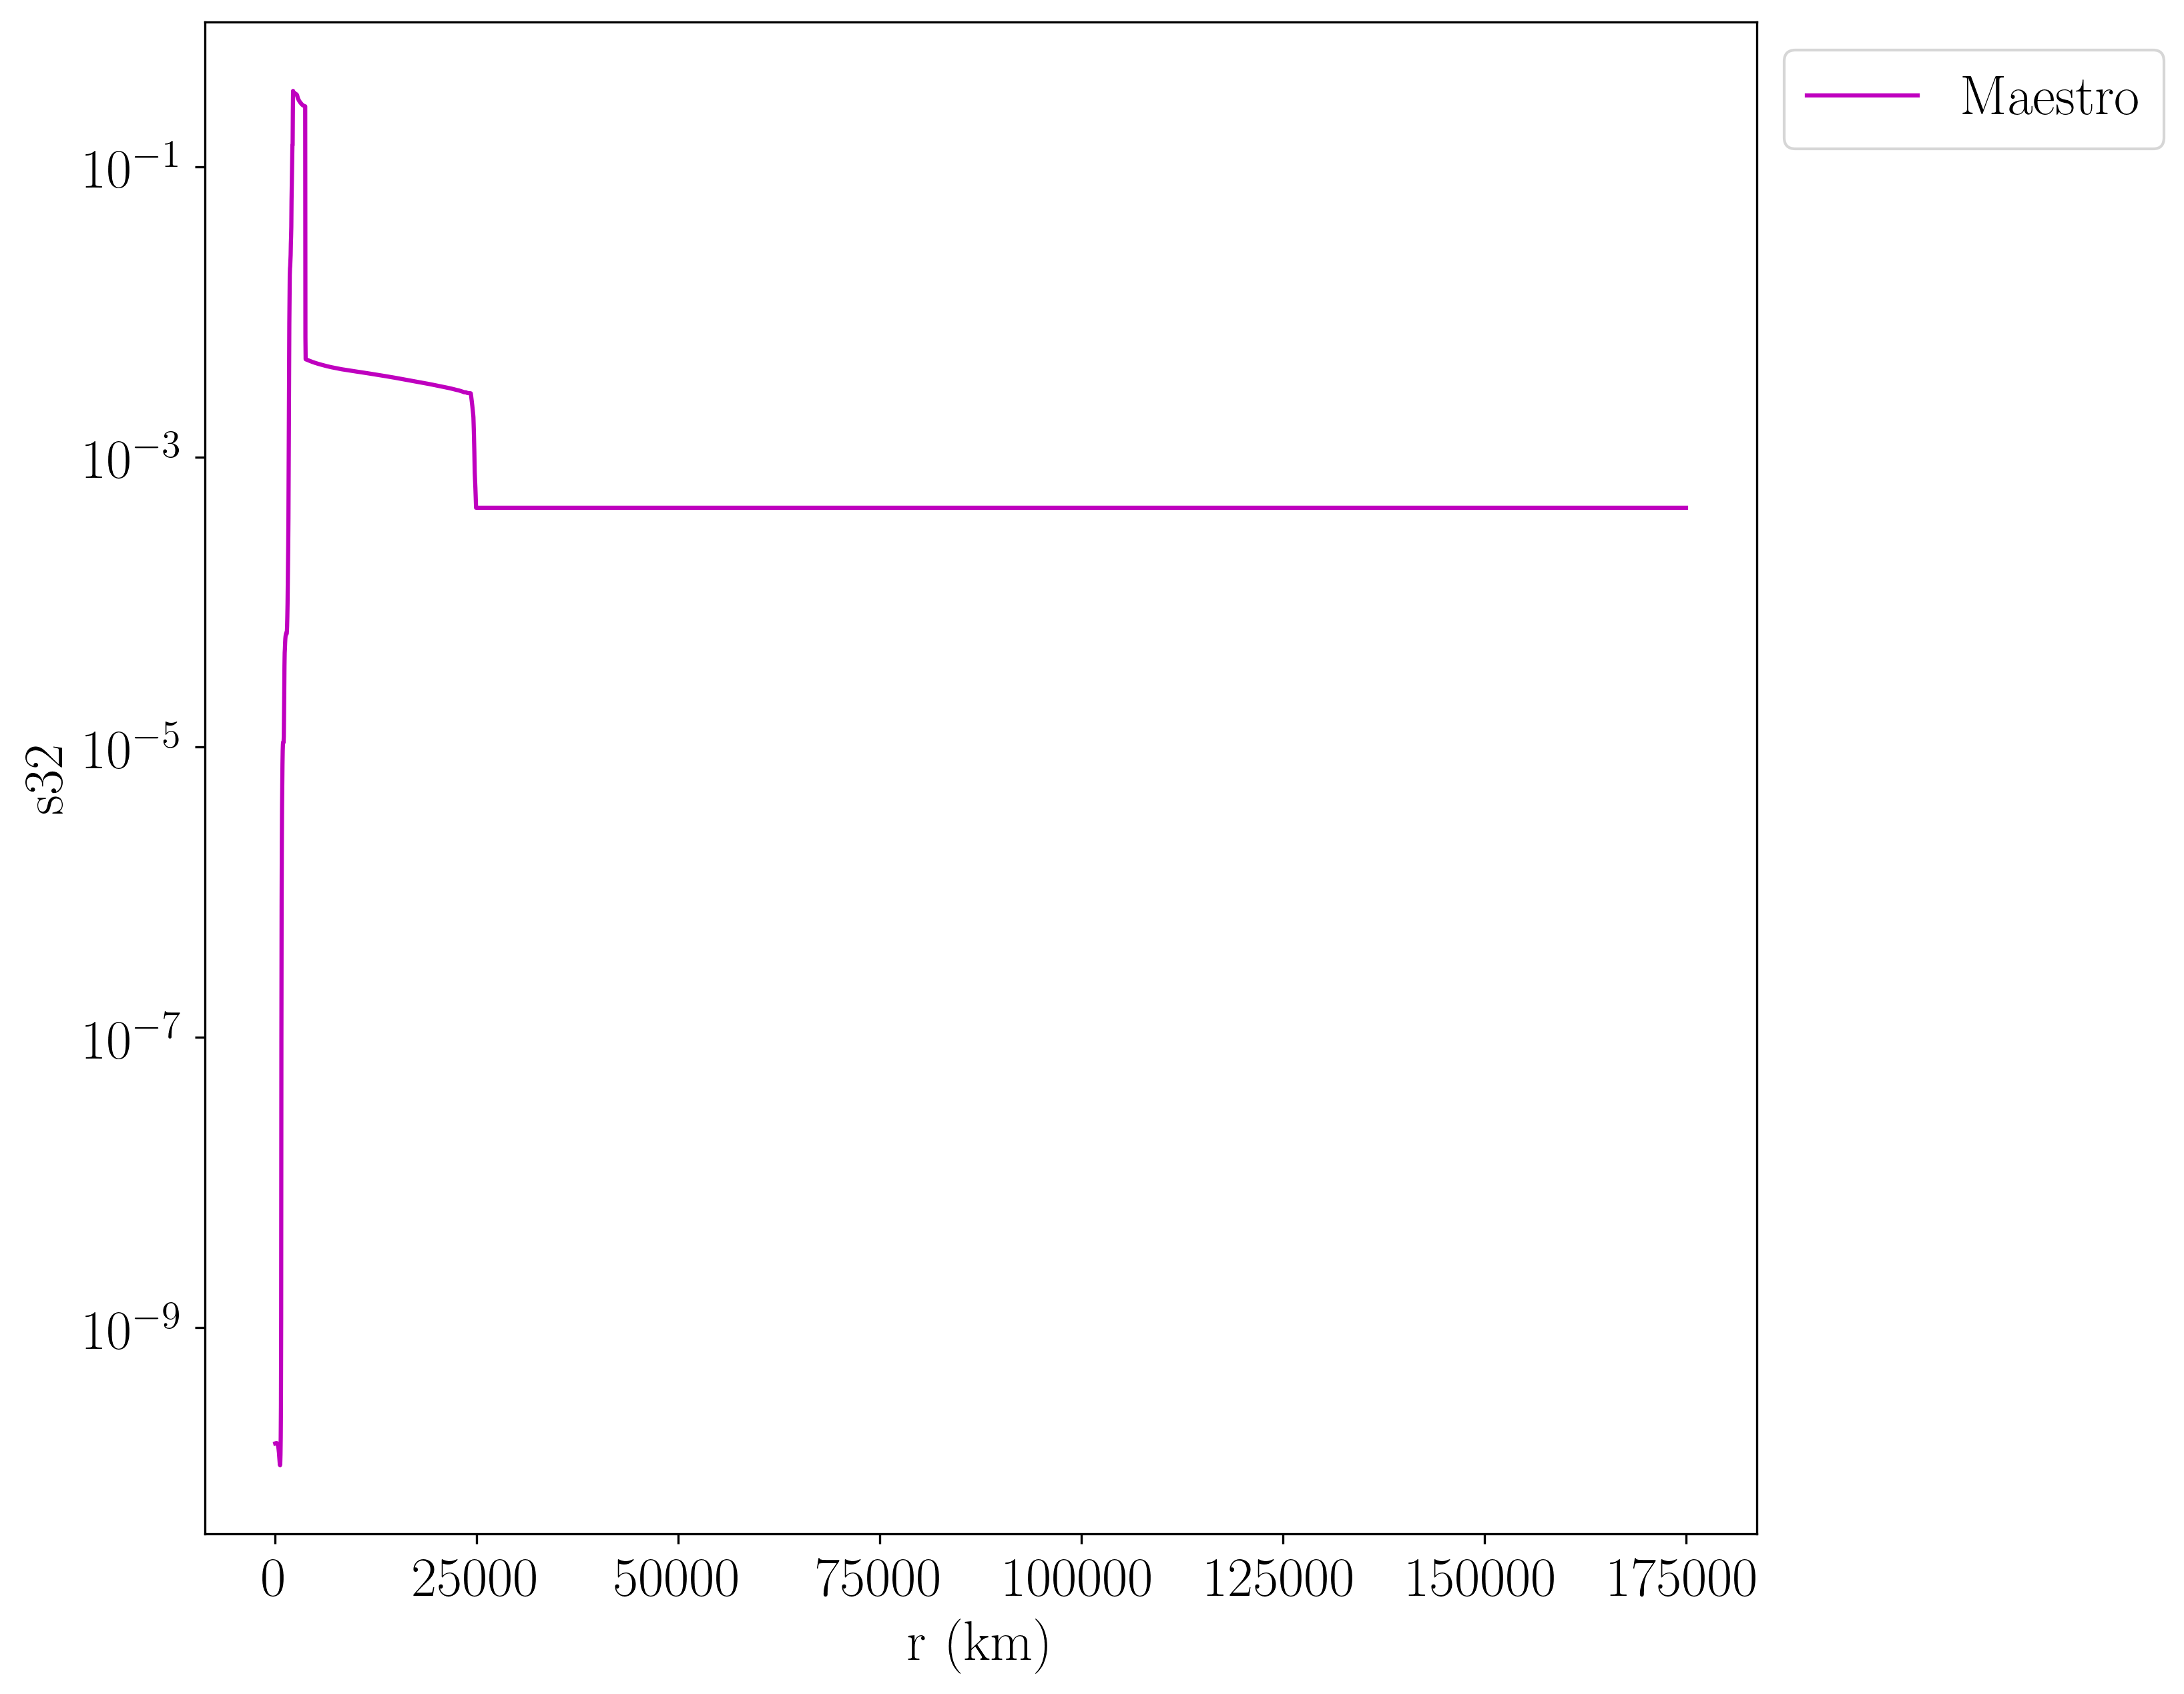

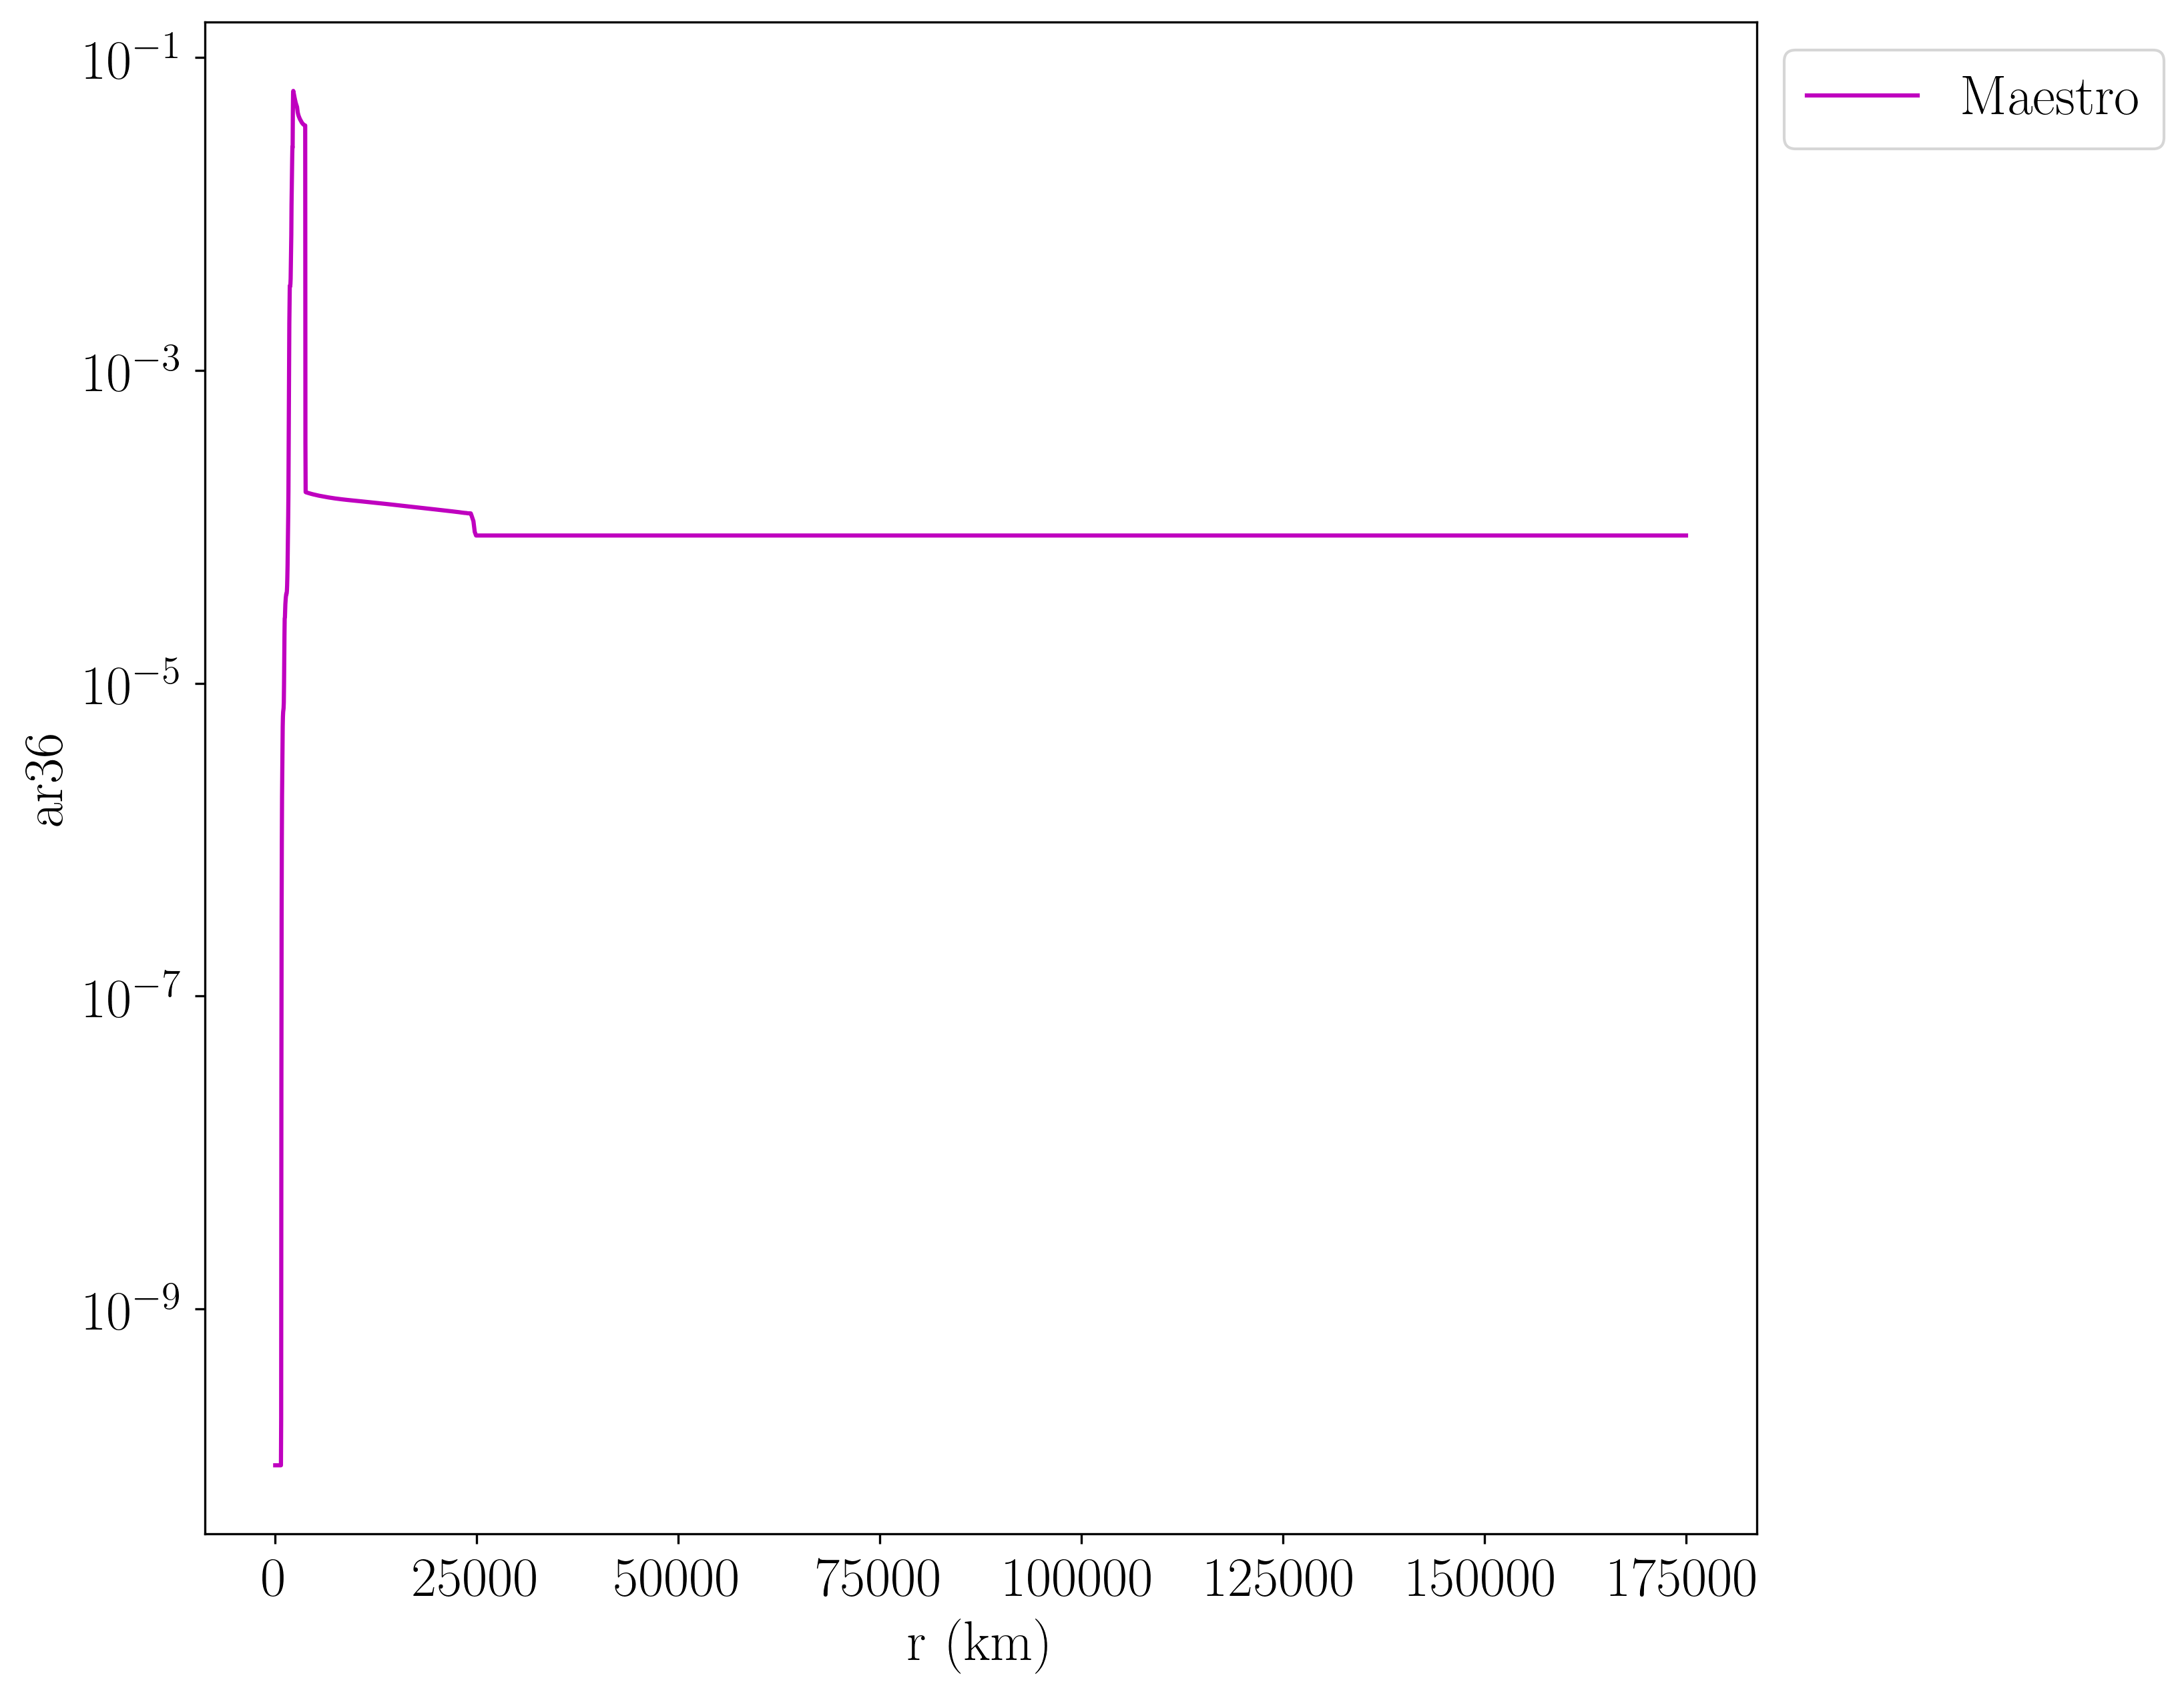

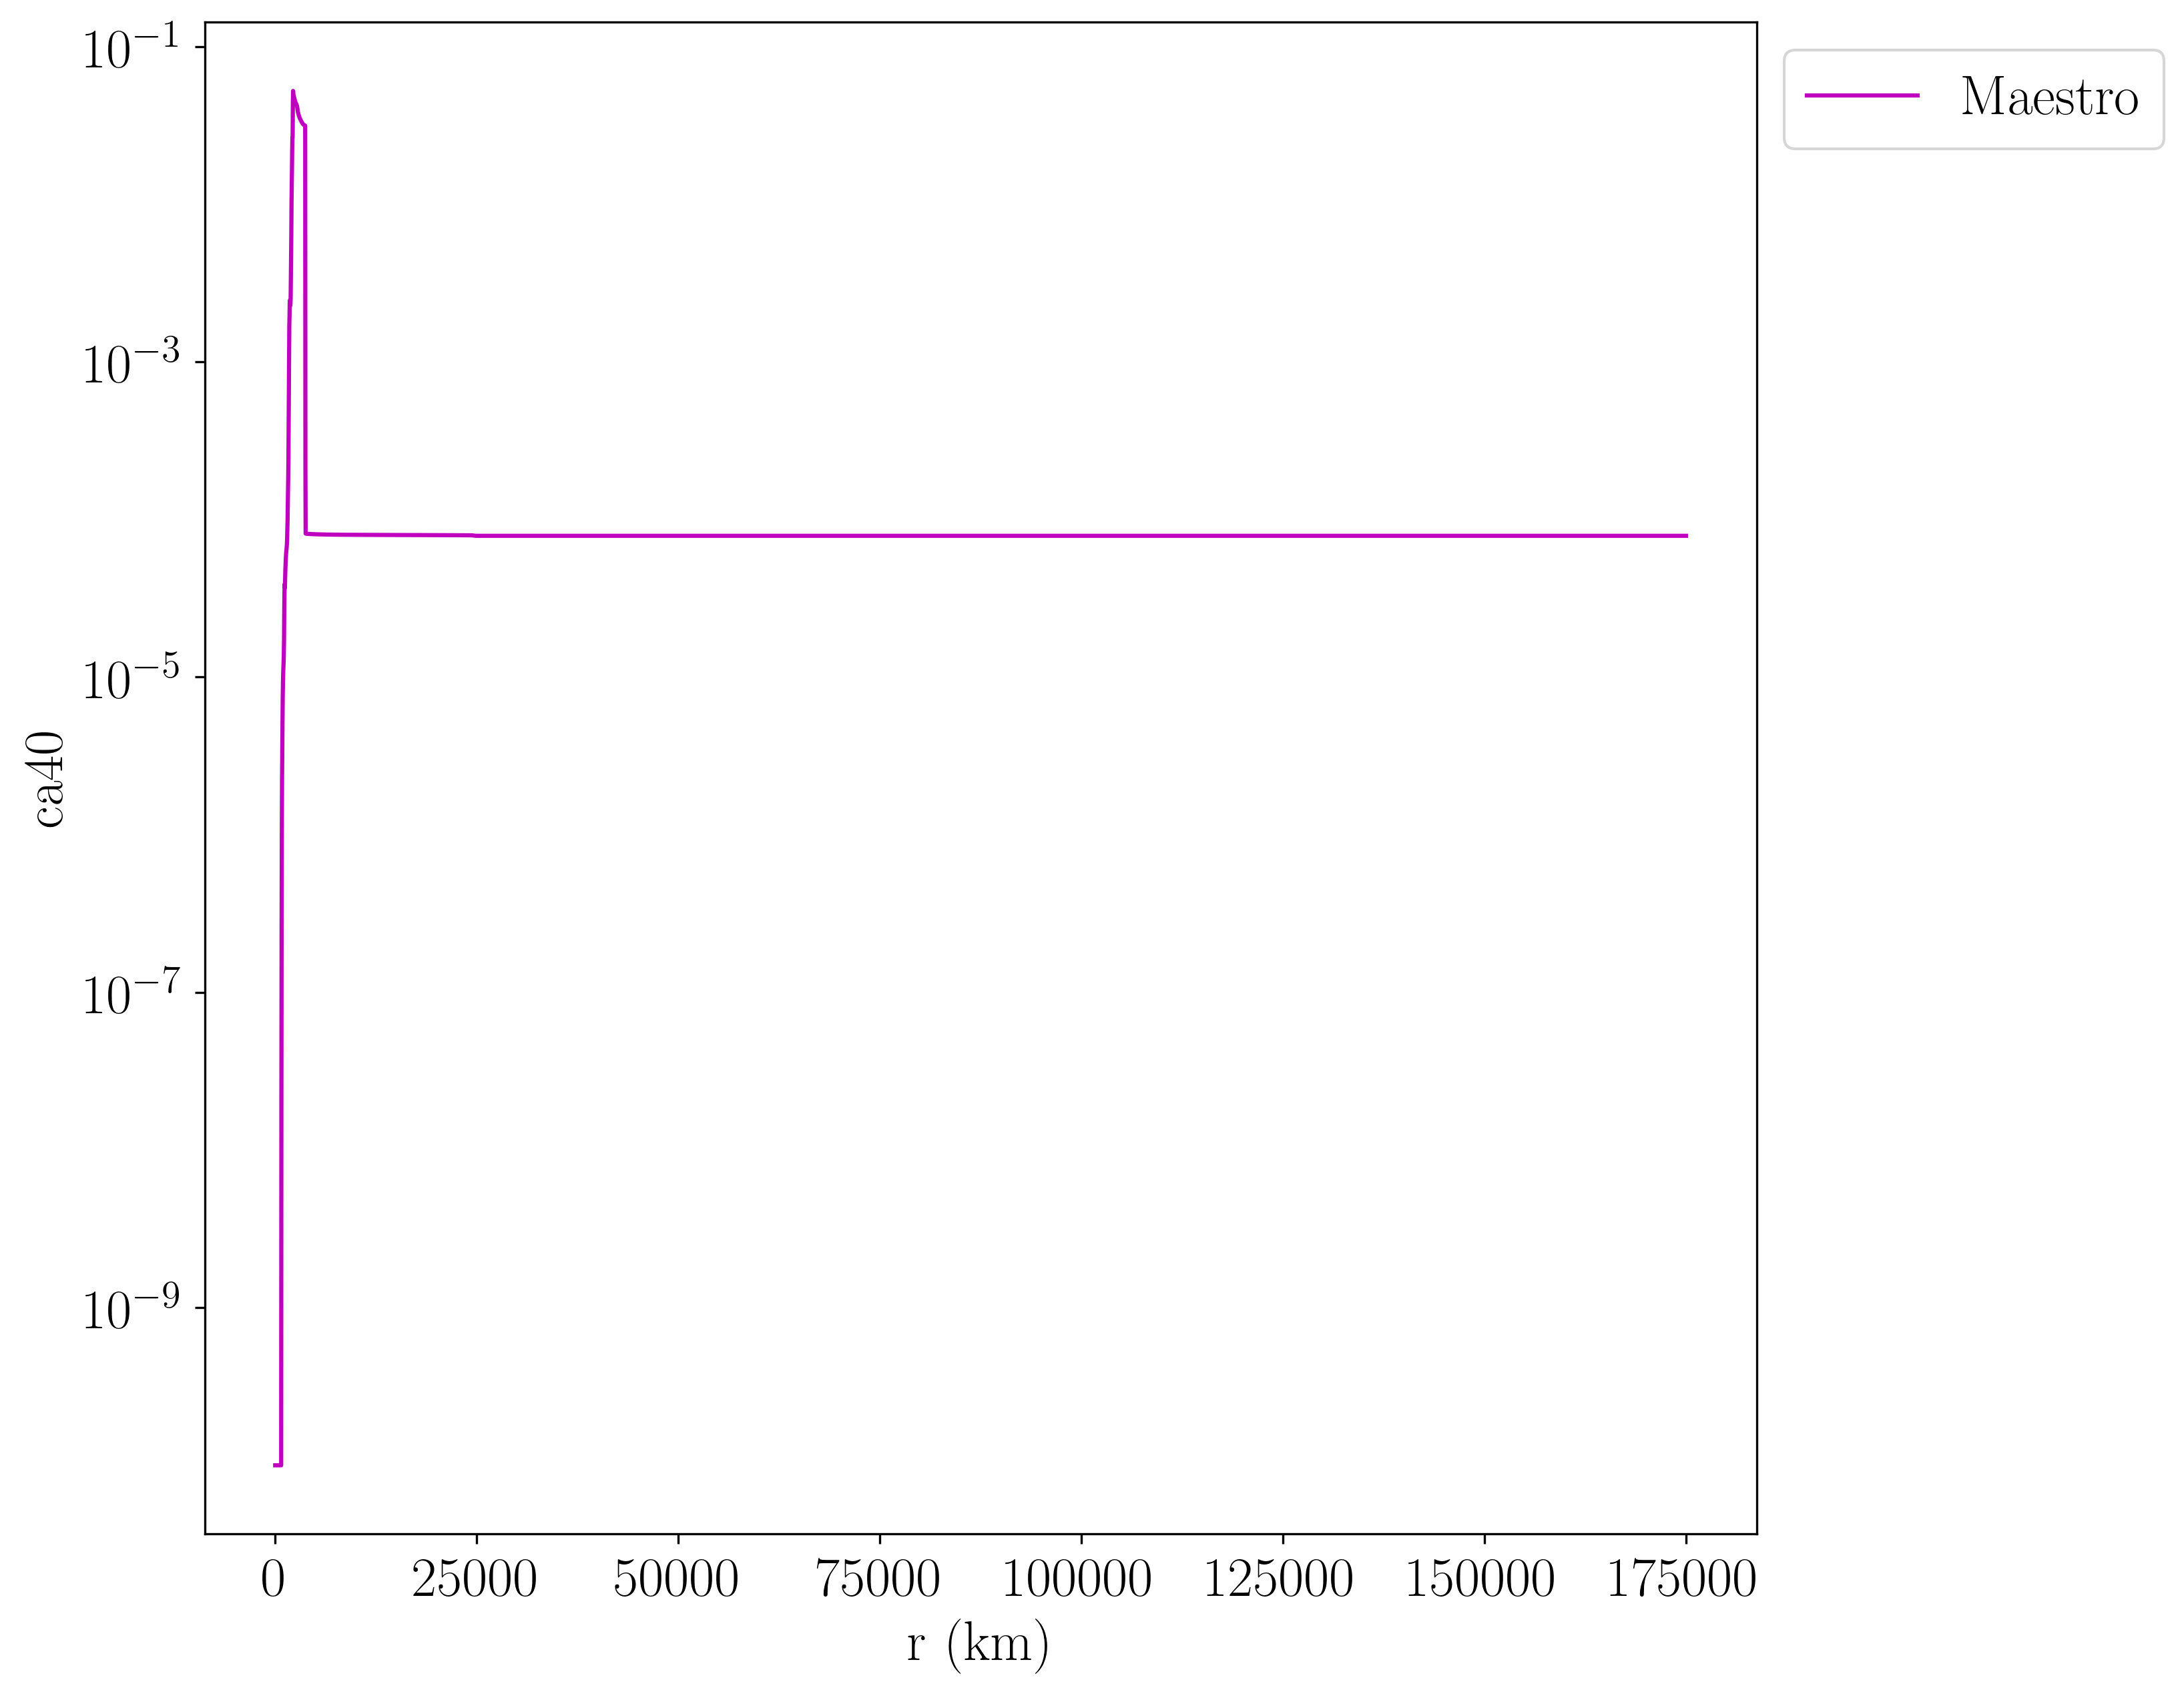

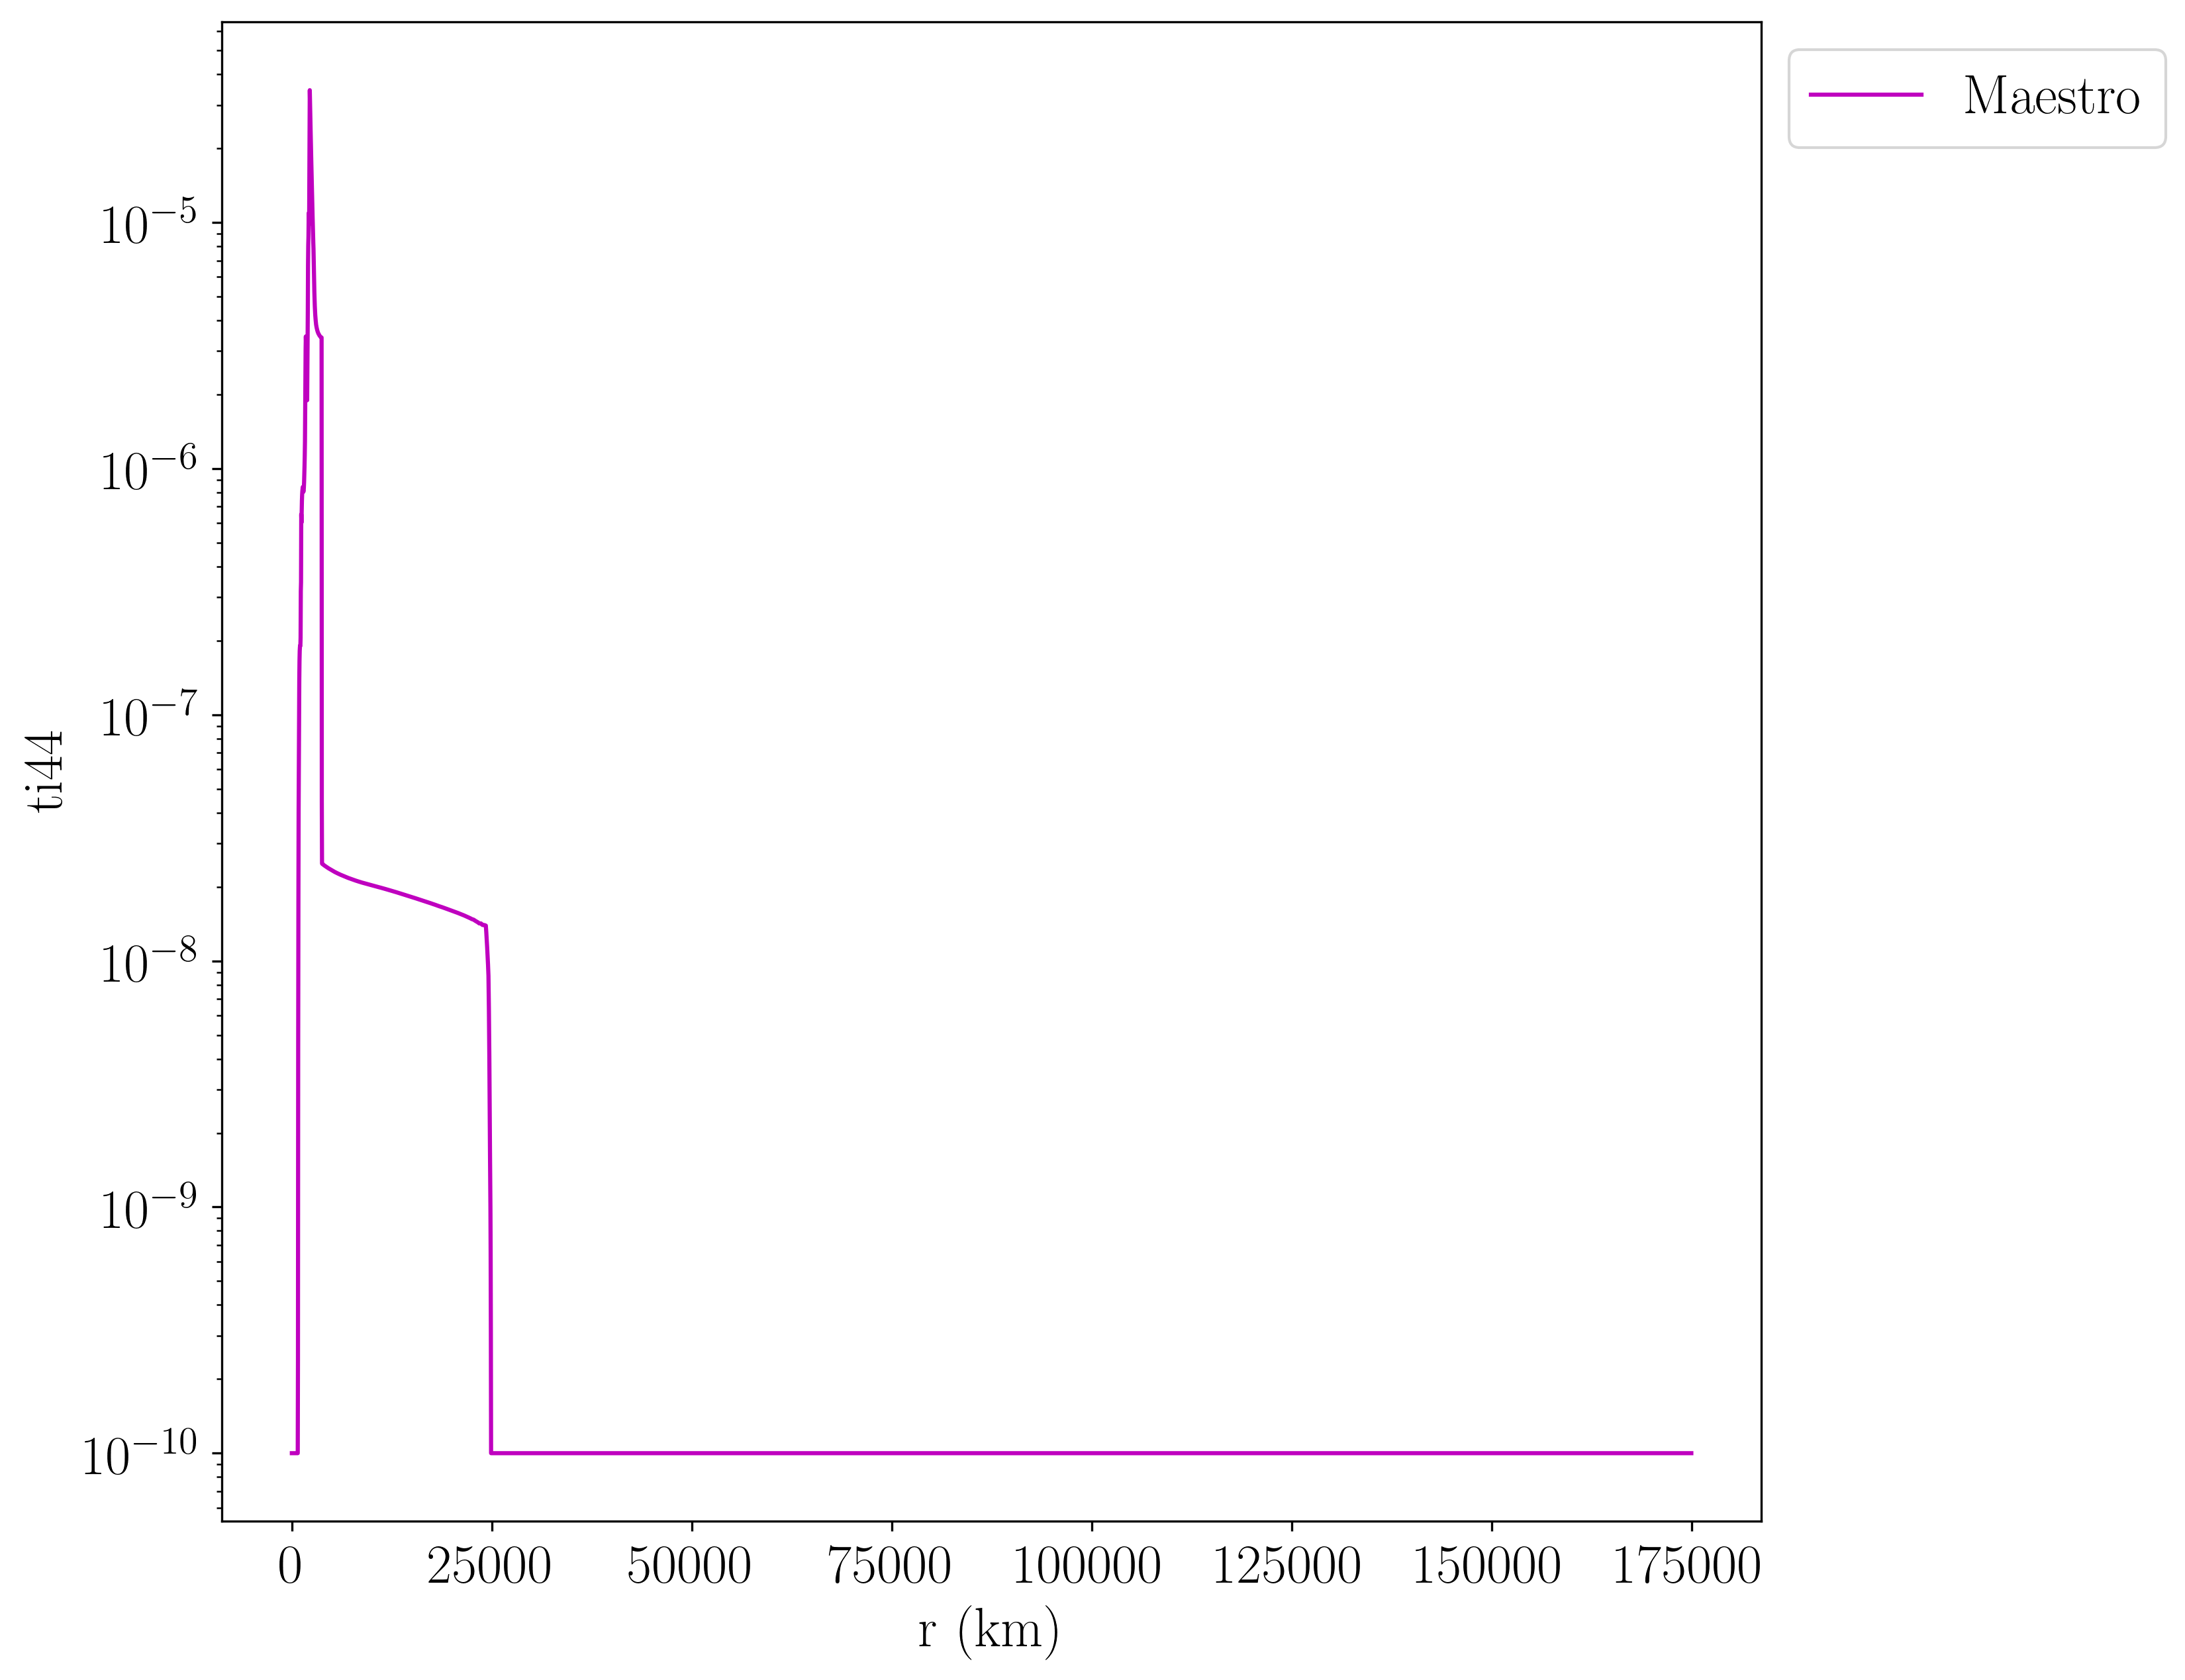

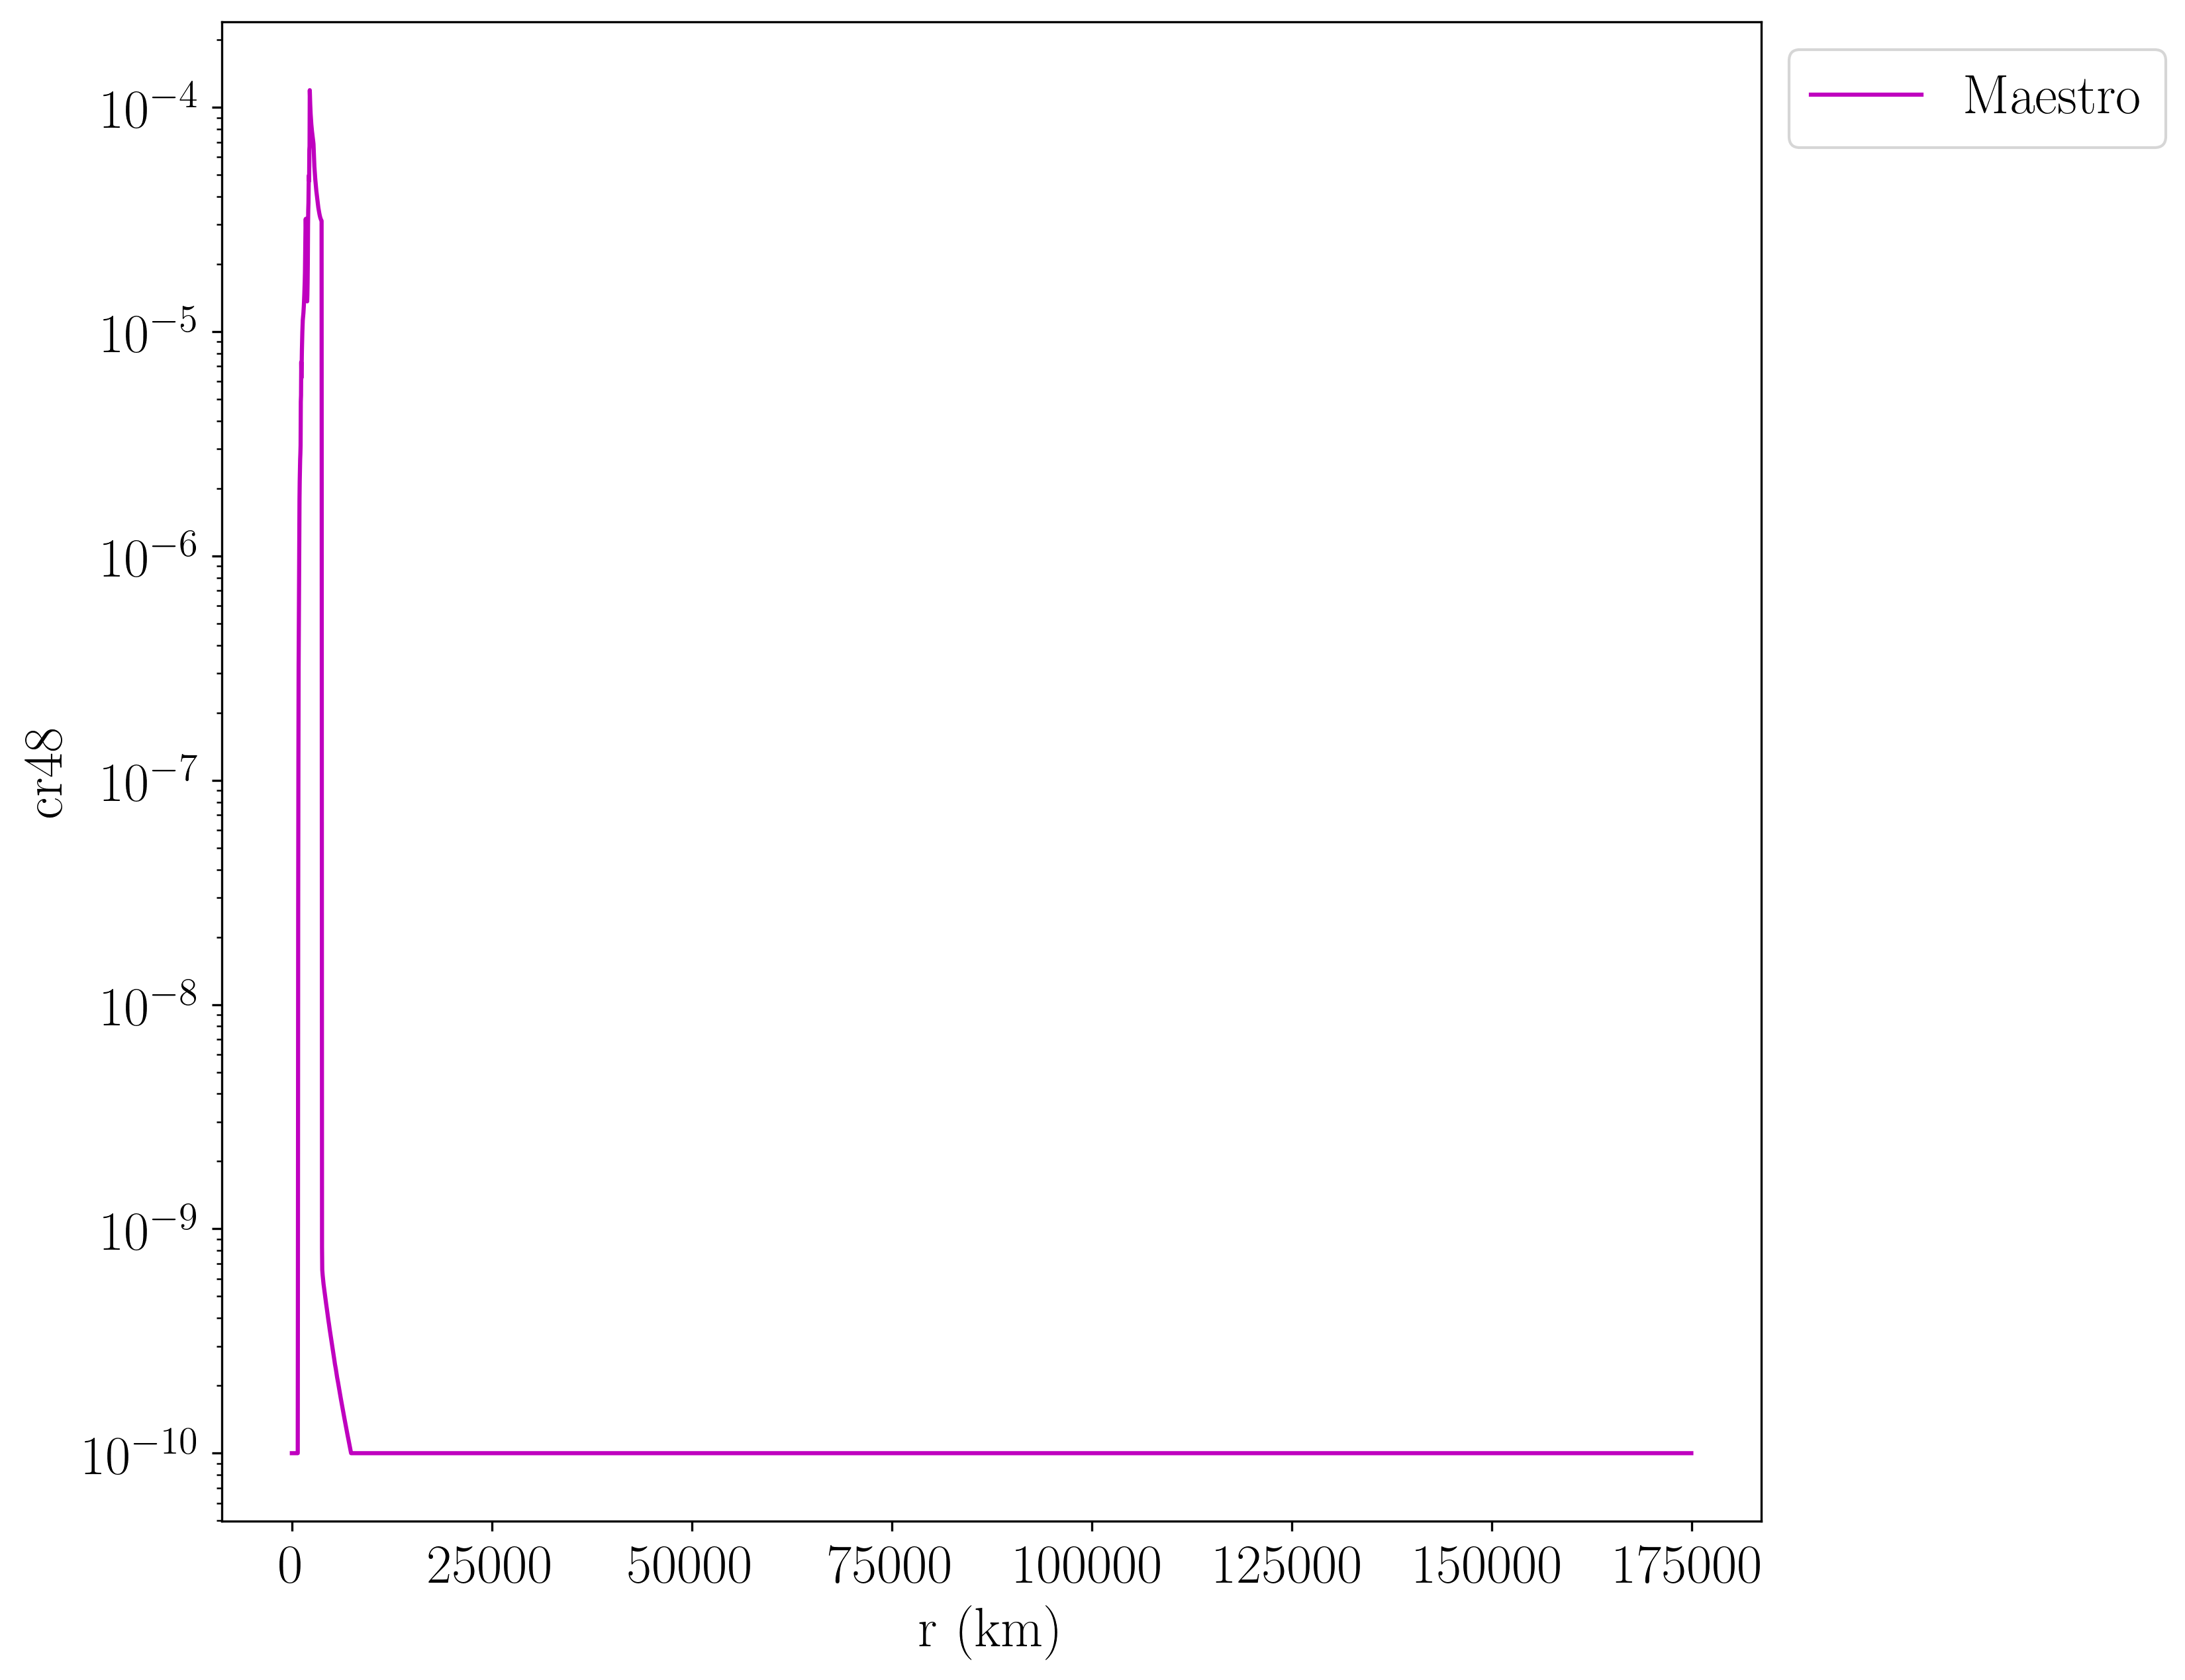

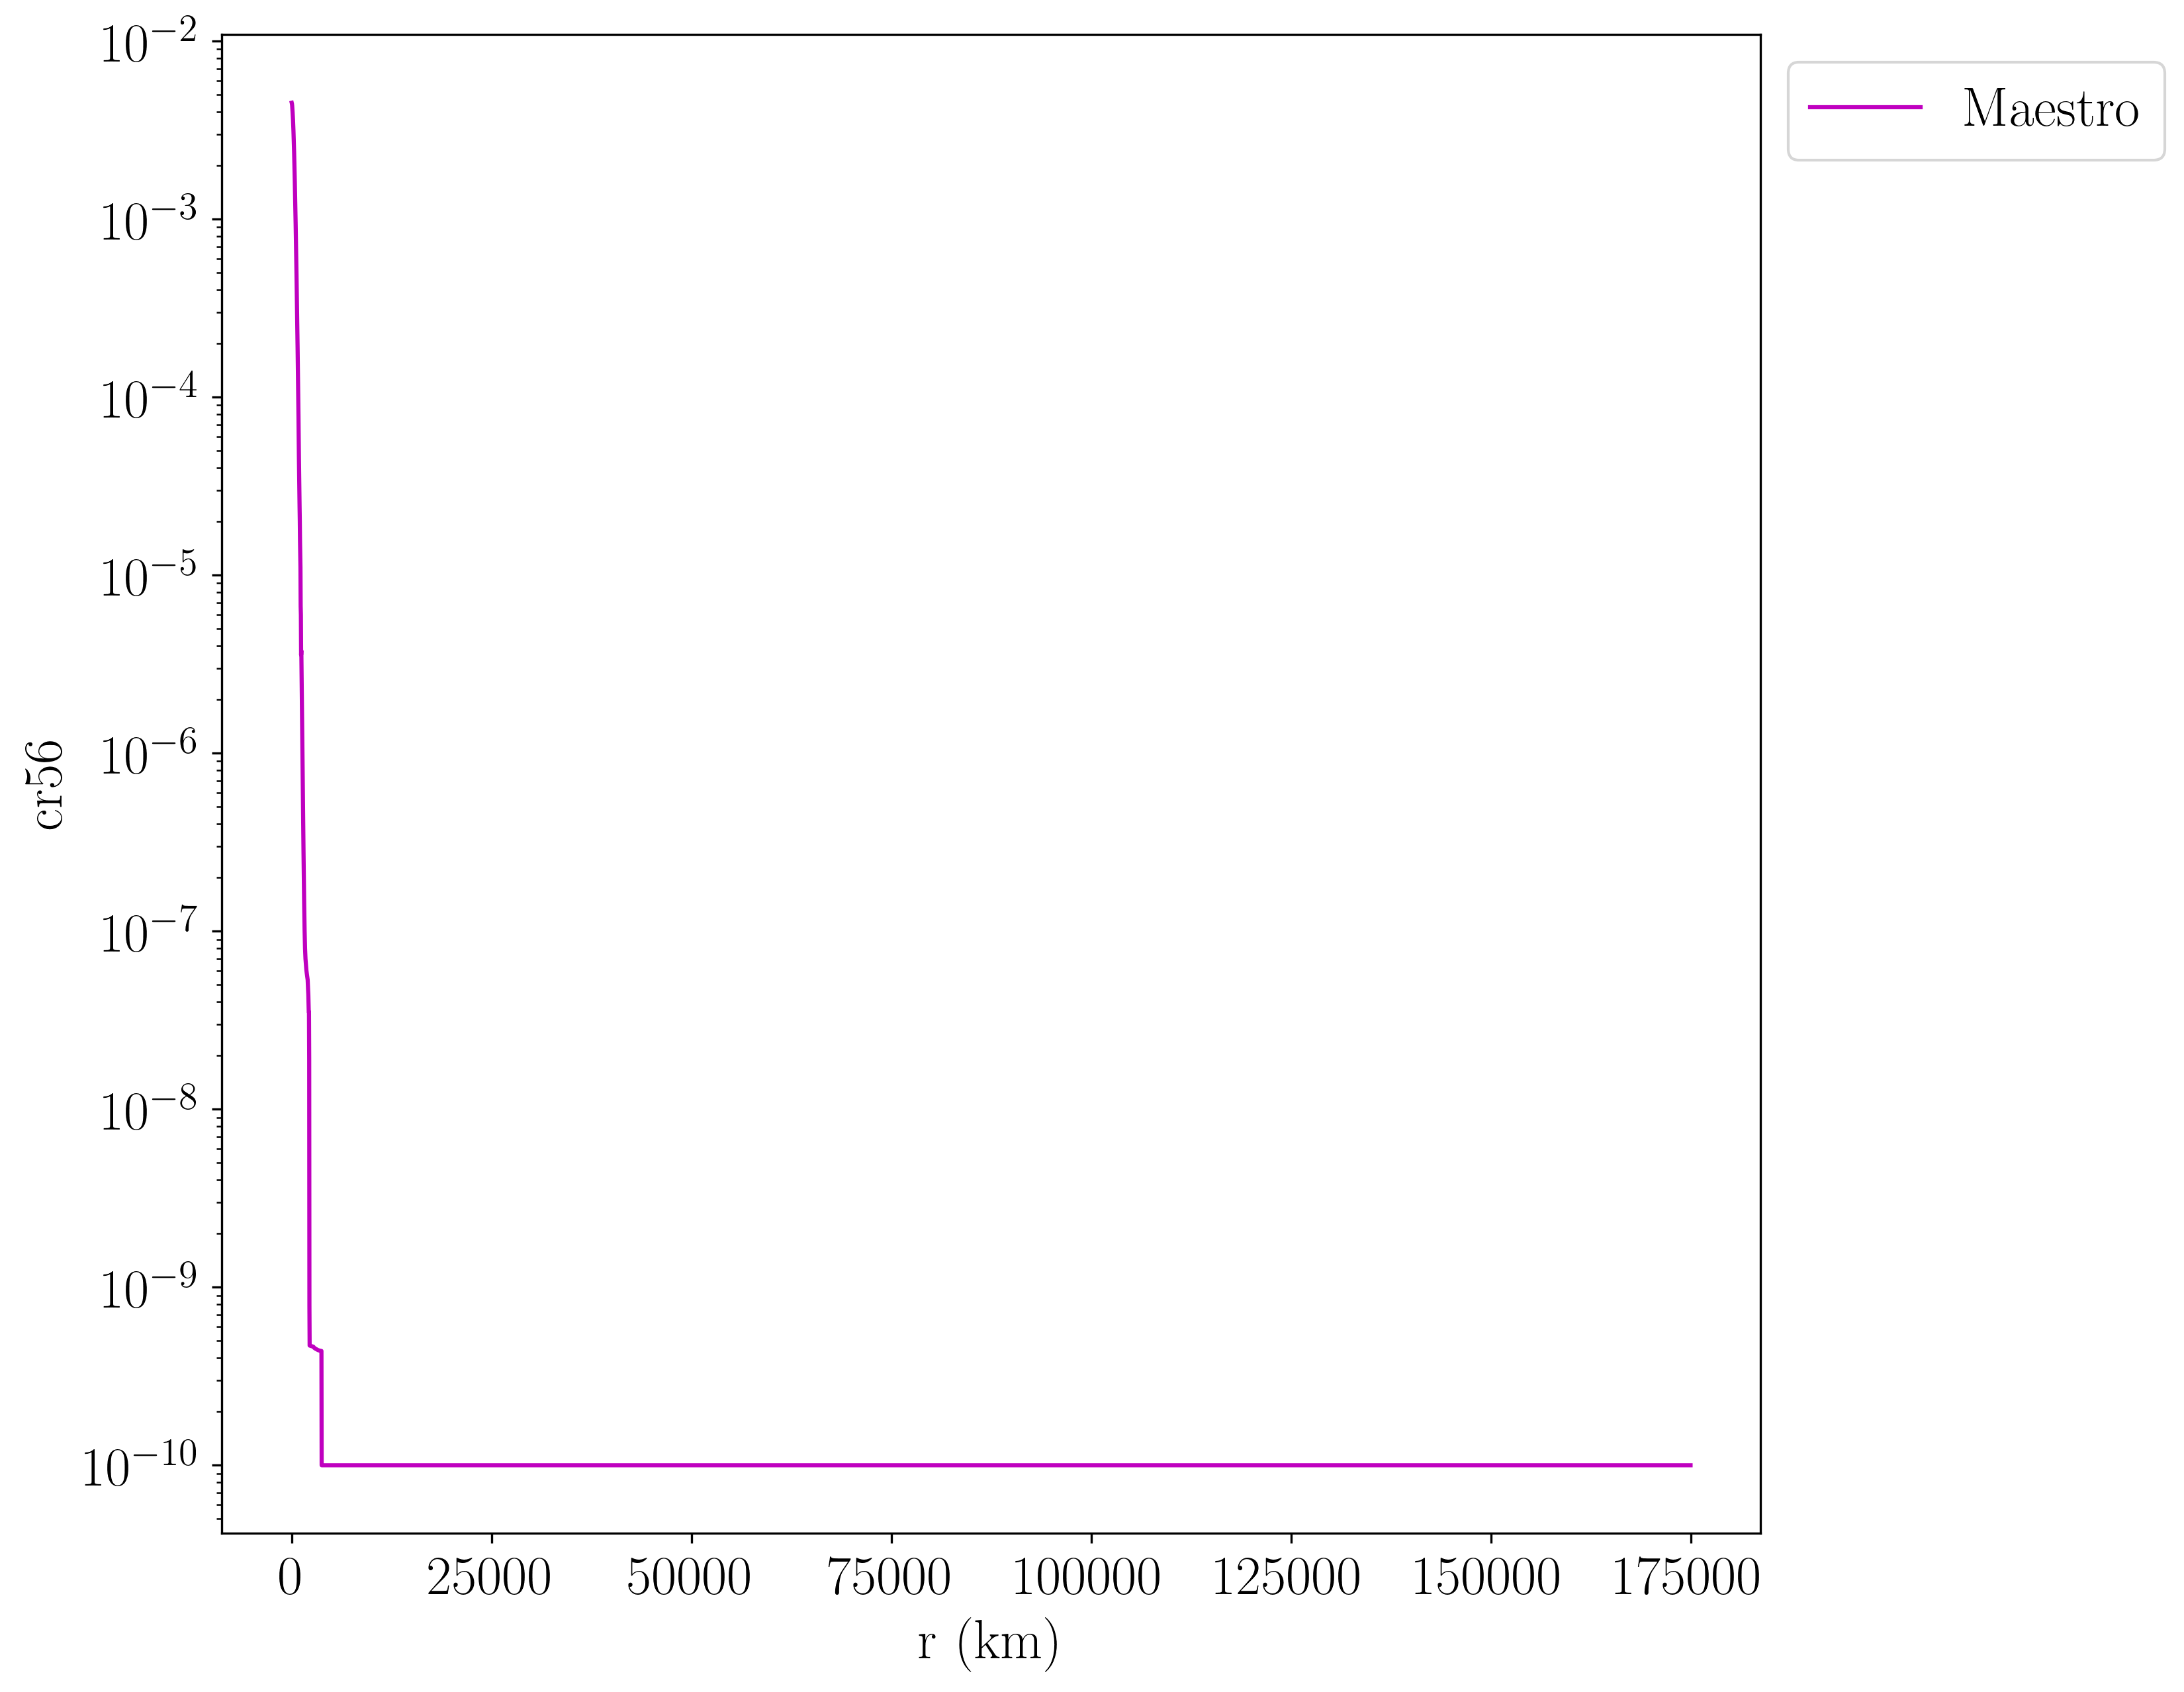

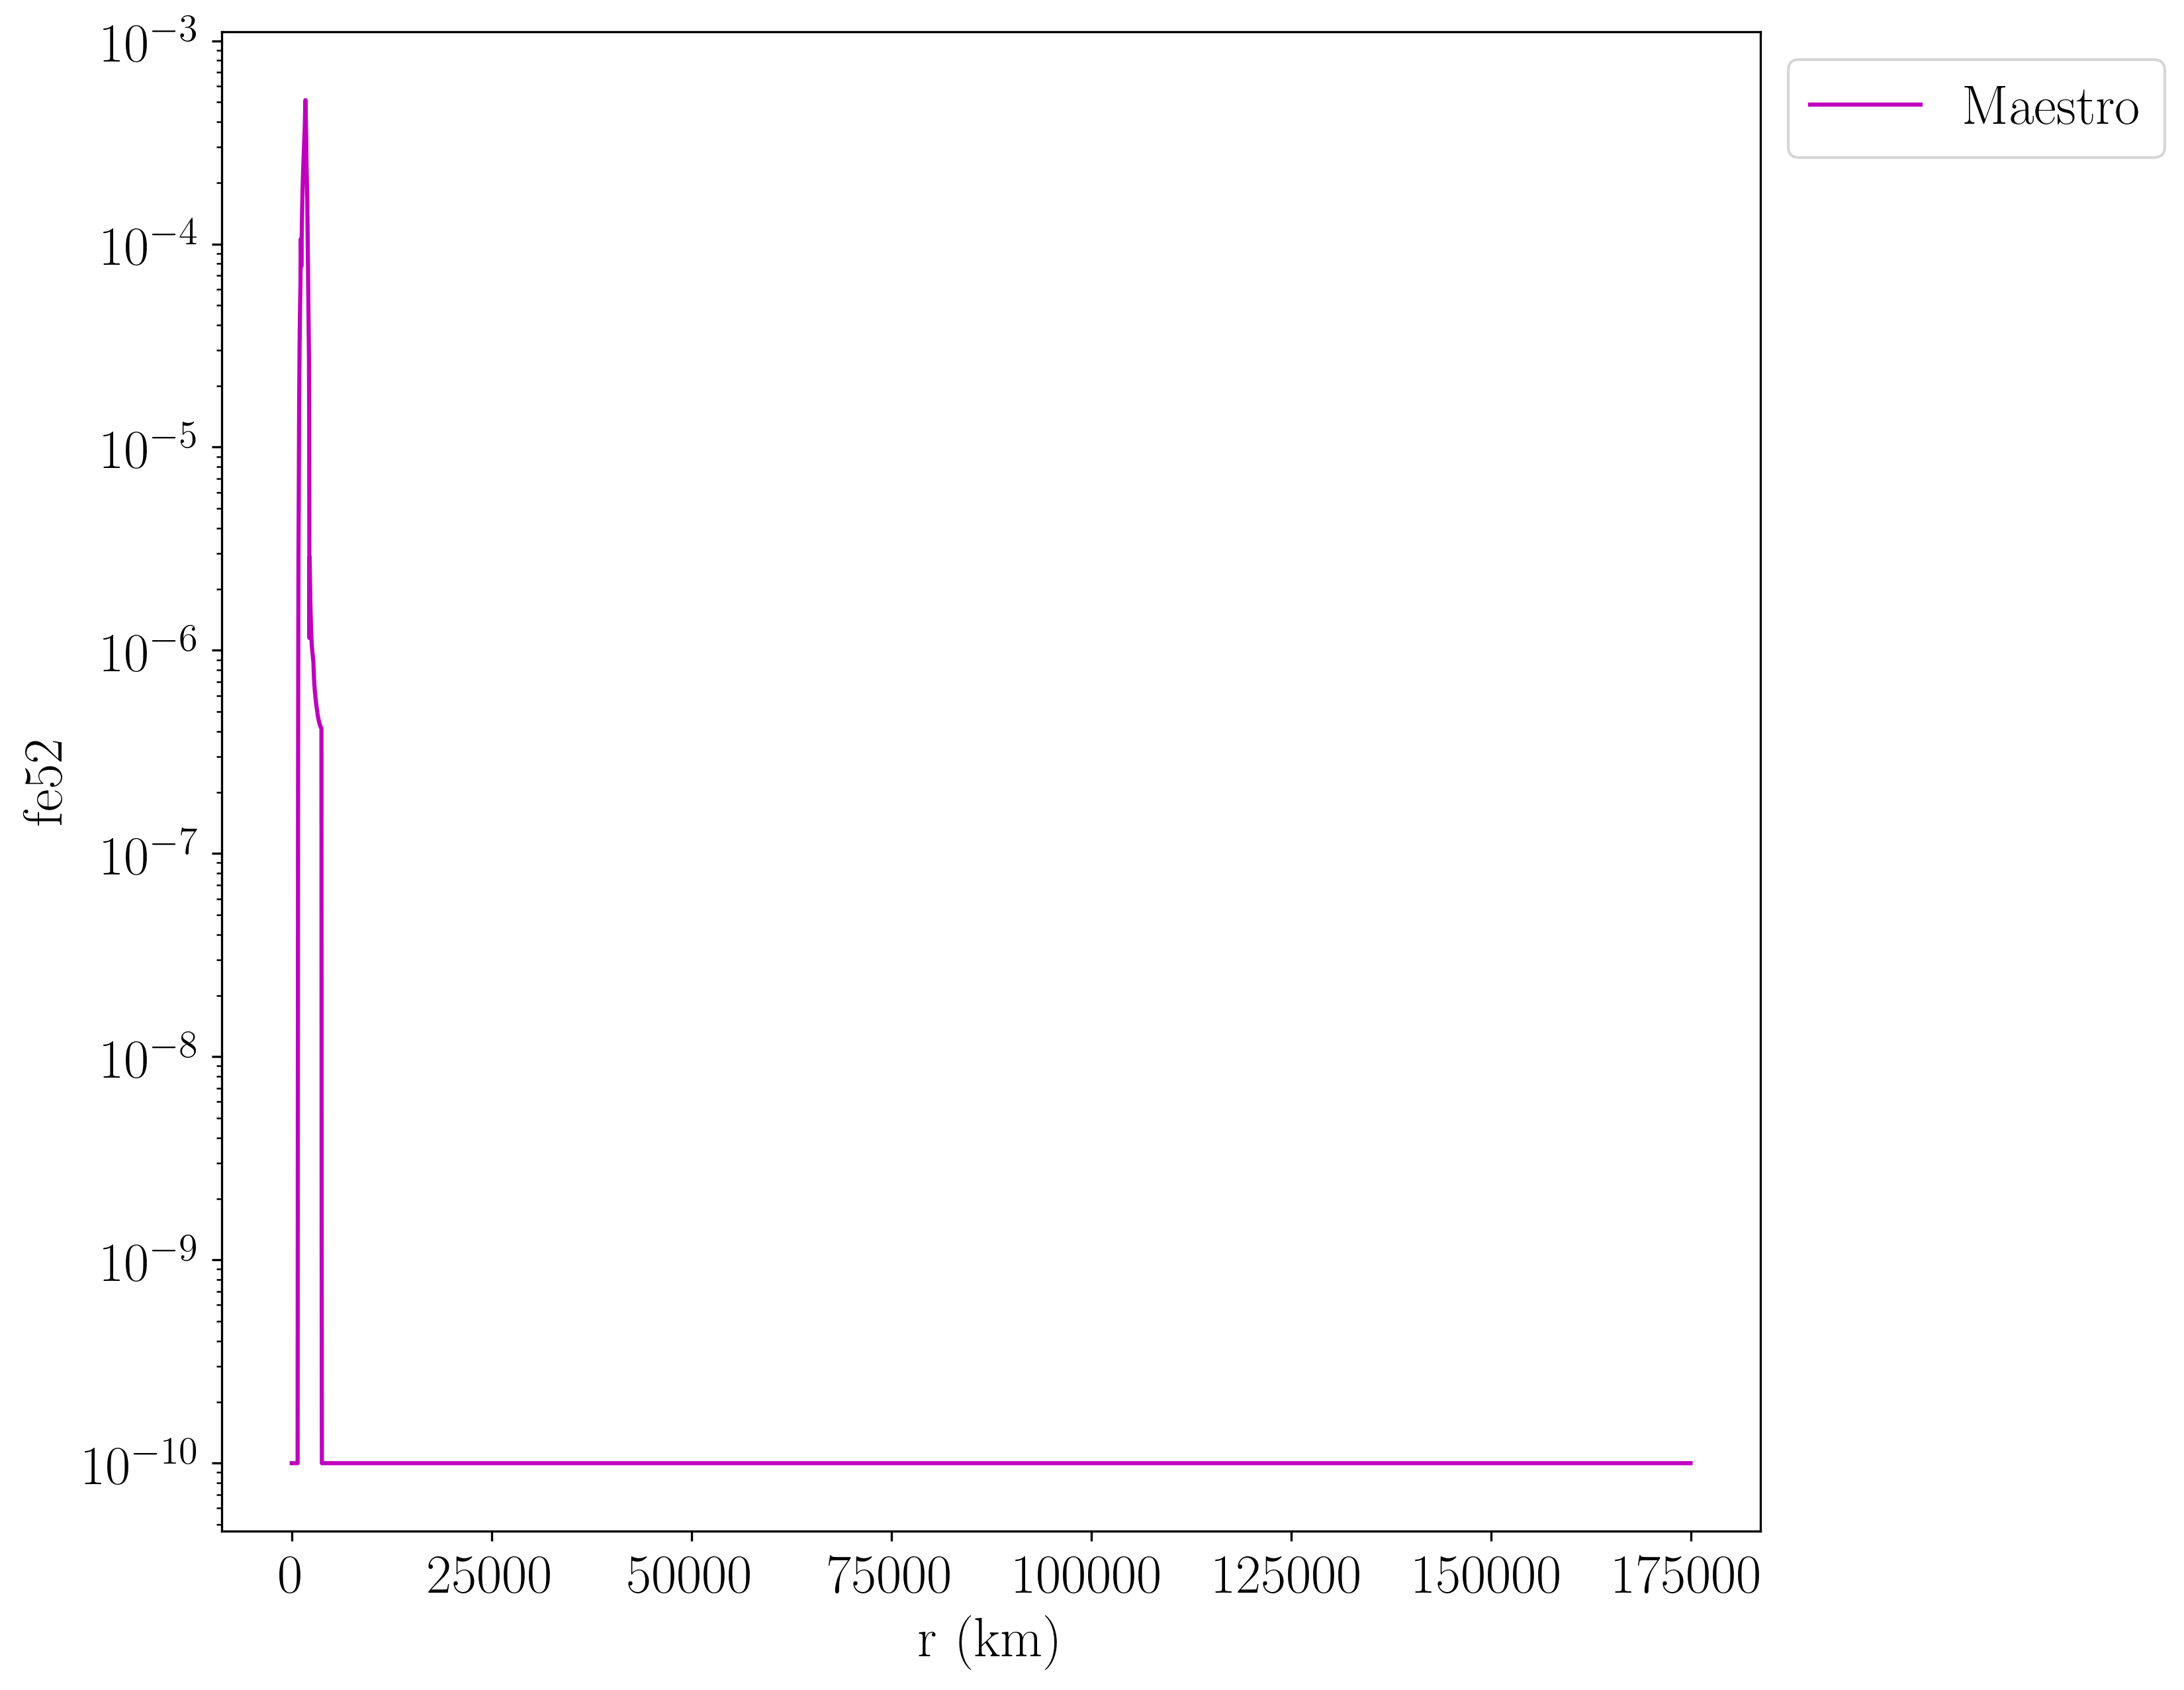

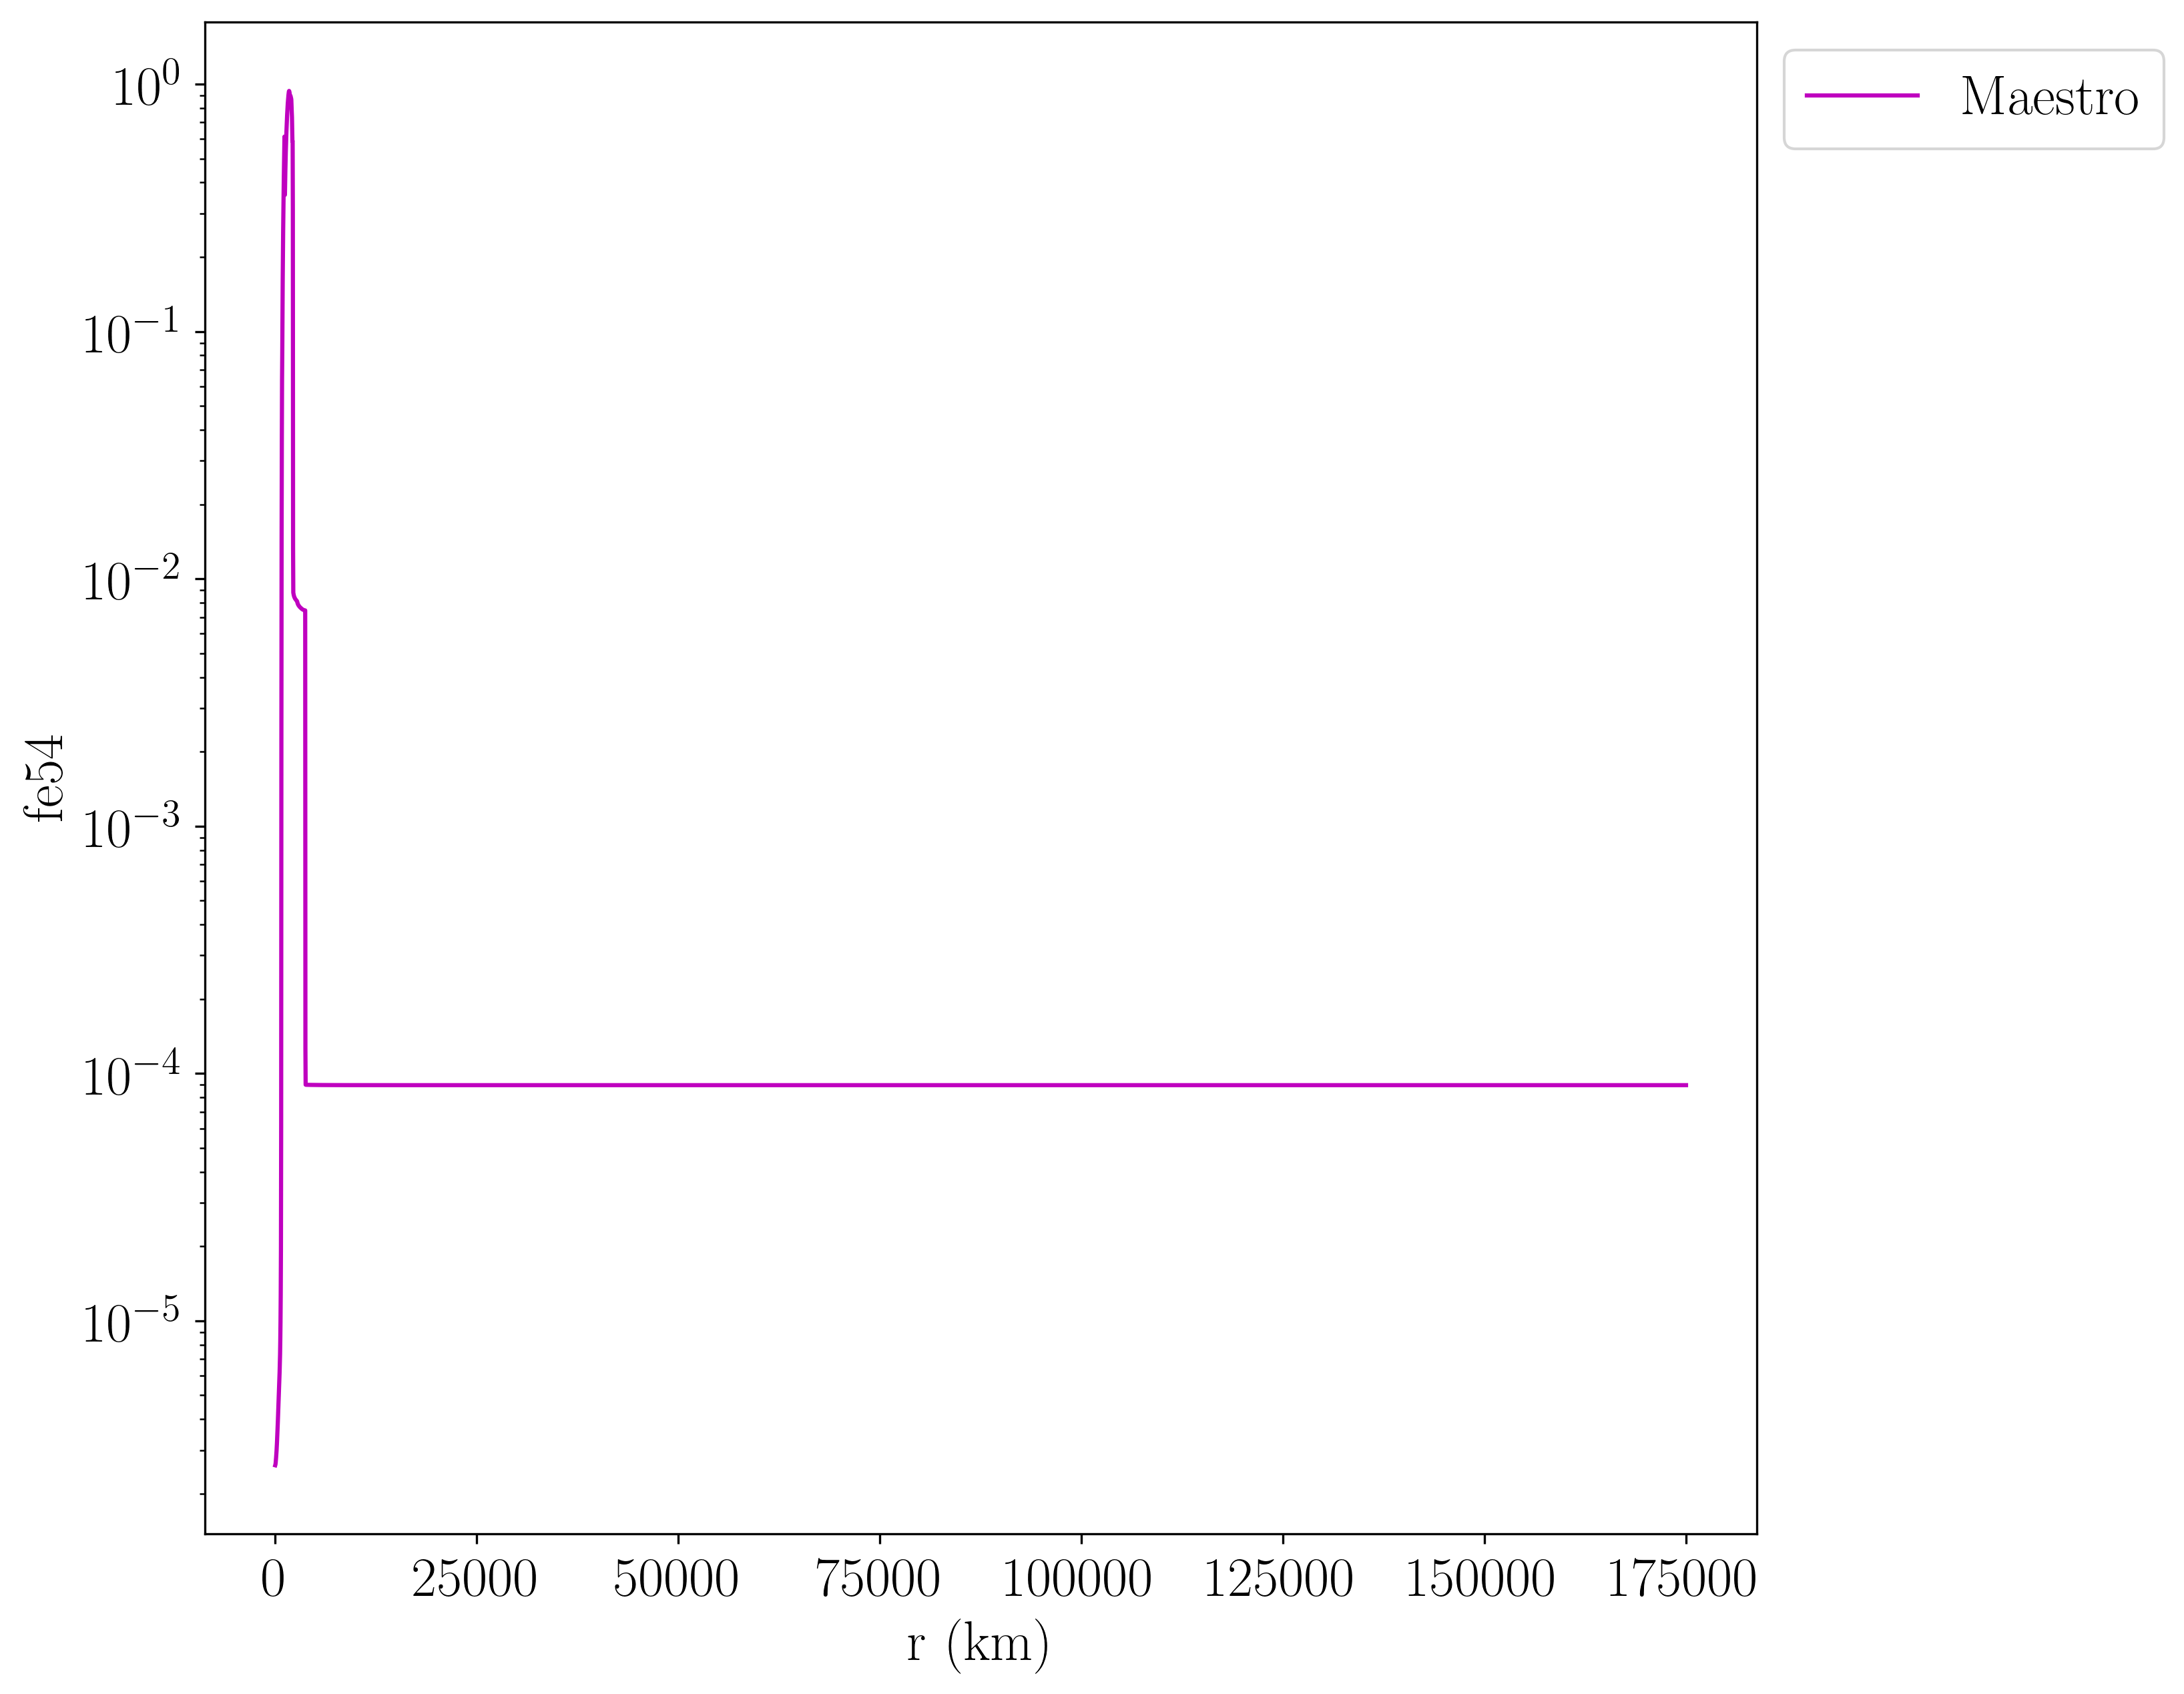

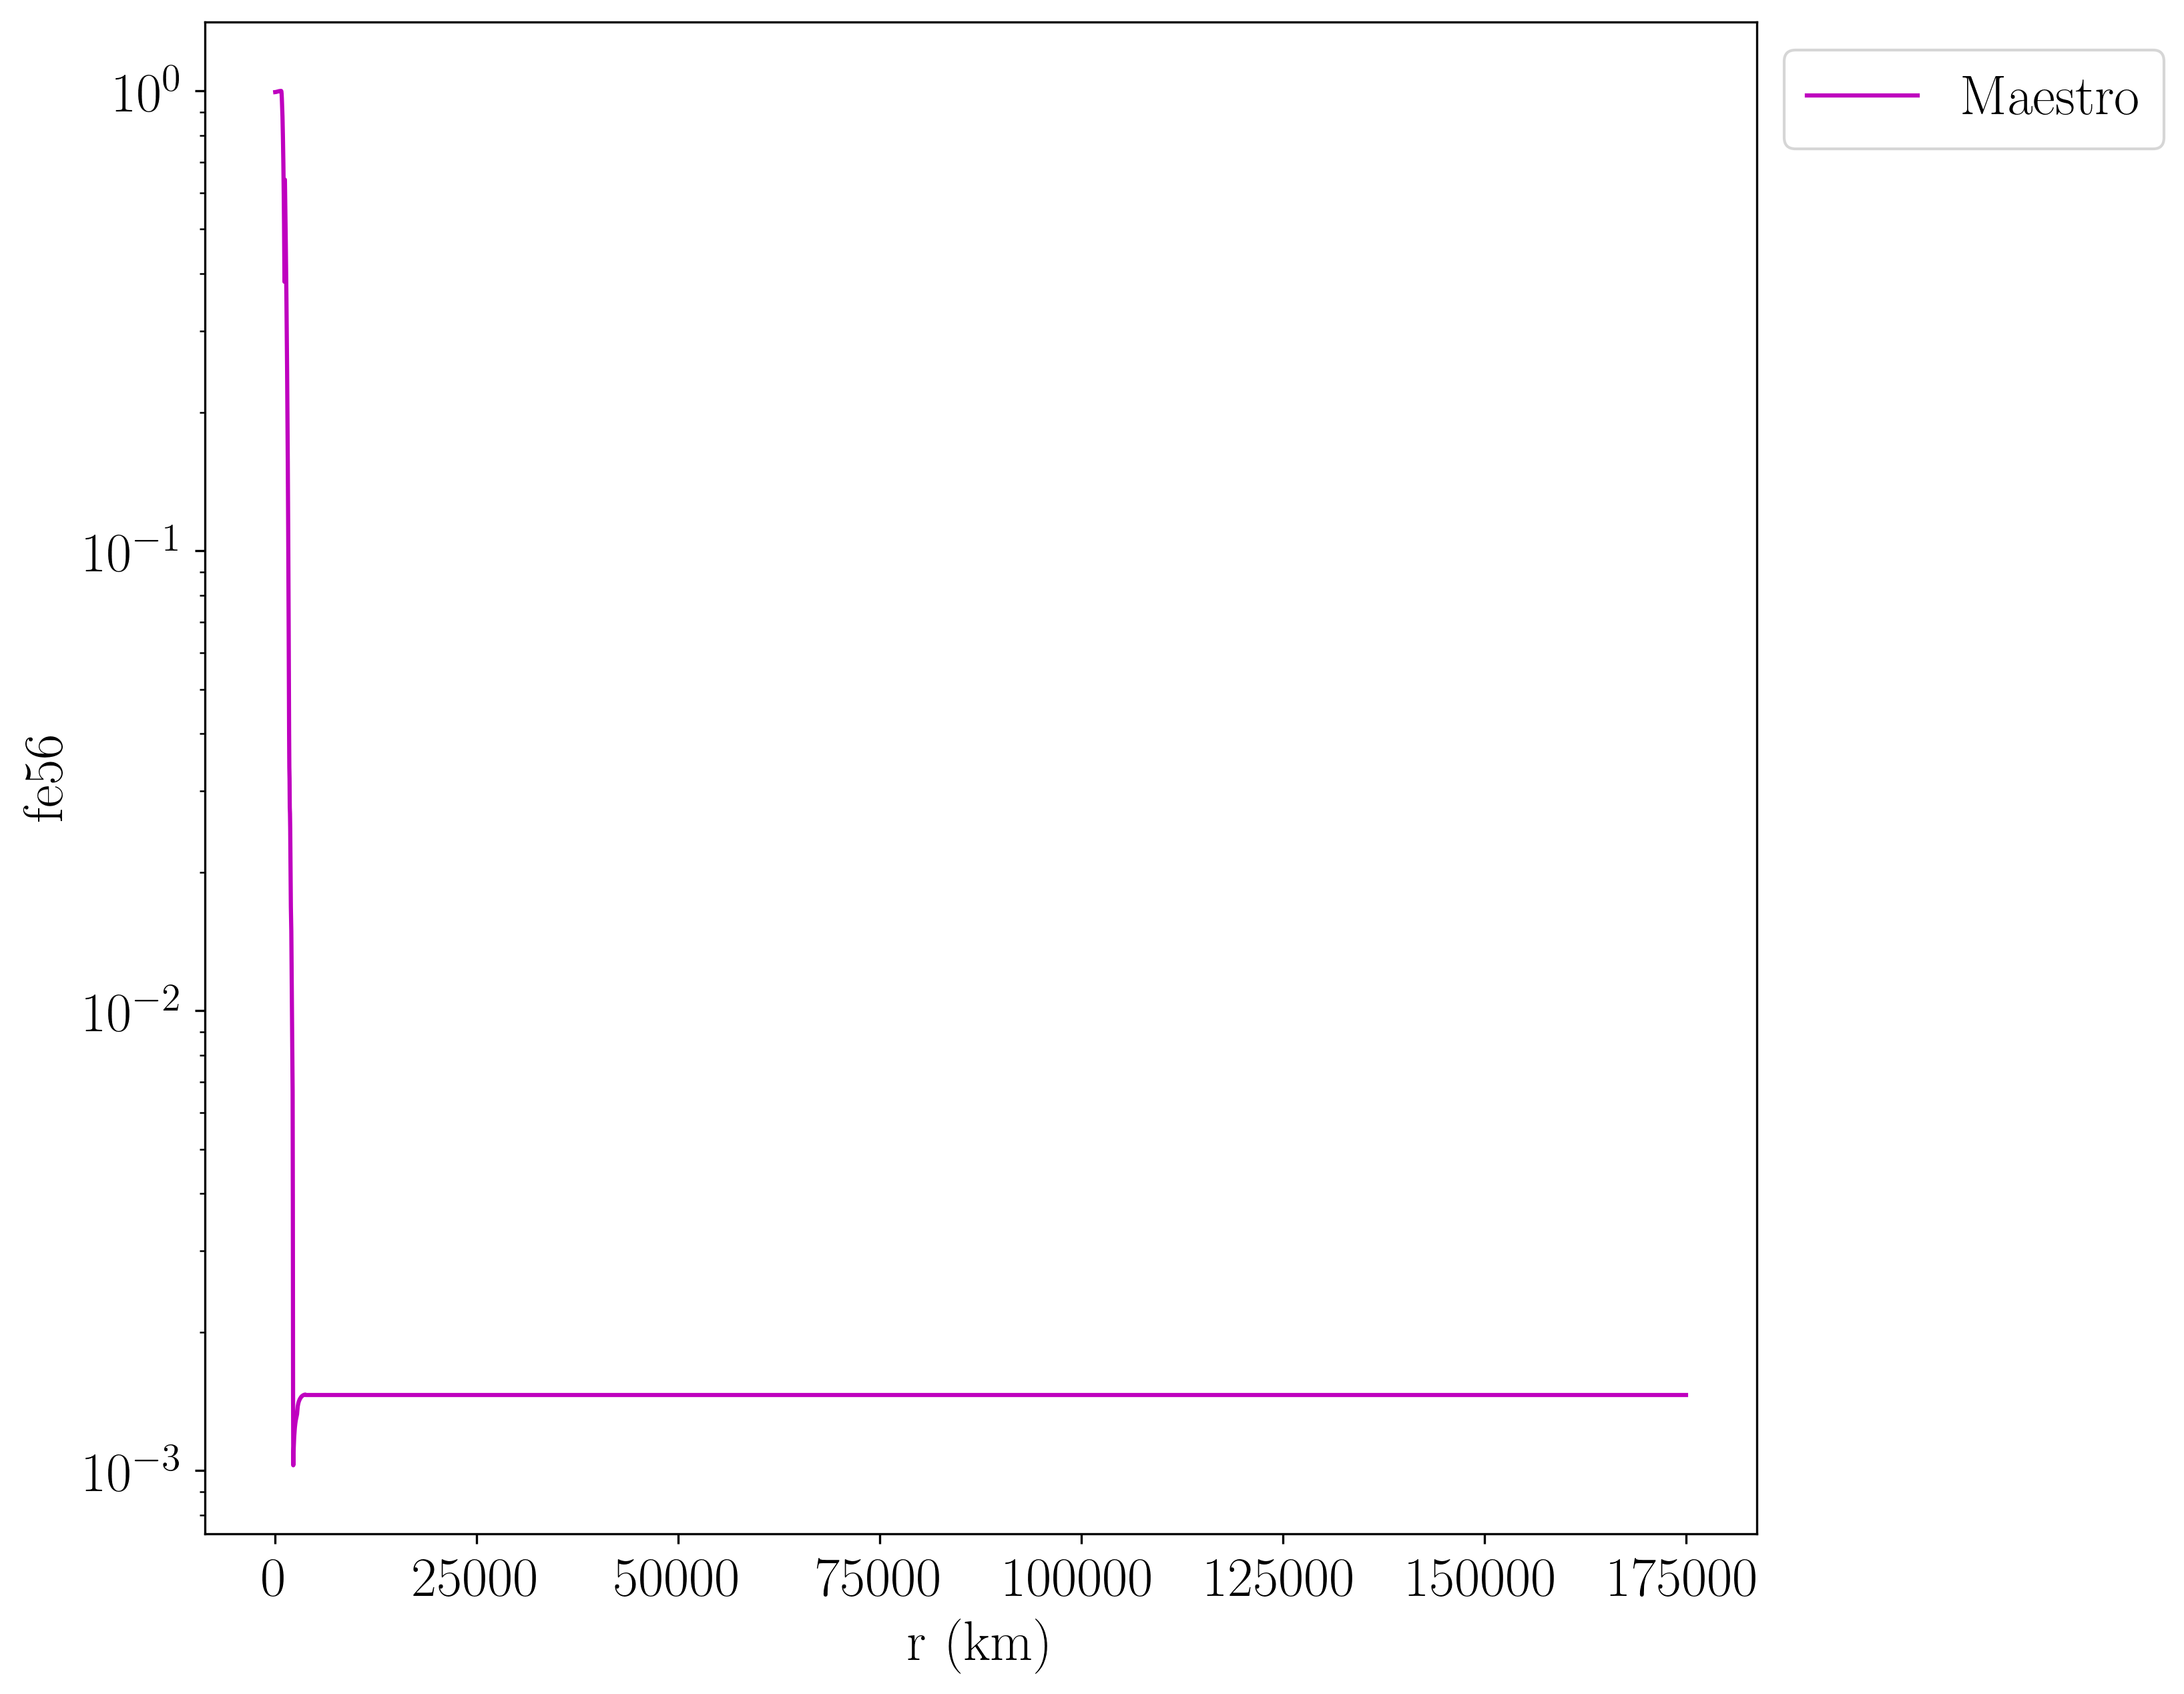

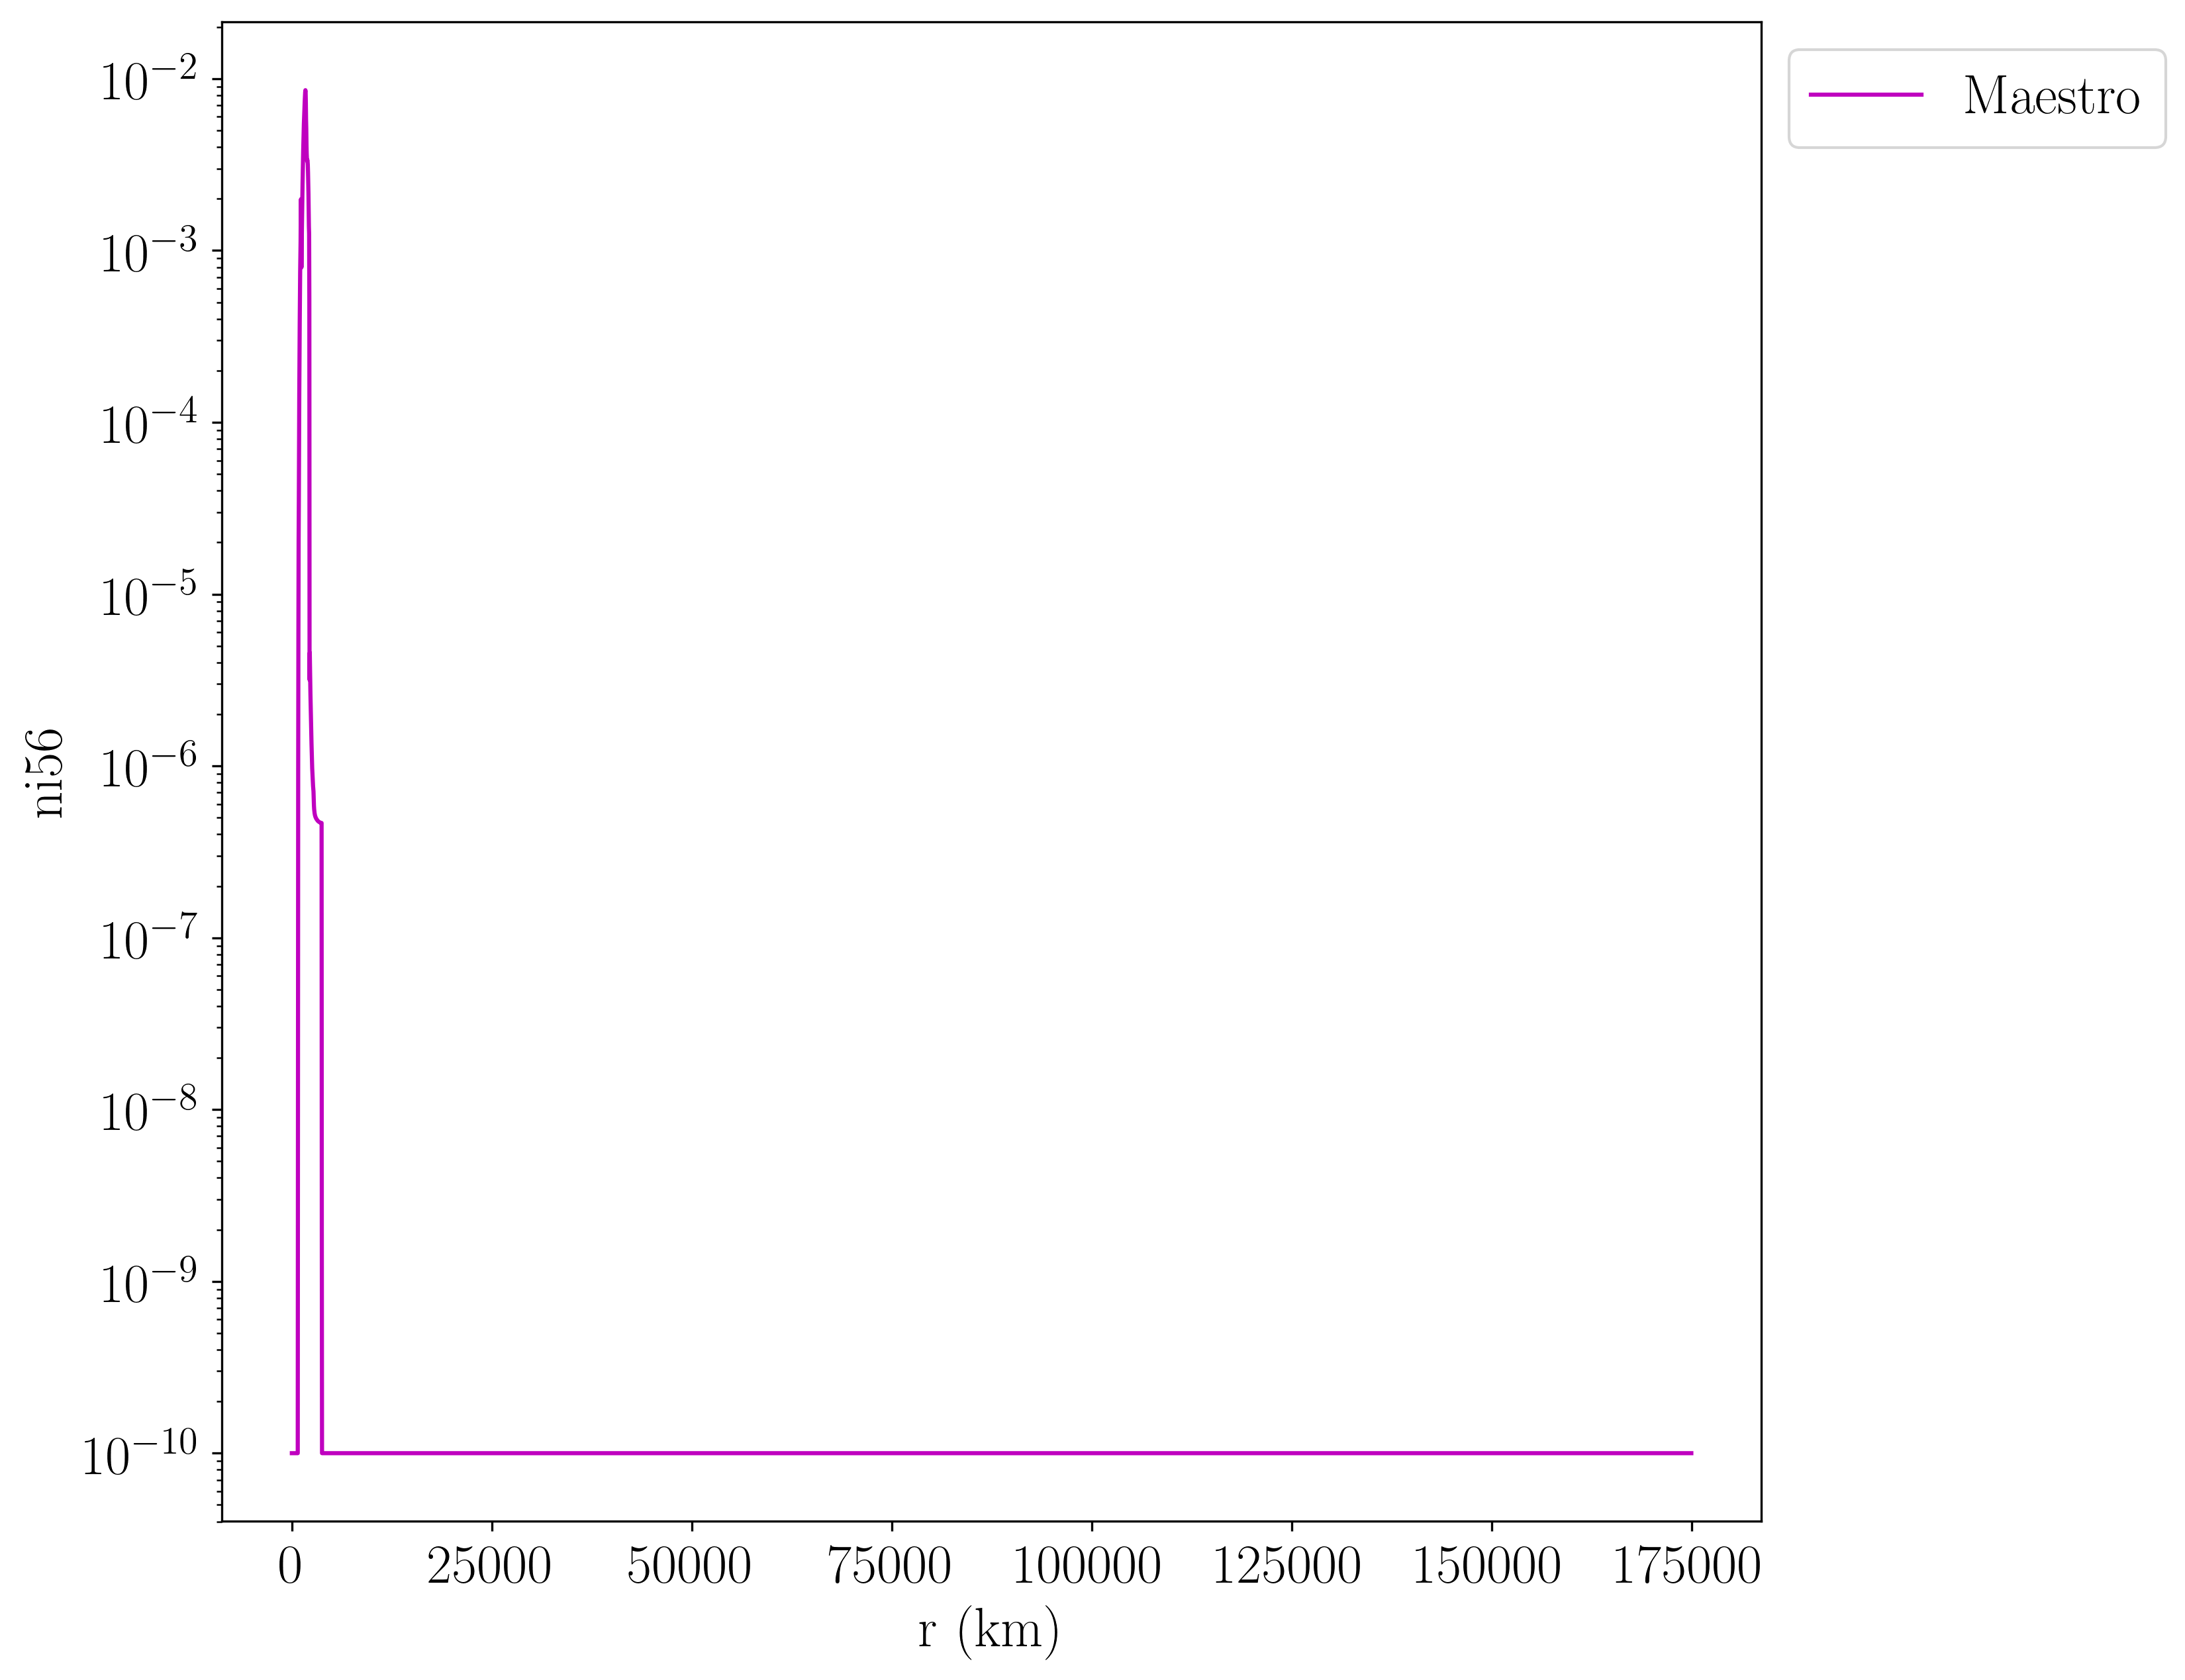

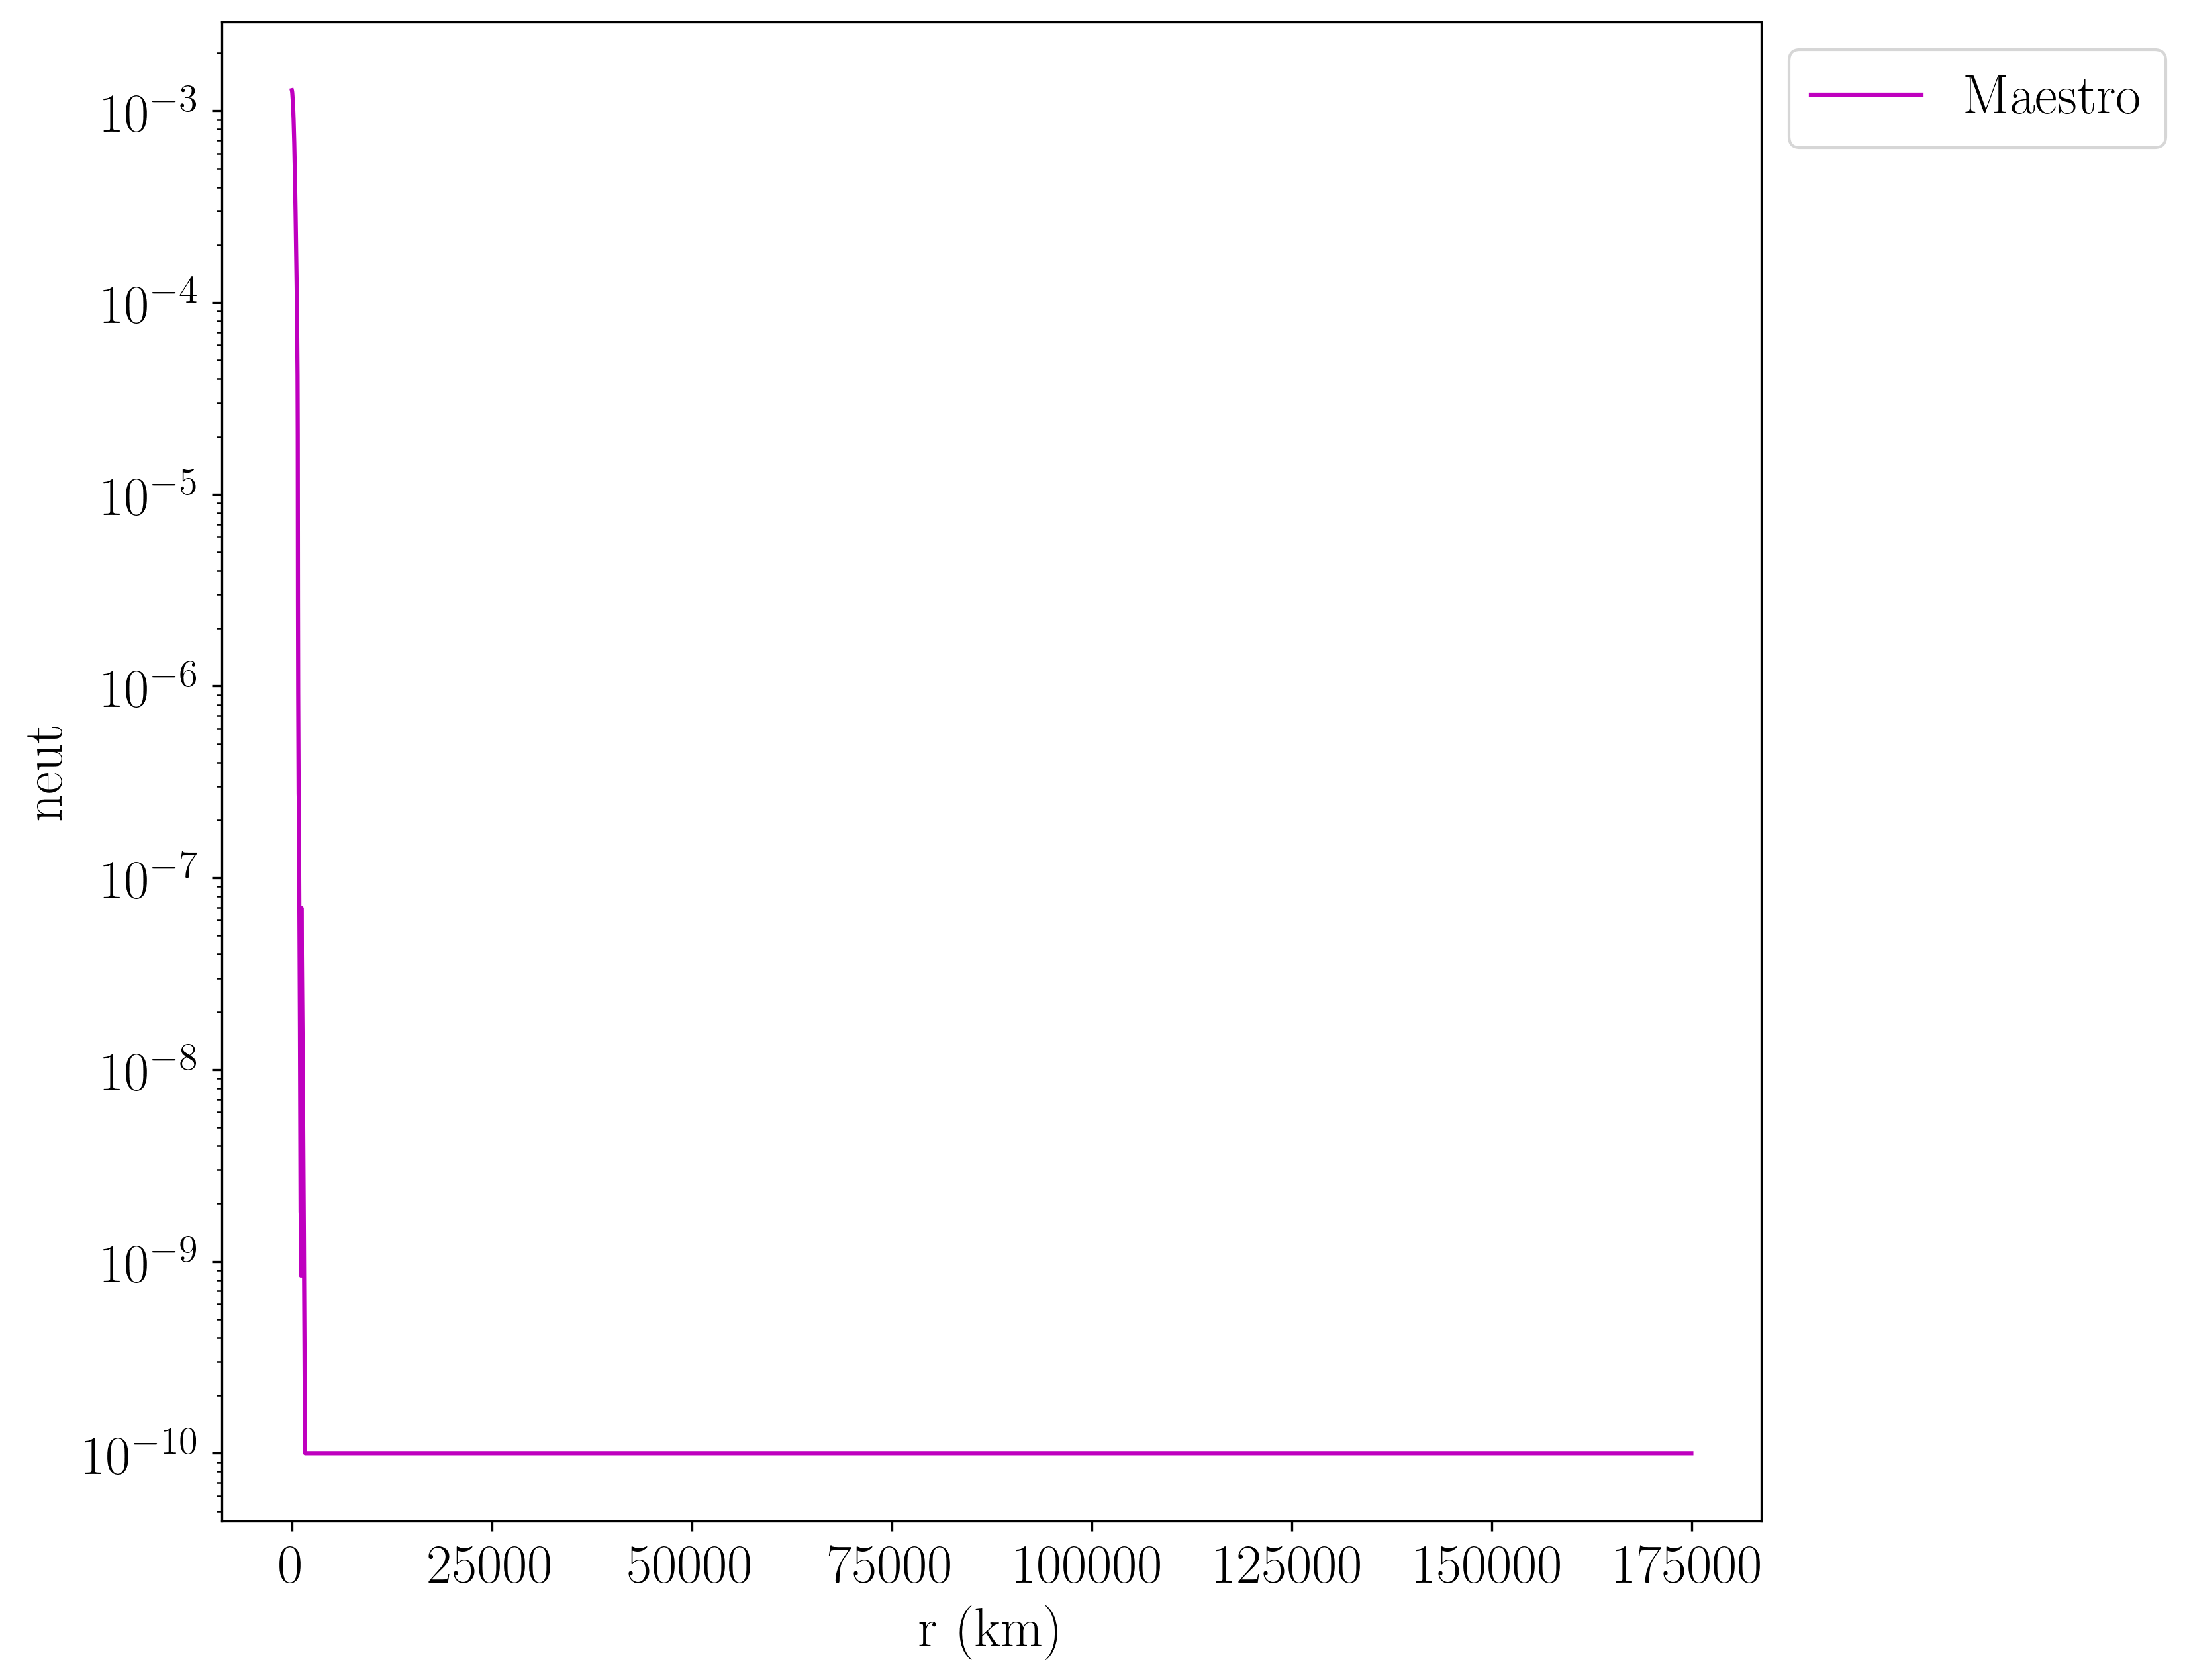

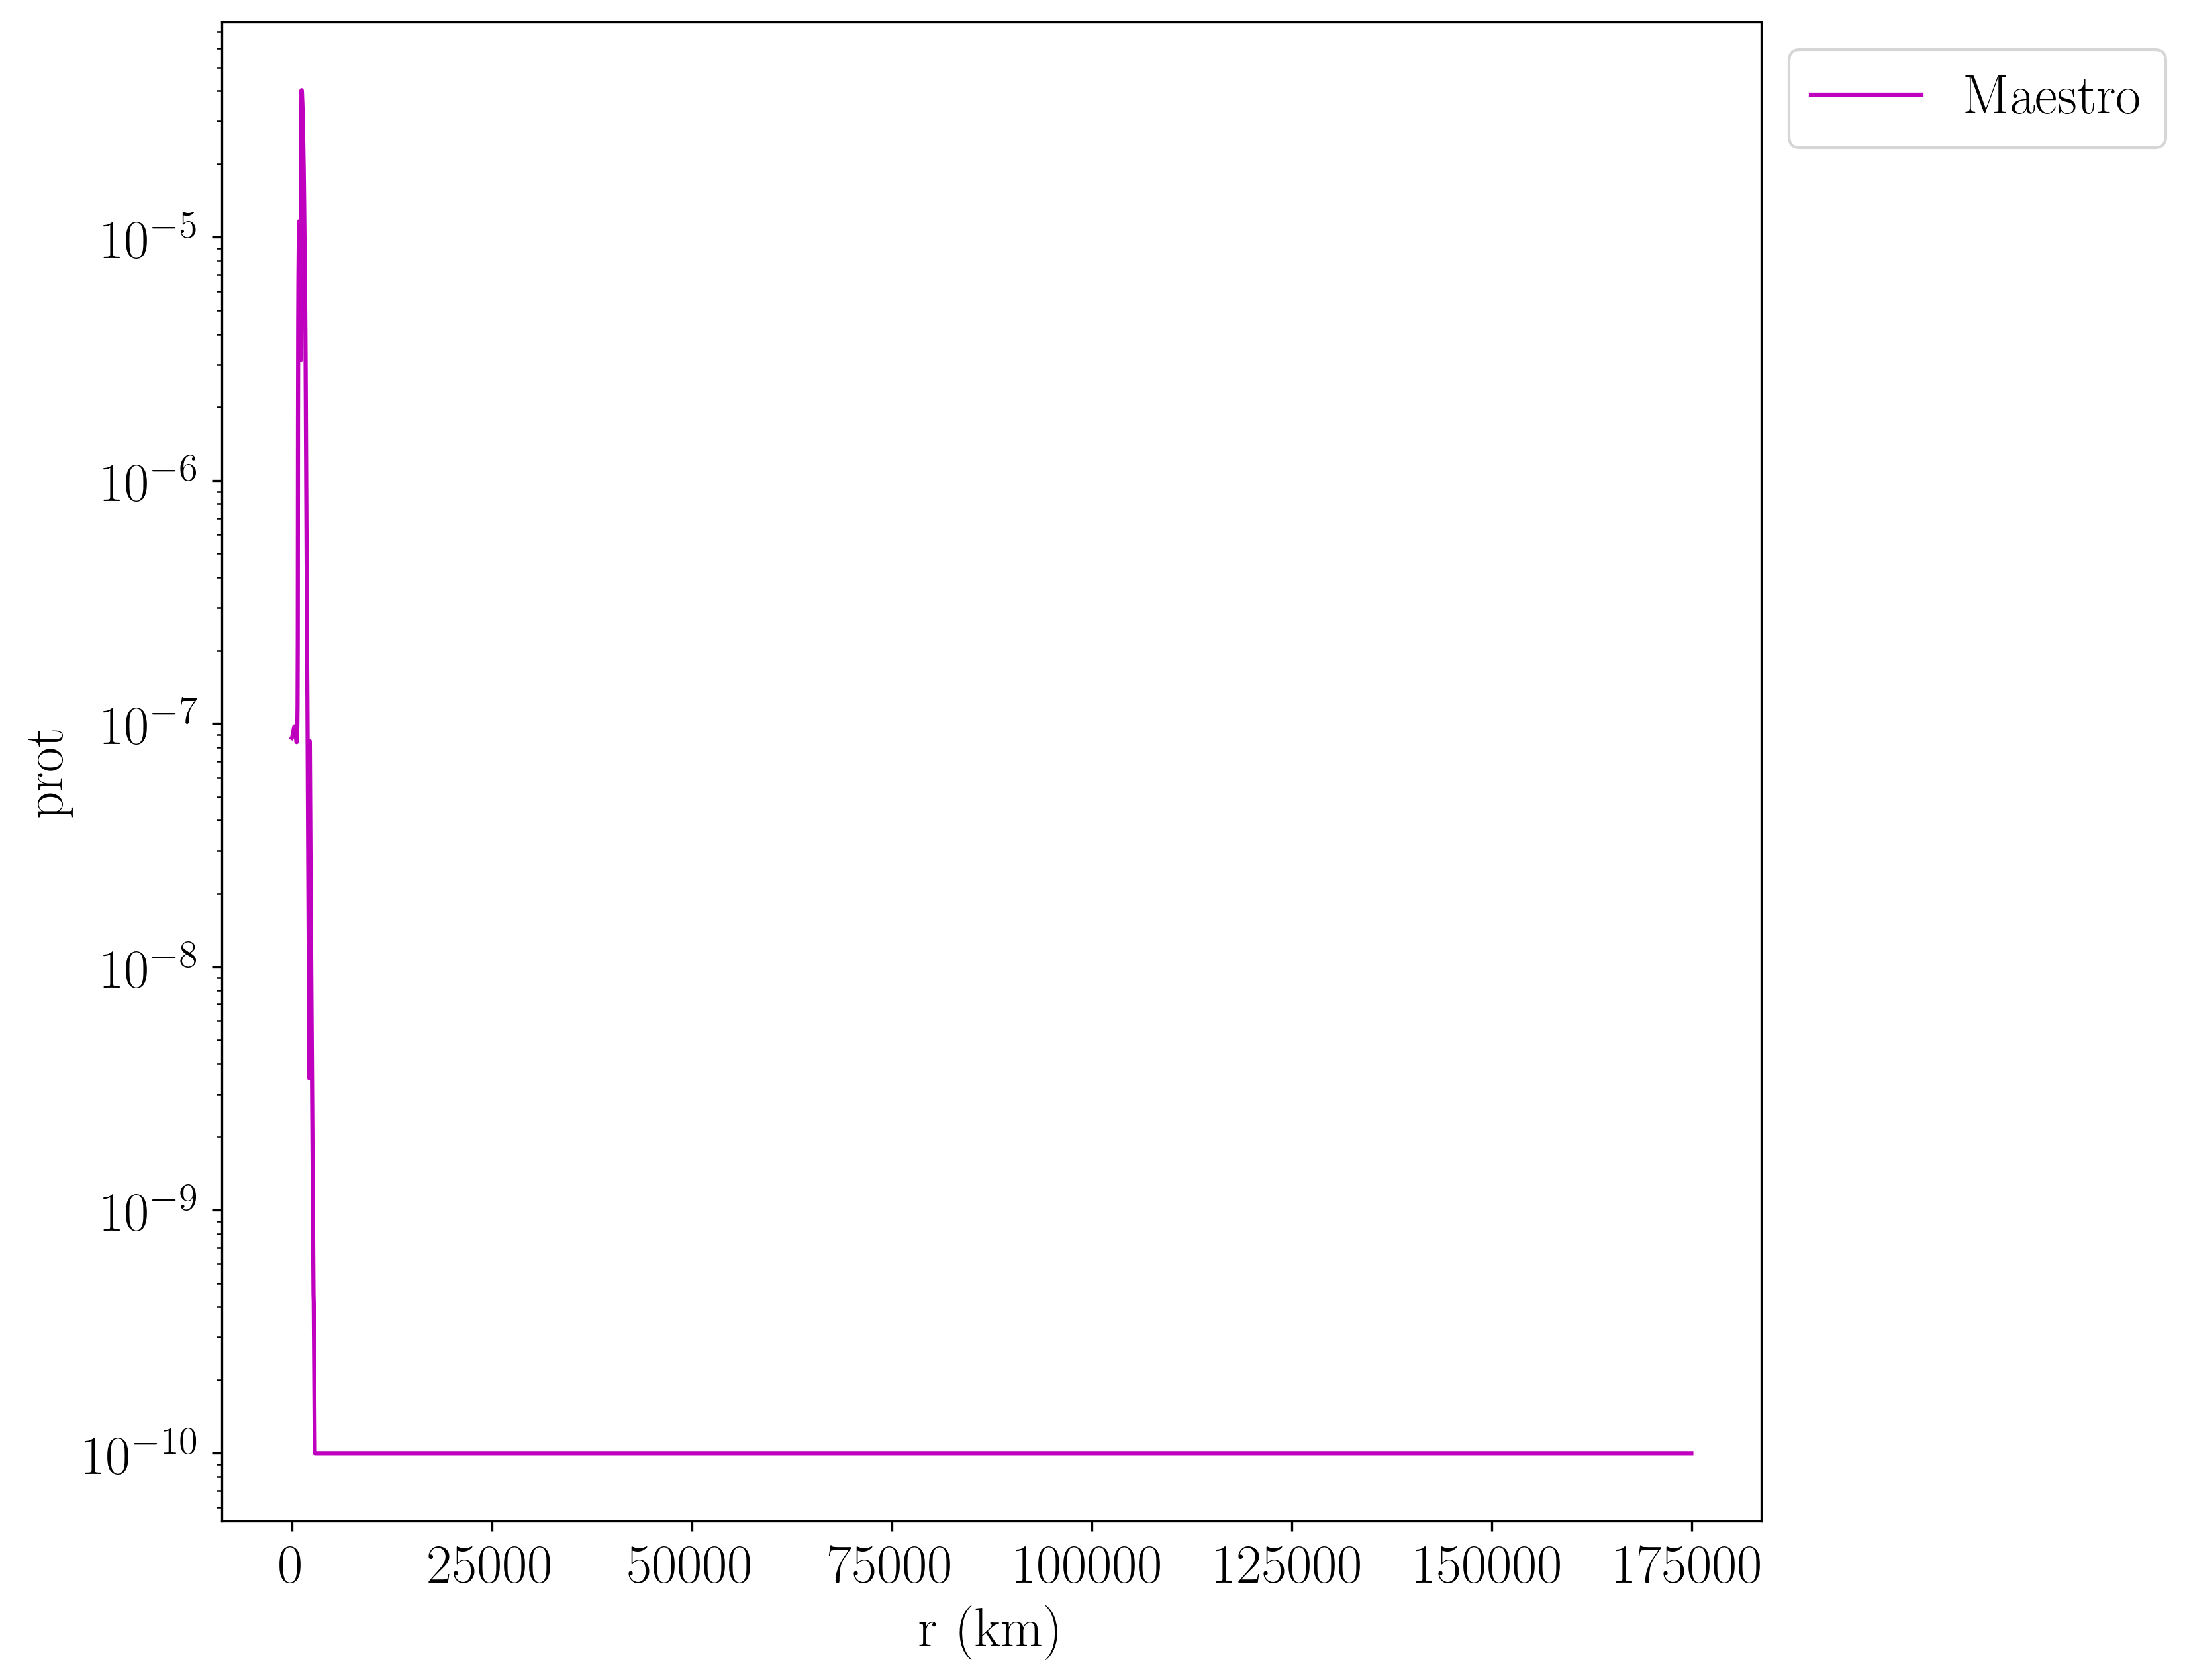

In [18]:
for s in net.short_species_names:
    plot_field(field=s, logy=True)

### Zoom in on shell

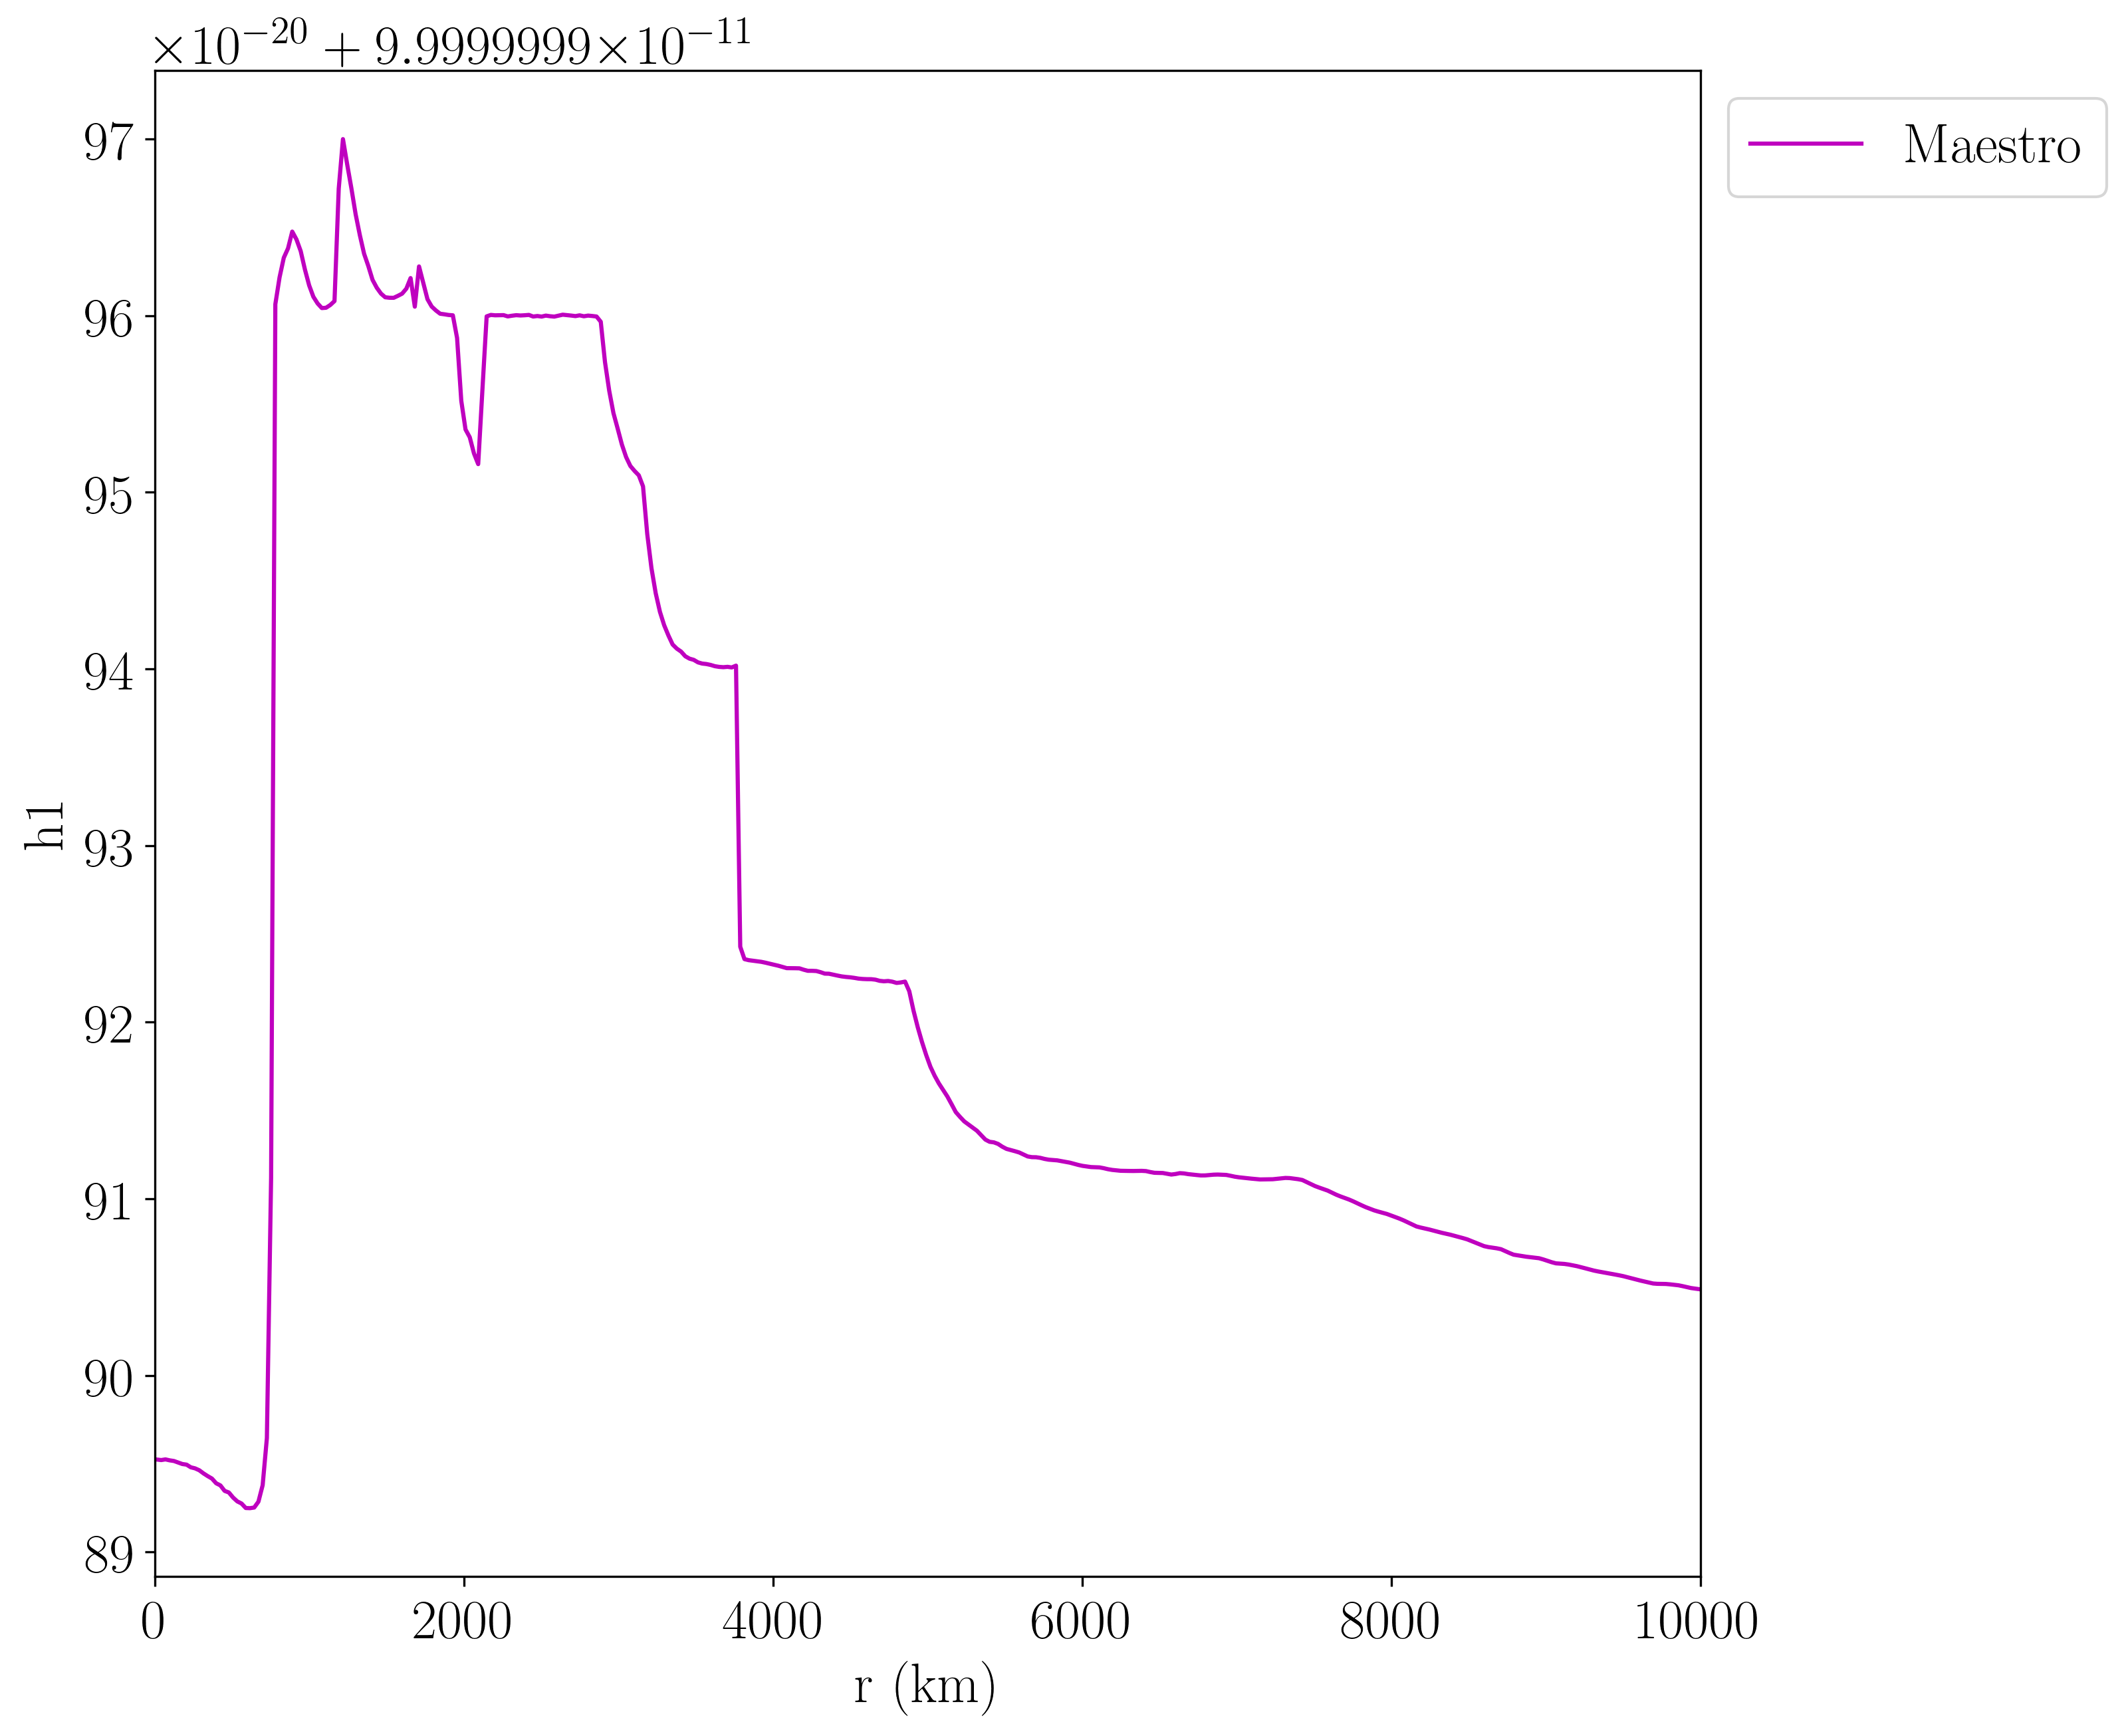

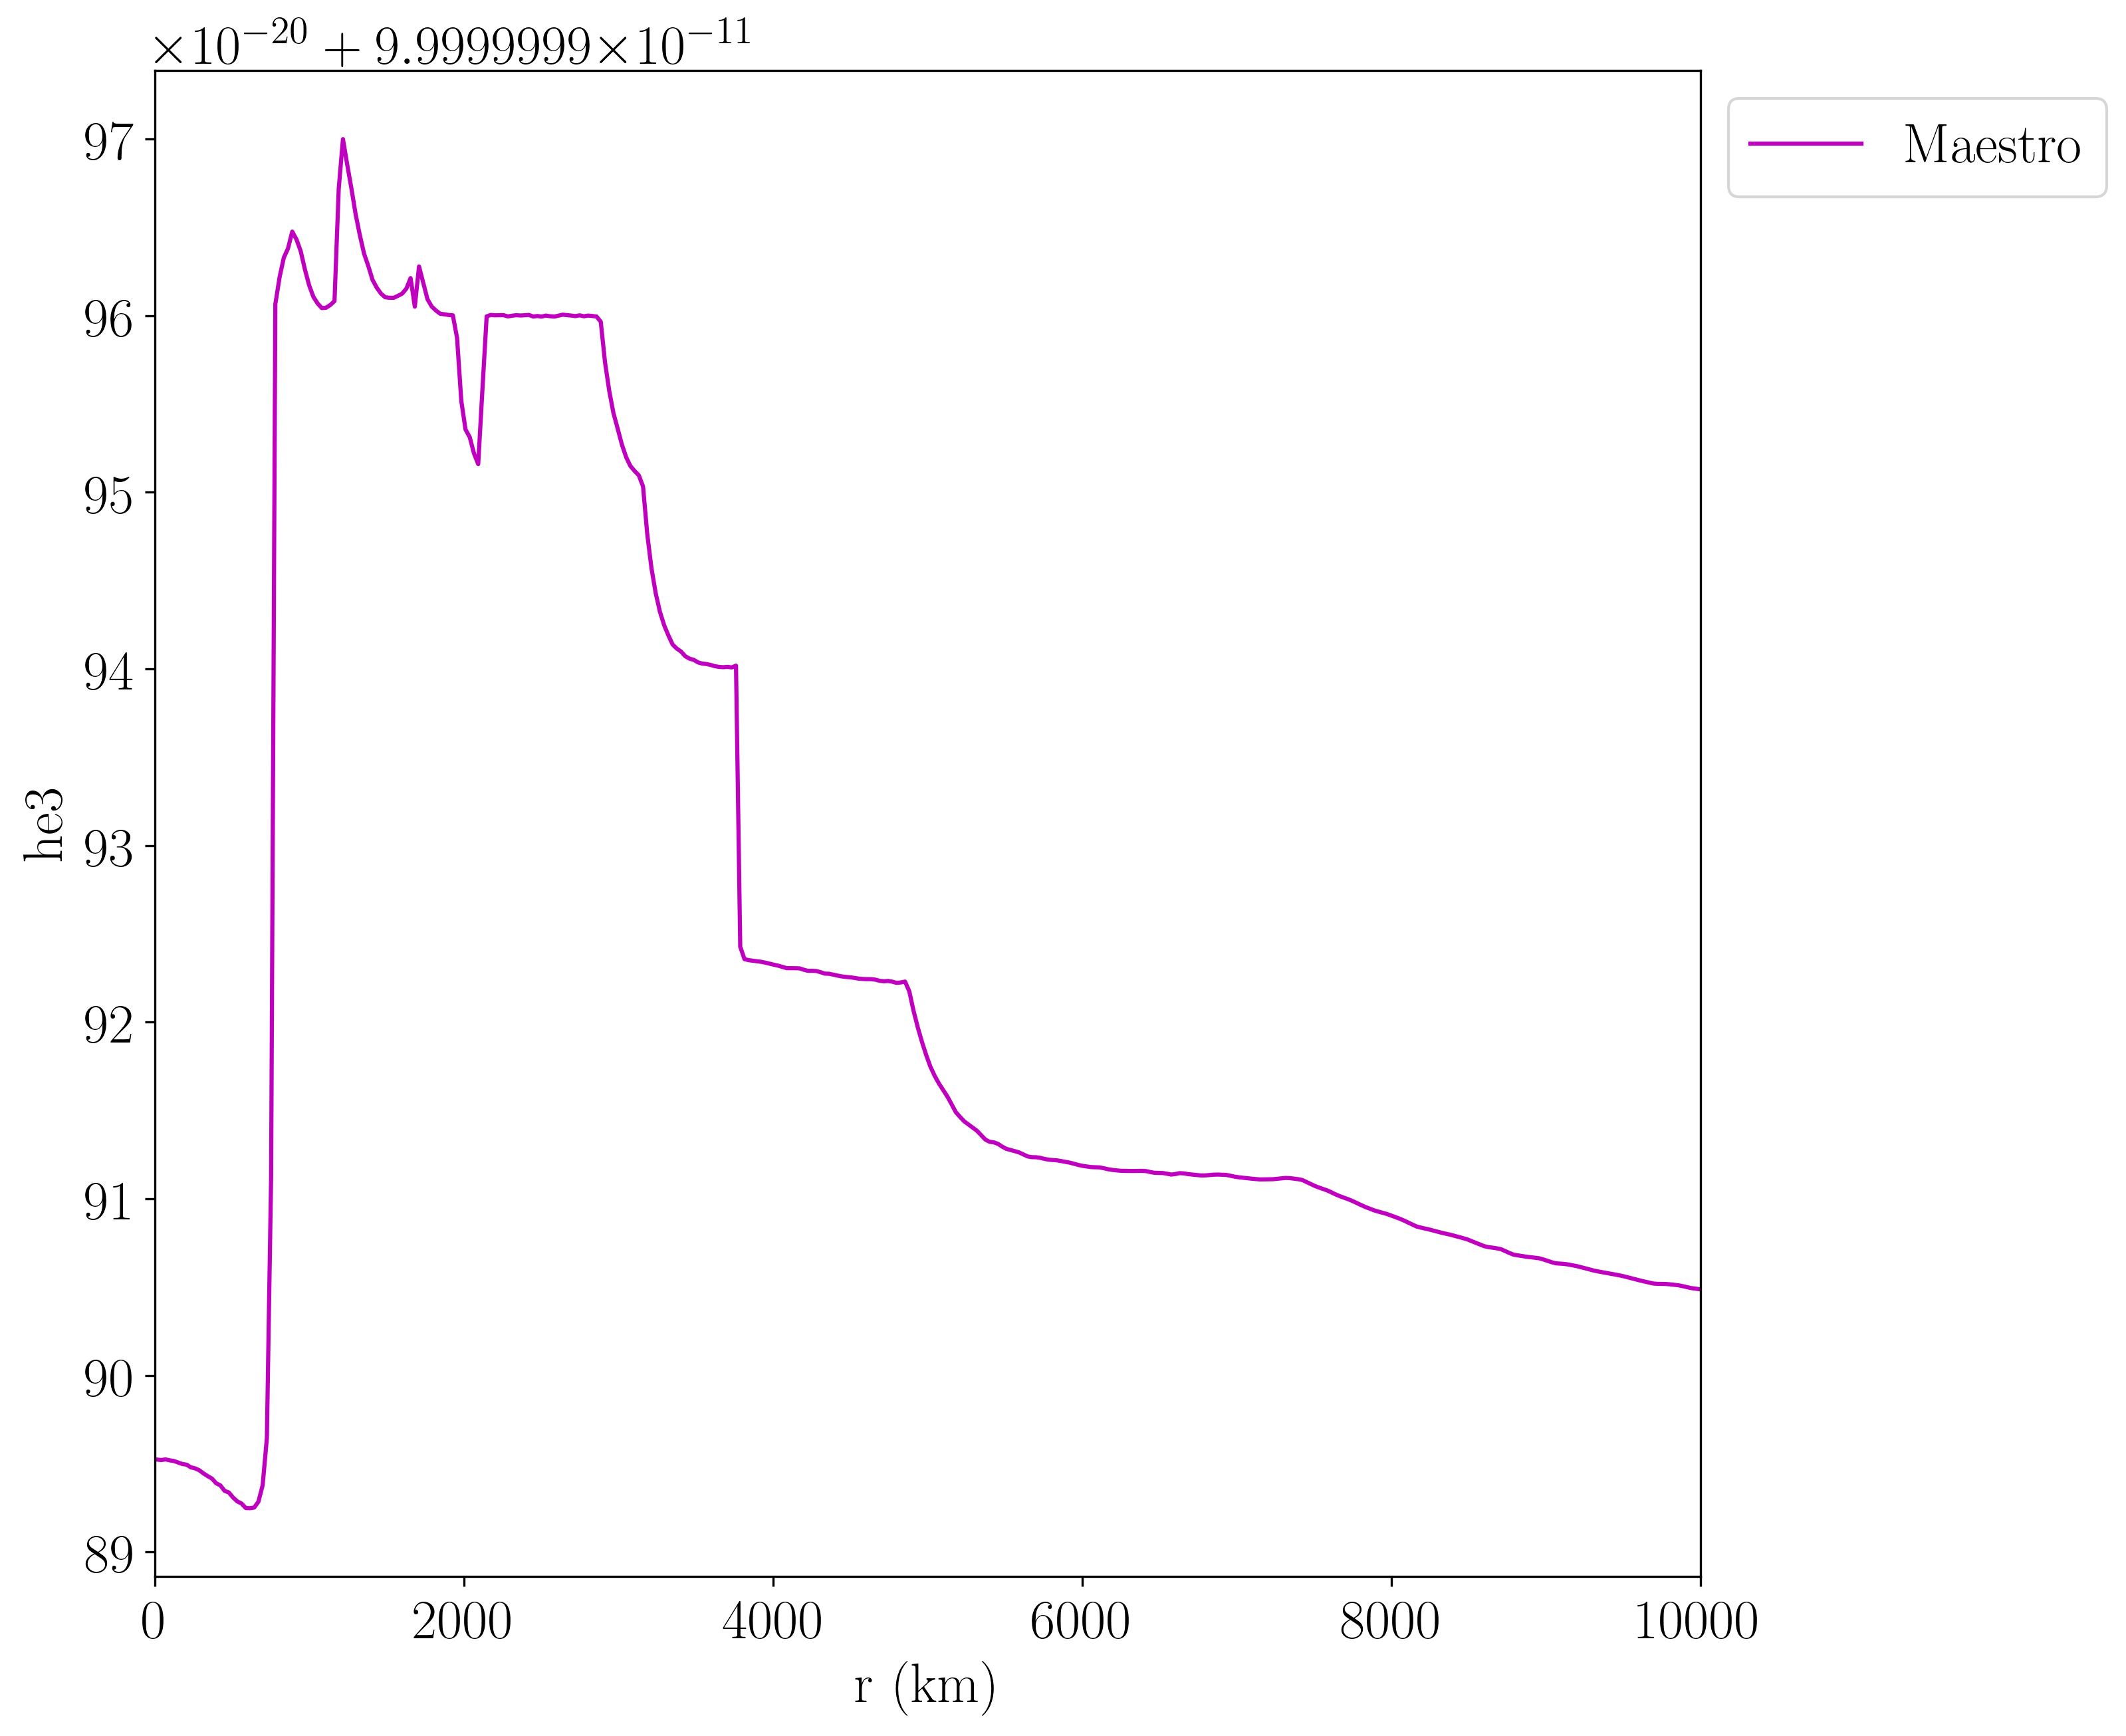

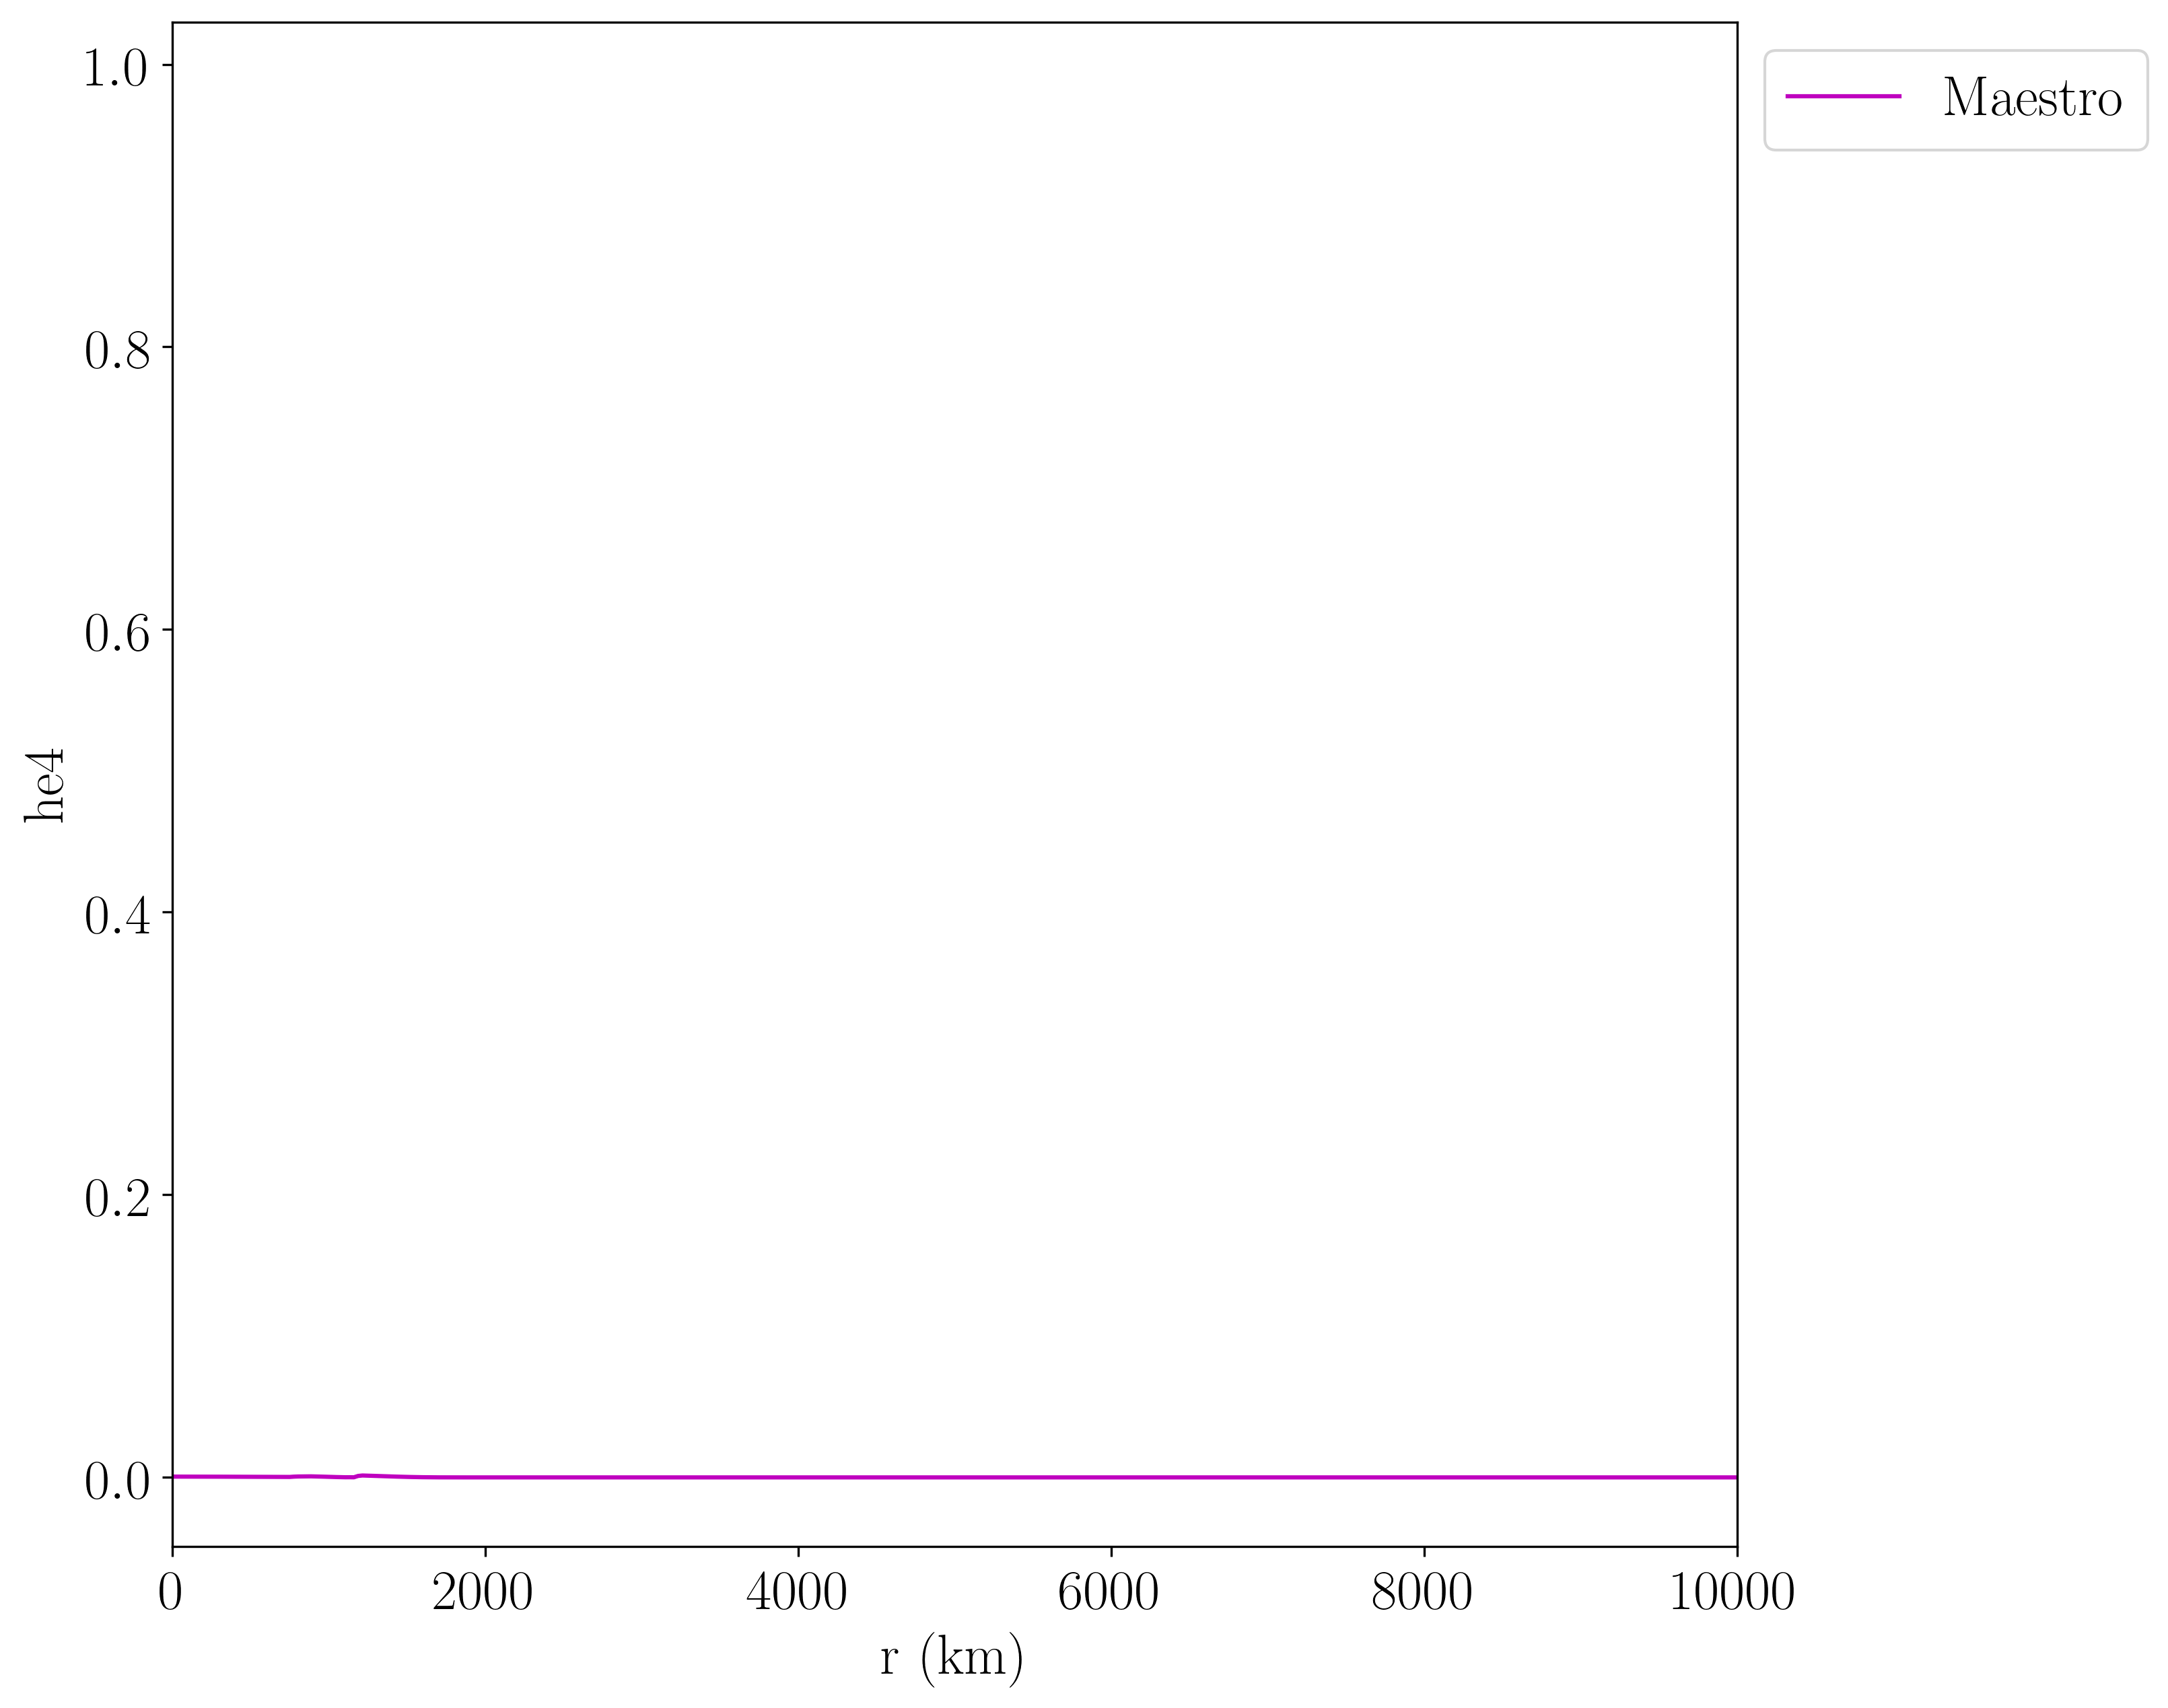

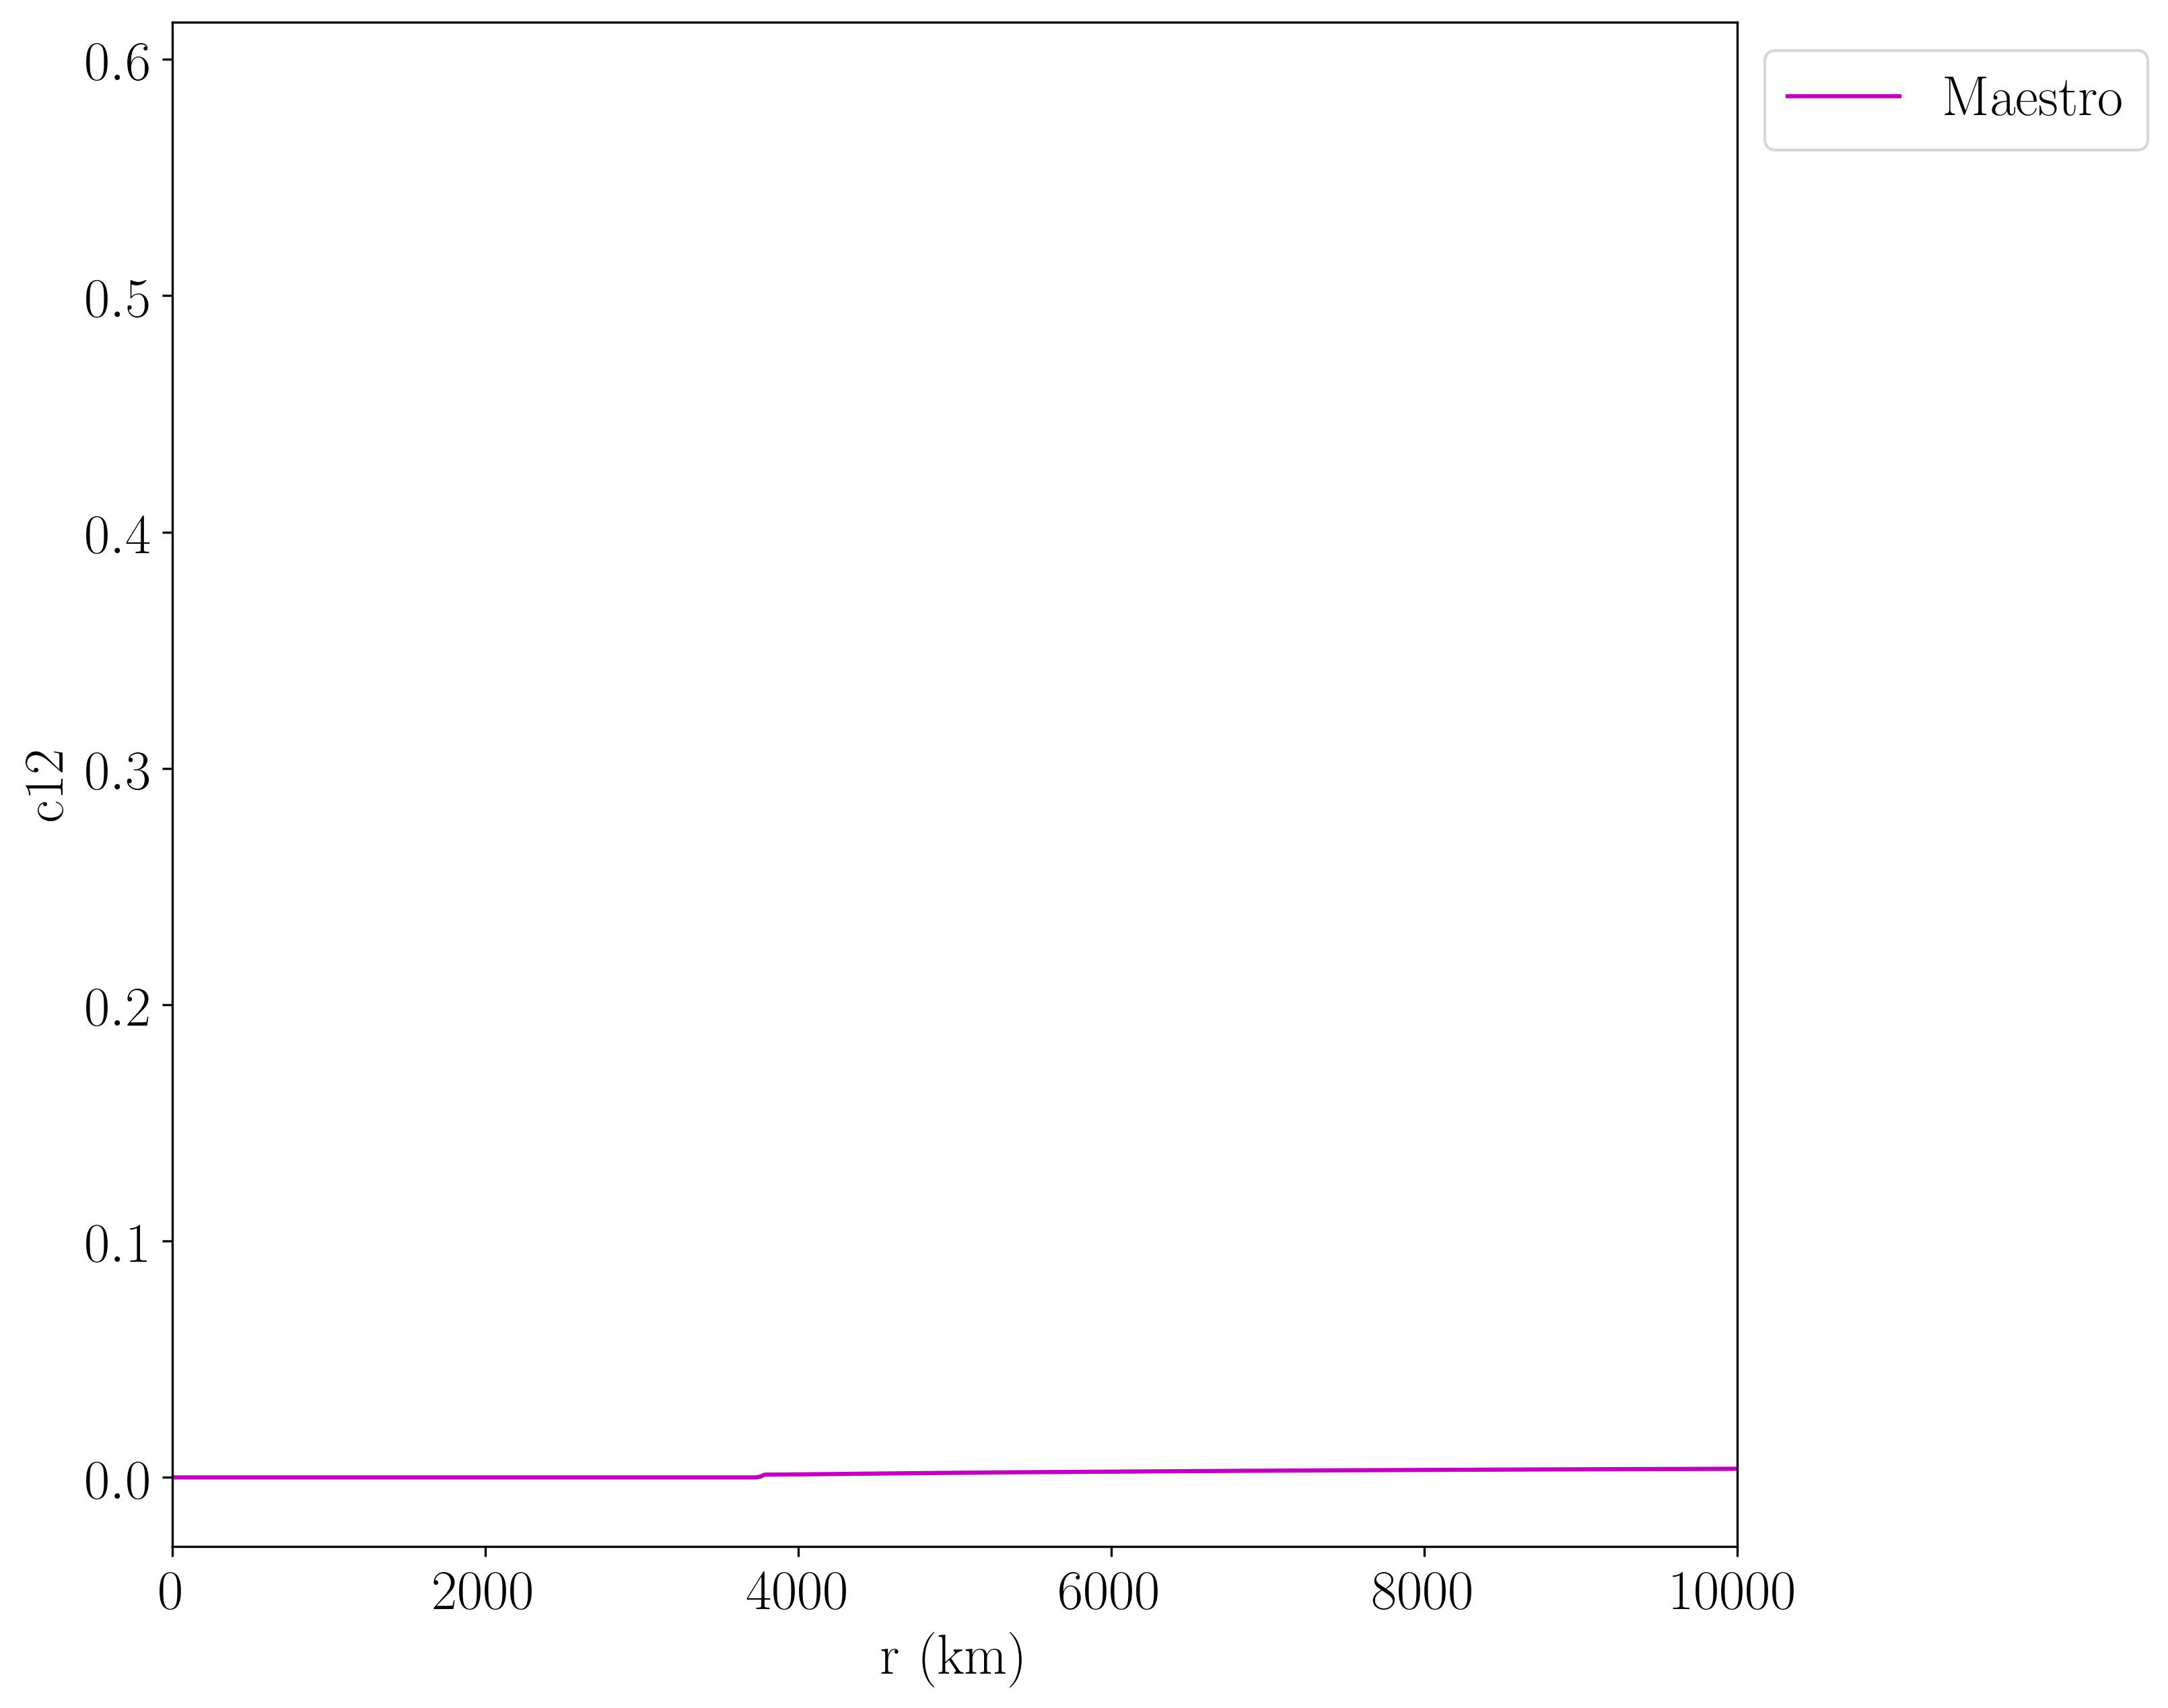

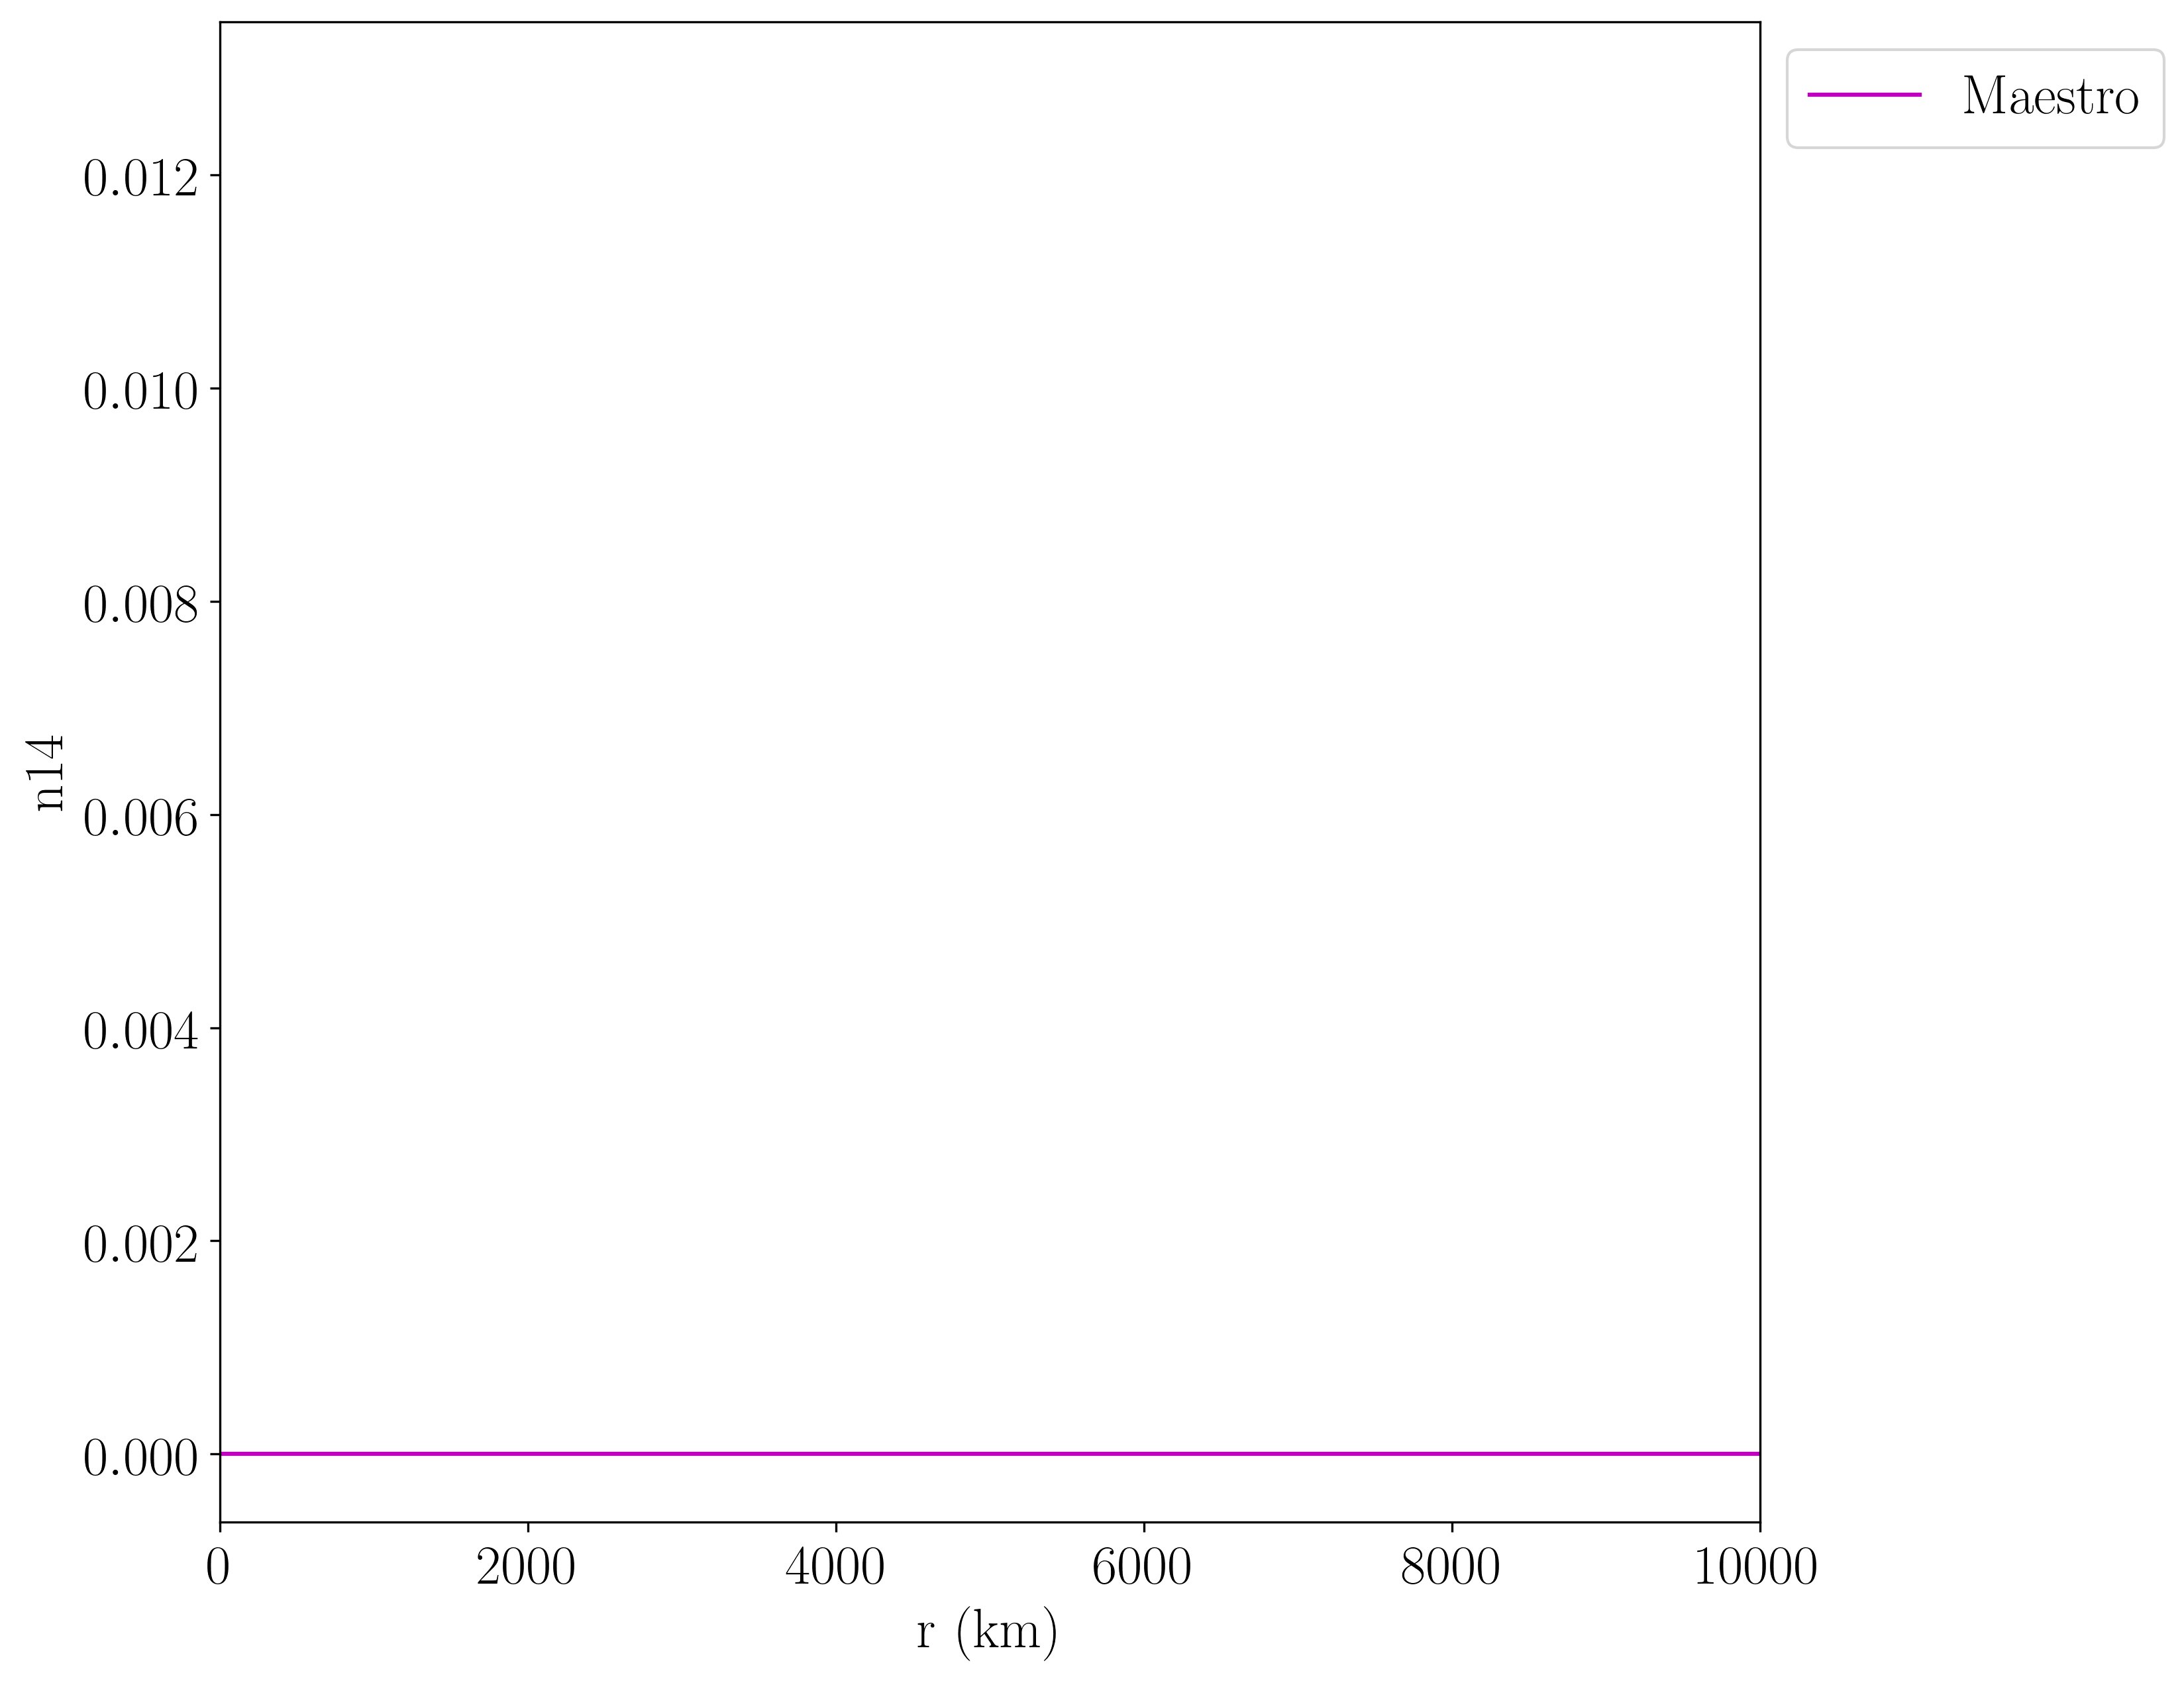

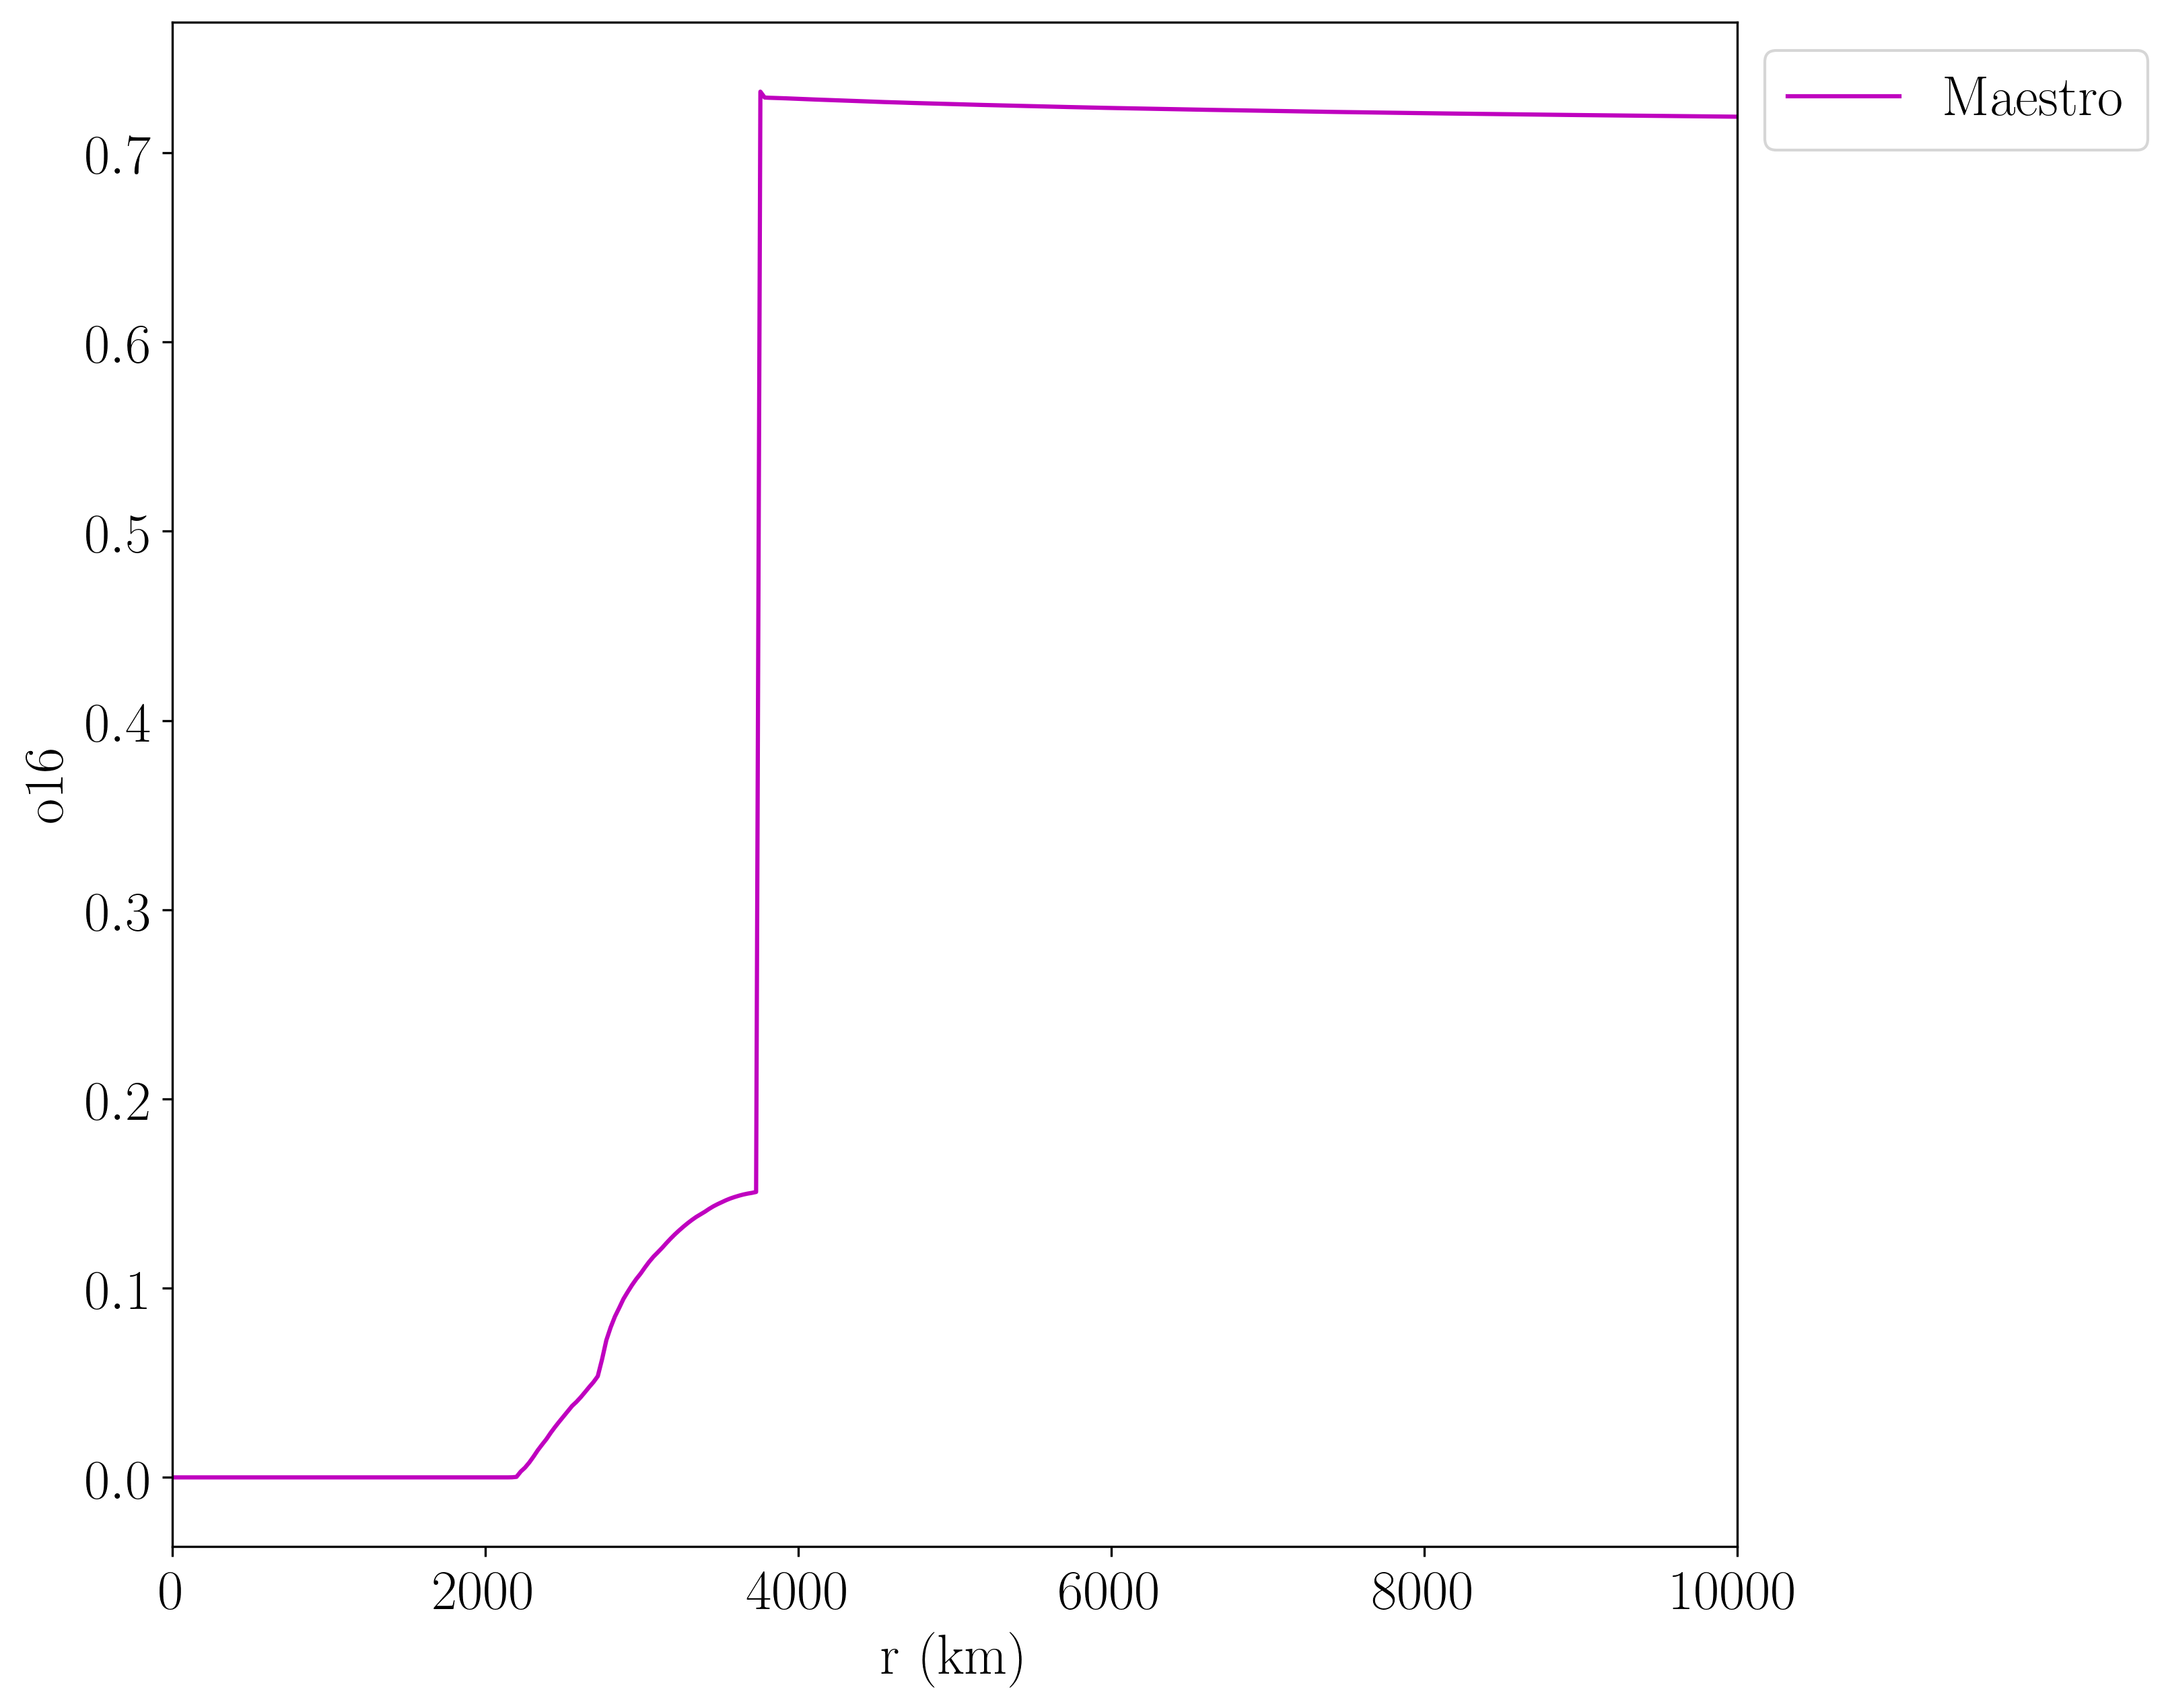

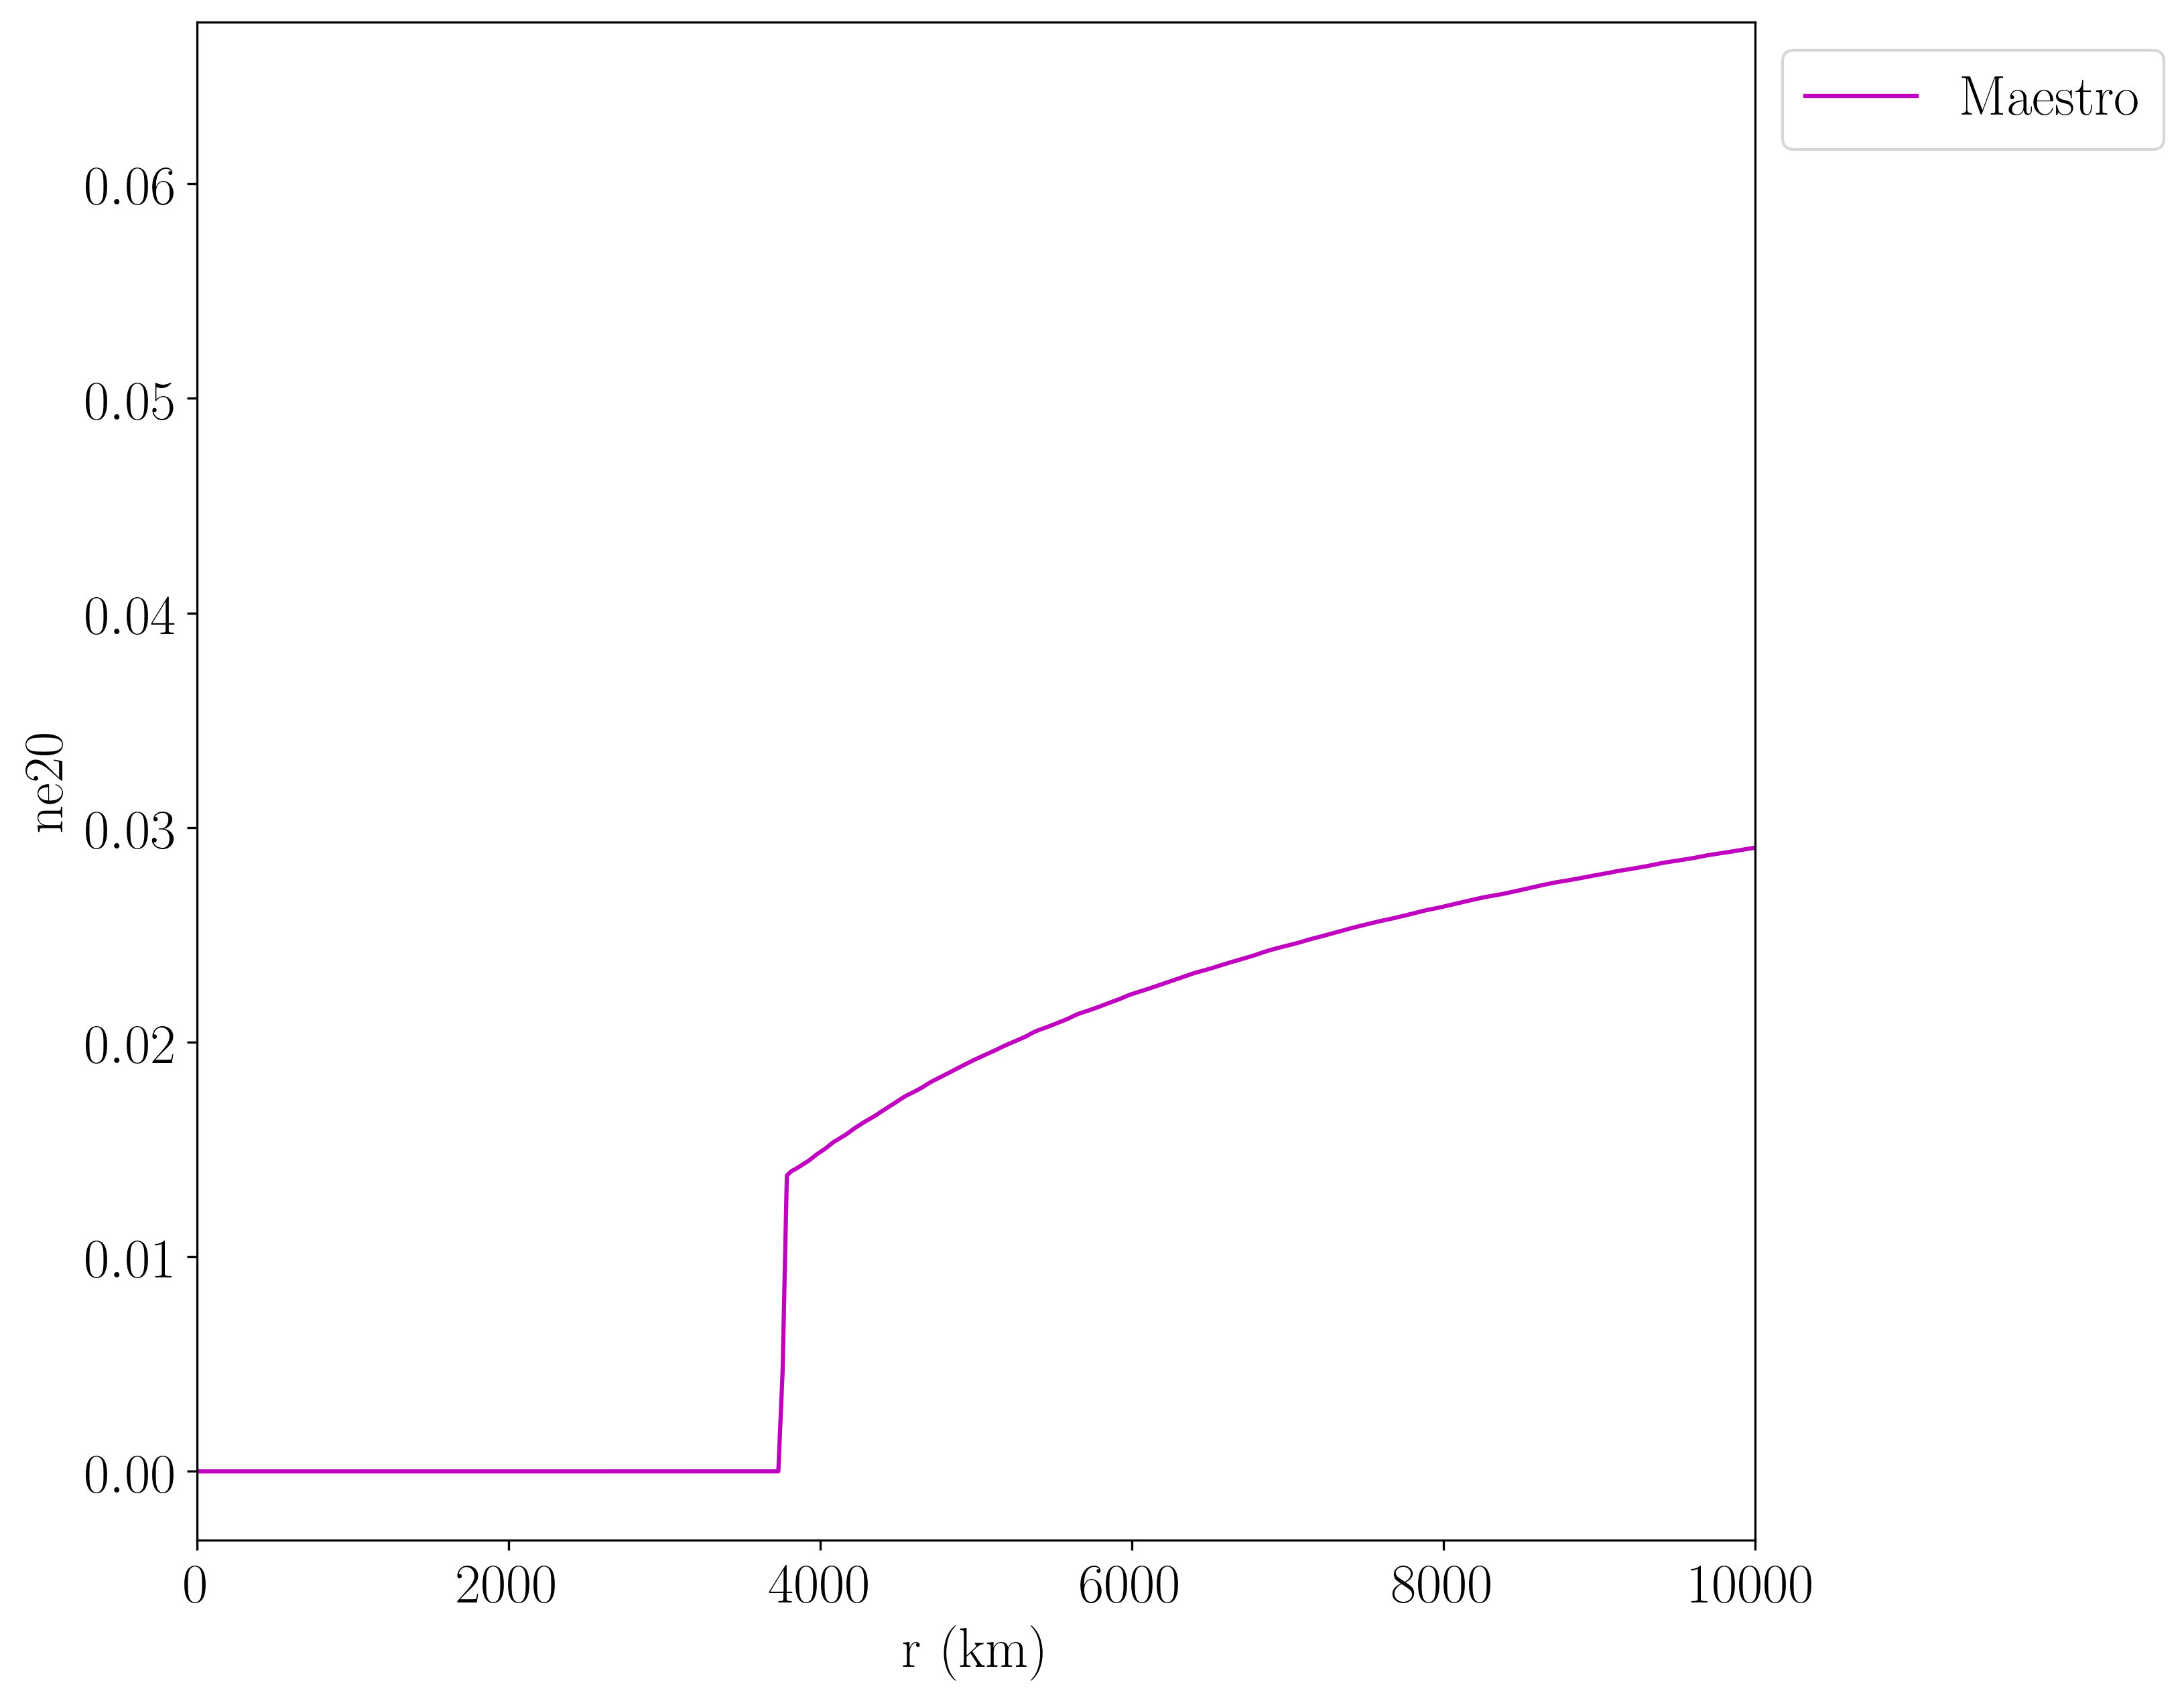

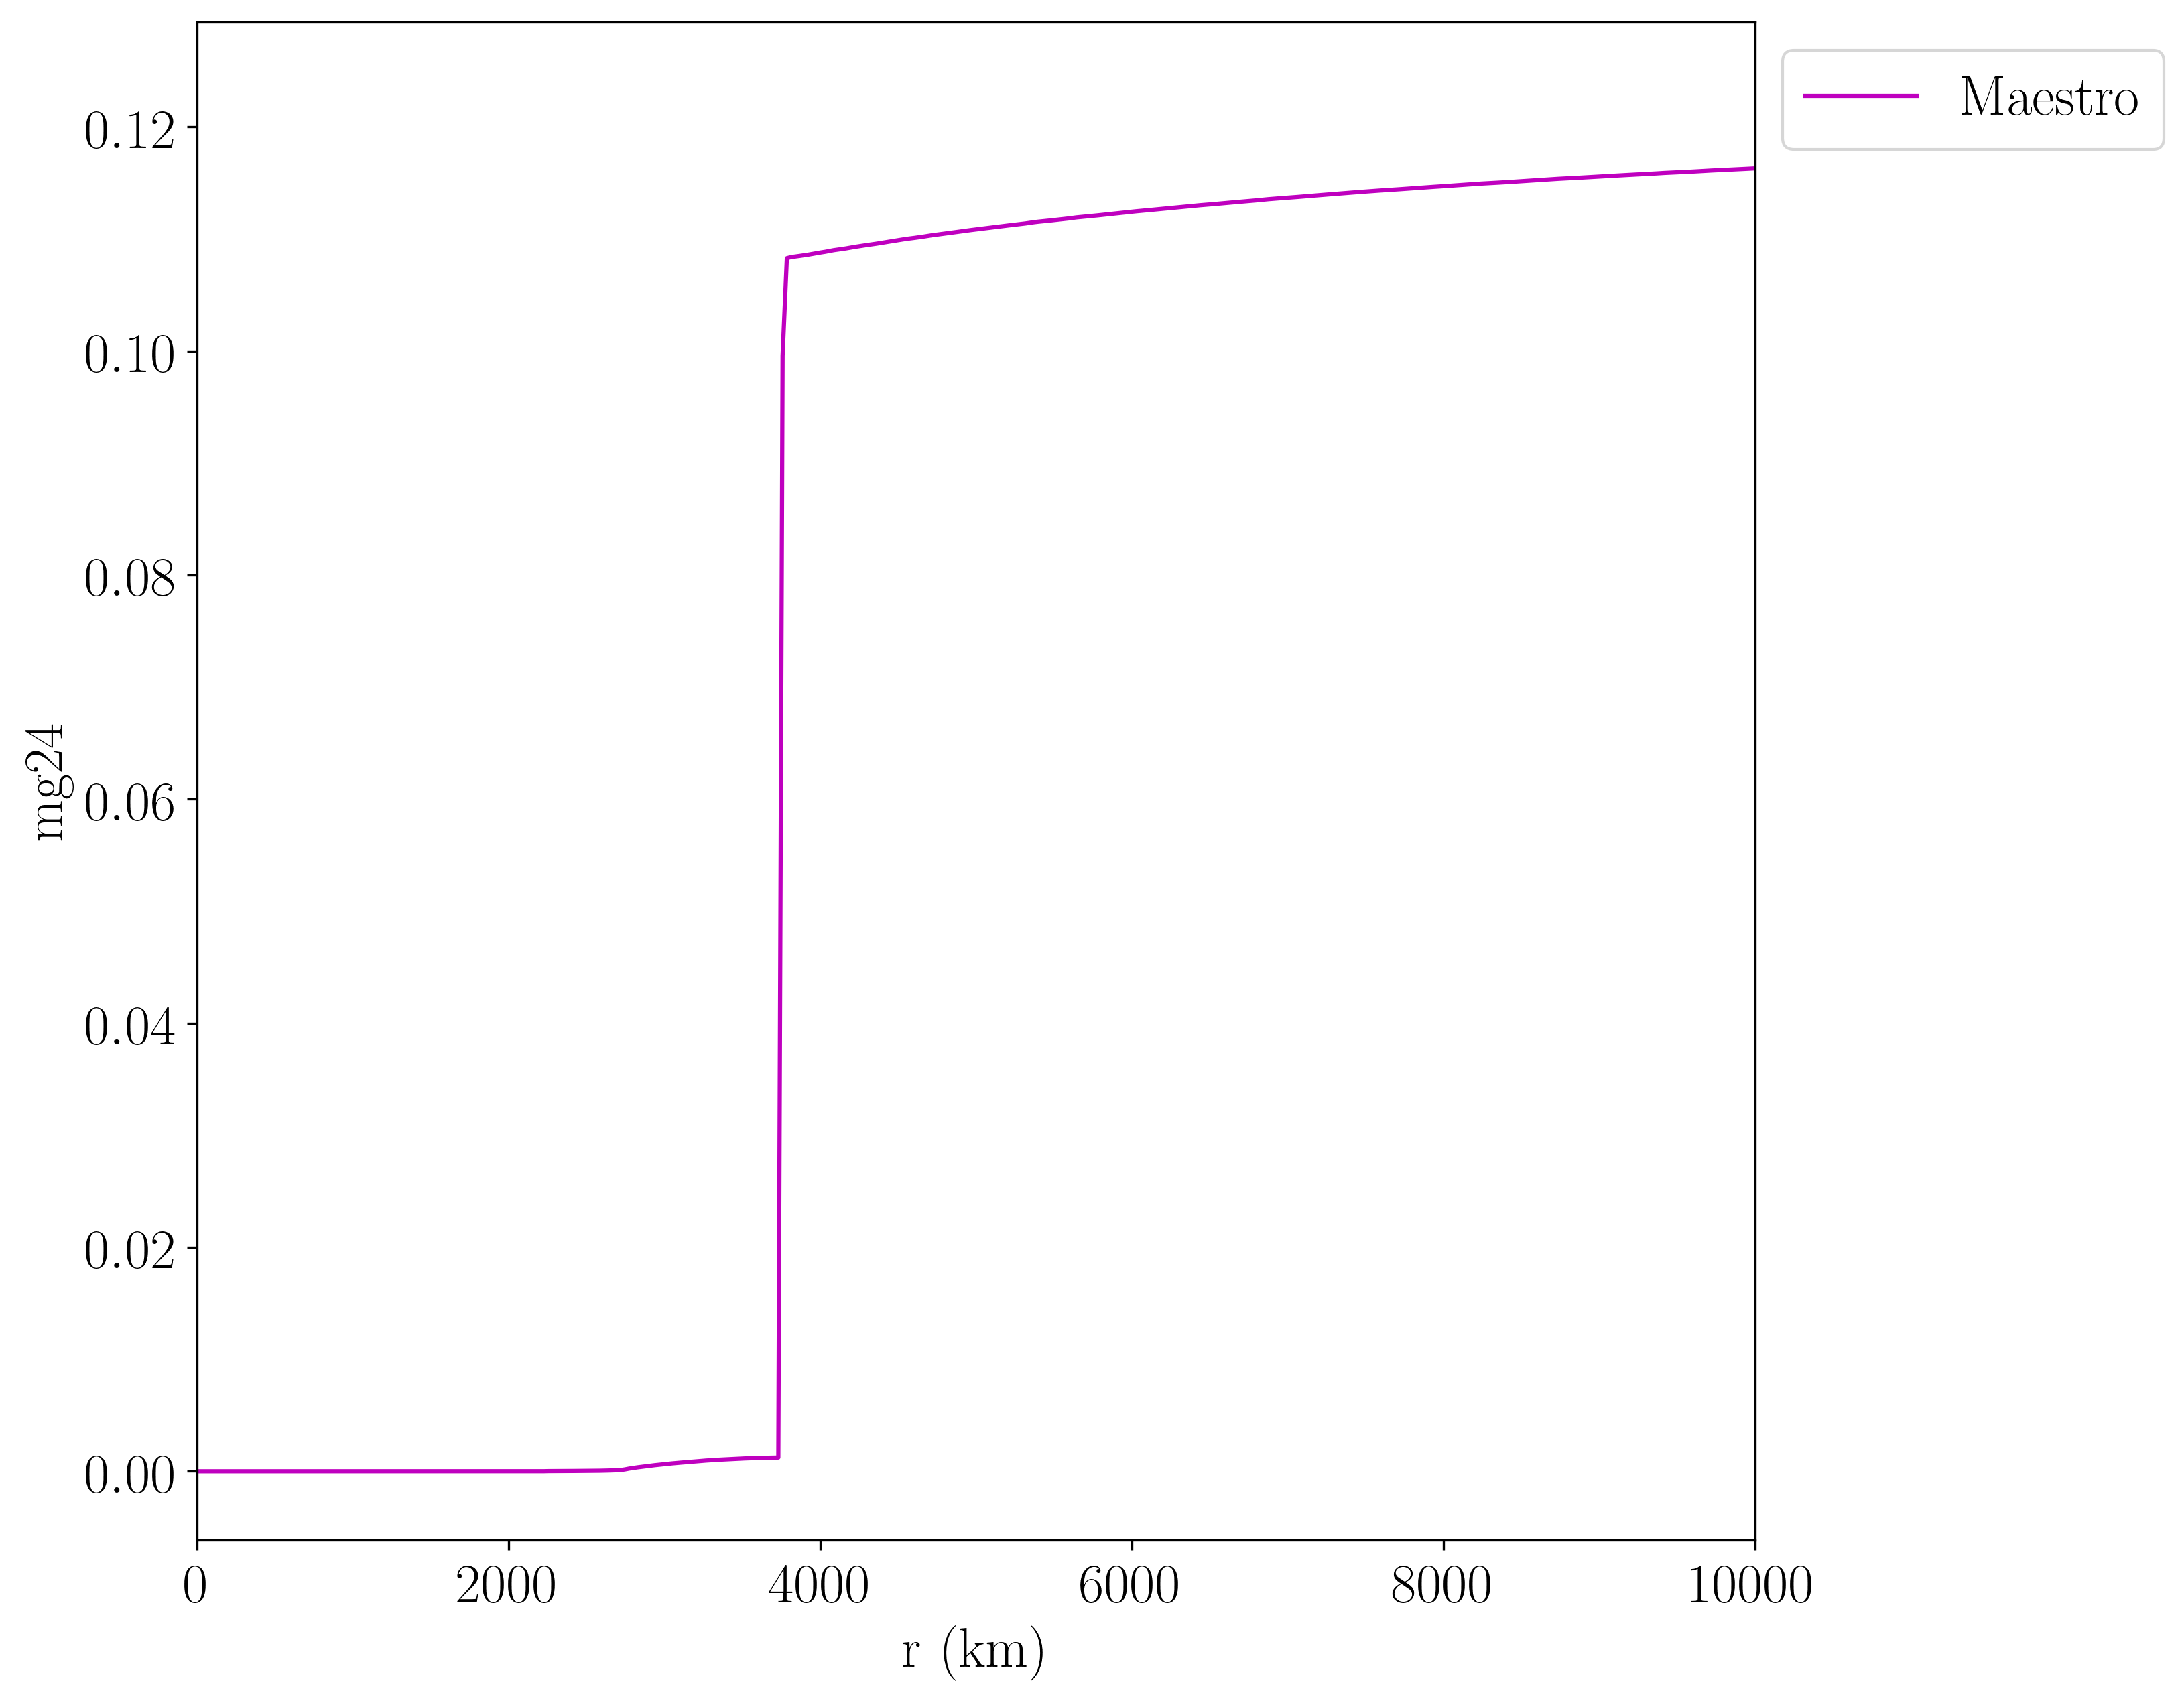

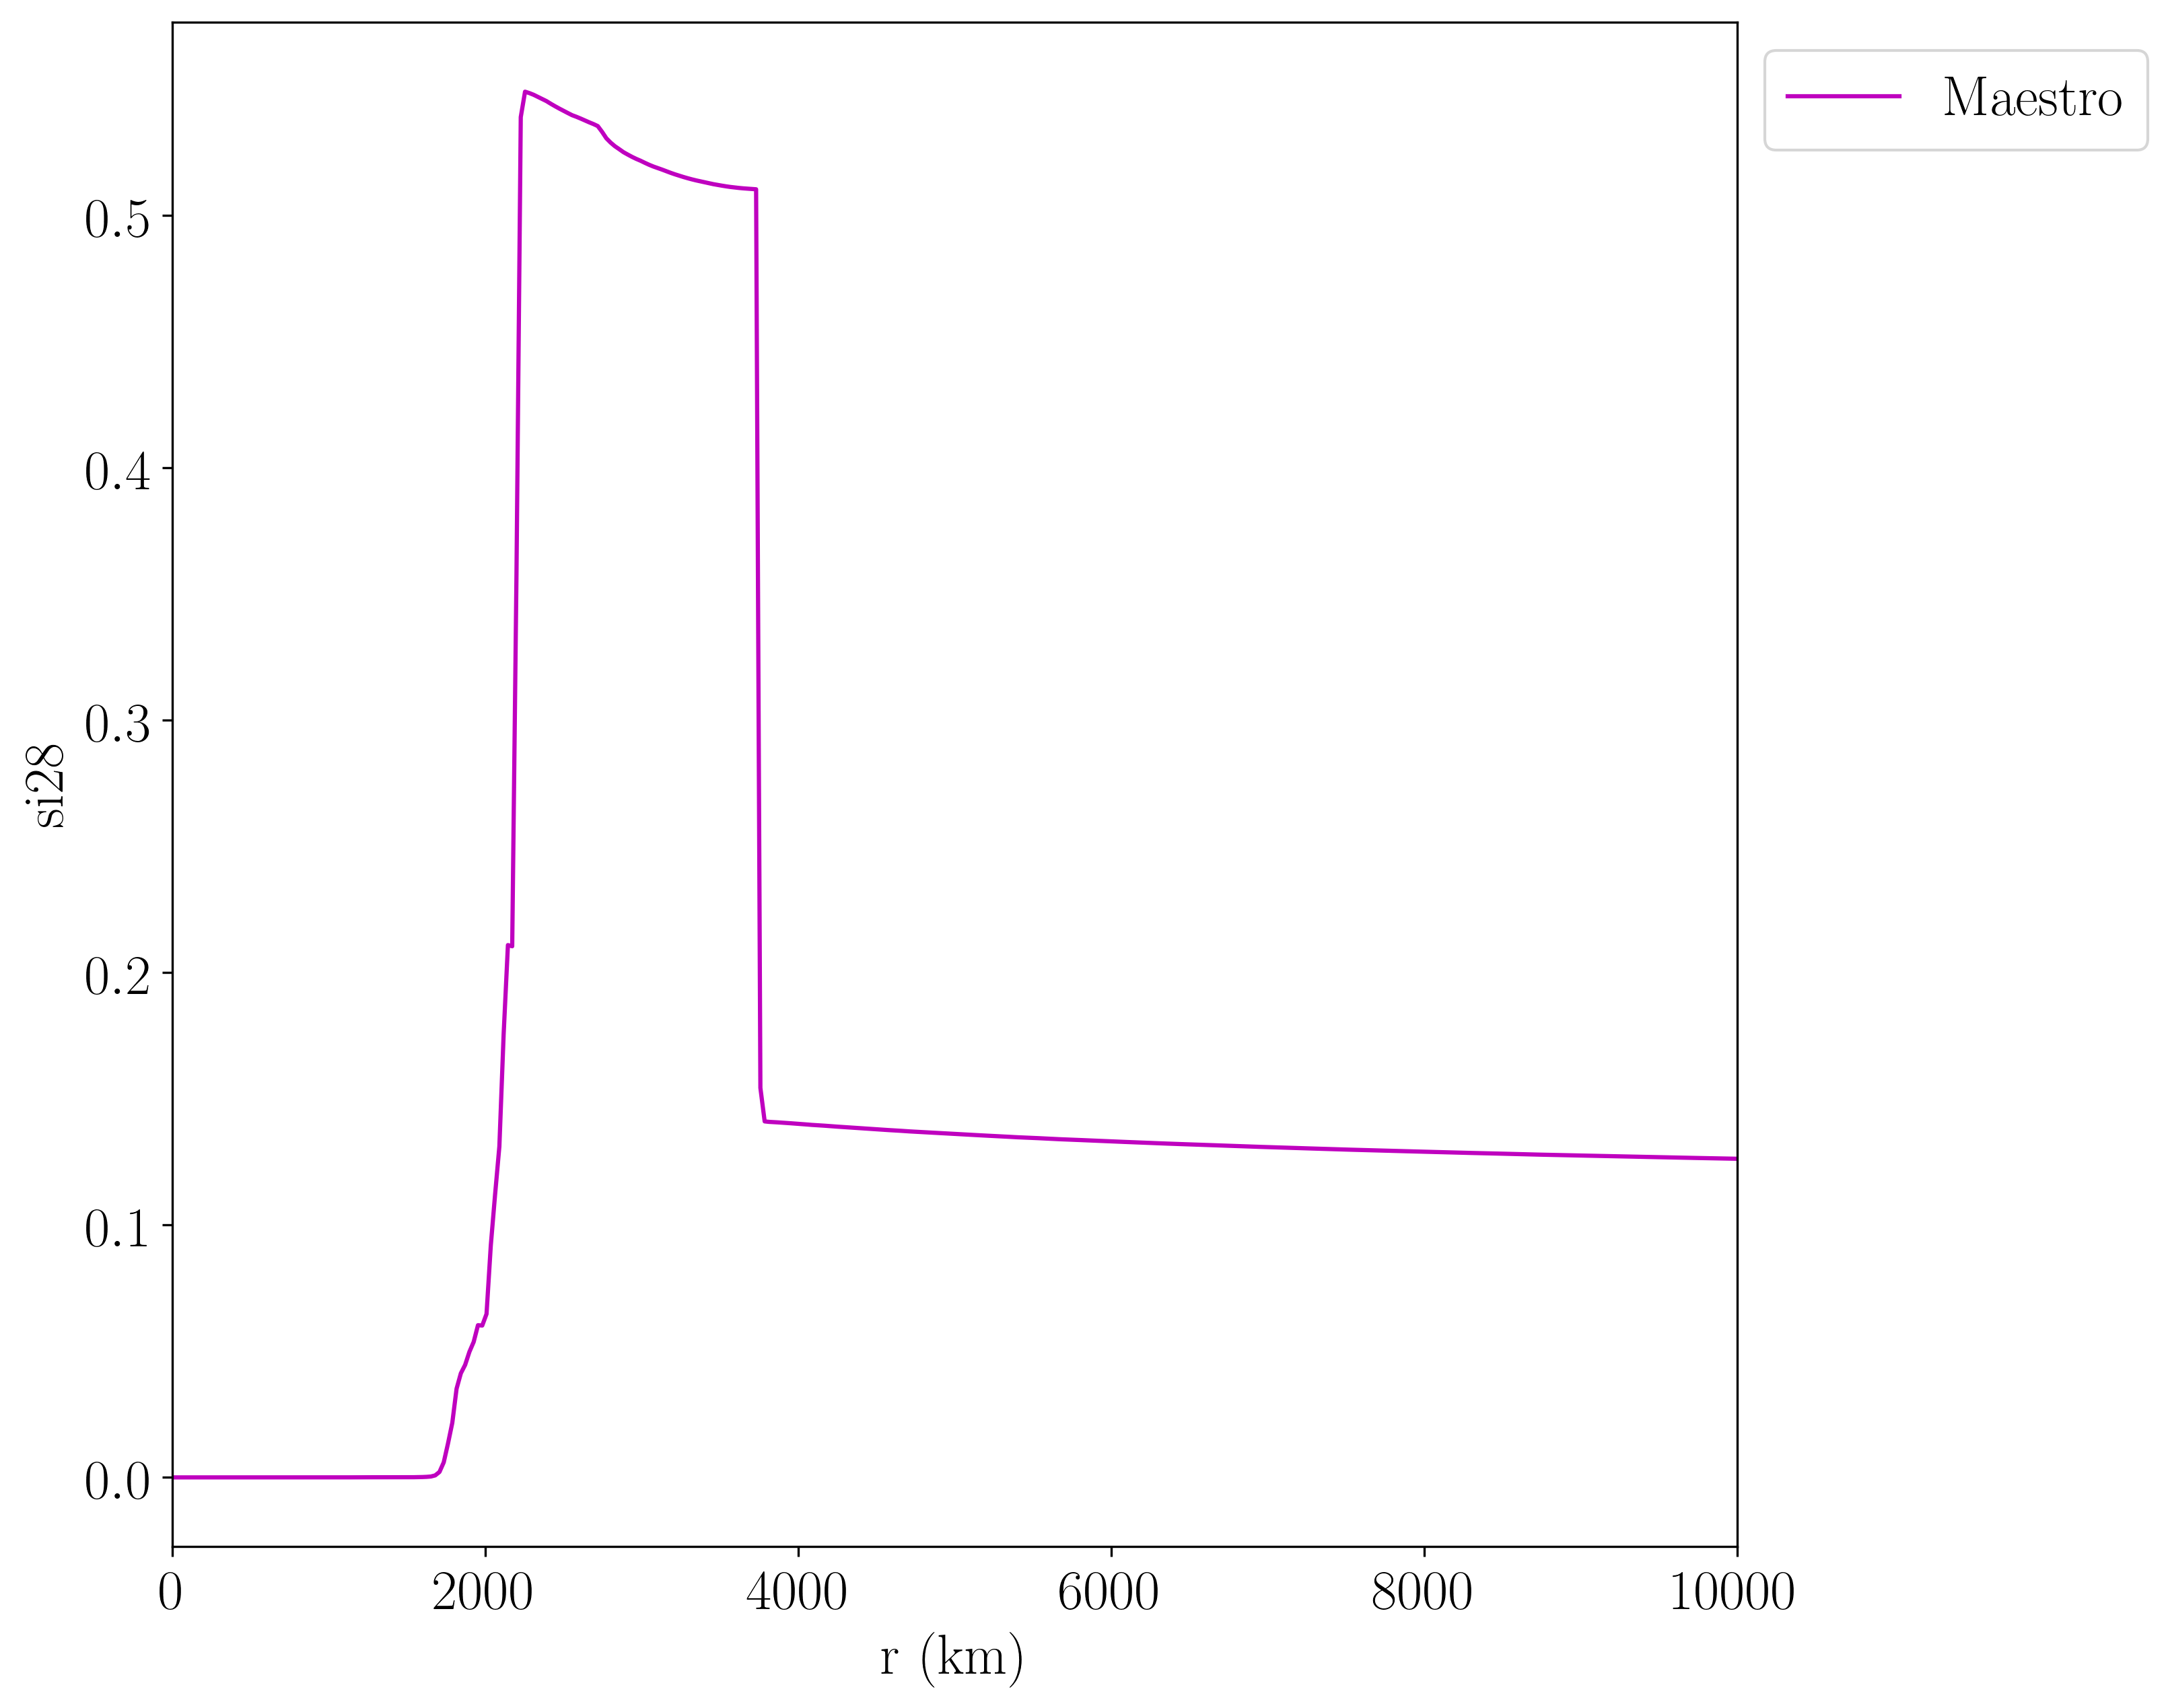

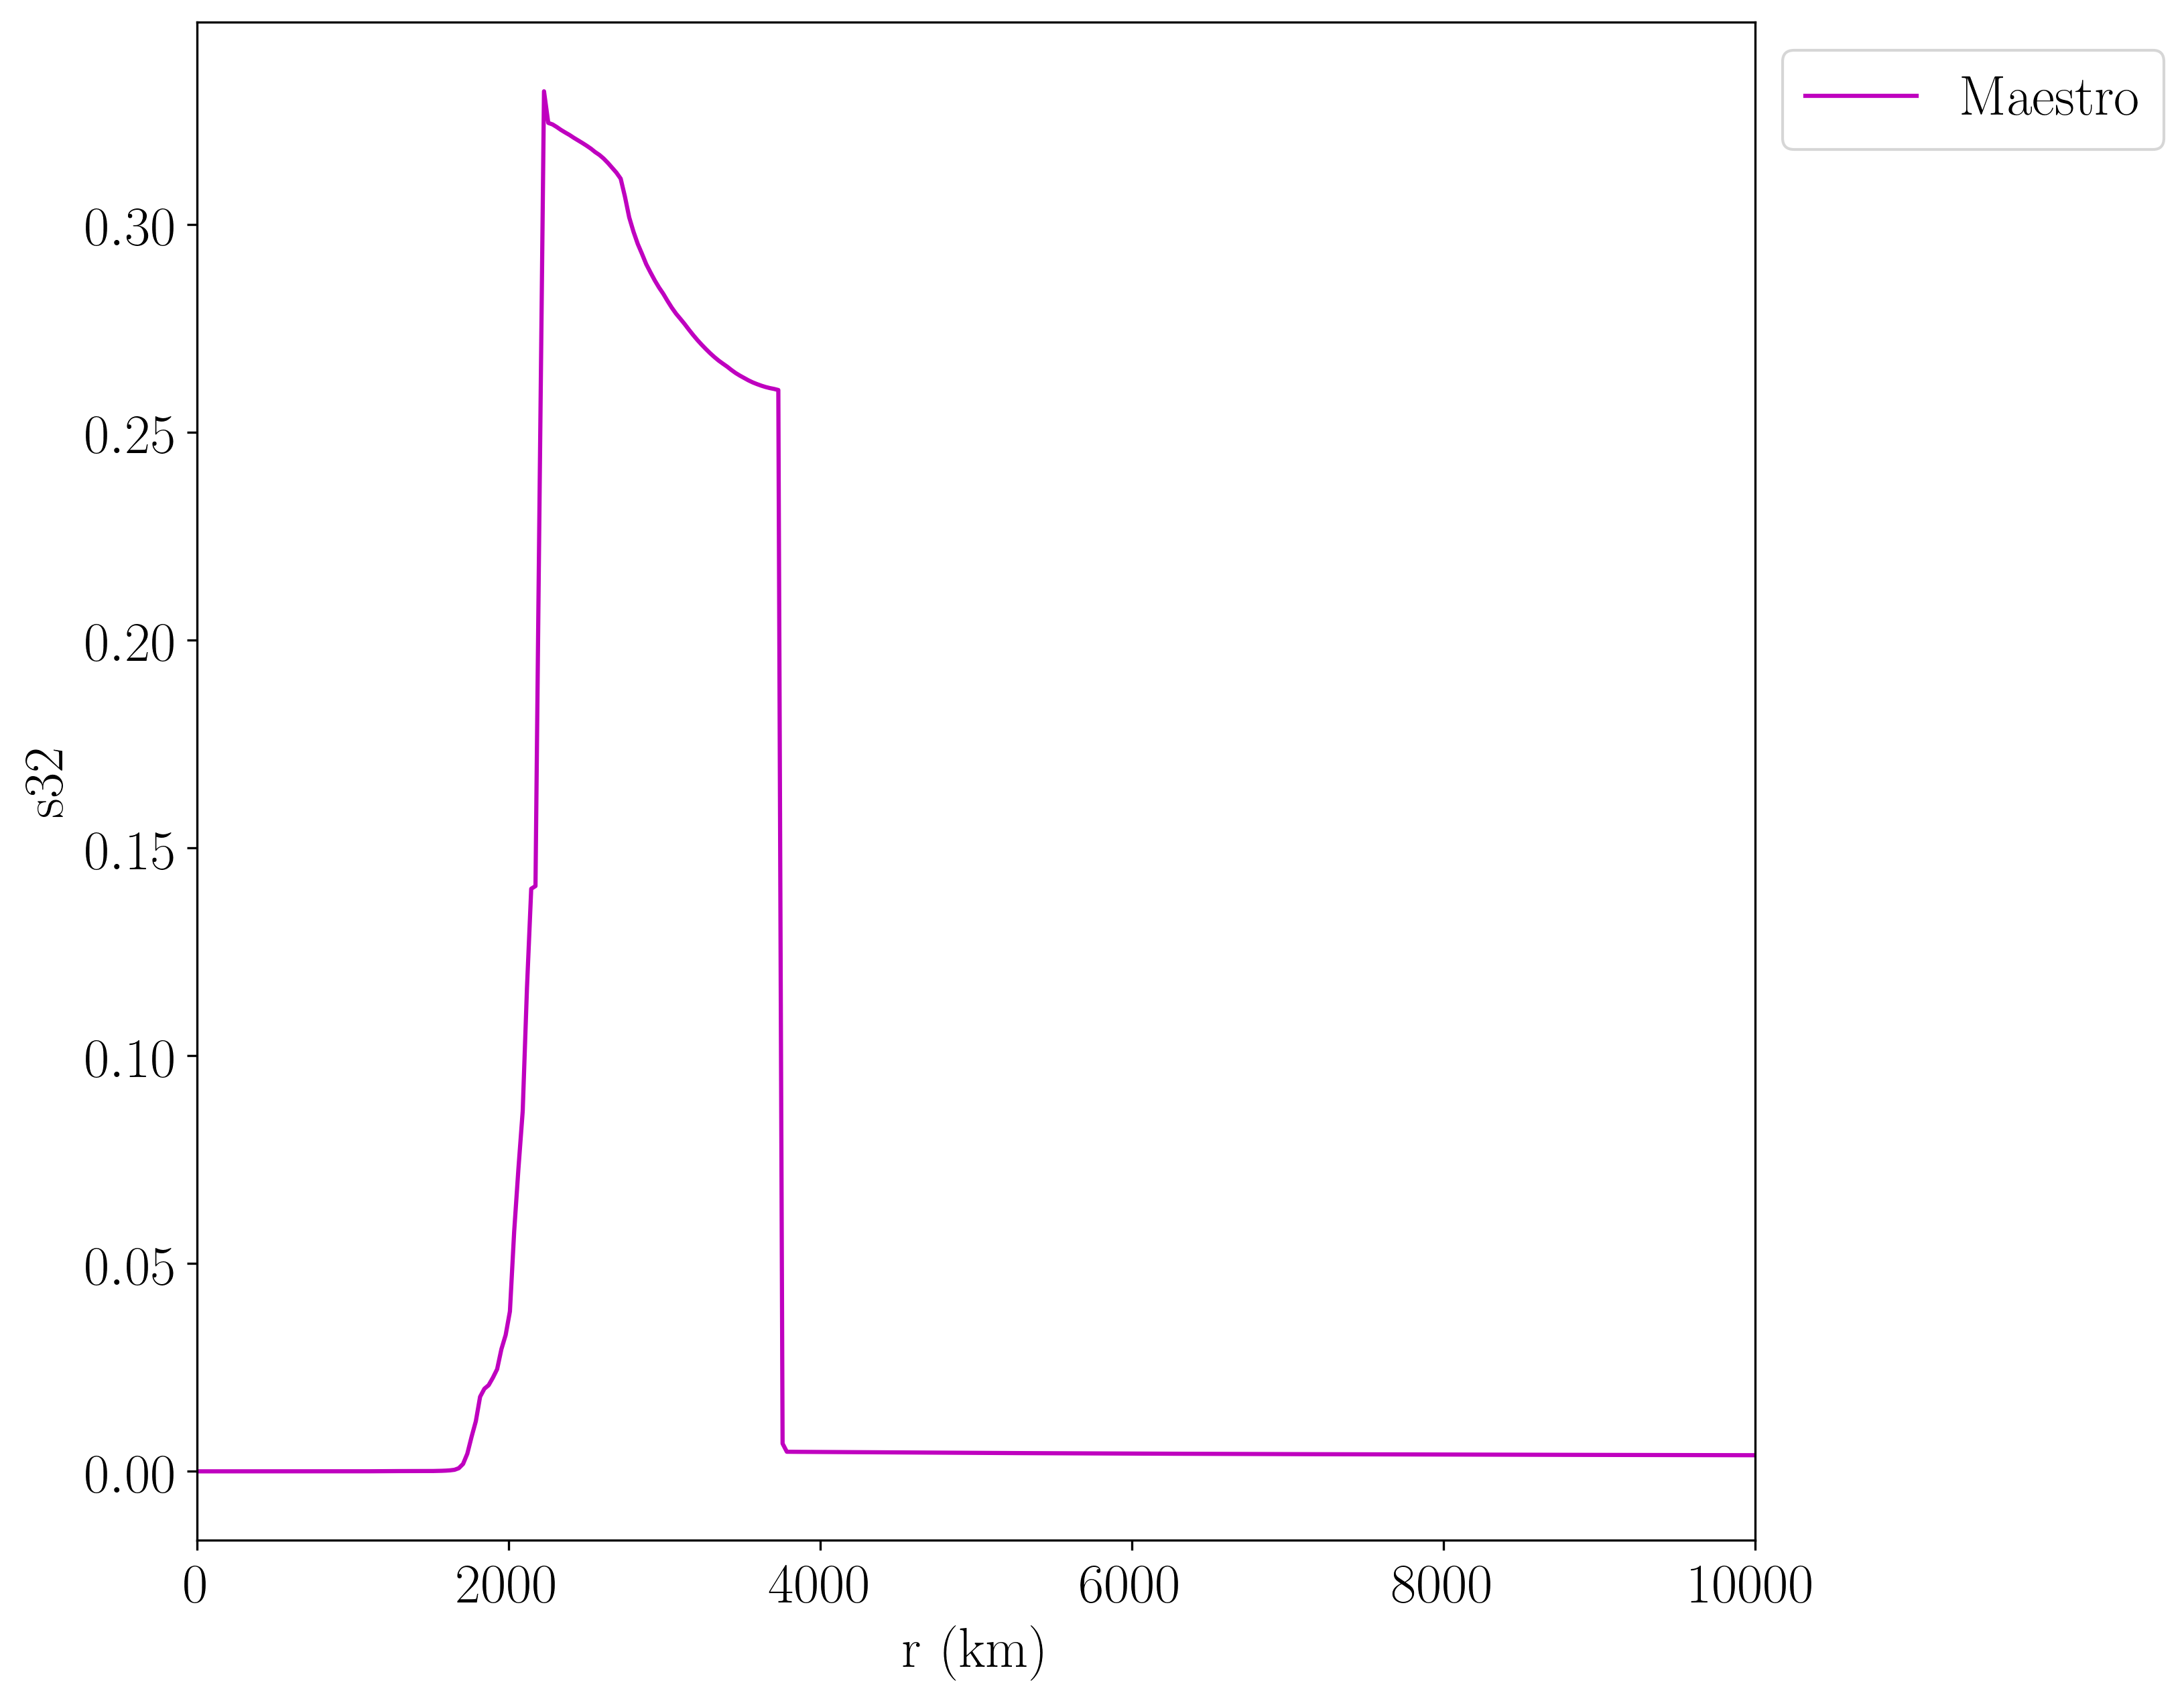

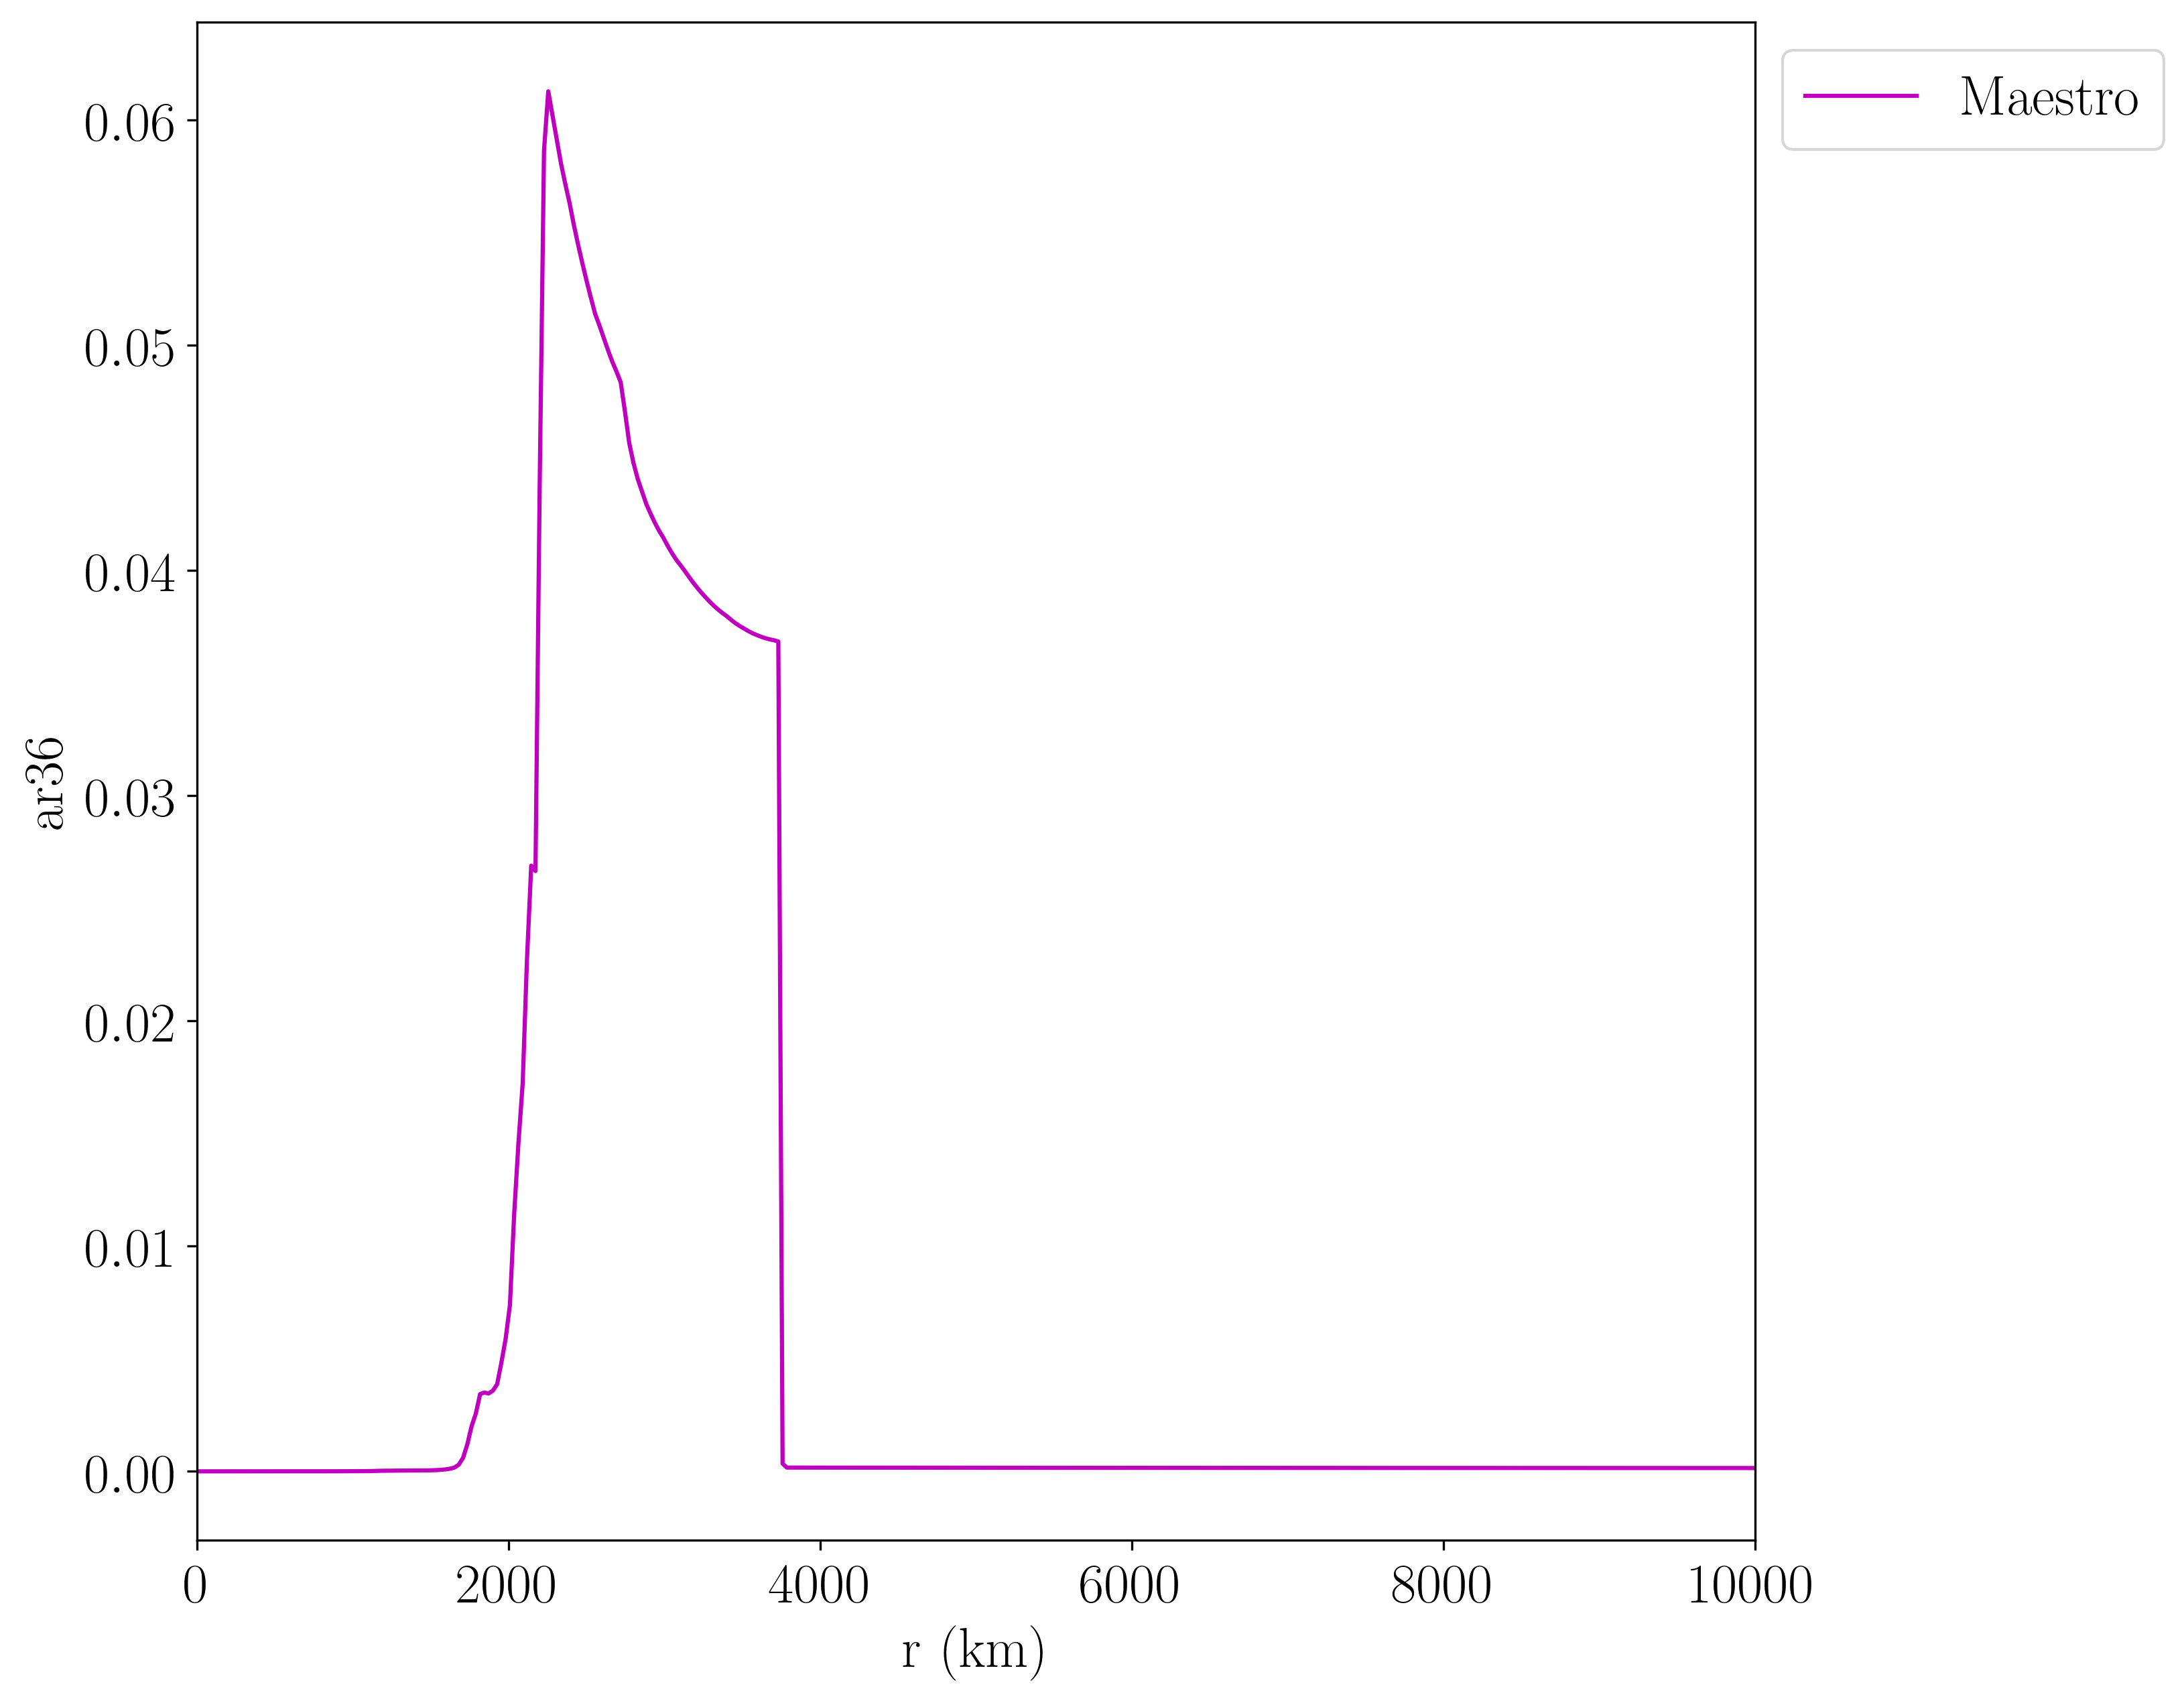

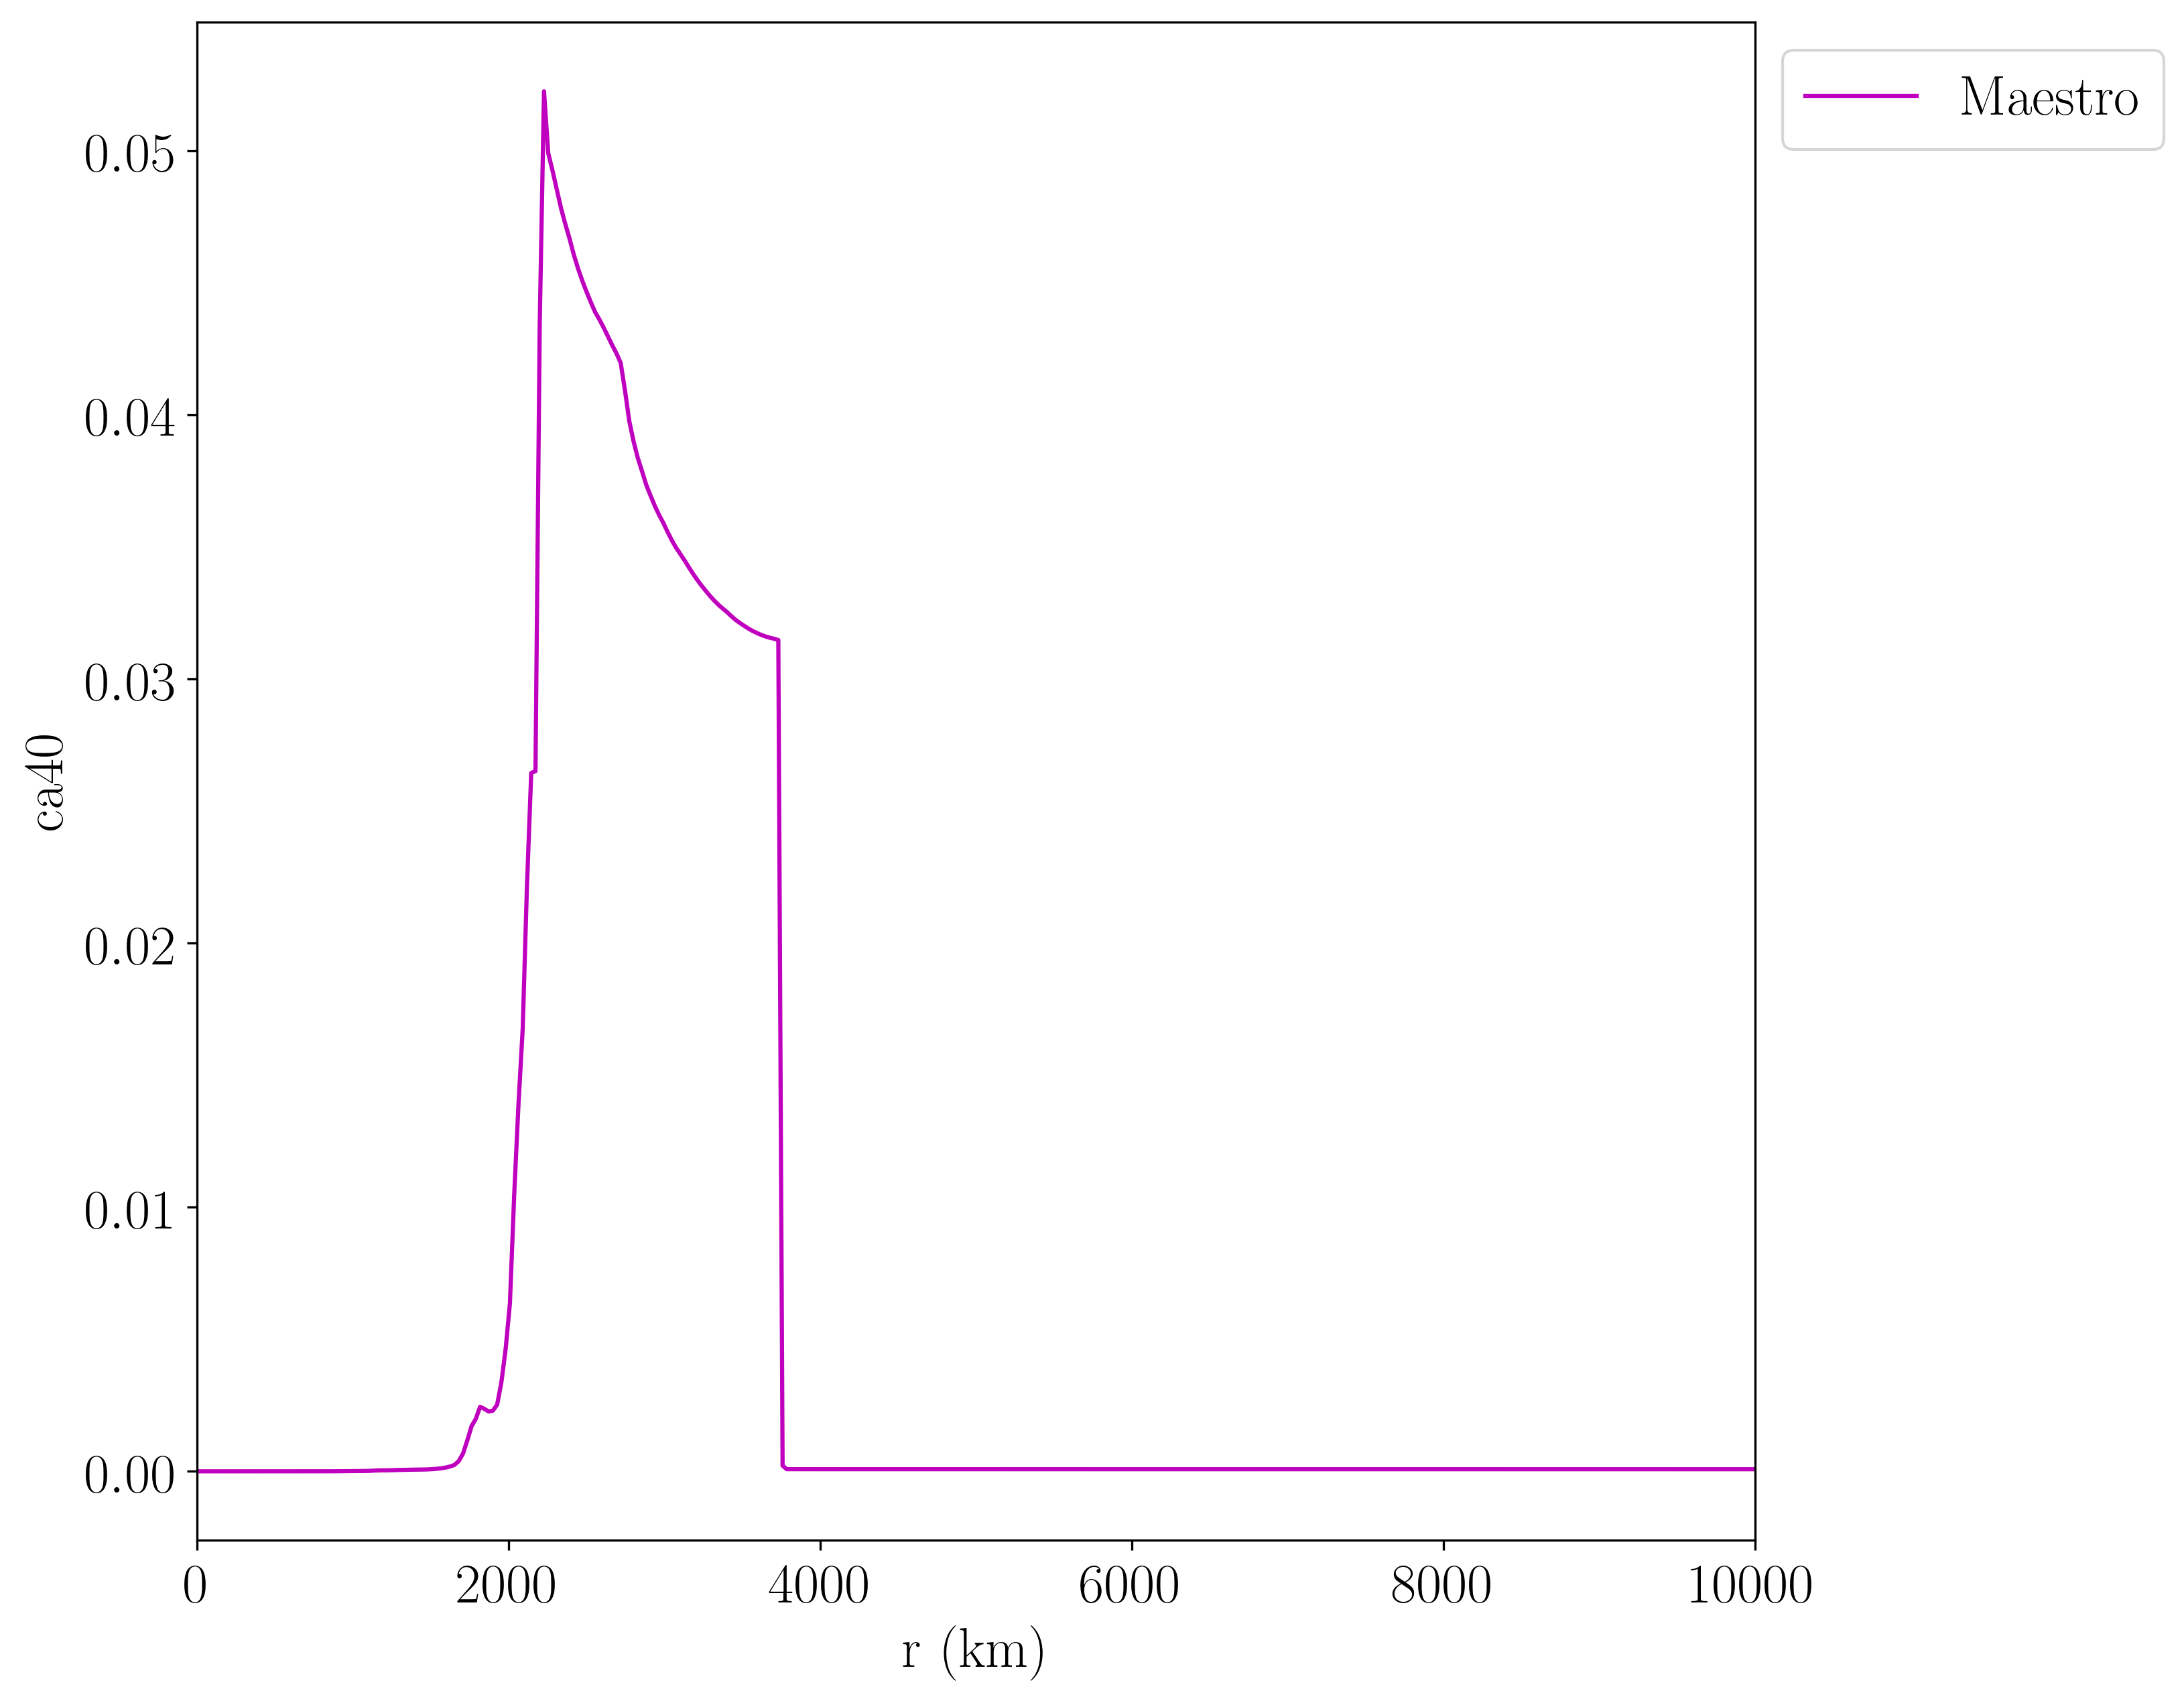

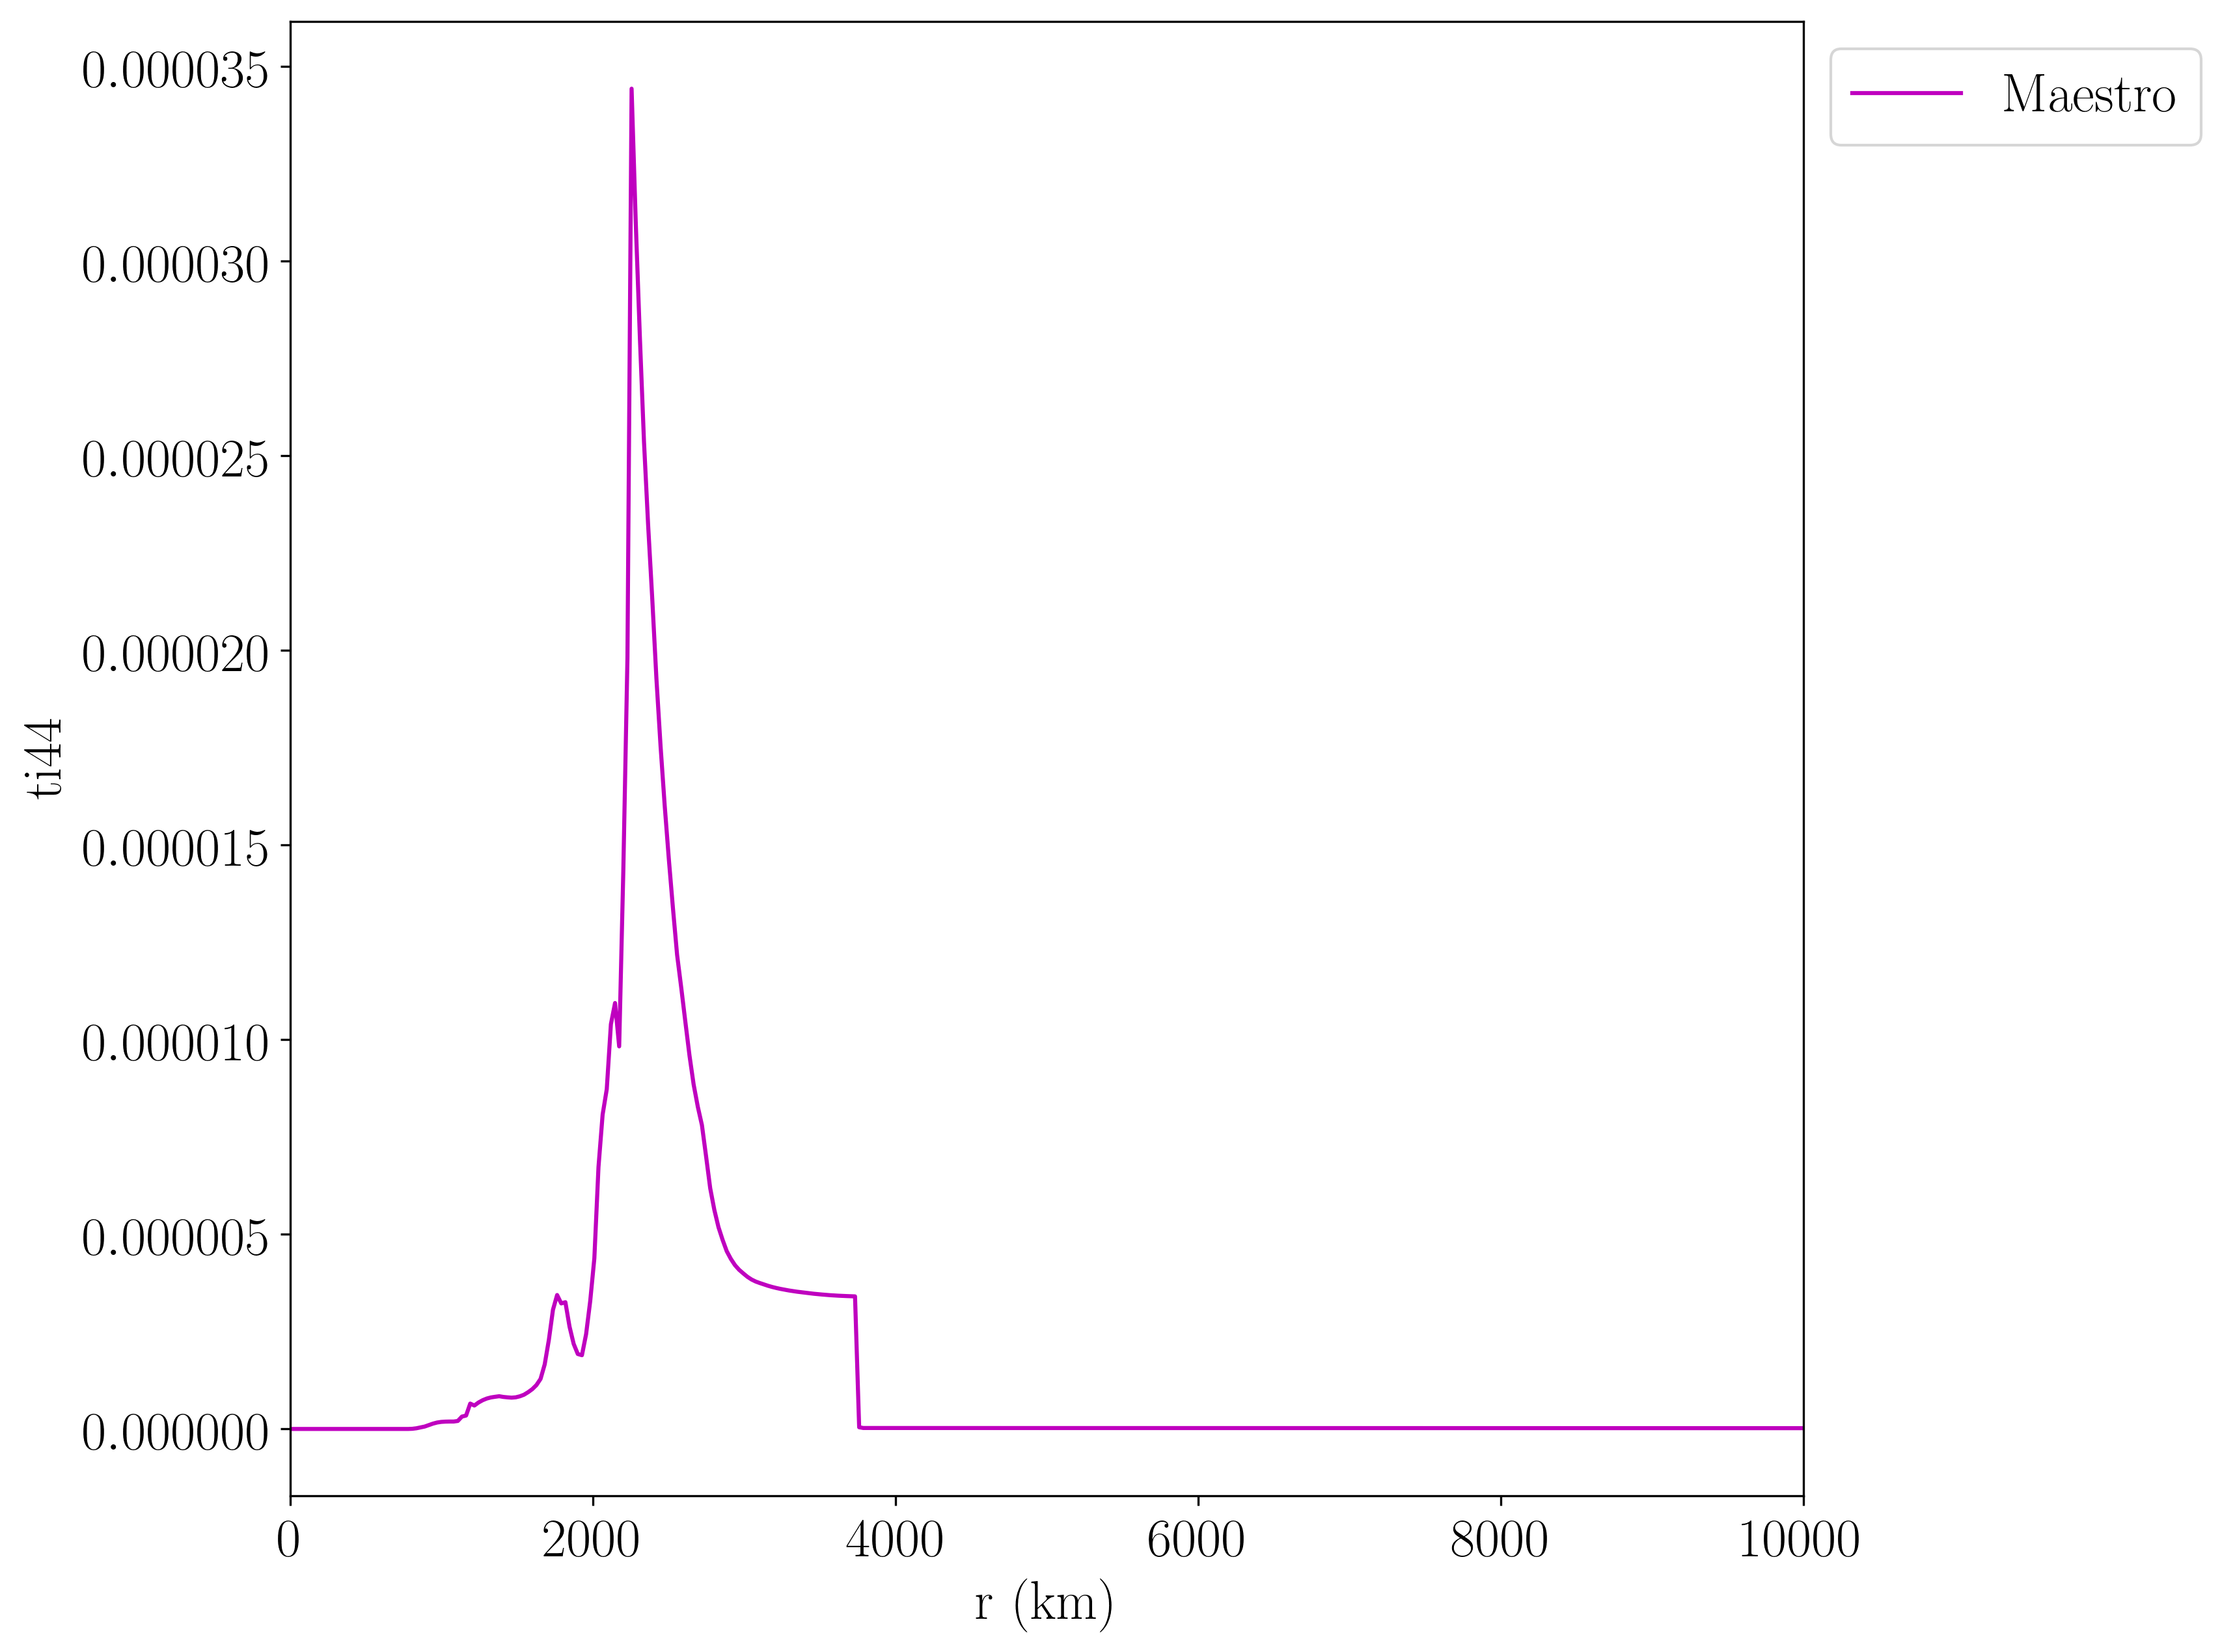

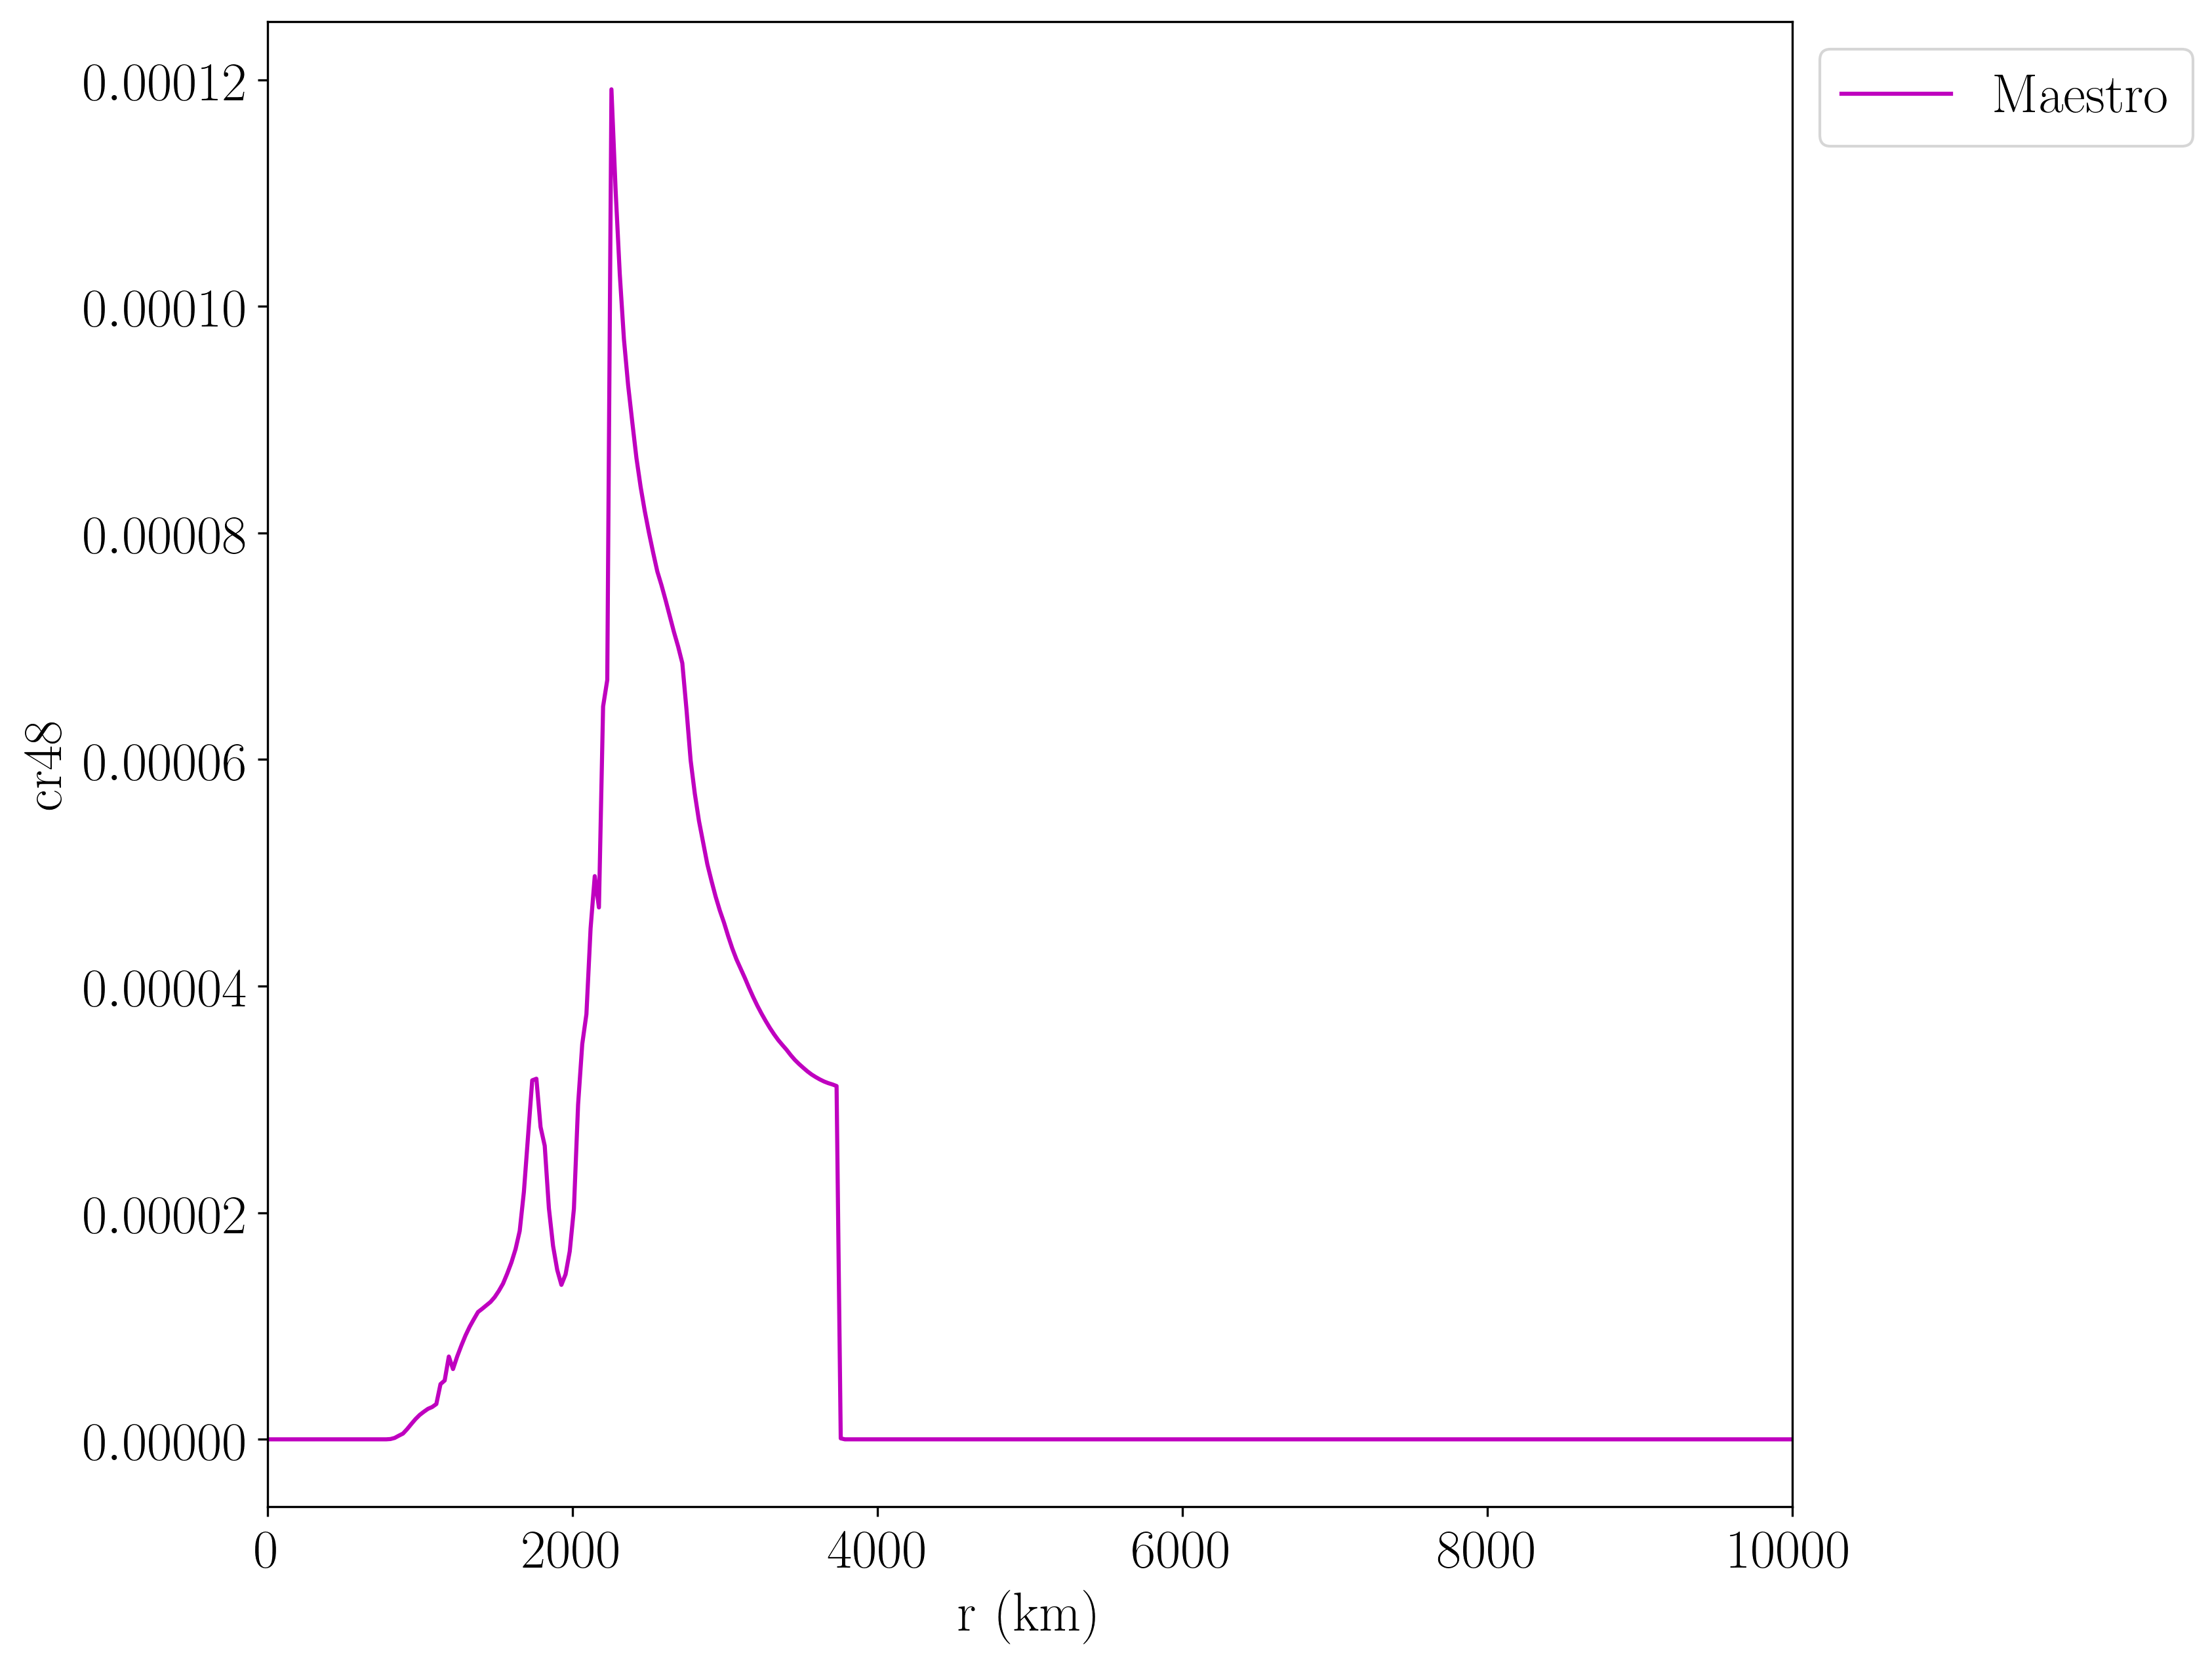

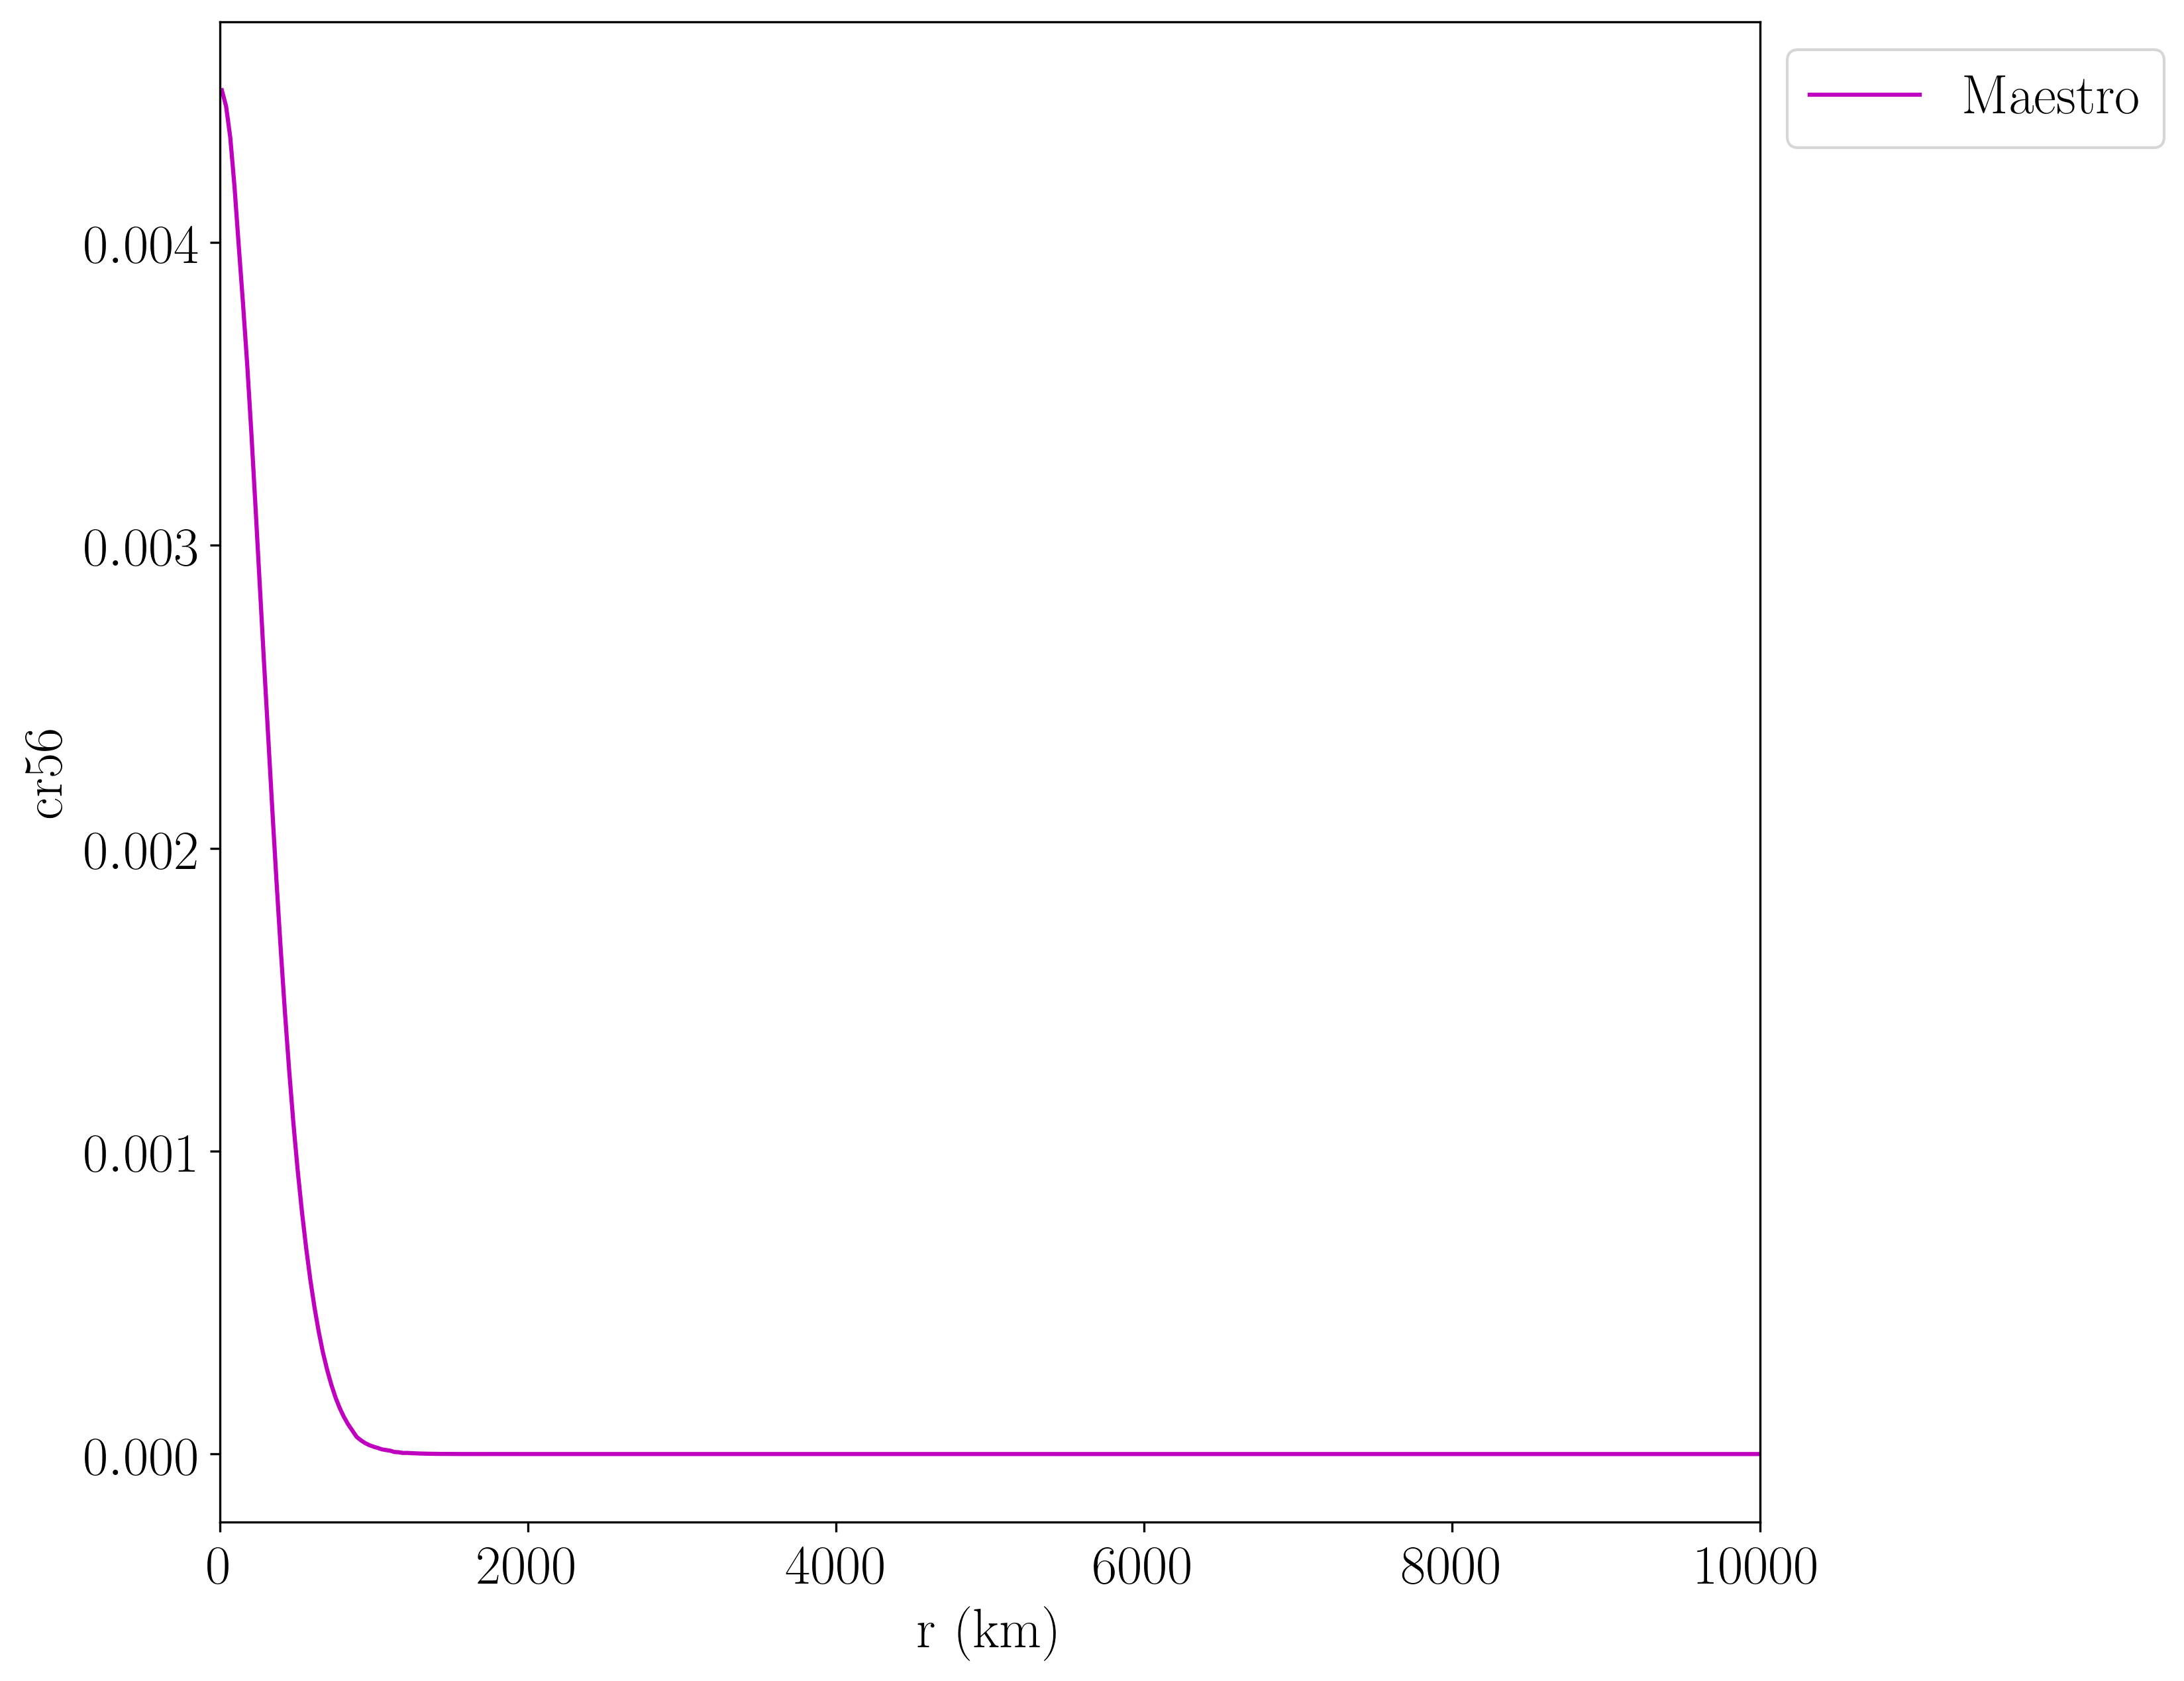

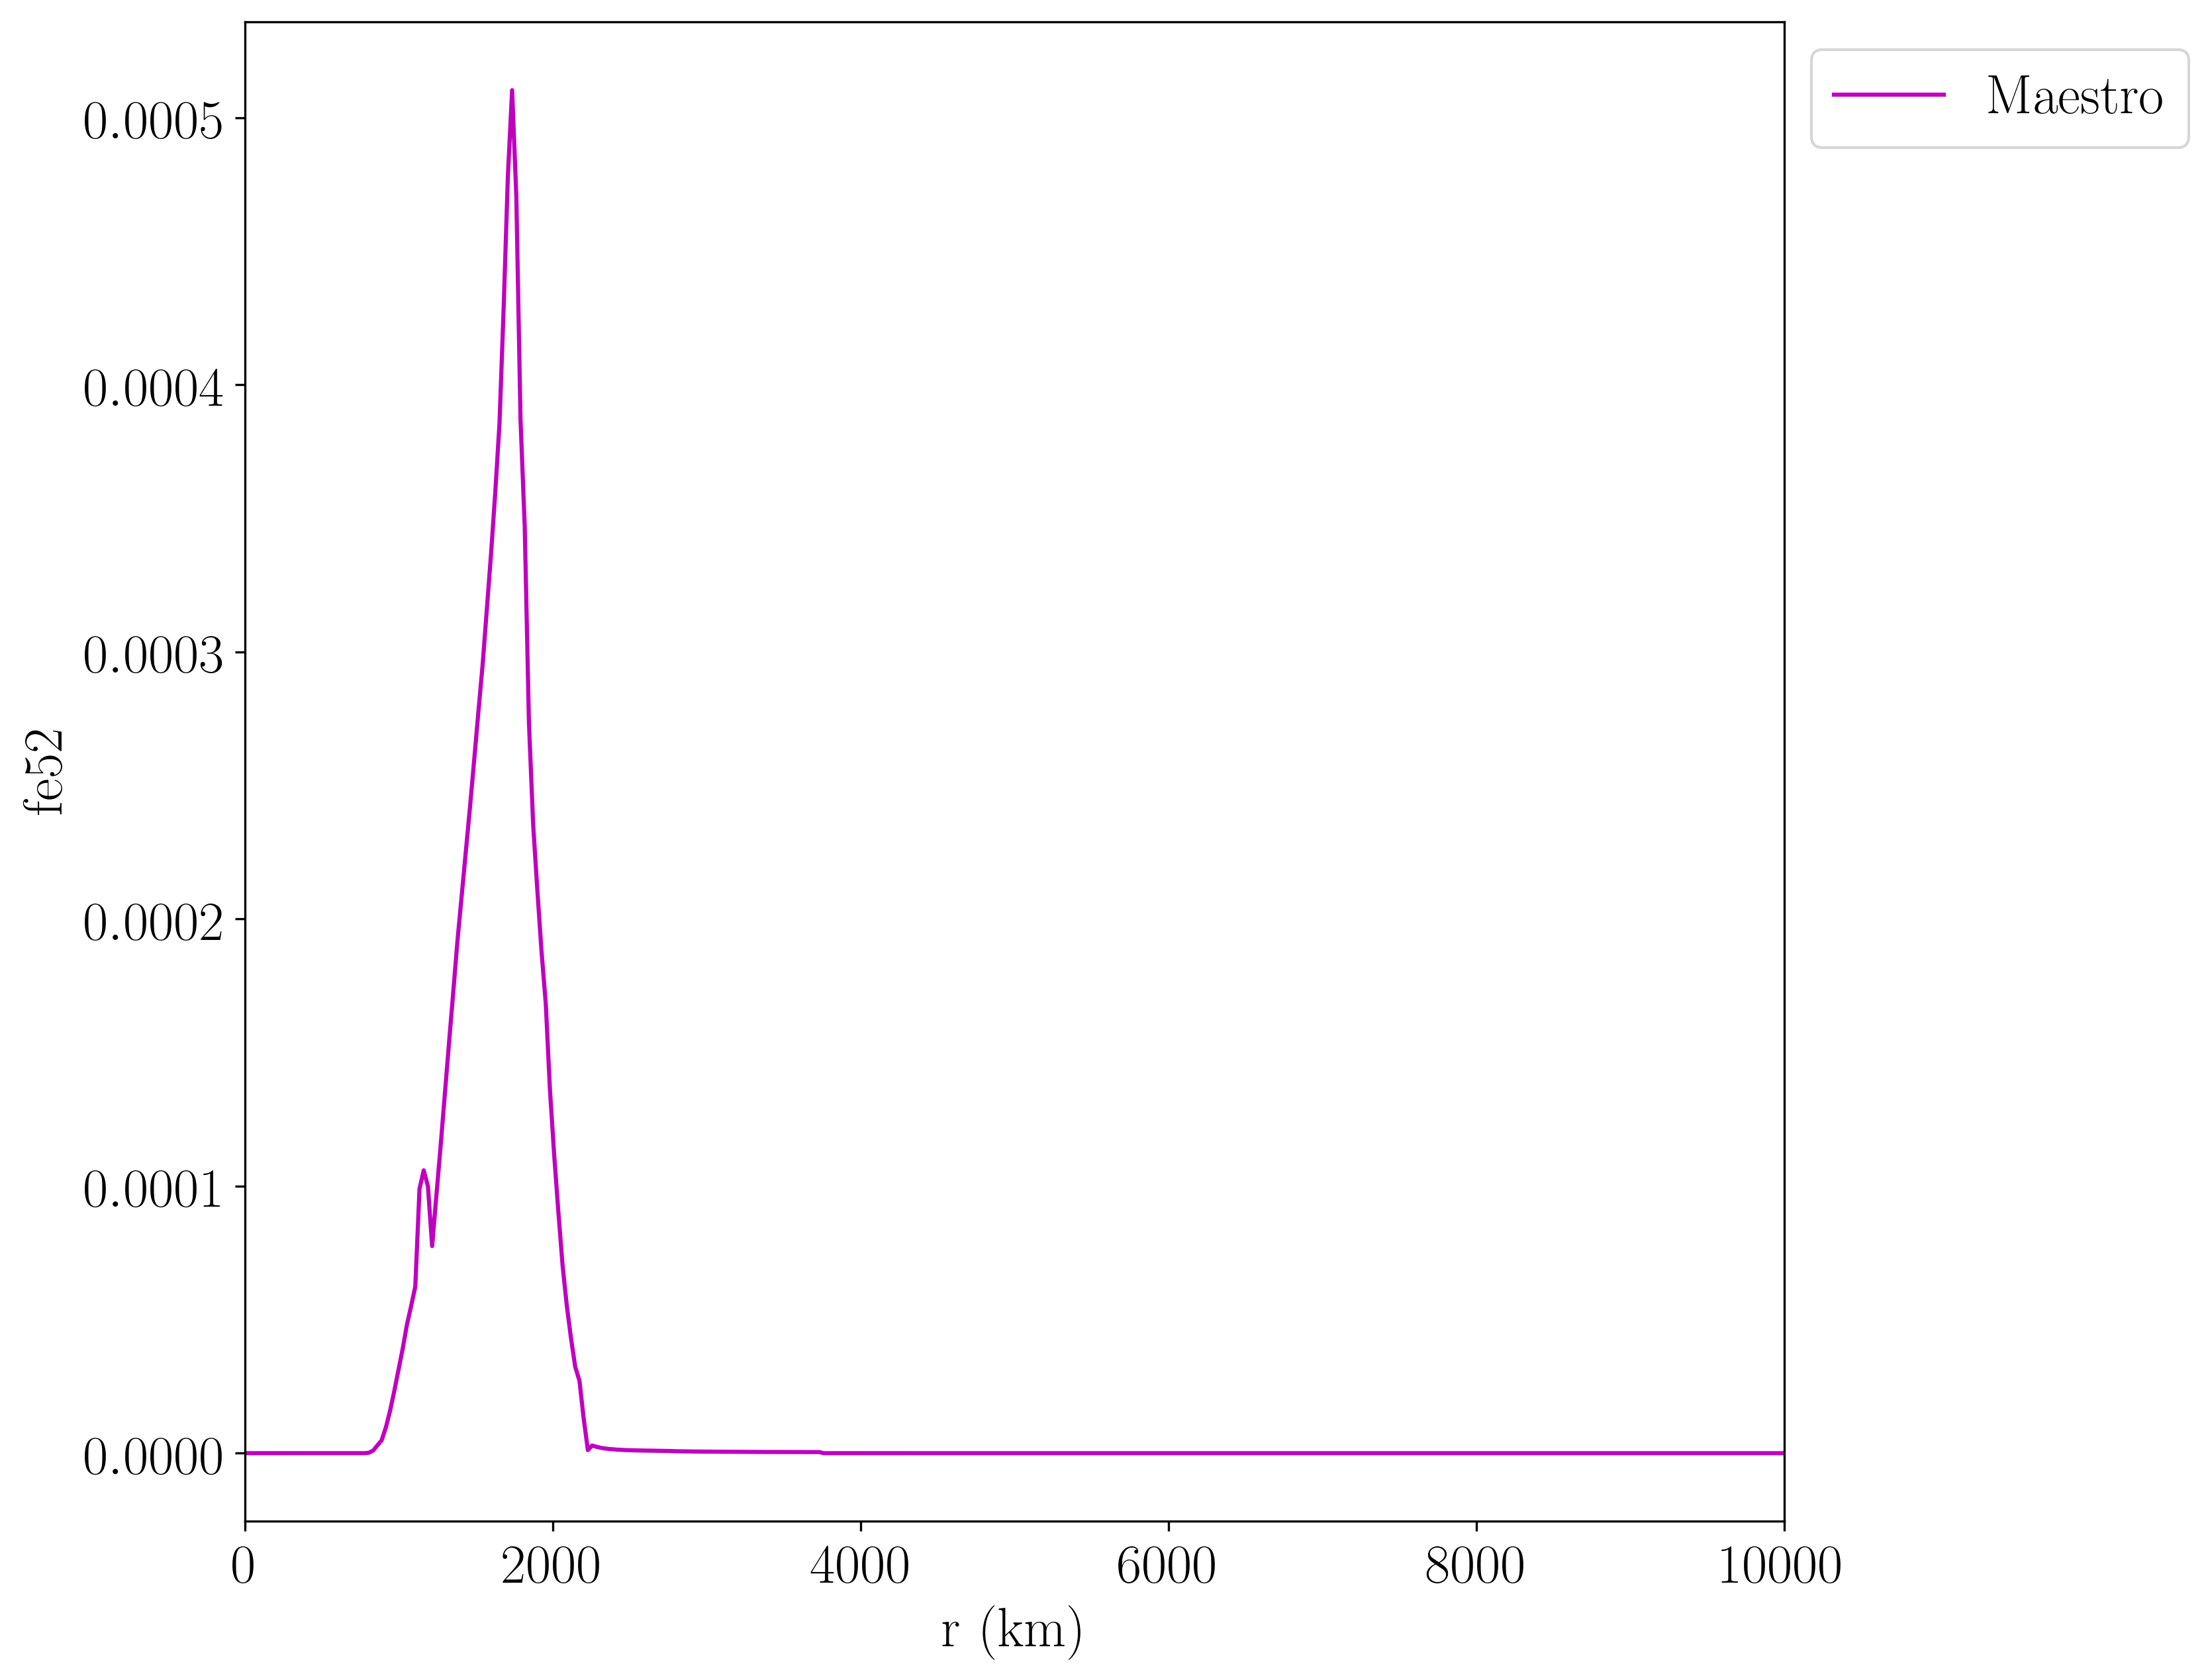

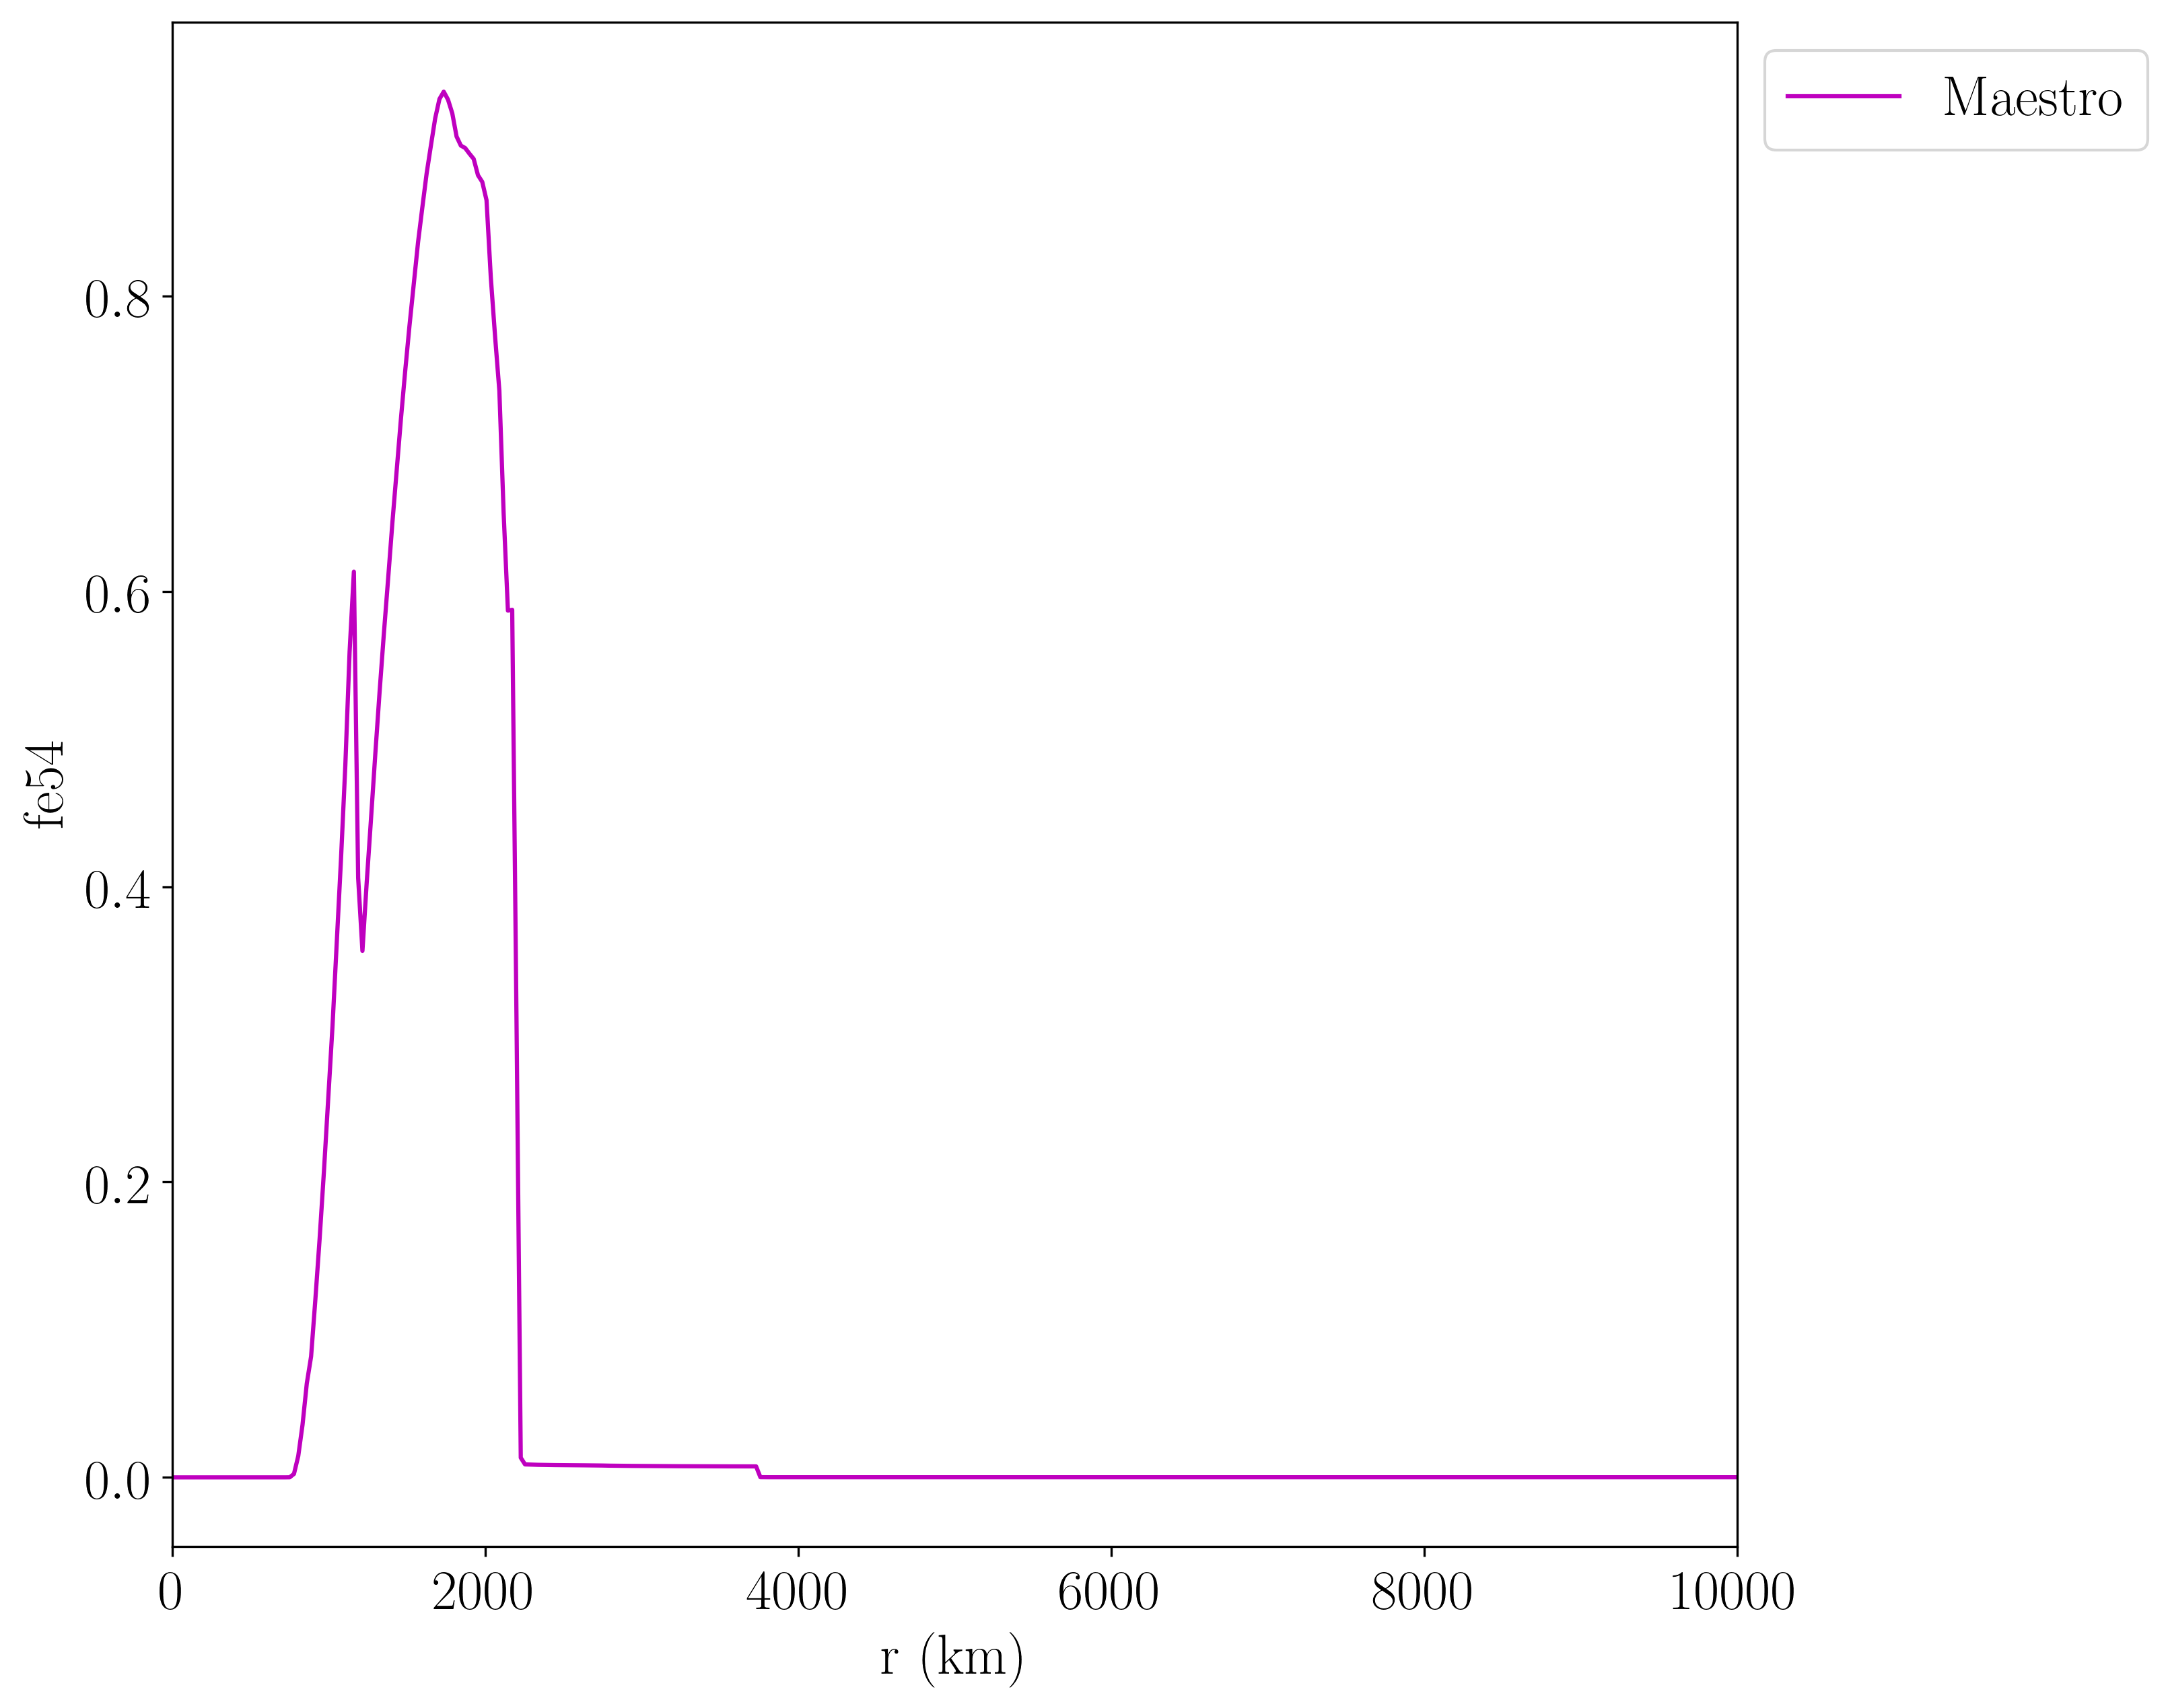

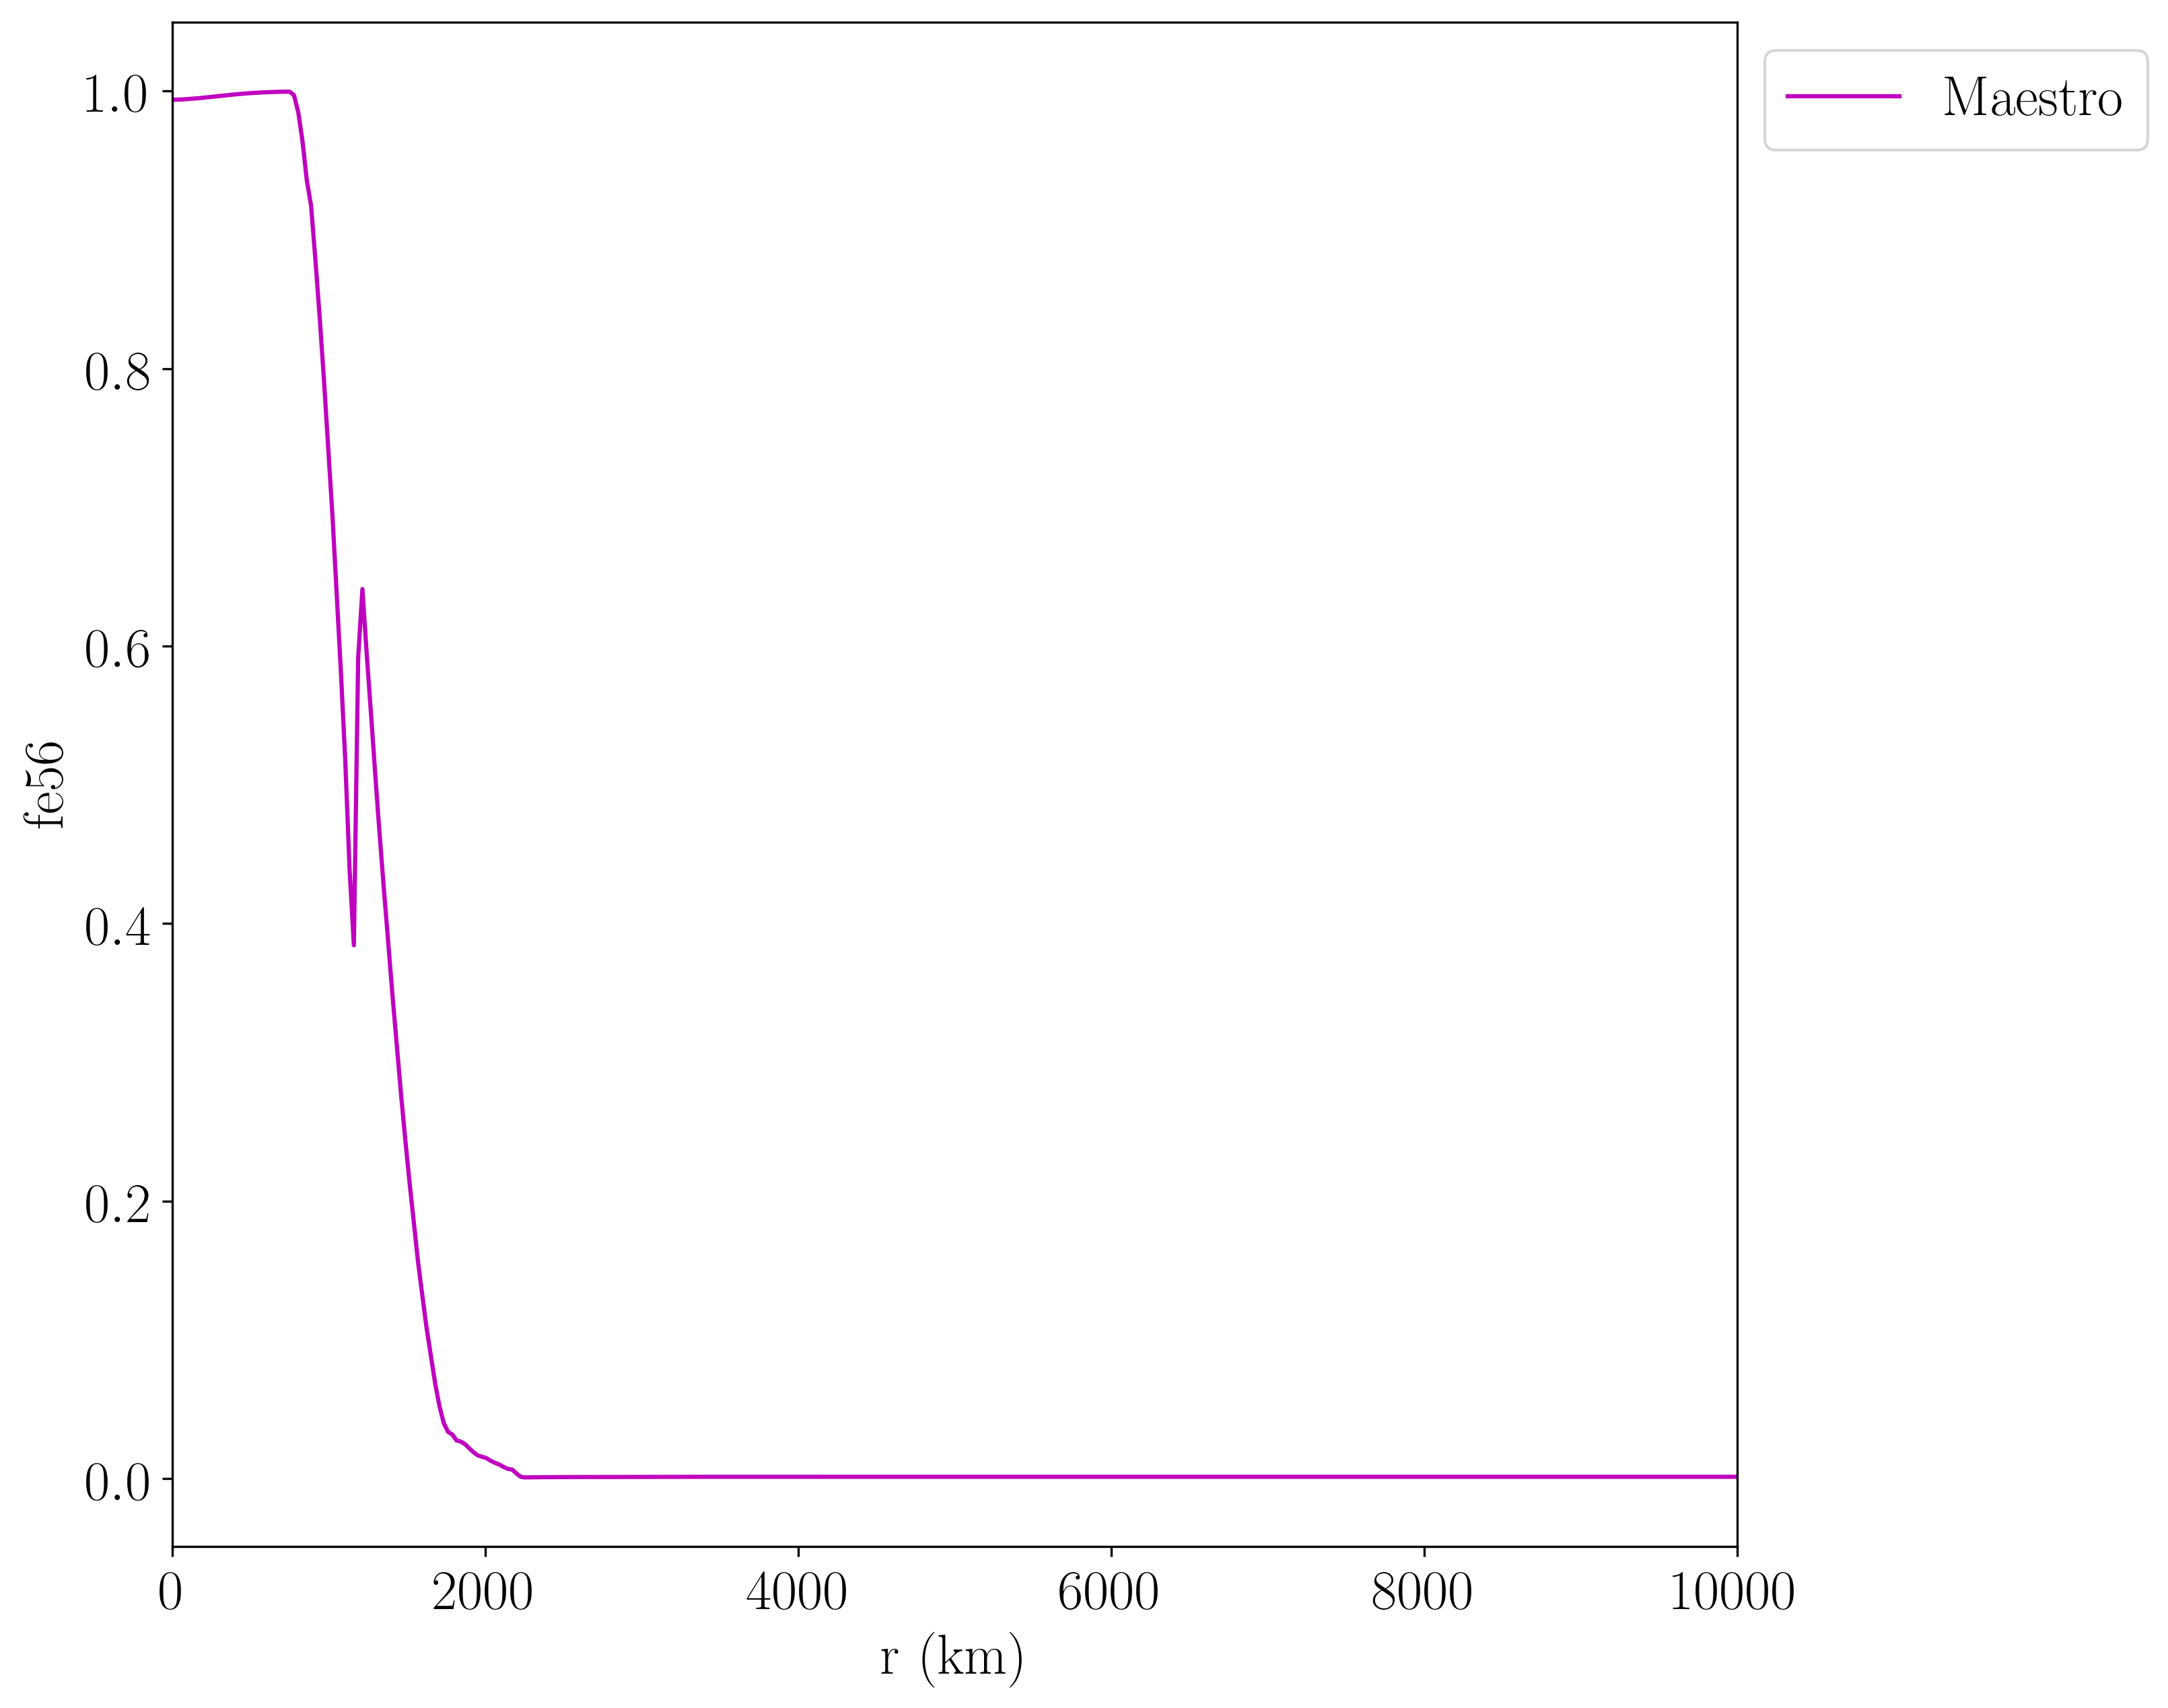

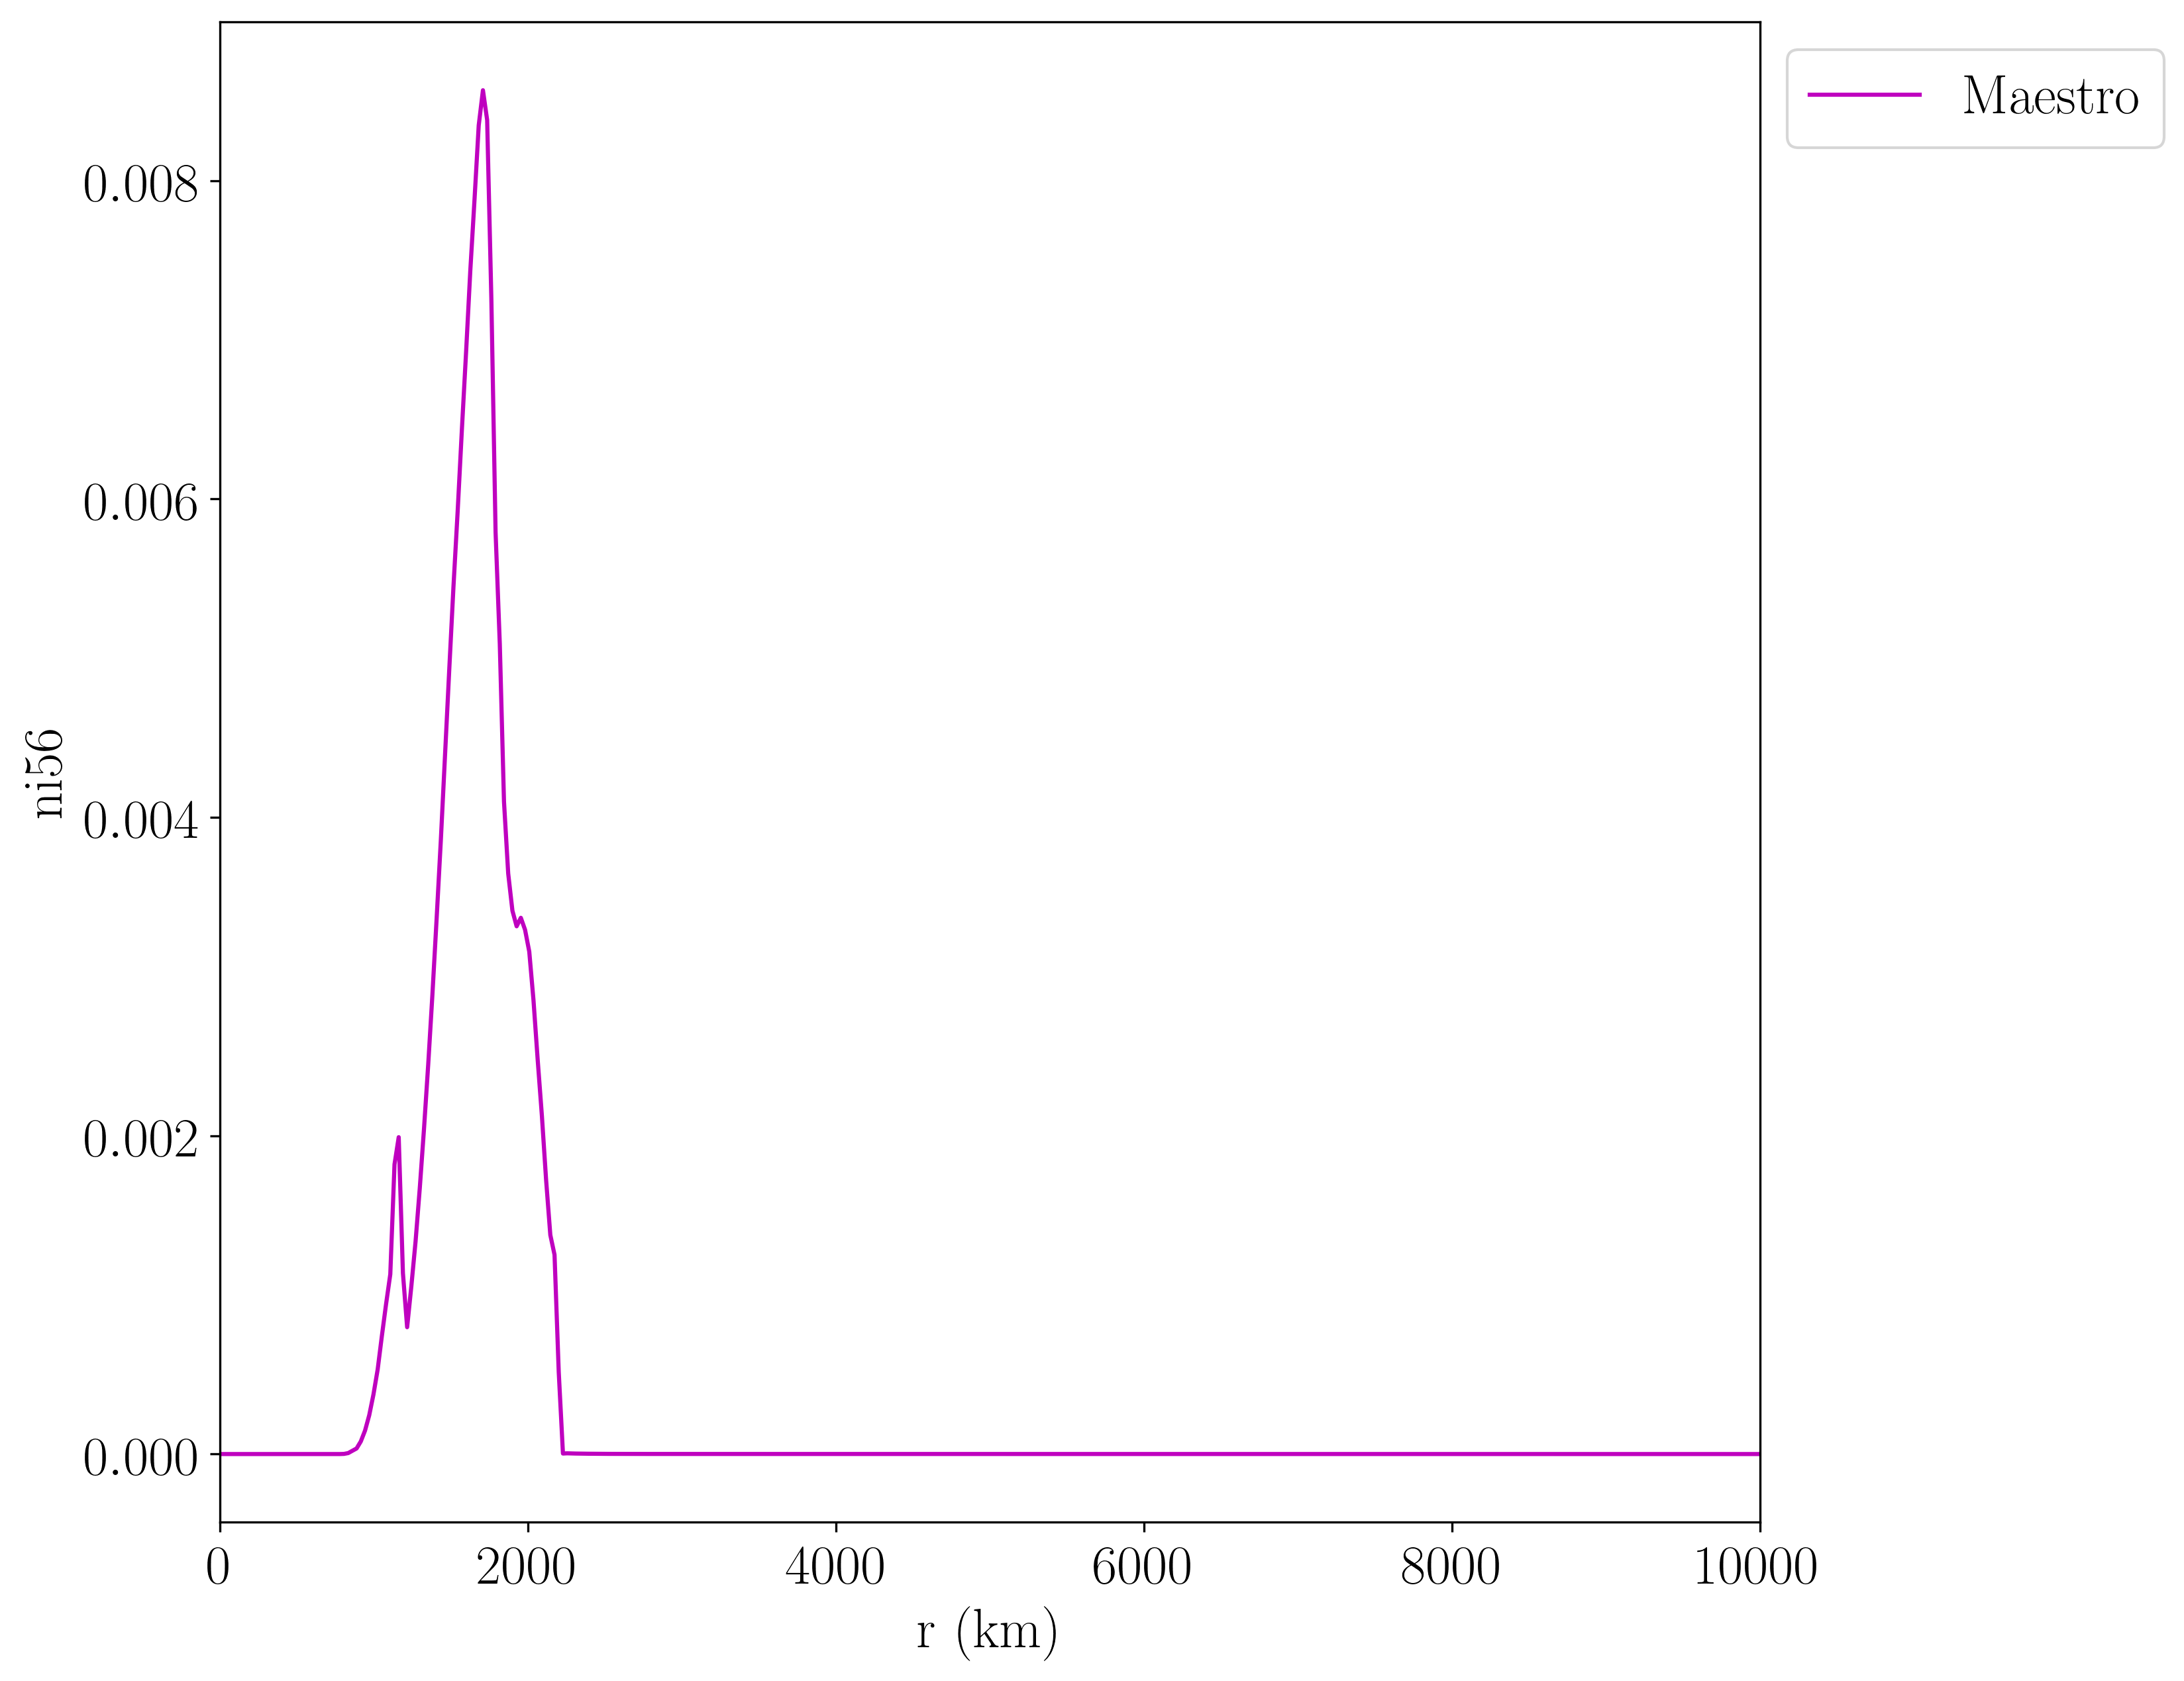

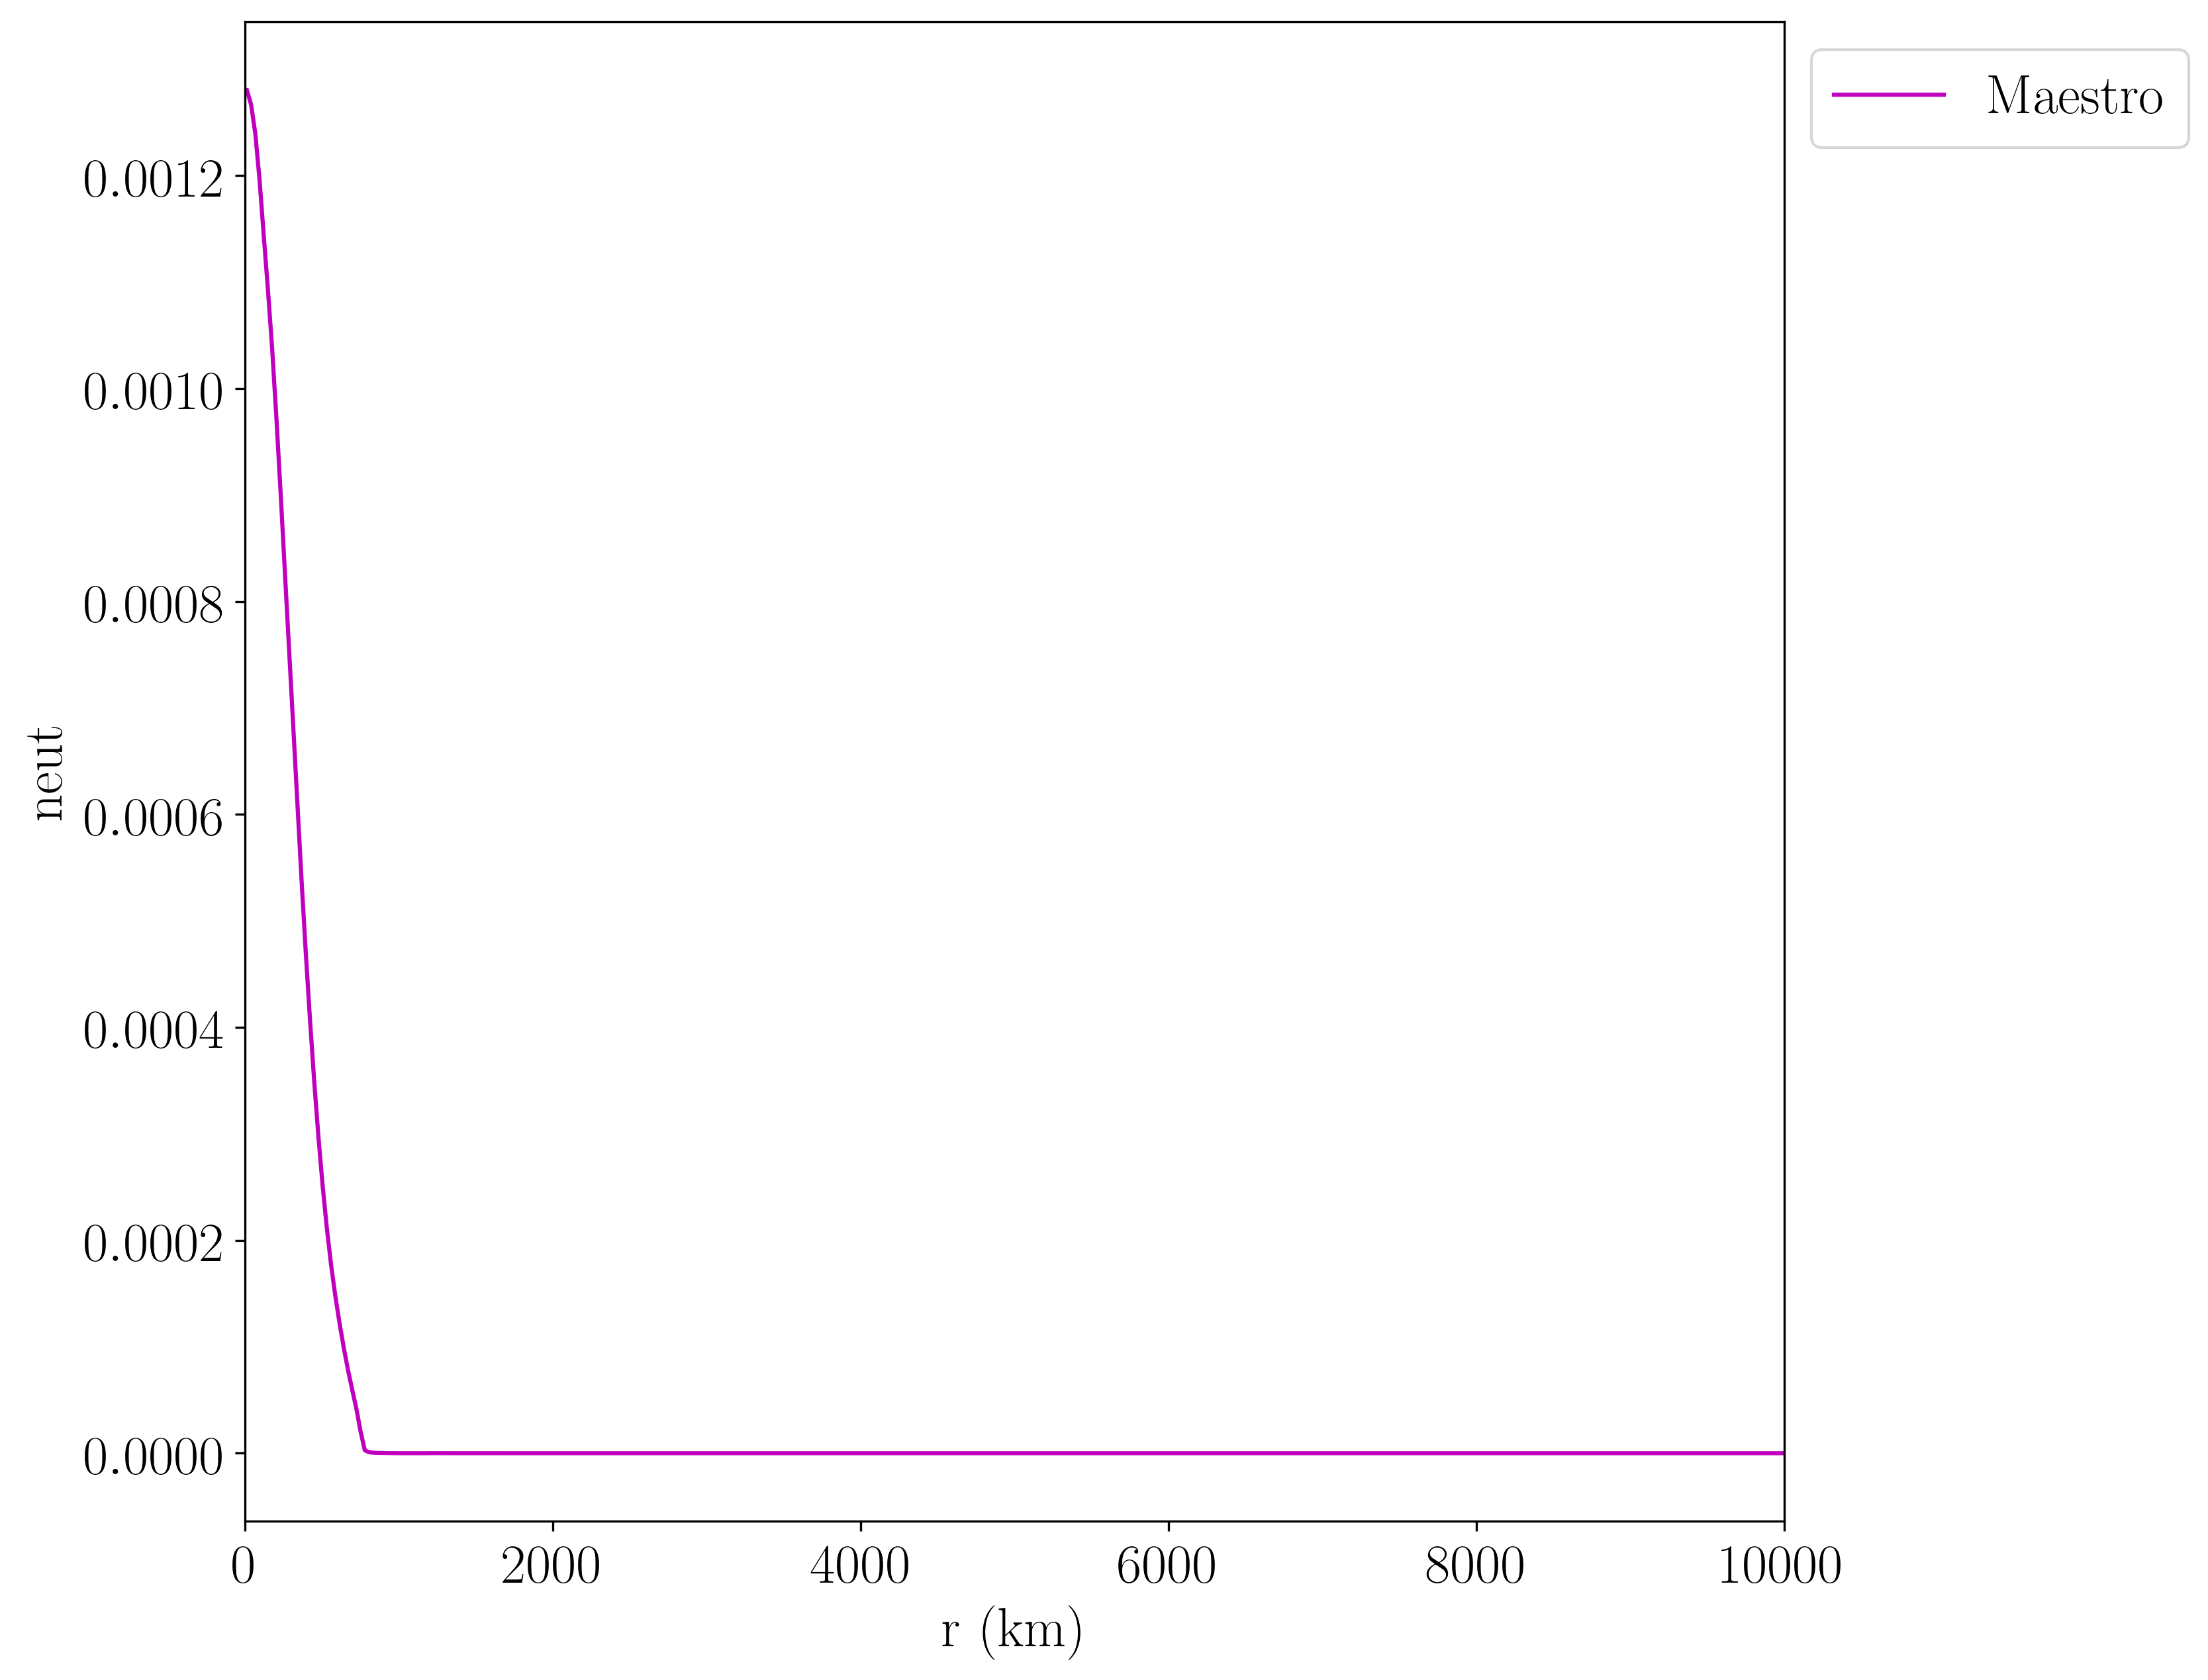

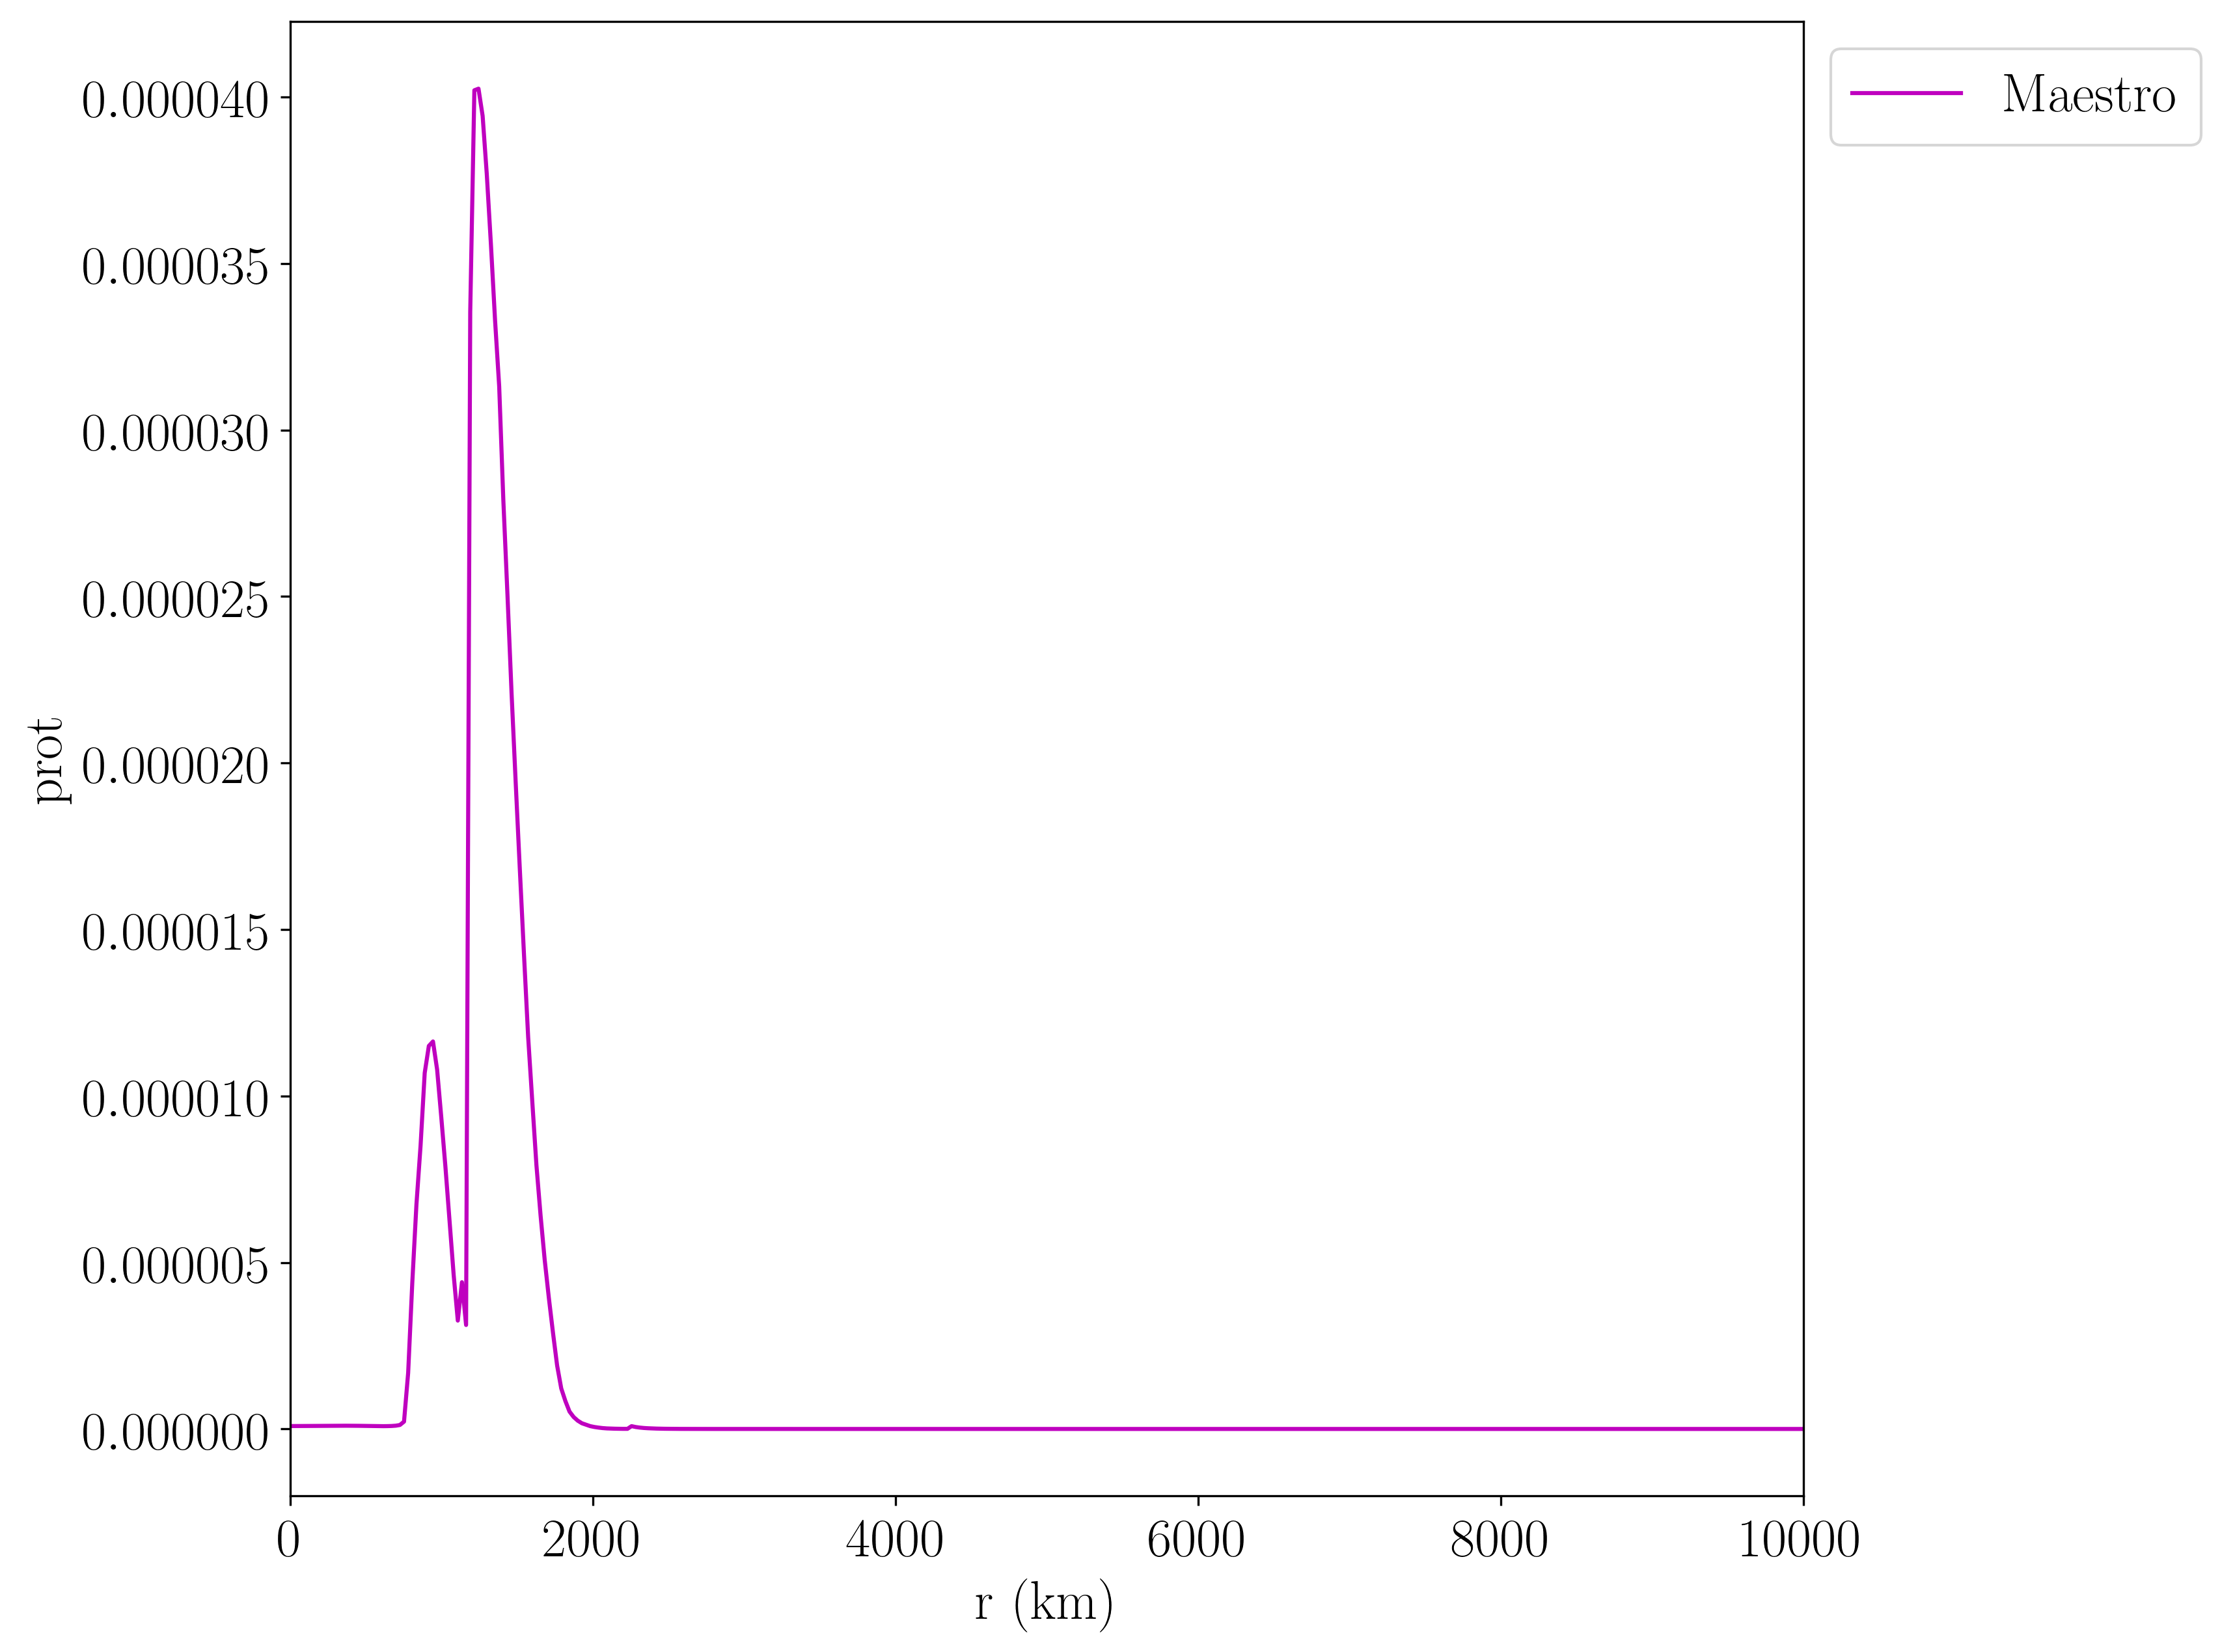

In [19]:
for s in net.short_species_names:
    plot_field(field=s, logy=False, xlim=[0.0, 10e3])

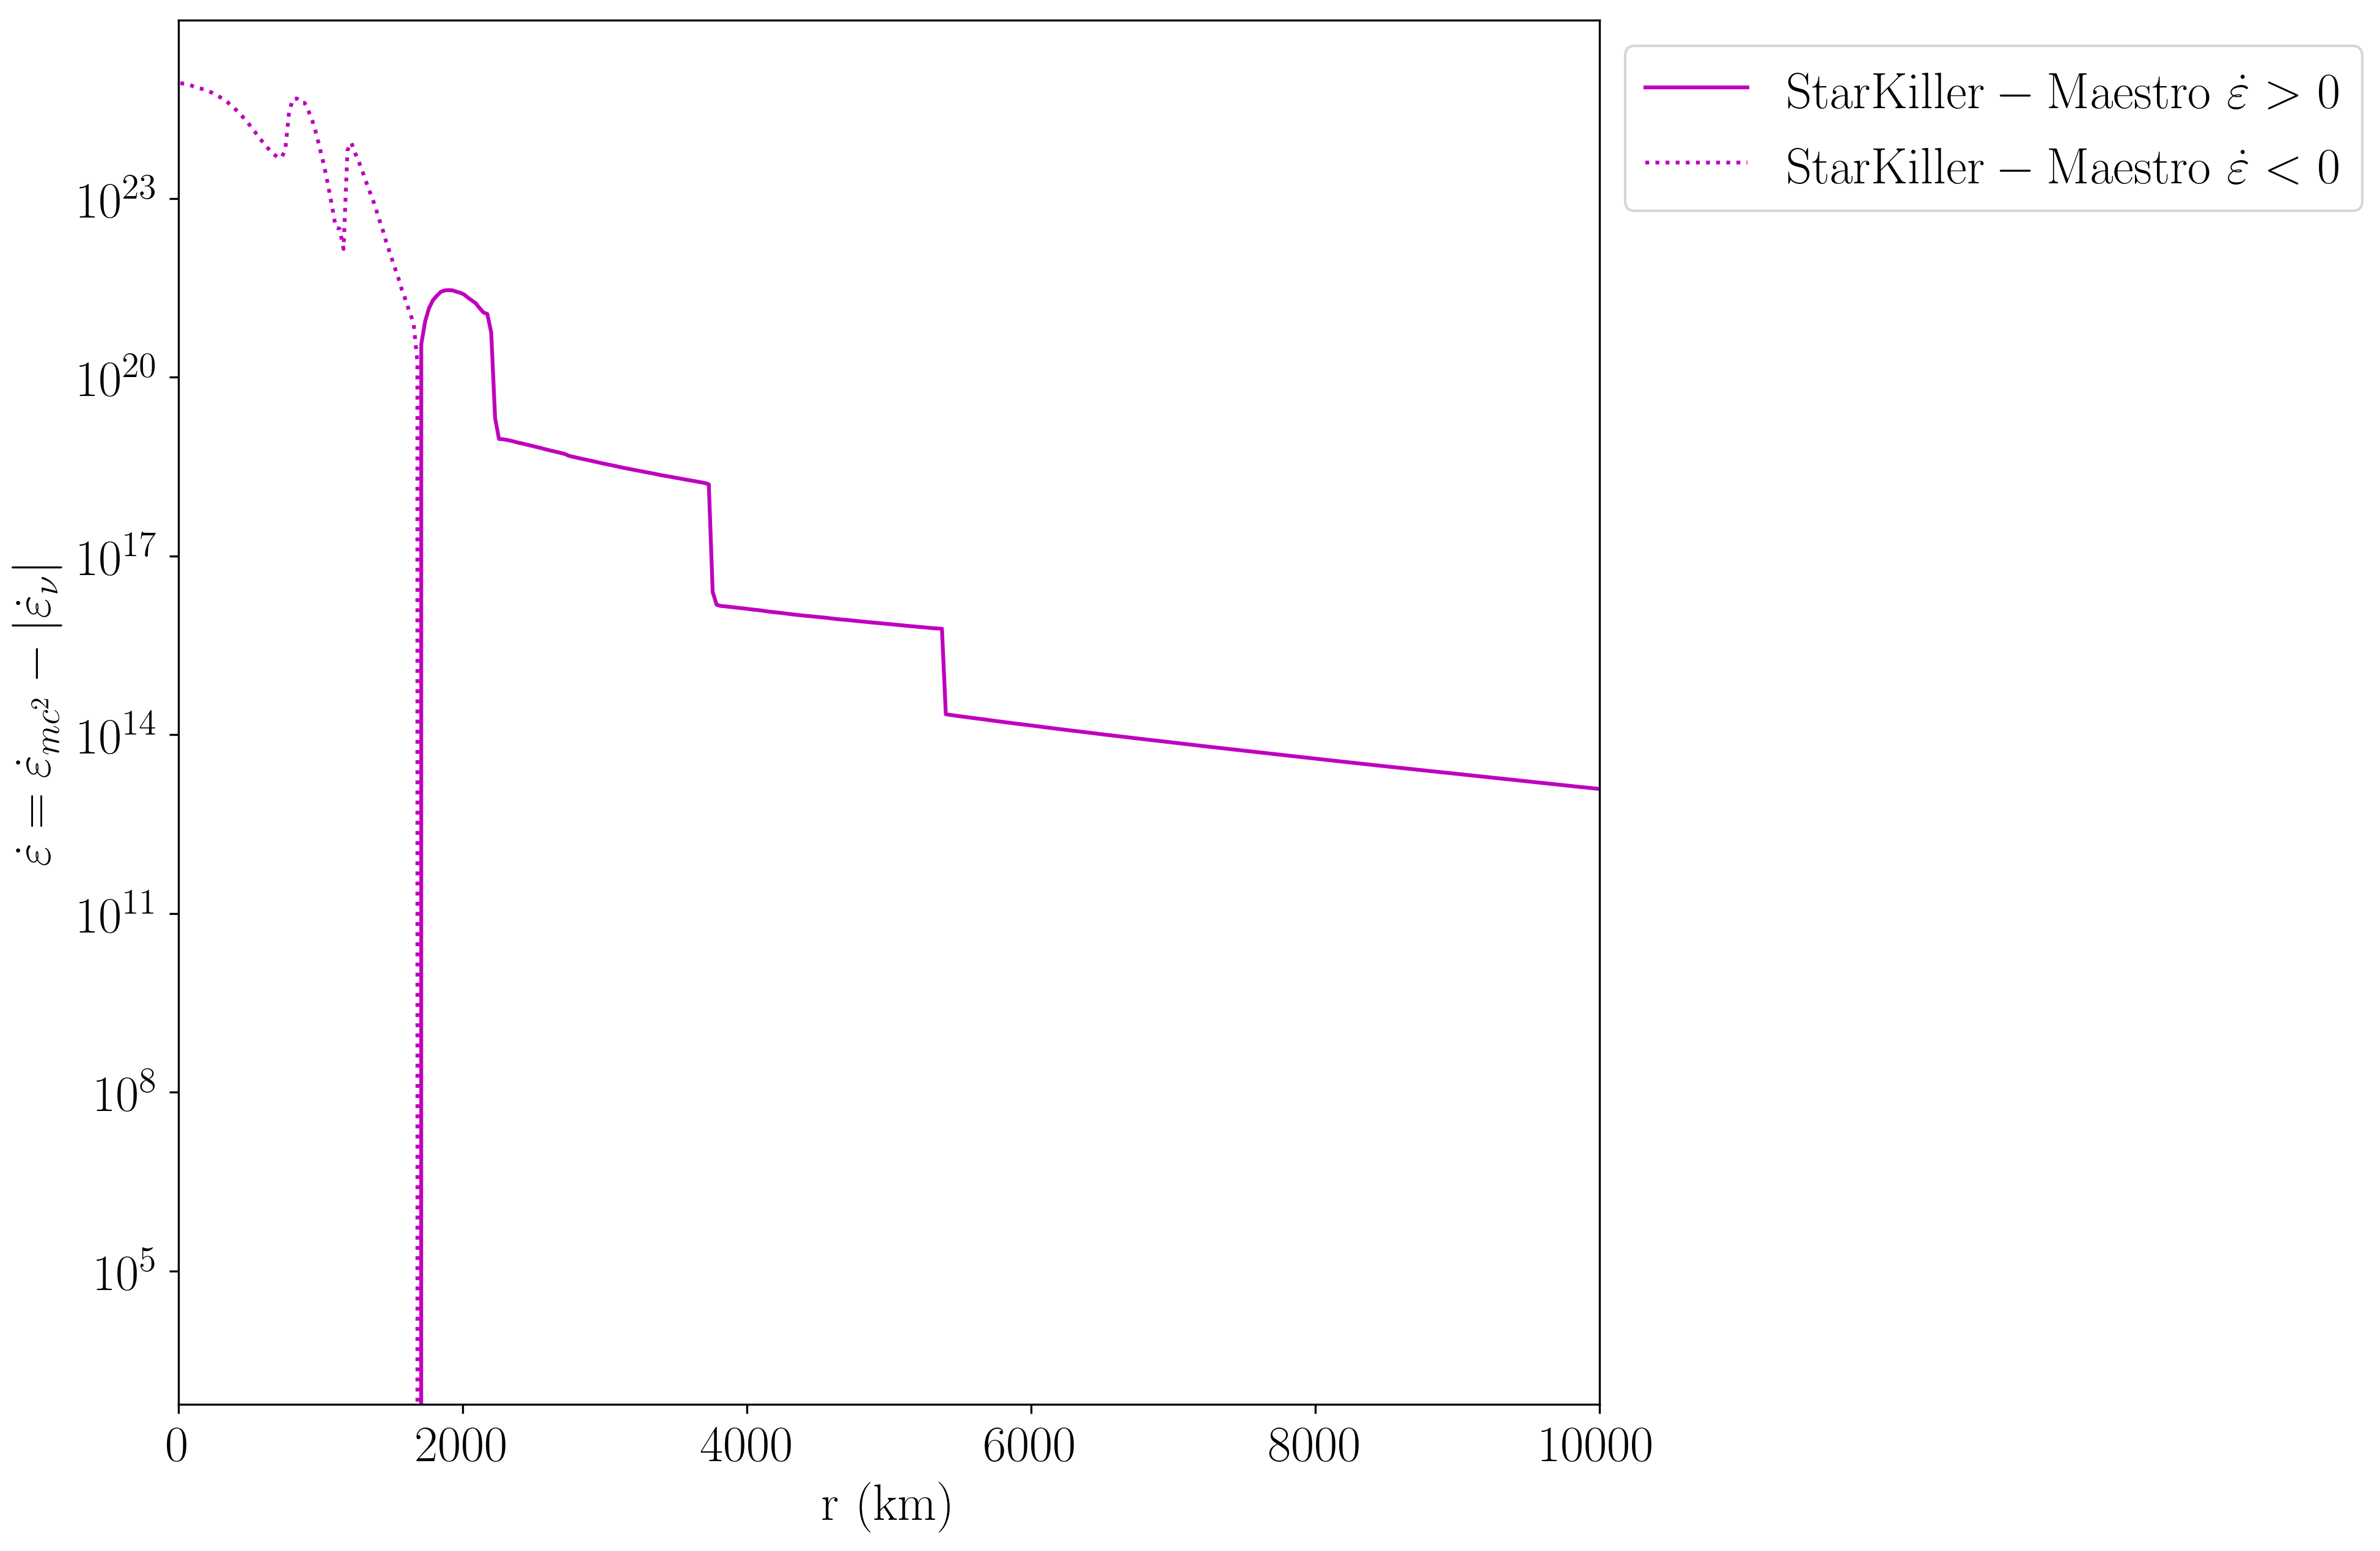

In [26]:
plot_enuc(xlim=[0.0, 10e3])

### Zoom in more on shell

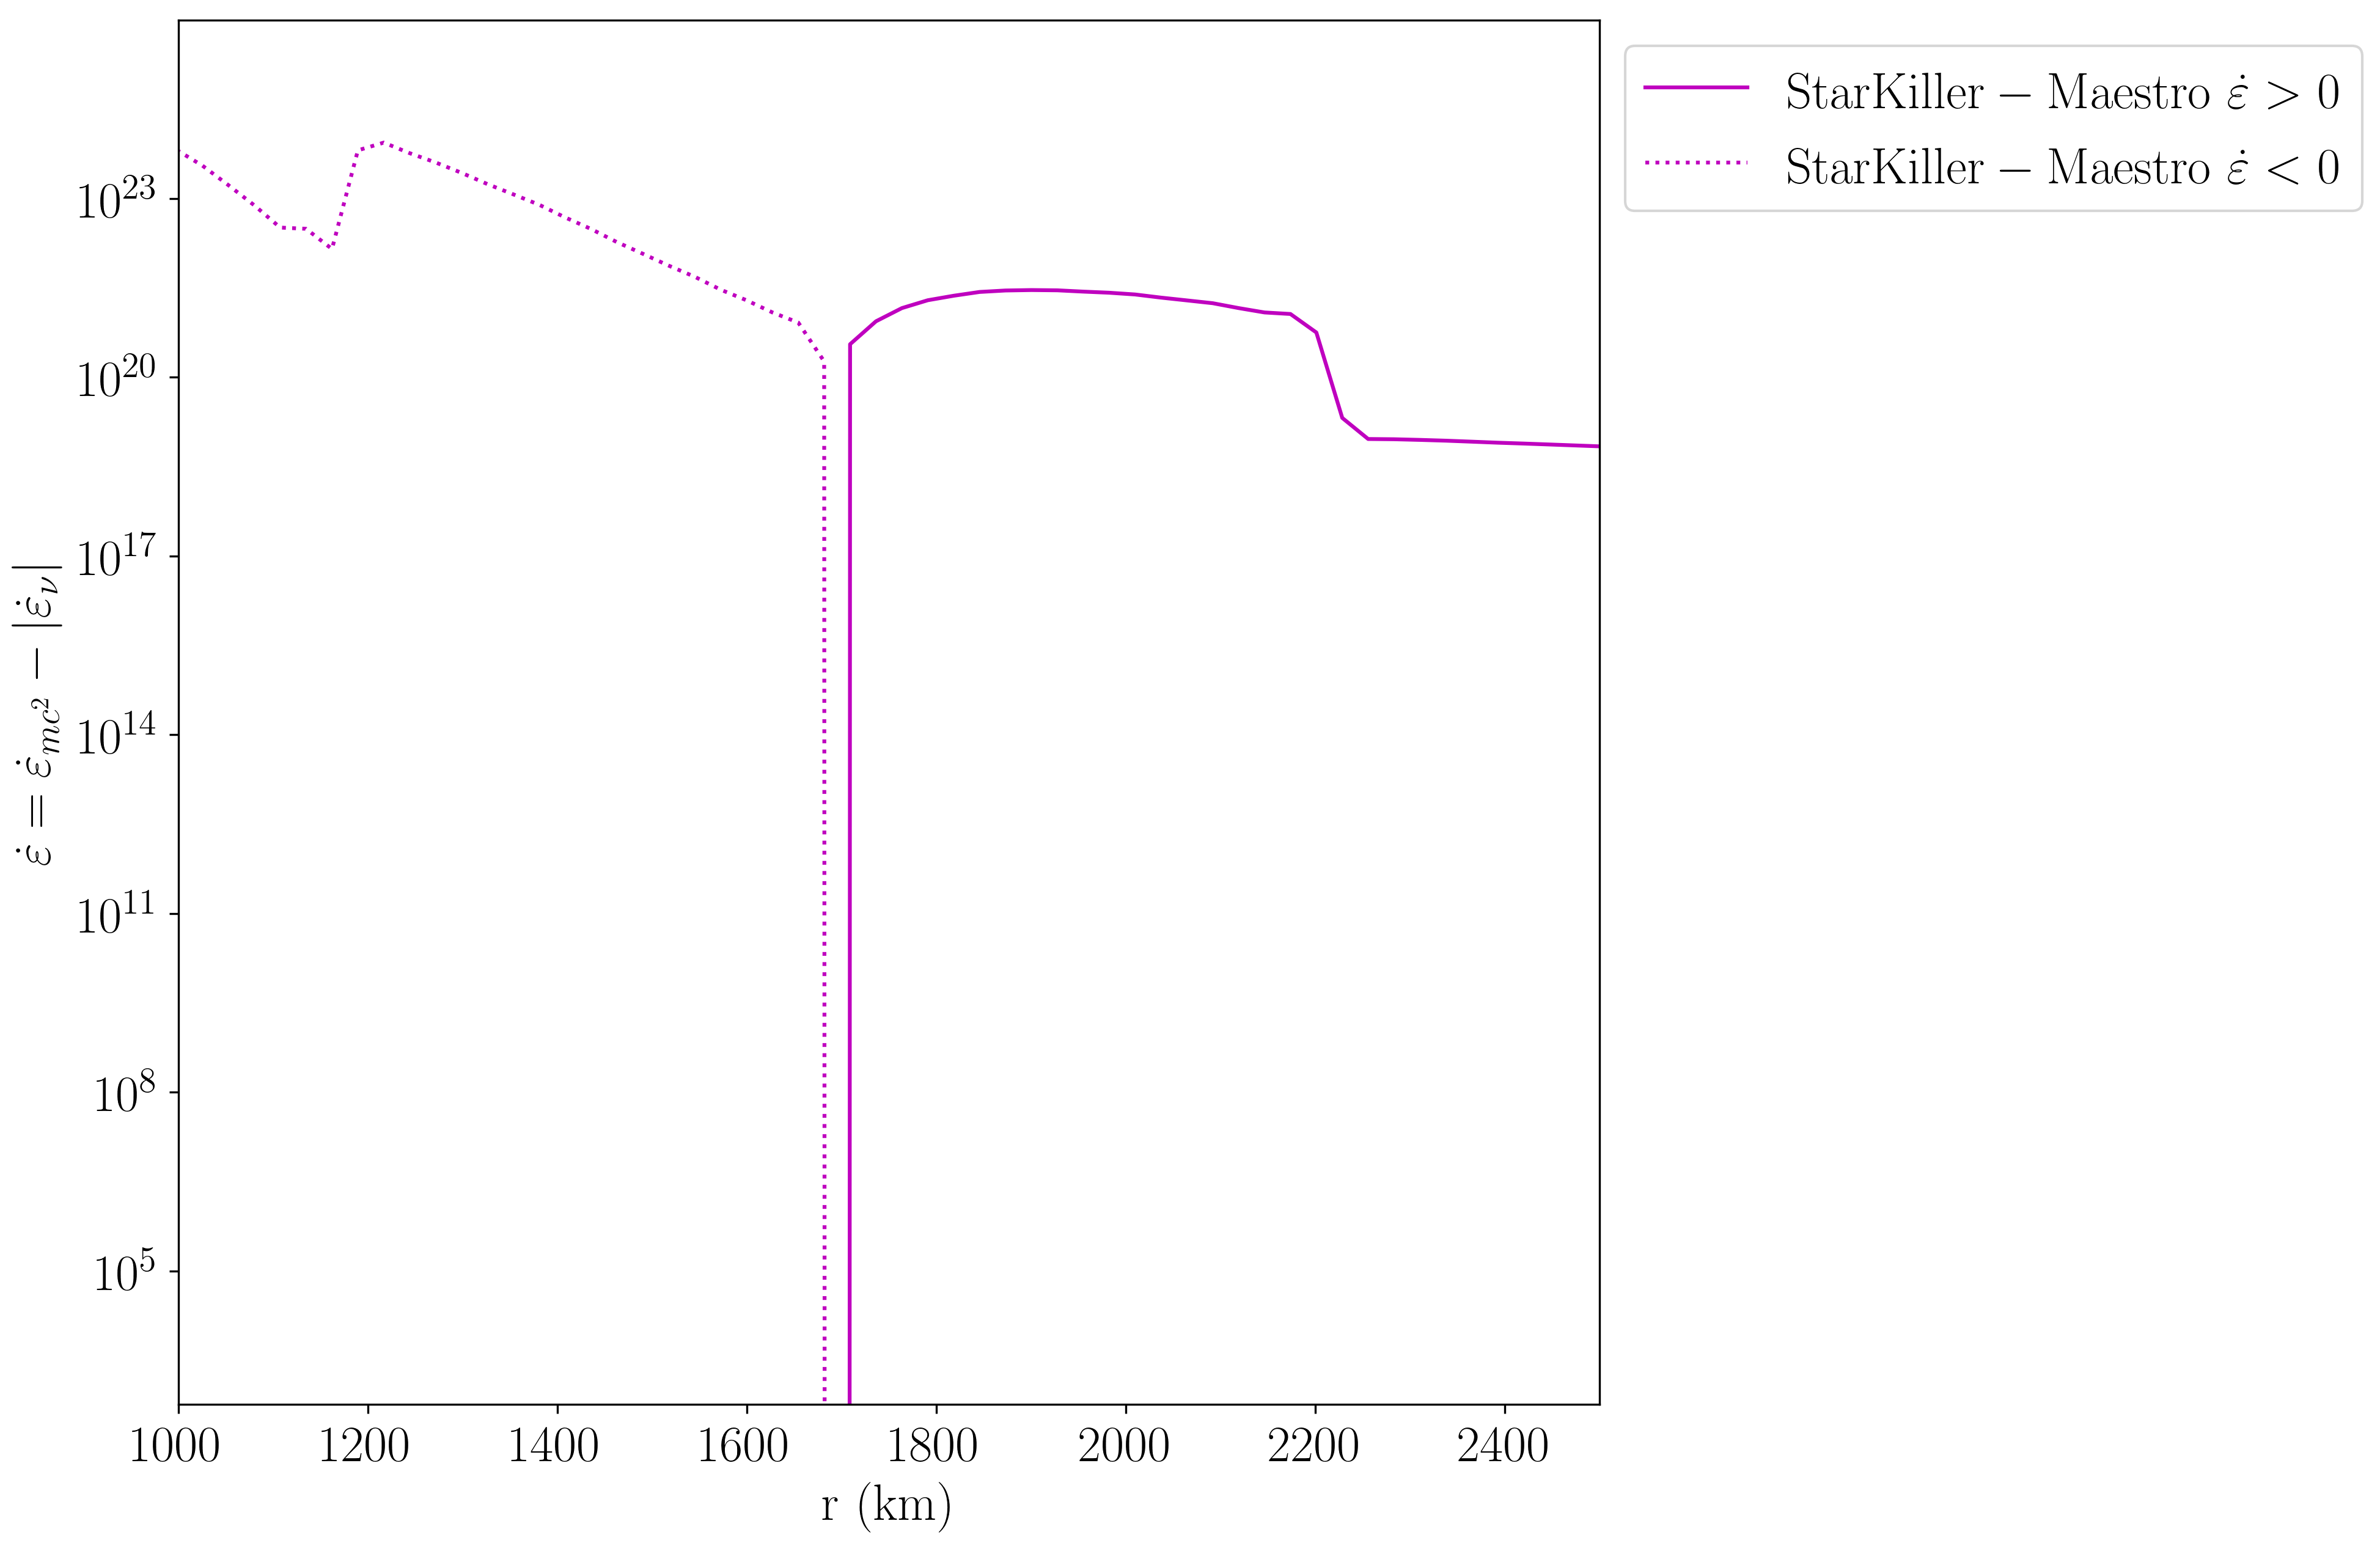

In [28]:
plot_enuc(xlim=[1000.0, 2500.0])